In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
from scipy.ndimage import gaussian_filter
from astropy.stats import mad_std
#from astropy.modeling.models import Schechter1D
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
import os
import matplotlib.ticker as ticker
from astropy.table import Table
from make_cuts import choosef, random_apers, get_names, radec_minmax, cuts
from astropy.cosmology import FlatLambdaCDM
#from astroML.plotting import MultiAxes
from scipy.optimize import curve_fit

In [2]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [4]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [5]:
table = Table.read("cat_gazpar_match.fits")
table

<Table length=4699>
NUMBER_1 FLUX_ISO_1 FLUXERR_ISO_1 ... MABS_FILT3 MABS_FILT4 STRING_INPUT
 int32    float32      float32    ...   int16      int16       int16    
-------- ---------- ------------- ... ---------- ---------- ------------
    4034  27.845892     1.8776053 ...          4          4            0
    4126  19.115555     1.5626724 ...          4          4            0
    4178  25.464865     1.5595572 ...          3          3            0
    4210    8.55499     1.0627733 ...          4          4            0
    4318  30.390625     1.7655902 ...          4          4            0
    4387  47.460045     2.1564226 ...          4          4            0
    4412   7.810413     1.0037836 ...          3          3            0
    4423   9.186293    0.91854346 ...         -1         -1            0
    4452   25.30679     1.5283419 ...          4          4            0
    4497  20.664652     1.4243853 ...          3          3            0
     ...        ...           ... ...        ...        ...          ...
  547140  19.516817     2.9616468 ...          4          4            0
  547145  138.67177      5.109932 ...          3         -1            0
  547150  22.622843     3.5999975 ...         -1         -1            0
  547160  12.832313     2.9241457 ...          3          3            0
  547162  16.671518     3.4416928 ...         -1         -1            0
  547165   27.59836     3.7186506 ...         -1         -1            0
  547172  46.210243       3.43596 ...         -1         -1            0
  547175     67.637      6.032095 ...         -1         -1            0
  547187  42.805534      4.478791 ...          4          4            0
  547200  128.76851      5.464305 ...         -1         -1            0

In [6]:
mask1 =  (0 < table['Z_BEST']) & (table['Z_BEST'] < 0.7)

data_a =table[mask1]

In [7]:
mask2 =  (0.7 < table['Z_BEST']) & (table['Z_BEST'] < 1.3)

data_b = table[mask2]

In [8]:
mask3 =  (1.3 < table['Z_BEST']) & (table['Z_BEST'] < 2)
data_c = table[mask3]

In [9]:
al = np.mean(data_a['Z_BEST']-data_a['Z_BEST68_LOW'])
ah = np.mean(data_a['Z_BEST68_HIGH']-data_a['Z_BEST'])
bl = np.mean(data_b['Z_BEST']-data_b['Z_BEST68_LOW'])
bh = np.mean(data_b['Z_BEST68_HIGH']-data_b['Z_BEST'])
cl = np.mean(data_c['Z_BEST']-data_c['Z_BEST68_LOW'])
ch = np.mean(data_c['Z_BEST68_HIGH']-data_c['Z_BEST'])

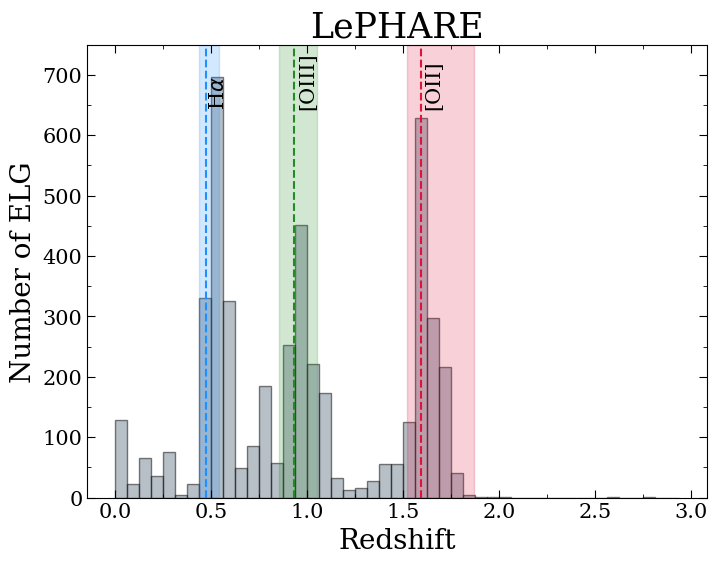

In [10]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['Z_BEST'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.47-ah, 0.47+al, alpha=0.2, color='dodgerblue')
ax.text(0.49, 650, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.93-bh,0.93+bl, alpha=0.2, color='forestgreen')
ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.59-ch, 1.59+cl, alpha=0.2, color='crimson')
ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', bottom=True, top=True, direction='in', length=3)
# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_title('LePHARE')
ax.set_ylim(0,750)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

In [11]:
tableb = Table.read('combined.fits')

In [12]:
# fig,ax=plt.subplots(figsize=(8,6),facecolor= 'w', dpi=100)
# x = np.linspace(0,3,1000)
# ax.scatter(table['Z_BEST'], tableb['redshift_50'], c ='royalblue', s =10, marker = '*', alpha = 0.5)
# ax.set_xlabel('LePhare redshift', size = 16)
# ax.set_ylabel(r'Bagpipes redshift', size = 16)
# ax.plot(x,x, color = 'black', linestyle ='dashed')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
# plt.show()

In [13]:
tableb

<Table length=4699>
NUMBER_1 FLUX_ISO_1 FLUXERR_ISO_1 ...    log_evidence      log_evidence_err 
                                  ...                                       
 int32    float32      float32    ...      float64             float64      
-------- ---------- ------------- ... ------------------ -------------------
    4034  27.845892     1.8776053 ... 196.88624397629016 0.16506490724281045
    4126  19.115555     1.5626724 ...  202.1890380686559  0.1260463942166298
    4178  25.464865     1.5595572 ...  200.1676870411963 0.12796783926115365
    4210    8.55499     1.0627733 ... 200.90180895954913 0.13086775517464325
    4318  30.390625     1.7655902 ...  198.4371964049999 0.14433466343529858
    4387  47.460045     2.1564226 ...  198.8229456641905 0.14850212572843566
    4412   7.810413     1.0037836 ... 202.48257205164225 0.12321130104762365
    4423   9.186293    0.91854346 ... 199.96903604432717   0.146097923757414
    4452   25.30679     1.5283419 ... 196.77473321445424 0.15703299281126634
     ...        ...           ... ...                ...                 ...
  547140  19.516817     2.9616468 ... 192.48913572052487 0.17610068905409376
  547145  138.67177      5.109932 ... -721.9367778607702 0.11538569383234583
  547150  22.622843     3.5999975 ... -722.3774191001544 0.11861271607510016
  547160  12.832313     2.9241457 ... 200.68544710767637  0.1194166484454495
  547162  16.671518     3.4416928 ... -721.1937194461434 0.10539738617294524
  547165   27.59836     3.7186506 ... -721.2166594669571 0.10683659350132266
  547172  46.210243       3.43596 ... 204.78065621165163  0.0432806216524364
  547175     67.637      6.032095 ... -722.2403209827984 0.11835118600943763
  547187  42.805534      4.478791 ... 199.84641187412697 0.13046323009143918
  547200  128.76851      5.464305 ... -722.4639070991228  0.1211518367129398

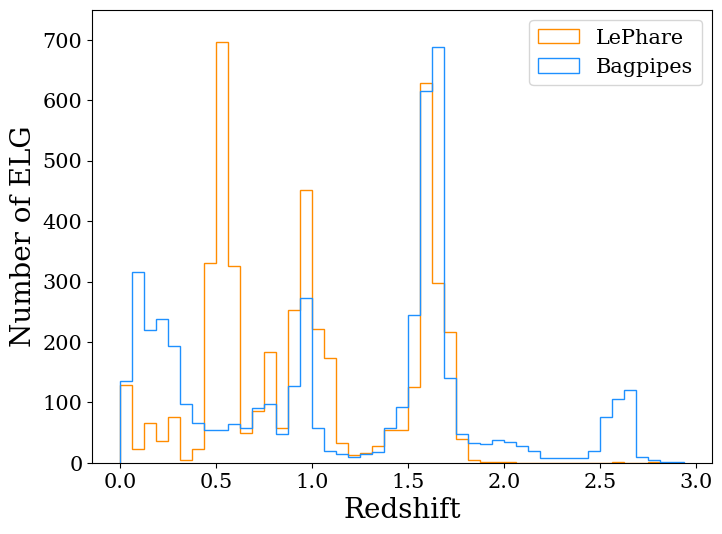

In [14]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['Z_BEST'], bins =bins, histtype ='step', alpha = 1, 
         color = 'forestgreen',ec = 'darkorange', label = 'LePhare')

ax.hist(tableb['redshift_50'], bins =bins, histtype ='step', alpha = 1, 
         color = 'slategray',ec = 'dodgerblue', label ='Bagpipes')

# ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
# #ax.axvspan(0.37, 0.63, alpha=0.2, color='dodgerblue')
# ax.text(0.4, 650, r'H$\alpha$', size = 15, rotation='vertical')

# ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
# #ax.axvspan(0.70, 1.15, alpha=0.2, color='forestgreen')
# ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

# ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
# #ax.axvspan(1.45, 1.9, alpha=0.2, color='crimson')
# ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.legend()
plt.show()

In [15]:
mask_MgII =  tableb['redshift_50'] > 2
MgIIbag = tableb[mask_MgII]
MgIIlep = table[mask_MgII]

In [16]:
z_b = tableb['redshift_84']
z_l = table['Z_BEST']

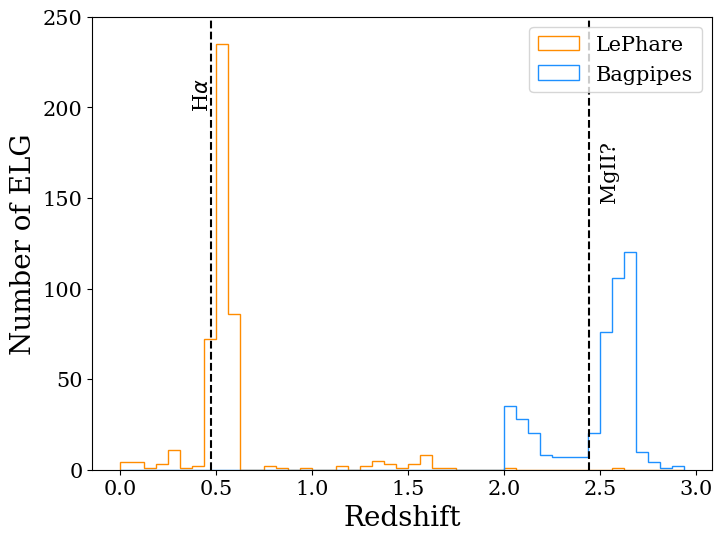

In [17]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(MgIIlep['Z_BEST'], bins =bins, histtype ='step', alpha = 1, 
         color = 'forestgreen',ec = 'darkorange', label = 'LePhare')

ax.hist(MgIIbag['redshift_50'], bins =bins, histtype ='step', alpha = 1, 
         color = 'slategray',ec = 'dodgerblue', label ='Bagpipes')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'k')
# #ax.axvspan(0.37, 0.63, alpha=0.2, color='dodgerblue')
ax.text(0.38, 200, r'H$\alpha$', size = 15, rotation='vertical')

# ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
# #ax.axvspan(0.70, 1.15, alpha=0.2, color='forestgreen')
# ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

# ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
# #ax.axvspan(1.45, 1.9, alpha=0.2, color='crimson')
# ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'k')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
ax.text(2.5, 150, r'MgII?', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,250)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.legend()
plt.show()

In [18]:
mask_H2 =  table['Z_BEST'] > 2
Hbag2 = tableb[mask_H2]
Hlep2 = table[mask_H2]

In [19]:
mask_H =  tableb['redshift_50'] < 0.7
Hbag = tableb[mask_H]
Hlep = table[mask_H]

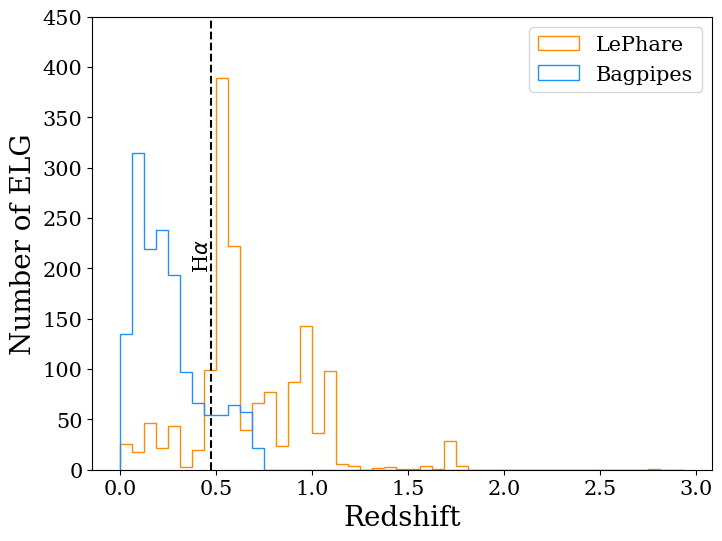

In [20]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(Hlep['Z_BEST'], bins =bins, histtype ='step', alpha = 1, 
         color = 'forestgreen',ec = 'darkorange', label = 'LePhare')

ax.hist(Hbag['redshift_50'], bins =bins, histtype ='step', alpha = 1, 
         color = 'slategray',ec = 'dodgerblue', label ='Bagpipes')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'k')
# #ax.axvspan(0.37, 0.63, alpha=0.2, color='dodgerblue')
ax.text(0.38, 200, r'H$\alpha$', size = 15, rotation='vertical')

# ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
# #ax.axvspan(0.70, 1.15, alpha=0.2, color='forestgreen')
# ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

# ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
# #ax.axvspan(1.45, 1.9, alpha=0.2, color='crimson')
# ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

#ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'k')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
#ax.text(2.5, 150, r'MgII?', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,450)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.legend()
plt.show()

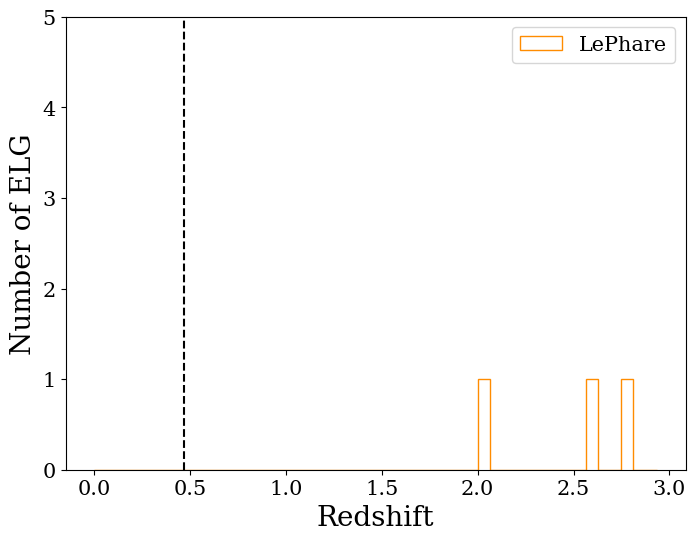

In [21]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(Hlep2['Z_BEST'], bins =bins, histtype ='step', alpha = 1, 
         color = 'forestgreen',ec = 'darkorange', label = 'LePhare')

# ax.hist(Hbag2['redshift_50'], bins =bins, histtype ='step', alpha = 1, 
#          color = 'slategray',ec = 'dodgerblue', label ='Bagpipes')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'k')
# #ax.axvspan(0.37, 0.63, alpha=0.2, color='dodgerblue')
#ax.text(0.38, 200, r'H$\alpha$', size = 15, rotation='vertical')

# ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
# #ax.axvspan(0.70, 1.15, alpha=0.2, color='forestgreen')
# ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

# ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
# #ax.axvspan(1.45, 1.9, alpha=0.2, color='crimson')
# ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

#ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'k')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
#ax.text(2.5, 150, r'MgII?', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,5)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.legend()
plt.show()

In [22]:
count = 0
mask = []
for i,z in enumerate(z_b):

    diff = (np.abs(z_b[i]/z_l[i]))
    if diff < 1.1 and diff > 0.9:
        count+=1
        mask.append(True)
    else:
        mask.append(False)


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [23]:
count

1484

In [24]:
count/(len(table))*100

31.581187486699296

In [30]:
def cuts_mult(coords, data_filters, hdr_filters, names_filters, size, field):

    #data_filters = datag,datar,datai,dataz,datay, datanb
    #hdr_filters = hdrg, hdrr, hdri, hdrz, hdry, hdrnb
    # el path en el cual guardaremos las imágenes
    path = os.path.join('Cutouts', str(field))
    sigmac = []
    
                
    for j in range(len(data_filters)):        
        aper = random_apers(data_filters[j])
        sums = aper['aperture_sum']
        clipped = sigma_clipped_stats(sums, sigma=2)
        sigmac_ = clipped[2]
        sigmac.append(sigmac_)

    print(sigmac)

    names = get_names(coords)  # función amanda

    for i in range(len(coords)):

        path_N = os.path.join(path, names[i])

        fig, ax = plt.subplots(1, 6, figsize=(20, 8))

        for x, data in enumerate(data_filters):
           # print(x,(x+1)//5, x-((x+1)//5 *5))
            m_wcs = WCS(hdr_filters[x])
            c = SkyCoord(coords[i][0], coords[i][1], frame=FK5, unit="deg")
            recorte = Cutout2D(
                data, c, (size*u.arcsec, size*u.arcsec), wcs=m_wcs)
            im = (recorte.data)
#ax[(x)//5, x-((x)//5 * 5)]
            ax[x].imshow(im, origin='lower', interpolation='nearest',
                                              cmap='Greys', vmin=-1*sigmac[x], vmax=3*sigmac[x])  # , norm = norm)
            ax[x].scatter((len(recorte.data)/2),
                                               len(recorte.data)/2-5, marker='|', color='red', s=300, linewidth = 5)
            ax[x].scatter((len(recorte.data)/2) -5
                                        , len(recorte.data)/2, marker='_', color='red', s=300, linewidth = 5)
            ax[x].set_title(names_filters[x], fontsize=18)
            ax[x].axis('off')

#         ax[1, 1].set_axis_off()
#         ax[1, 2].set_axis_off()
#         ax[1, 3].set_axis_off()
#         ax[1, 4].set_axis_off()

        #plt.savefig(path_N, transparent=False, facecolor='white')
        fig.tight_layout()
        plt.show()
        
#         fig, ax= plt.subplots(figsize =(12,8))
#         pivot = np.array([4770.80, 6371.30, 7774.20, 9157.90, 9640.00, 9886.30]) #g,r,i,z,NB,y,
#         lines = np.array([flux_filters[0][i],flux_filters[1][i],flux_filters[2][i], flux_filters[3][i],flux_filters[4][i],flux_filters[5][i]])
#         ax.scatter(pivot[0], flux_filters[0][i], label = 'g')
#         ax.scatter(pivot[1], flux_filters[1][i], label = 'r')
#         ax.scatter(pivot[2], flux_filters[2][i], label = 'i')
#         ax.scatter(pivot[3], flux_filters[3][i], label = 'z')
#         ax.scatter(pivot[4], flux_filters[4][i], label = 'NB')
#         ax.scatter(pivot[5], flux_filters[5][i], label ='y')


#         ax.set_xlabel('Wavelenght')
#         ax.set_ylabel('Flux')
#         ax.plot(pivot,lines, linestyle = 'dashed', color = 'slategray')
        #plt.legend()
        #plt.show()
        # print(path_N)

    return

In [31]:
NSF_NB = fits.open('Fields/nsf_nb964_sci.fits')
data_NB = NSF_NB[1].data
hdr_NB = NSF_NB[1].header

NSF_g = fits.open('Fields/nsf_g_sci.fits')
data_g = NSF_g[1].data
hdr_g = NSF_g[1].header

NSF_r = fits.open('Fields/nsf_r_sci.fits')
data_r = NSF_r[1].data
hdr_r = NSF_r[1].header

NSF_i = fits.open('Fields/nsf_i_sci.fits')
data_i = NSF_i[1].data
hdr_i = NSF_i[1].header

NSF_z = fits.open('Fields/nsf_z_sci.fits')
data_z = NSF_z[1].data
hdr_z = NSF_z[1].header

NSF_y = fits.open('Fields/nsf_y_sci.fits')
data_y = NSF_y[1].data
hdr_y = NSF_y[1].header

In [32]:
info = pd.read_csv('Fields.txt', sep = " ")
info

Field      RA_min      RA_max    DEC_min    DEC_max
0  NSF_NB  313.917475  320.107303 -67.185343 -64.788871

In [39]:
aper =2

mask_H =  (1.59-ch < data_c['Z_BEST']) & (data_c['Z_BEST'] < 1.59+cl)
data_H = data_c[mask_H]

RA_ = data_H['ALPHA_J2000_1']
DEC_ = data_H['DELTA_J2000_1']

[0.23584065039929966, 0.24682517292882447, 0.3167018440206633, 0.5123908730061437, 0.9965970409490645, 1.035938800825206]


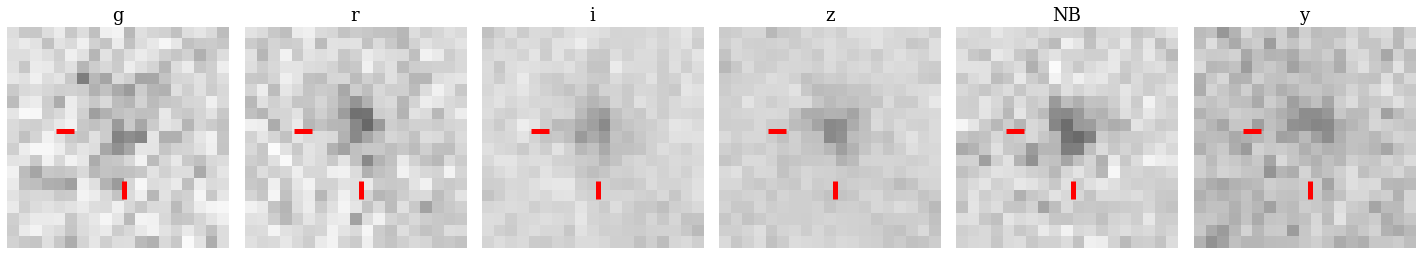

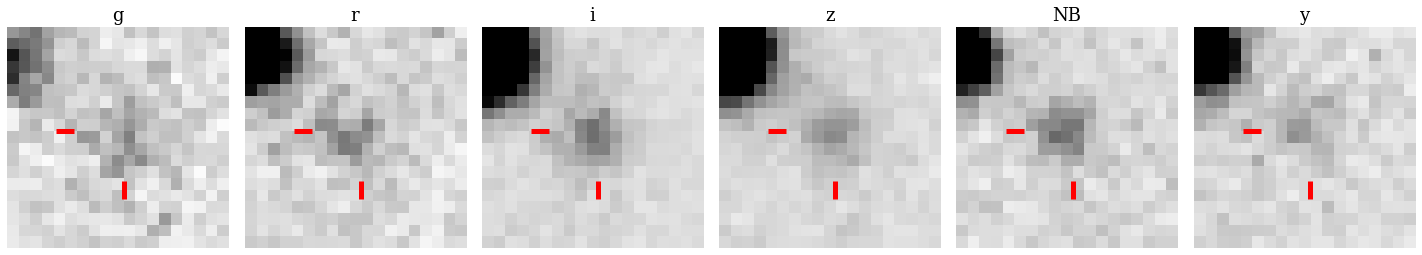

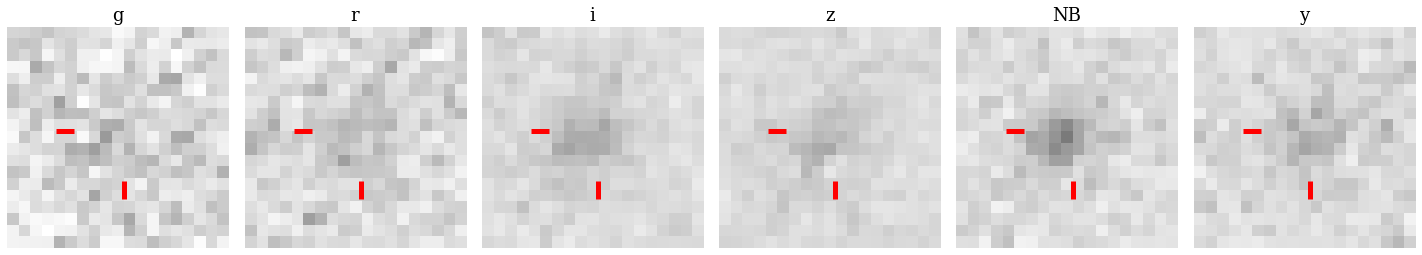

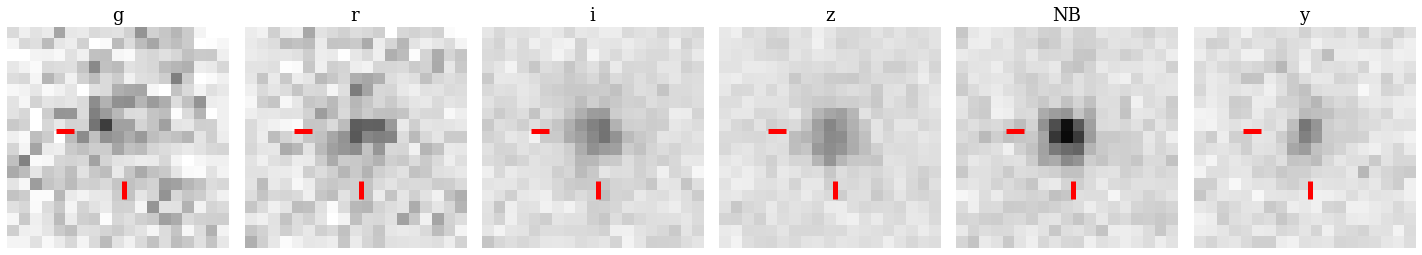

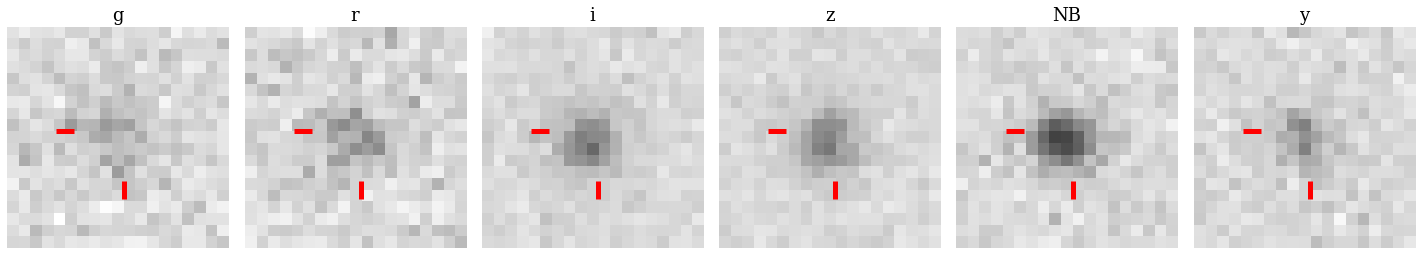

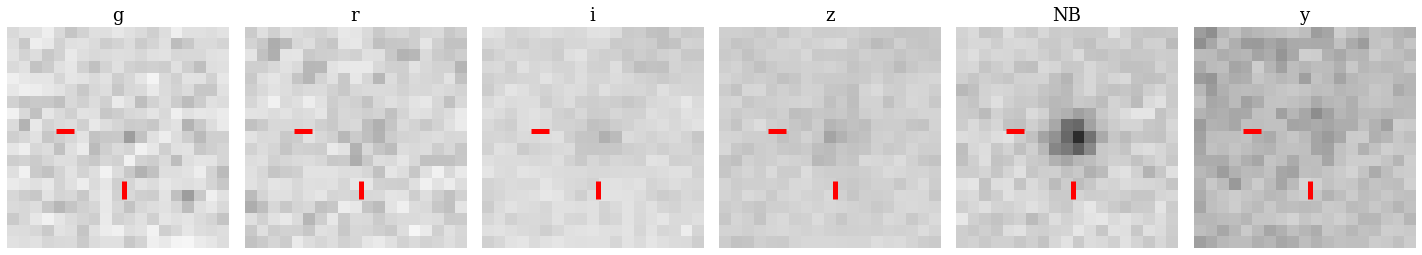

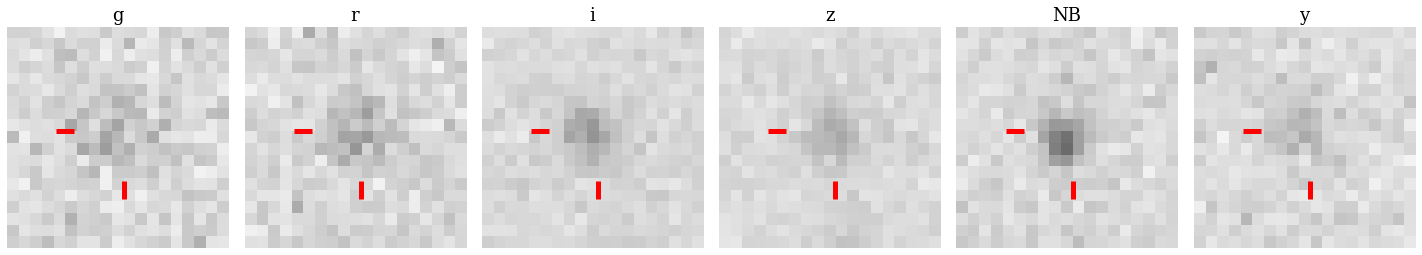

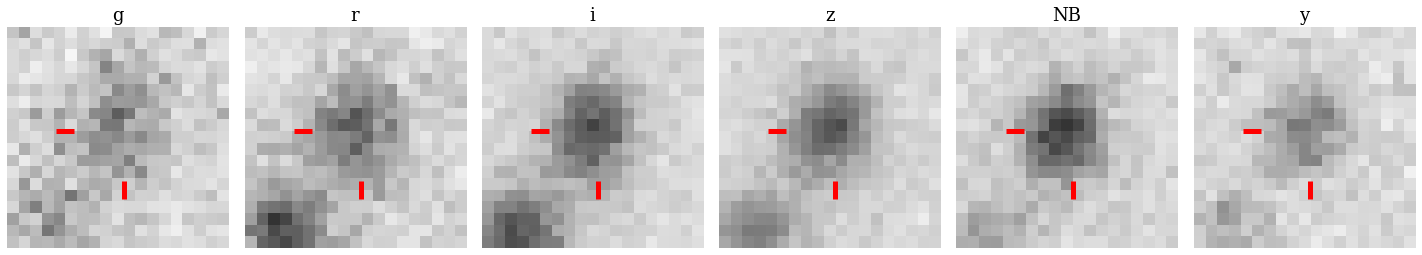

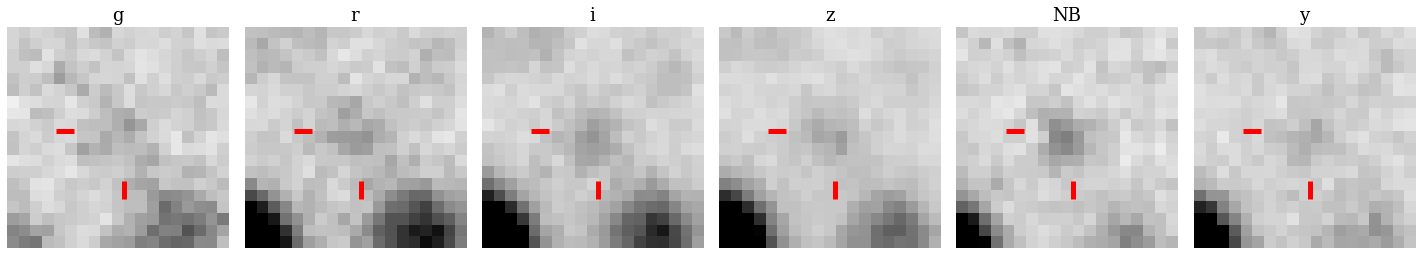

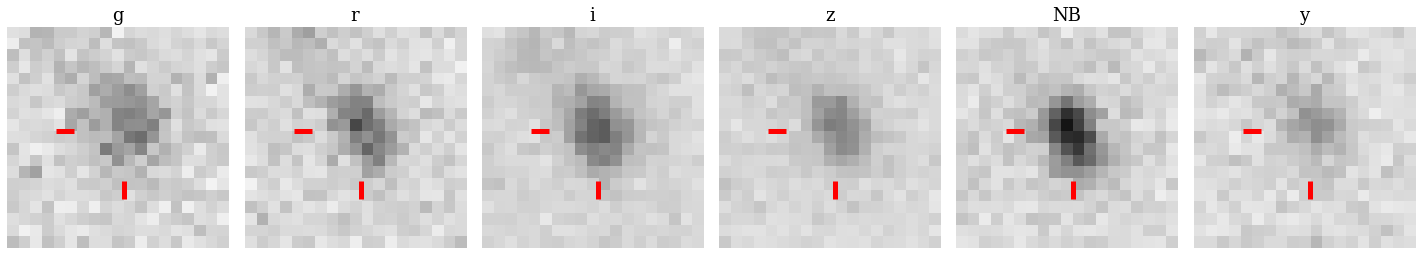

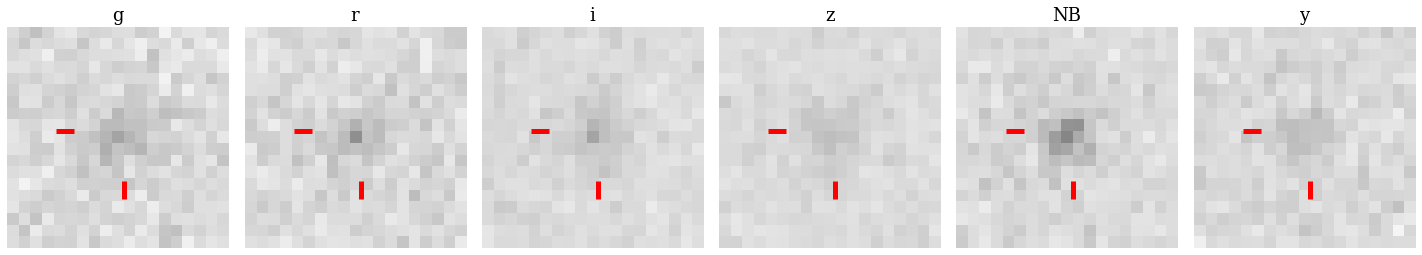

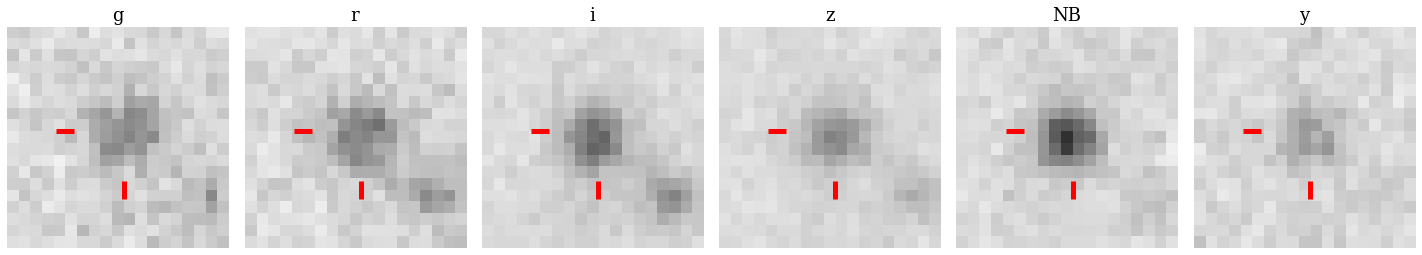

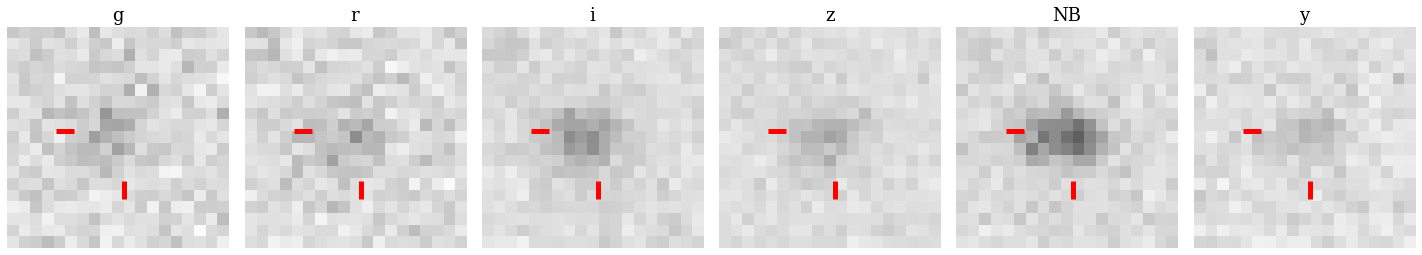

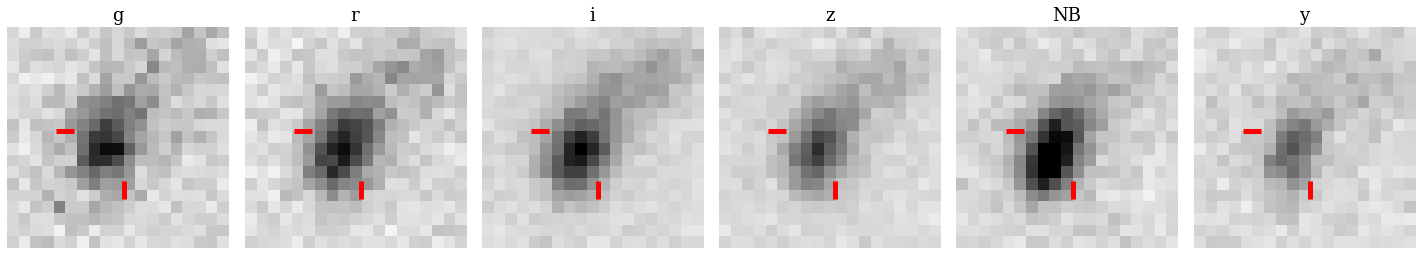

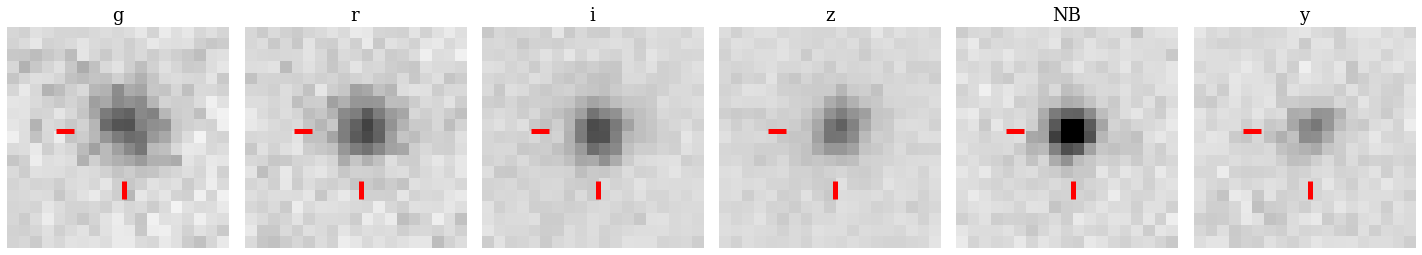

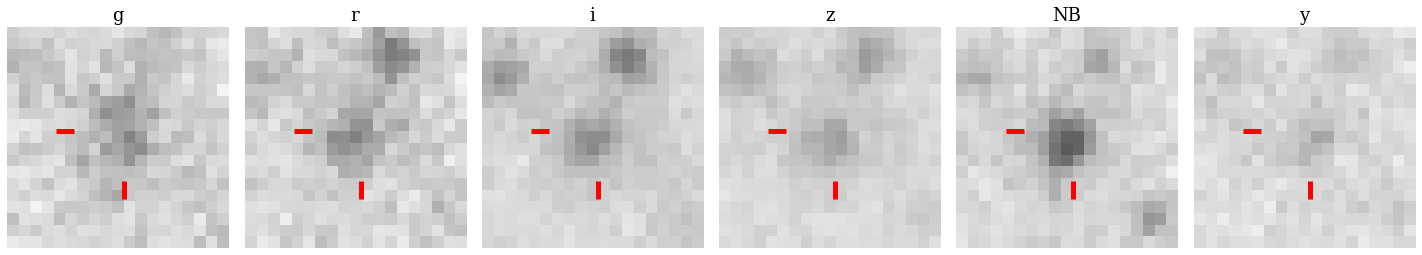

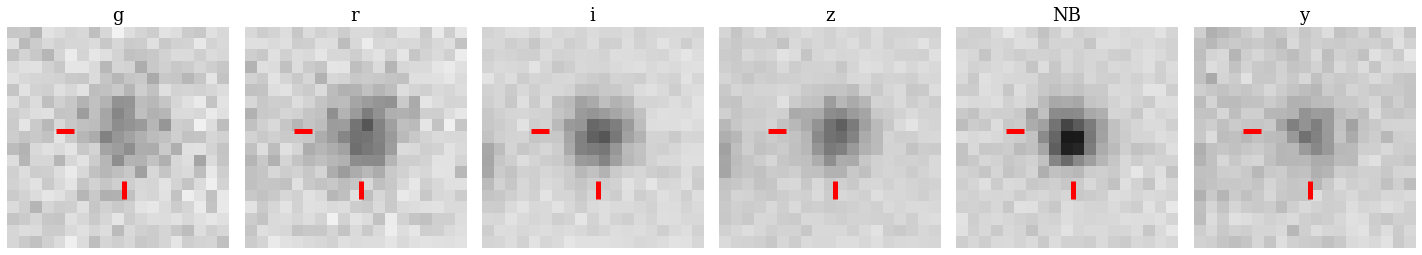

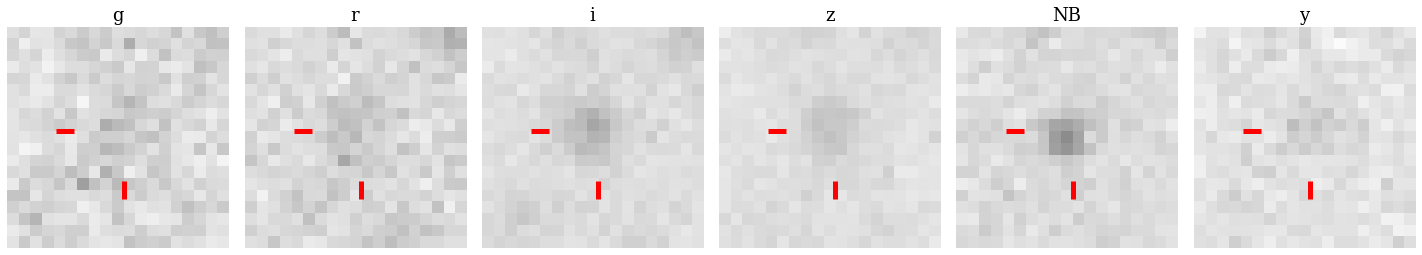

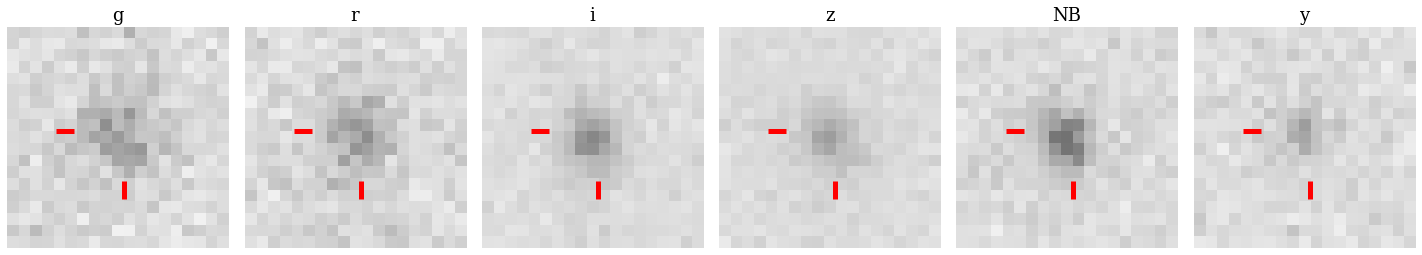

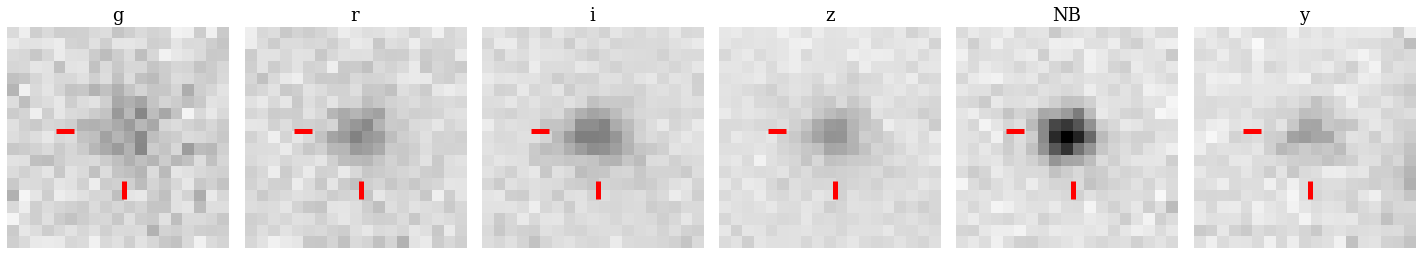

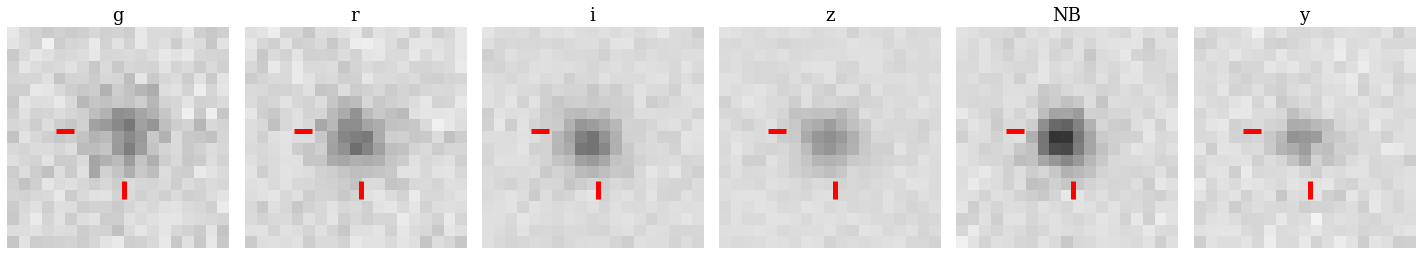

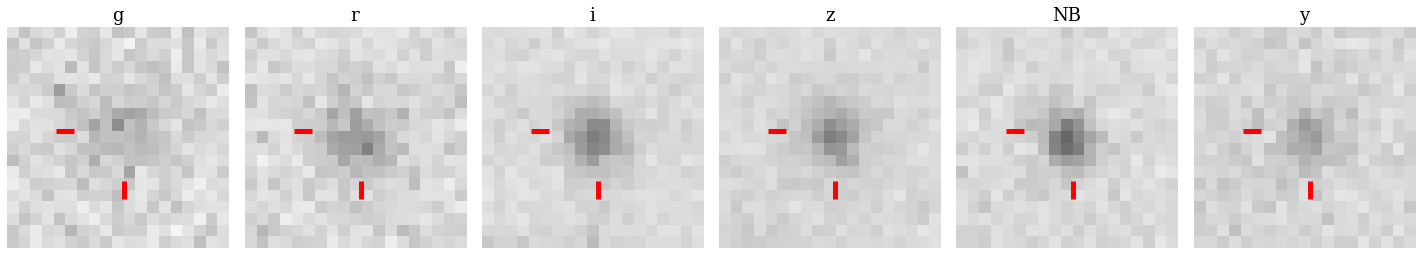

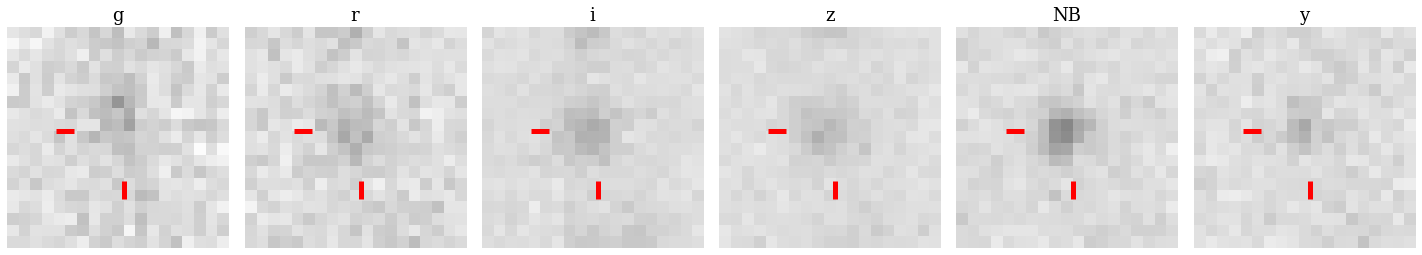

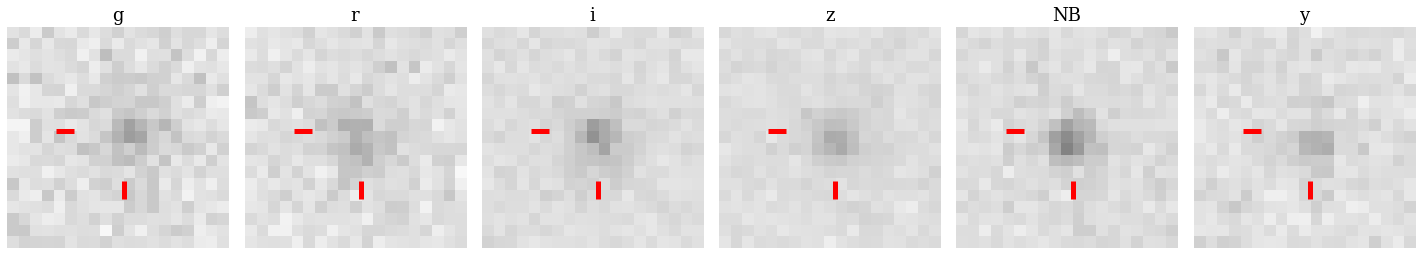

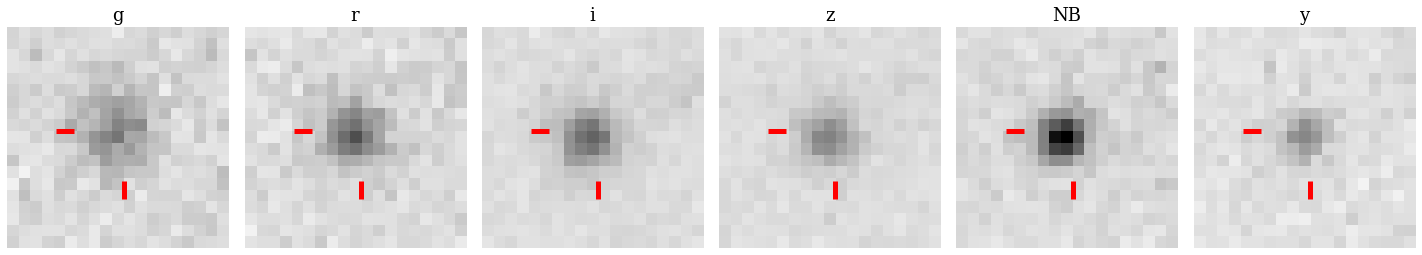

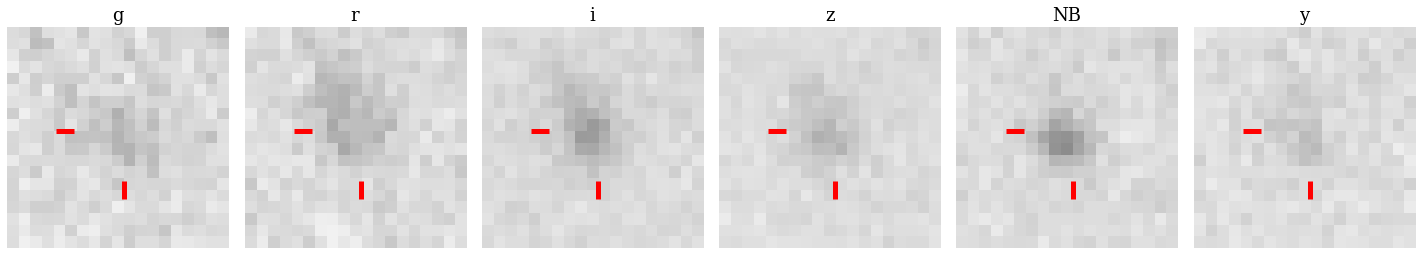

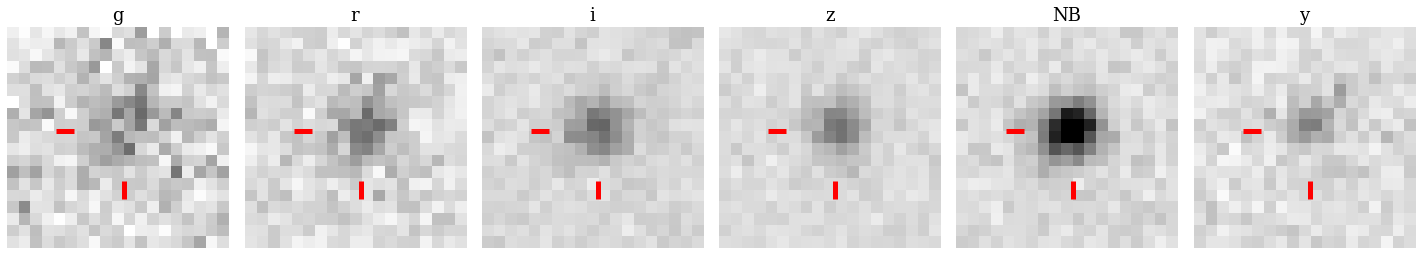

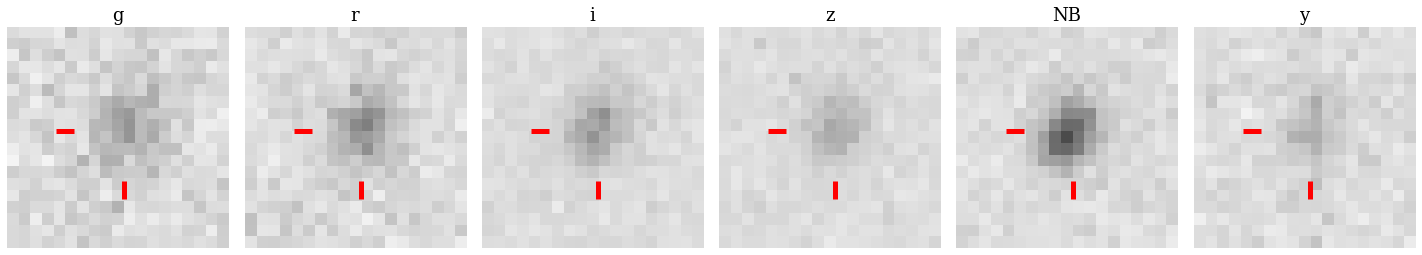

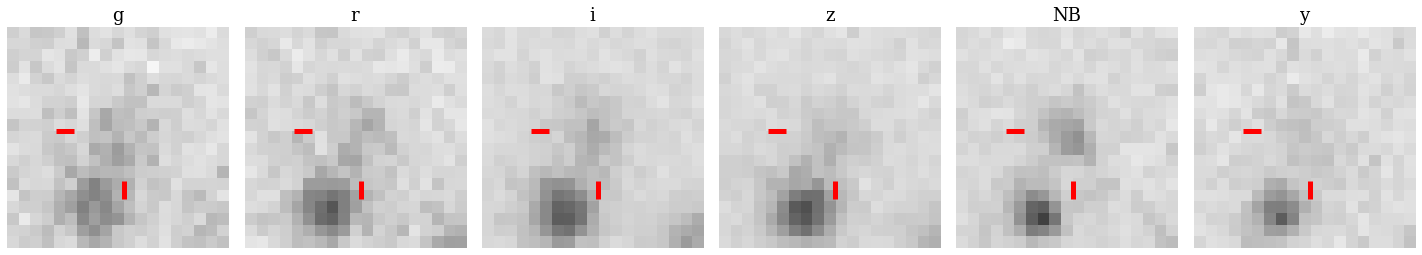

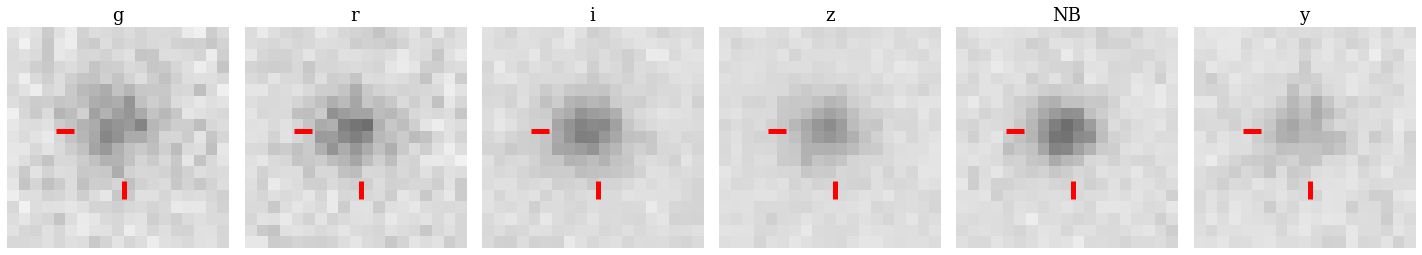

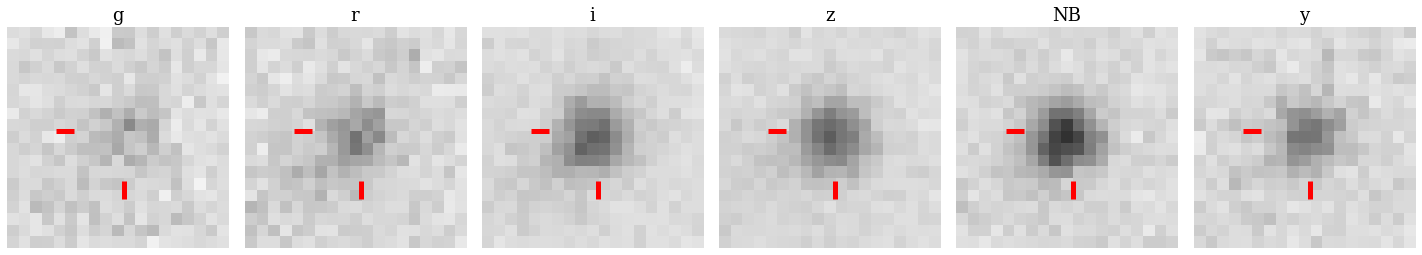

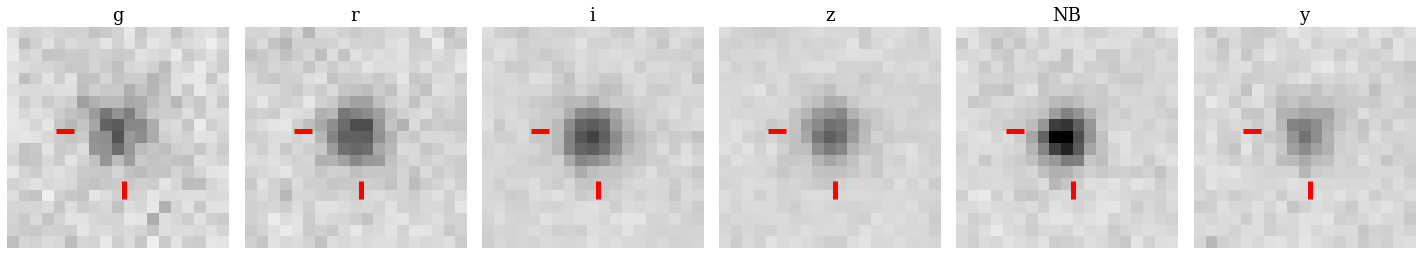

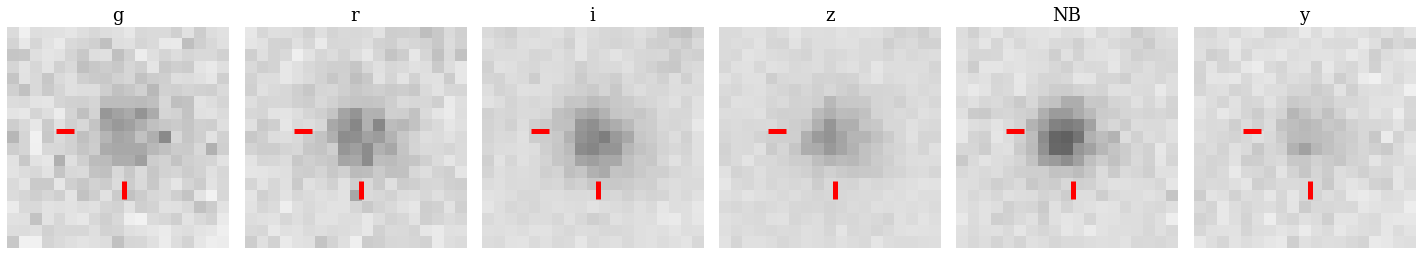

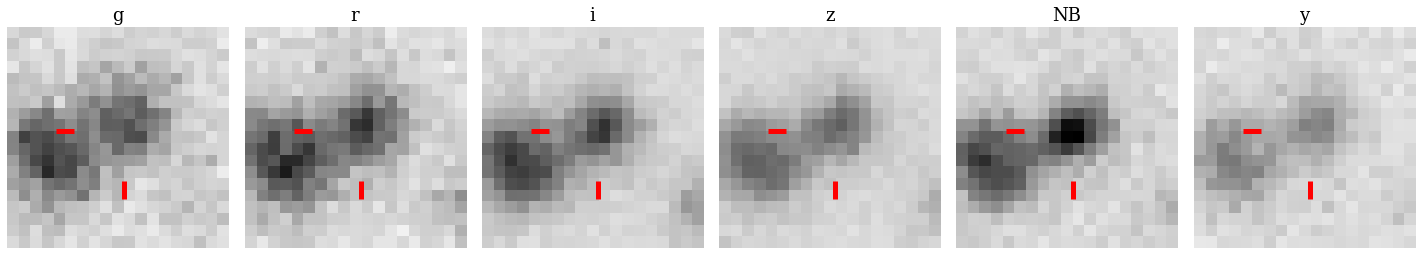

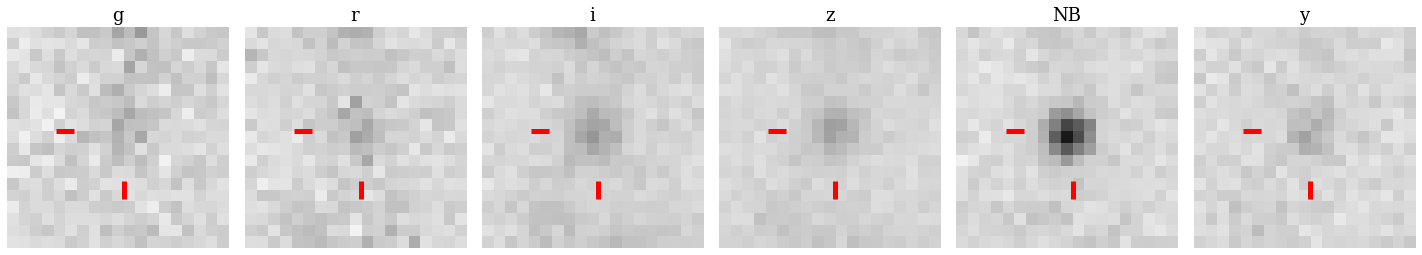

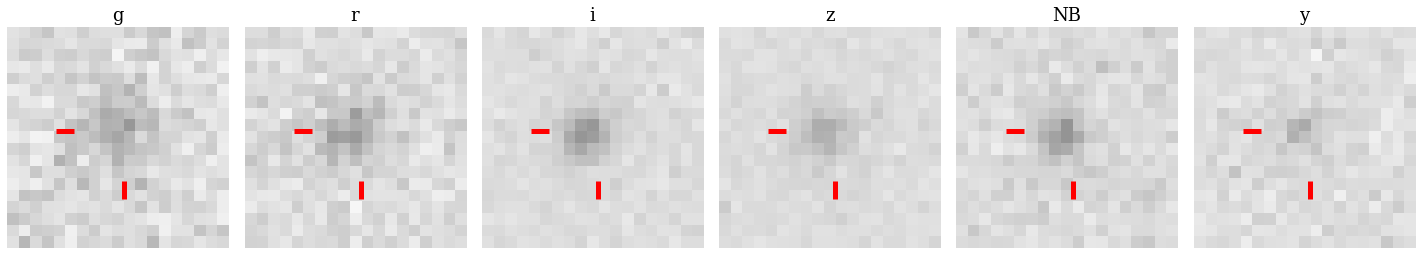

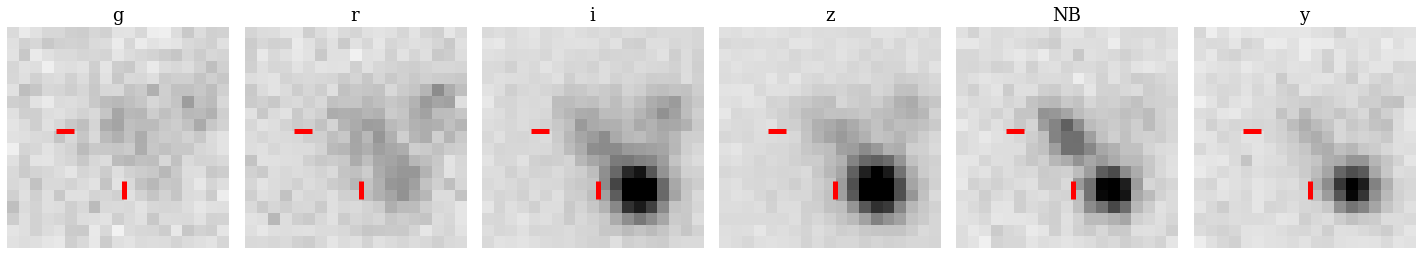

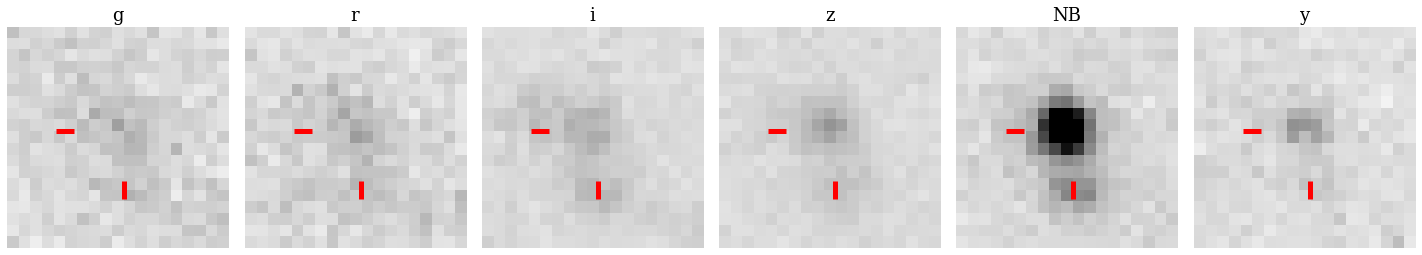

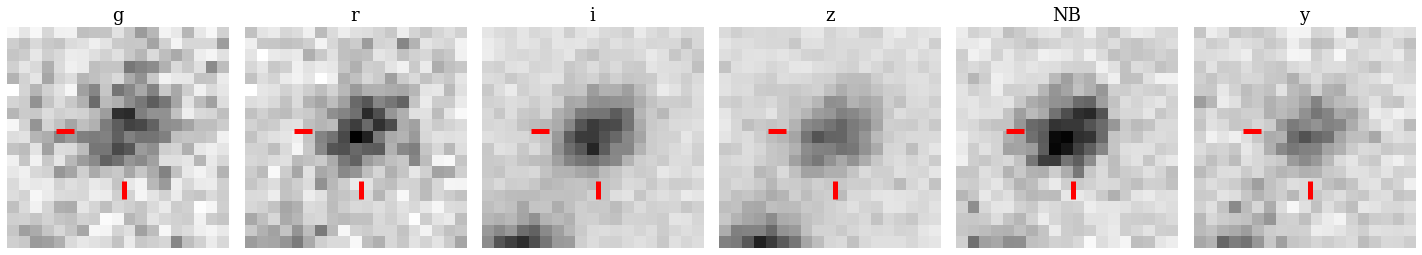

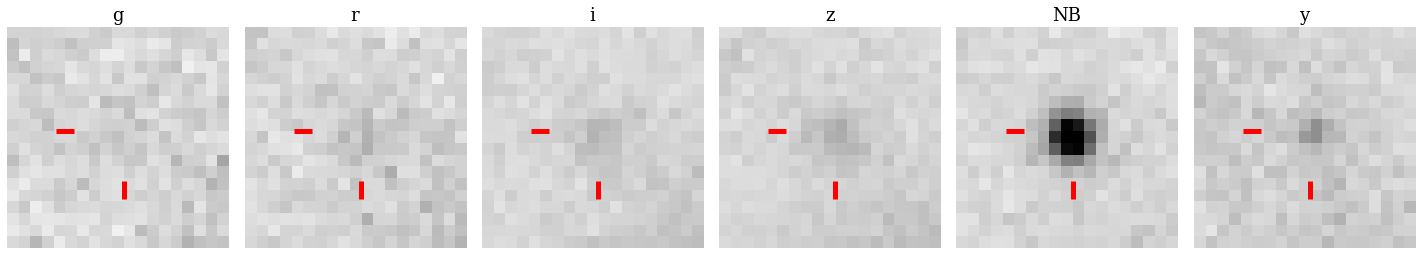

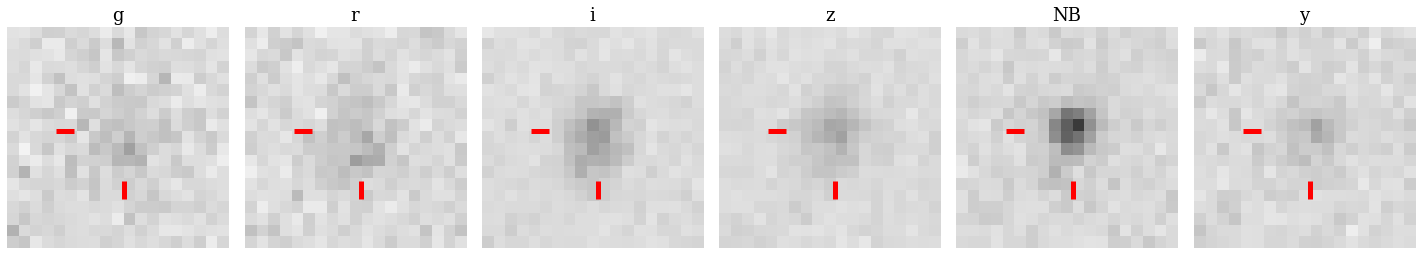

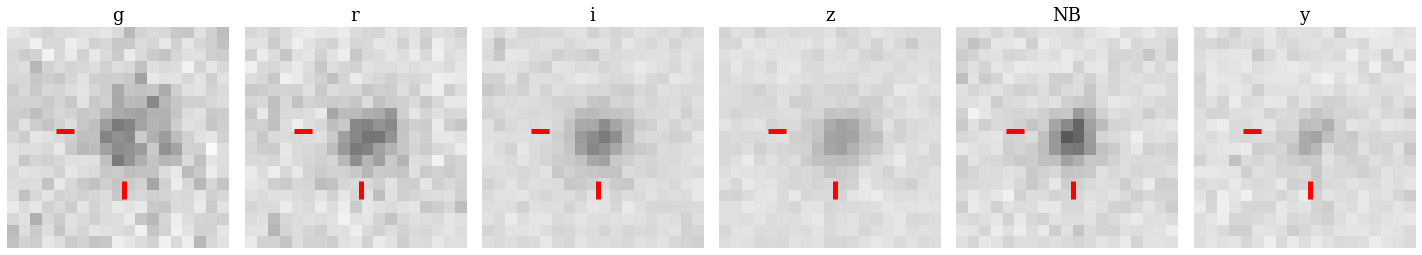

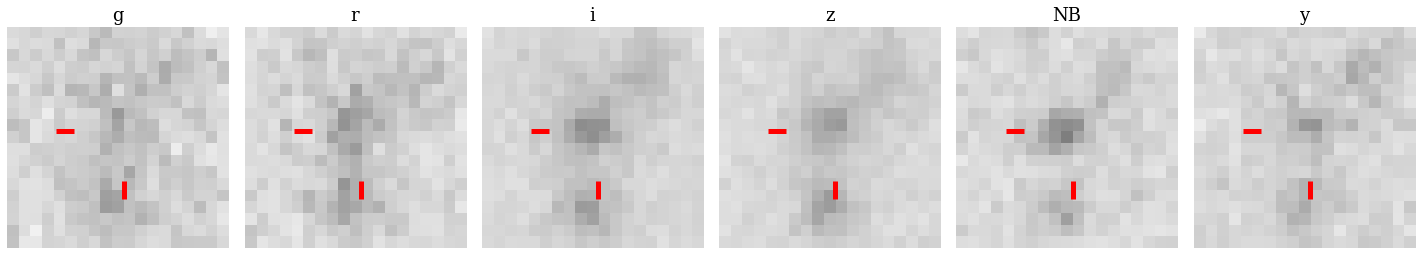

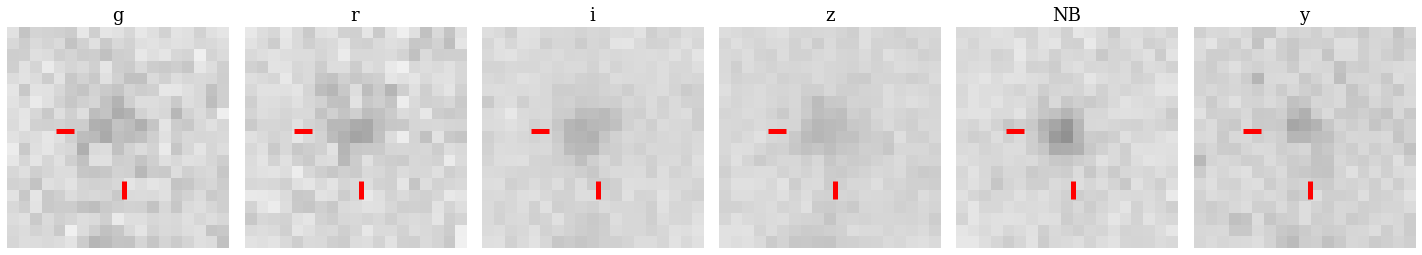

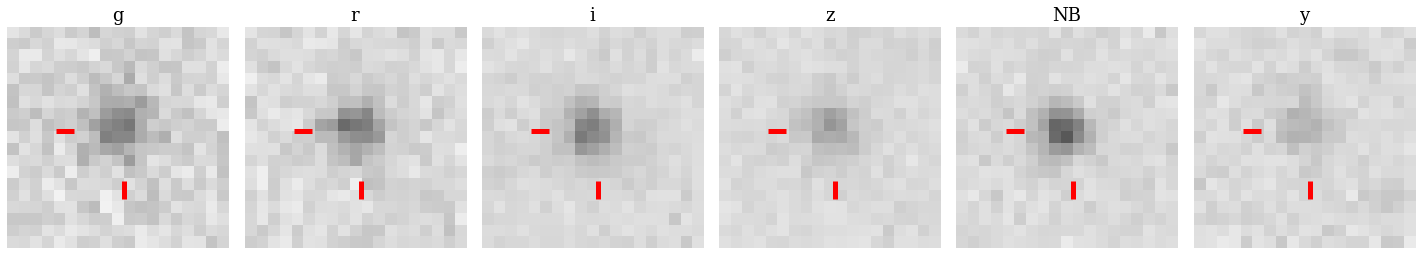

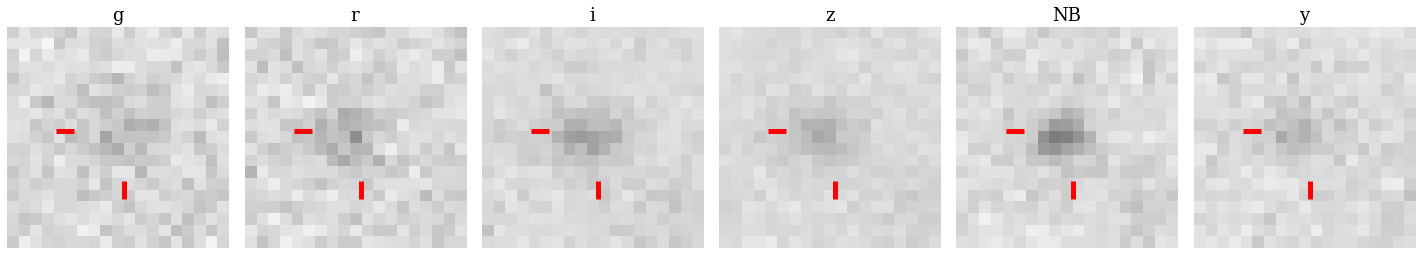

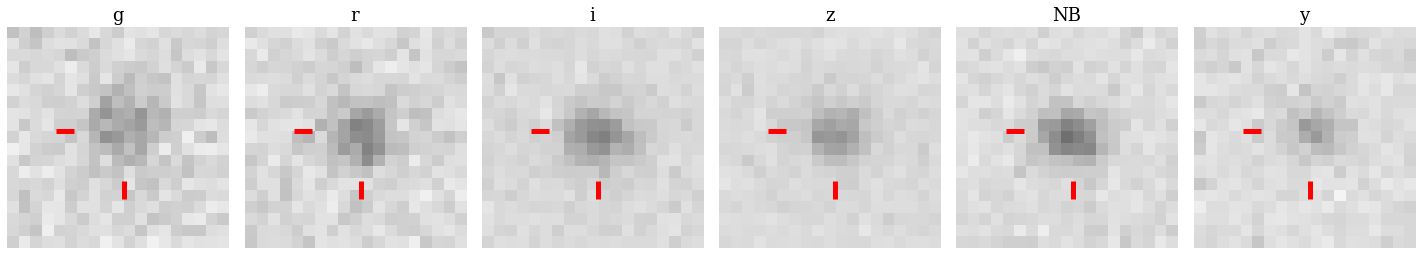

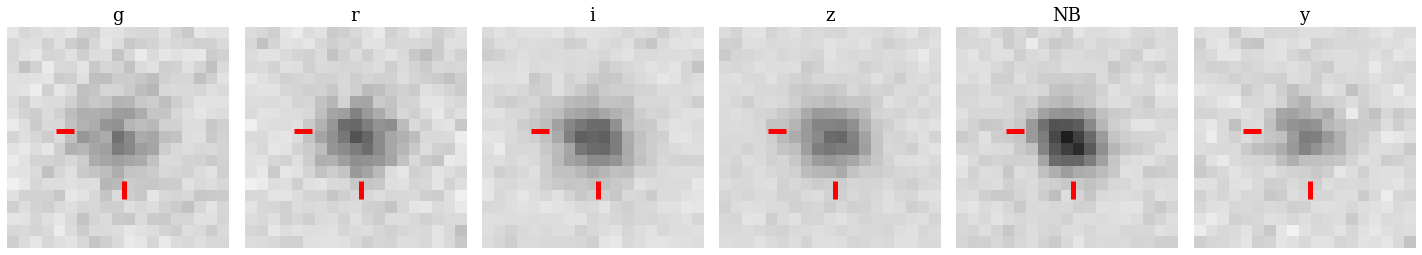

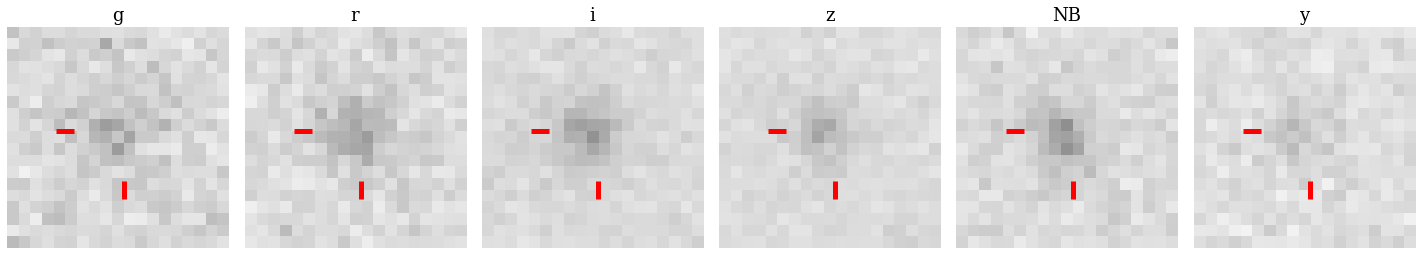

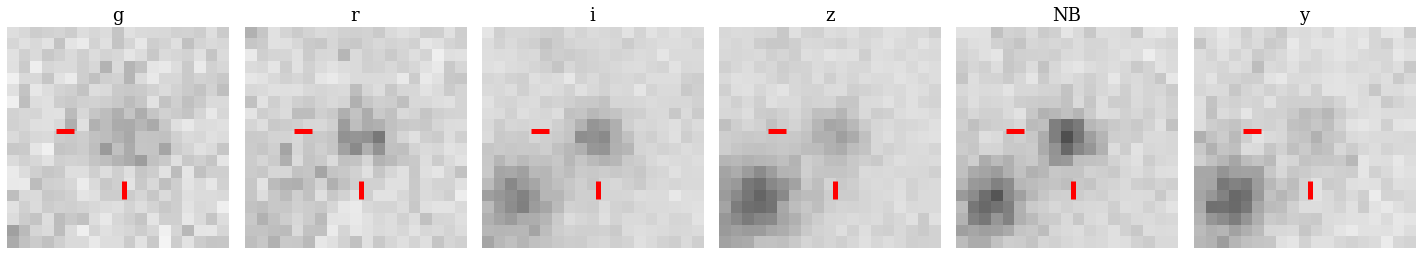

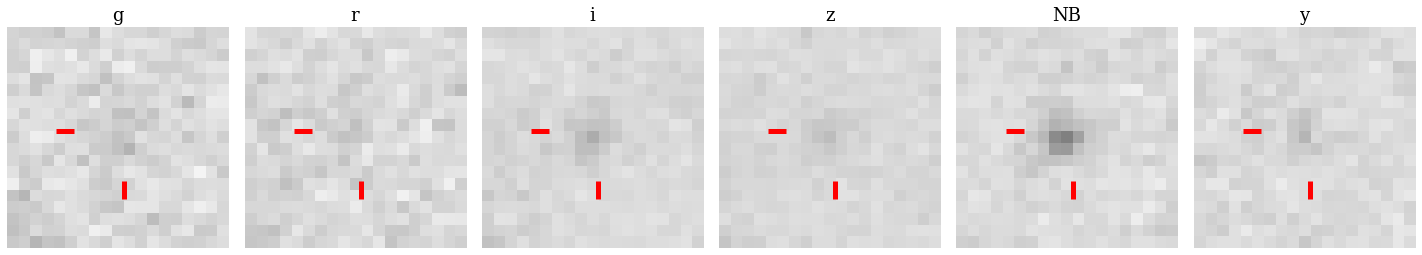

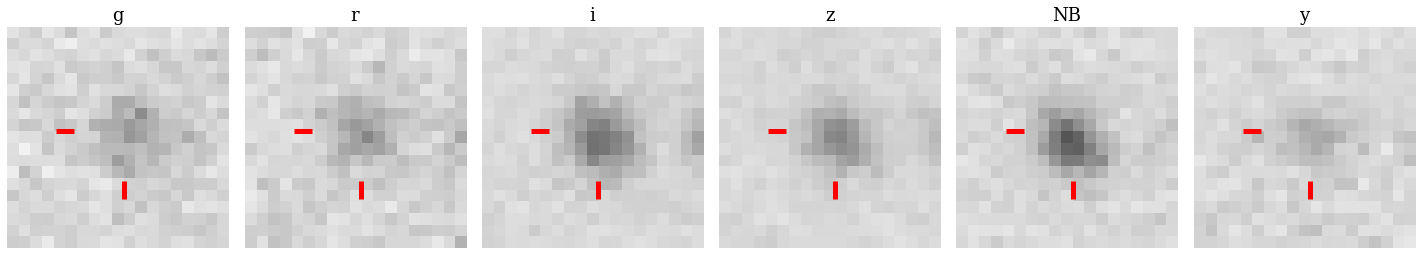

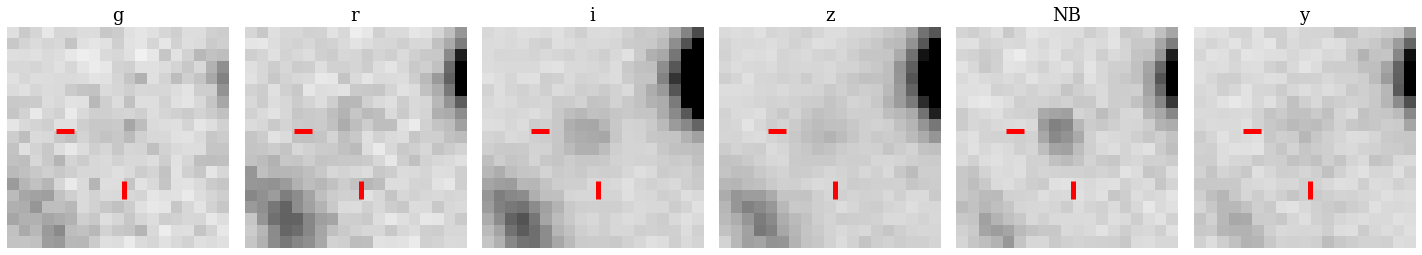

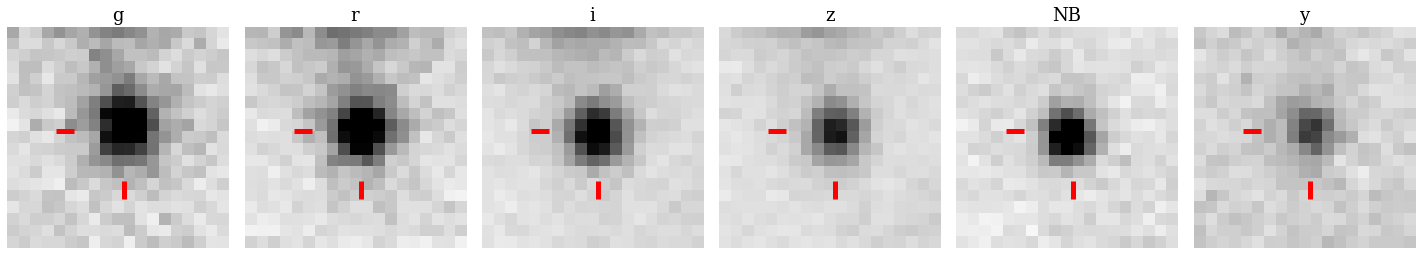

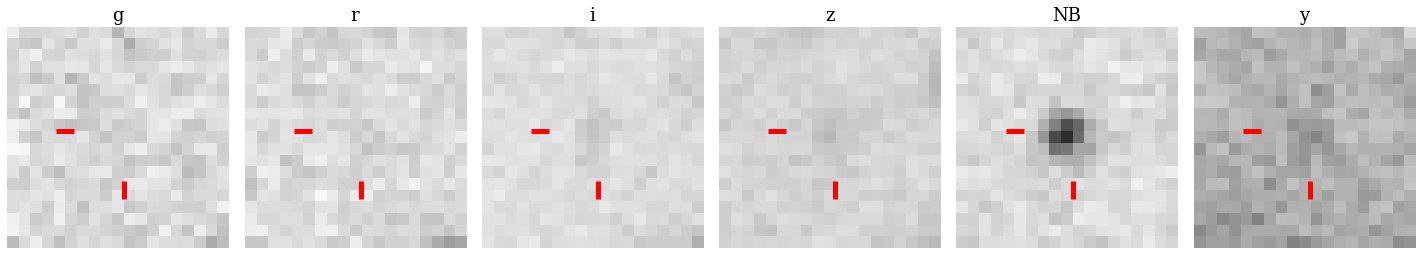

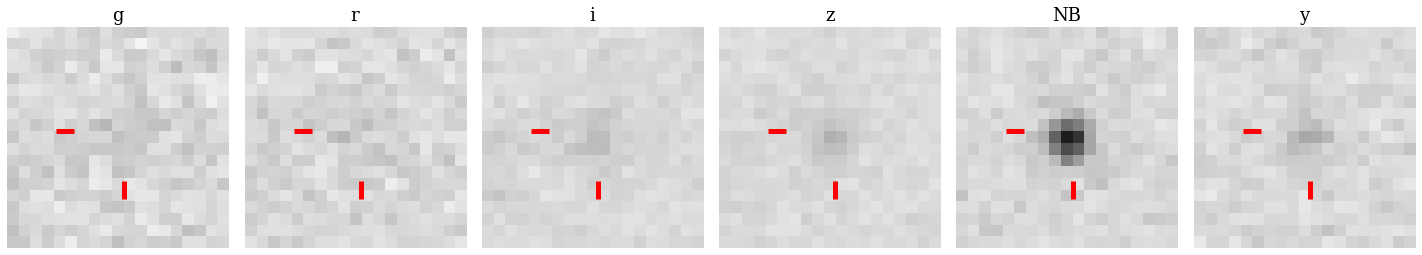

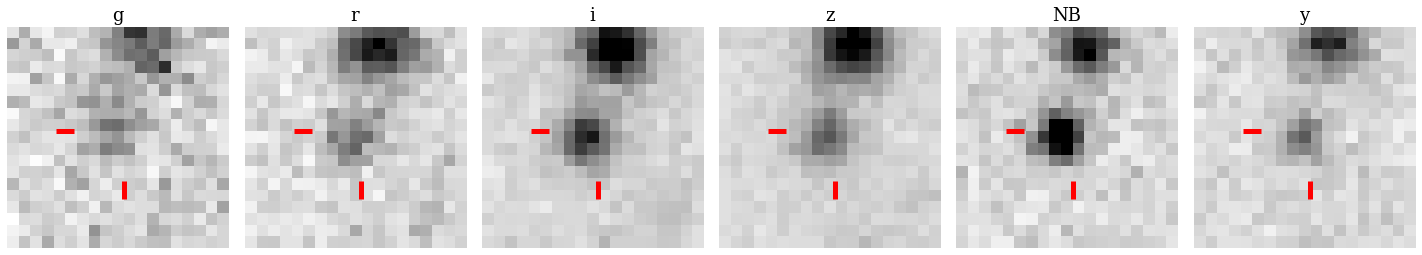

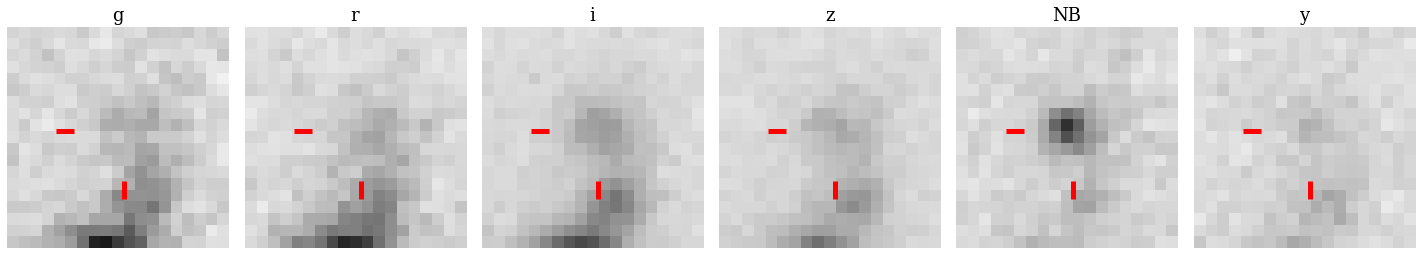

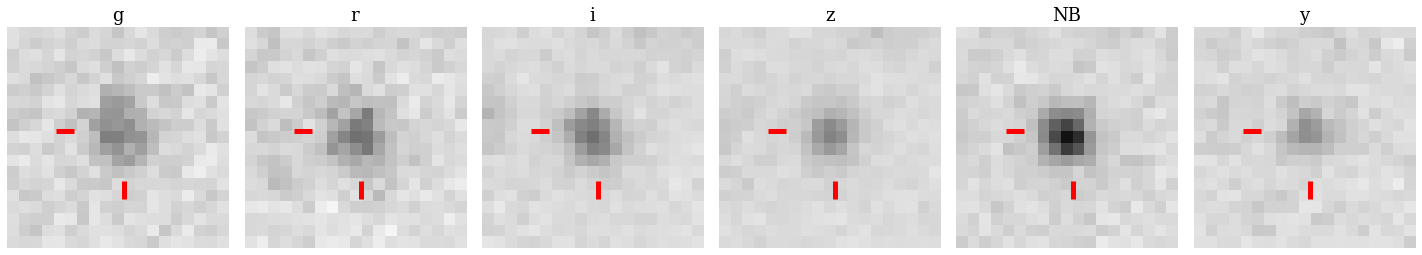

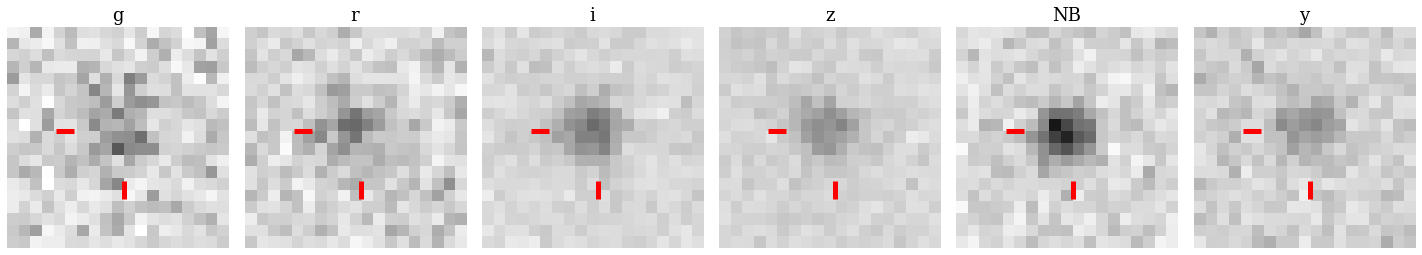

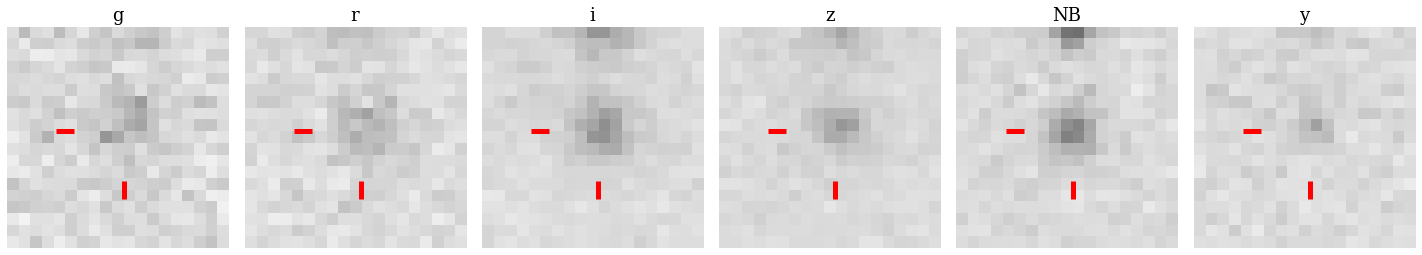

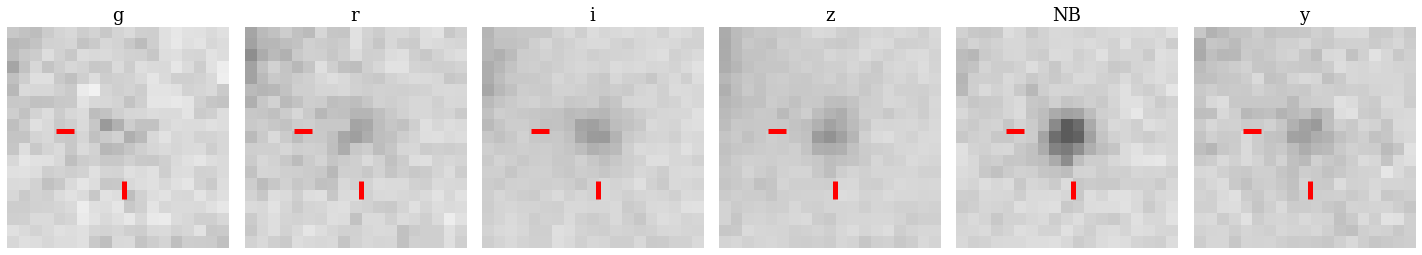

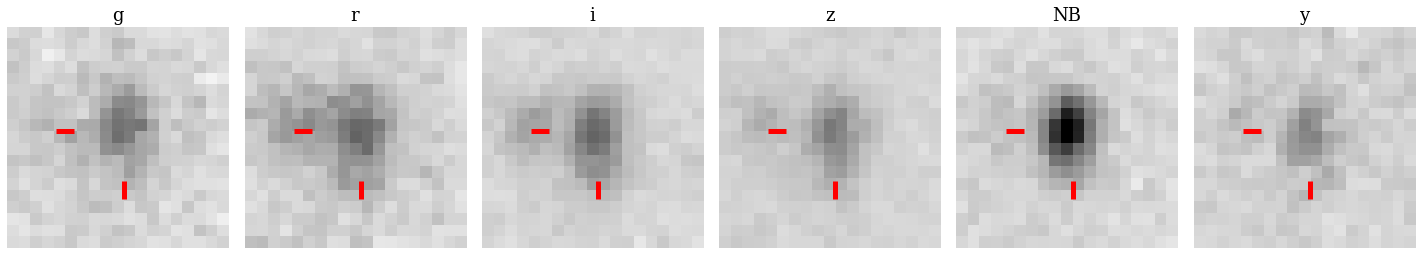

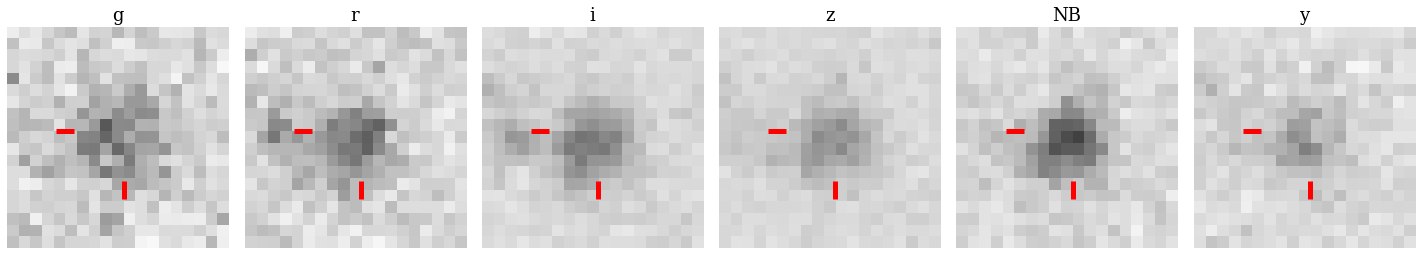

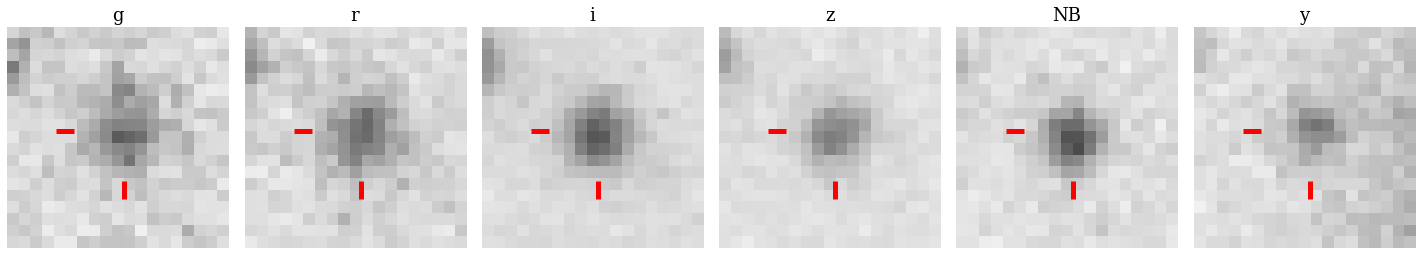

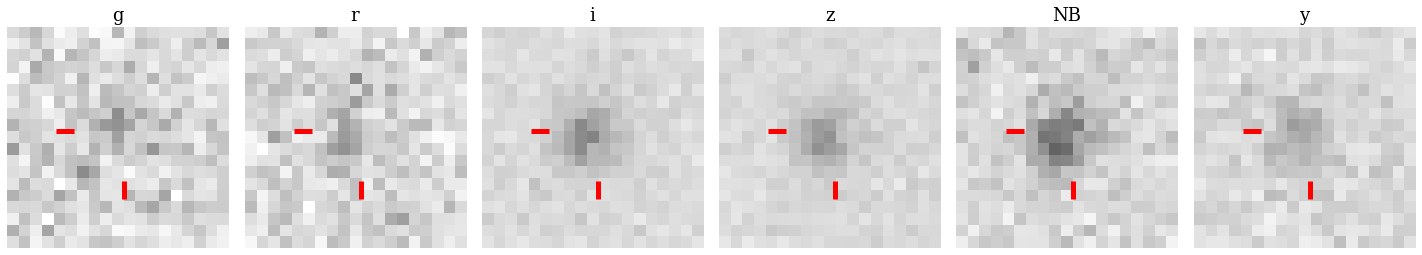

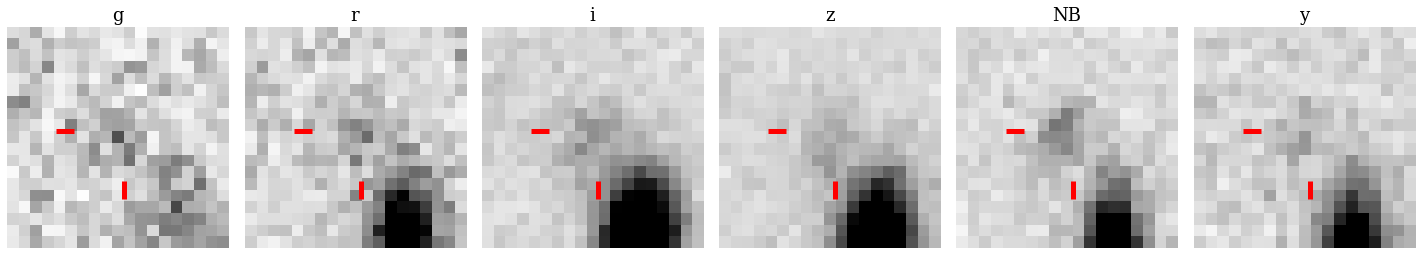

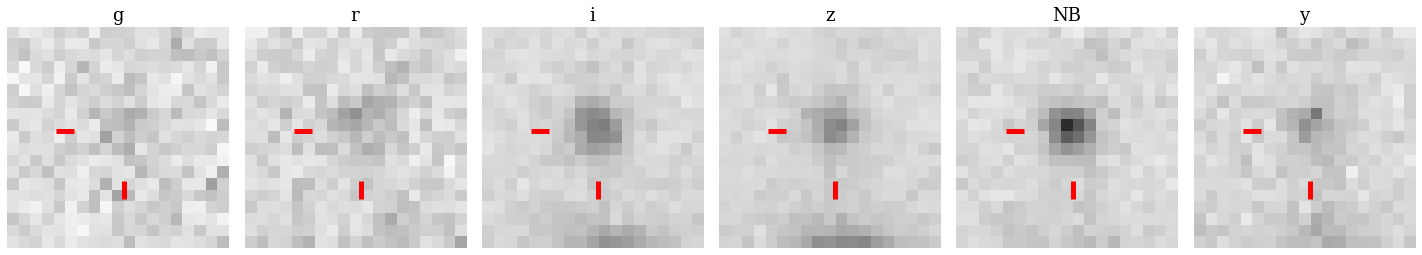

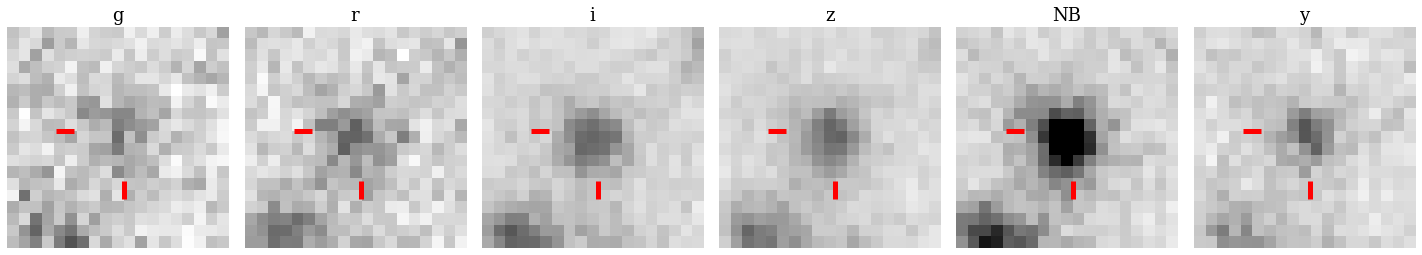

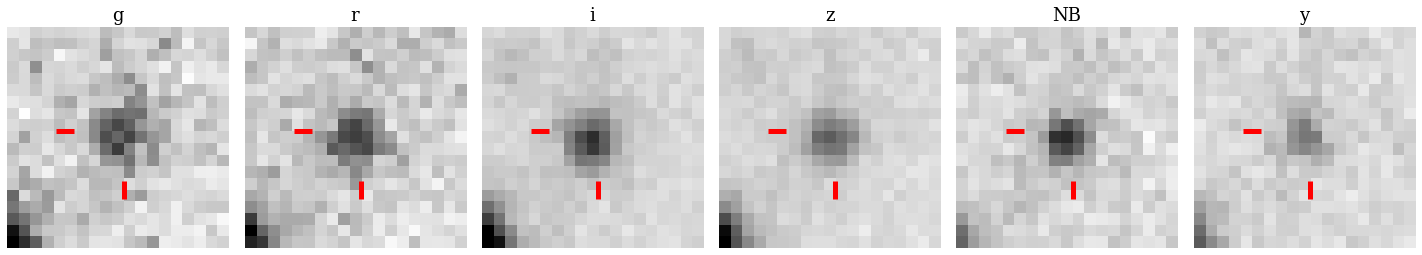

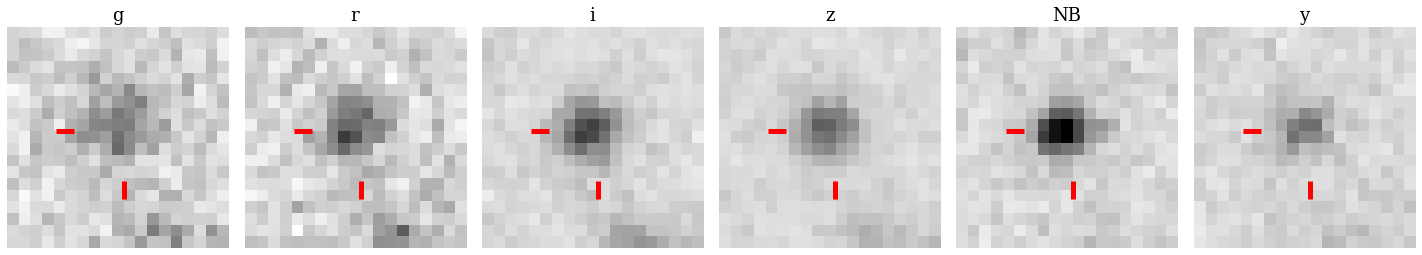

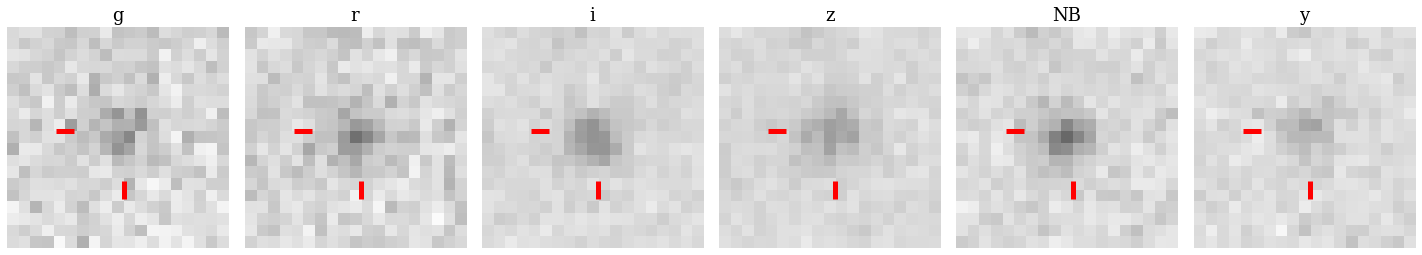

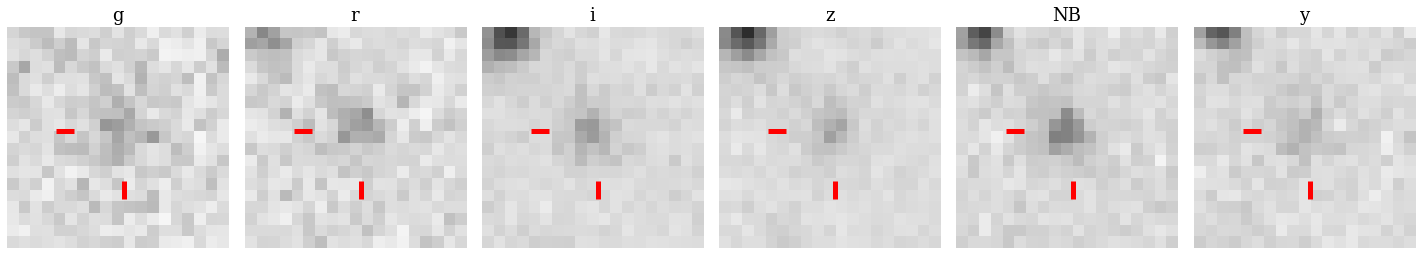

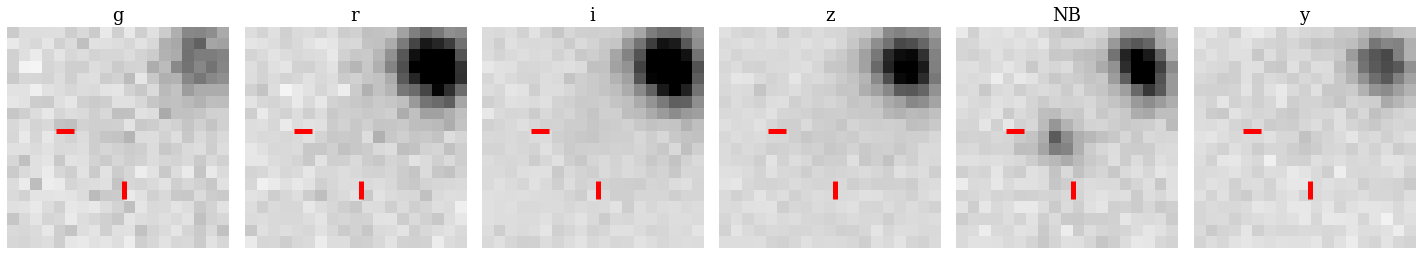

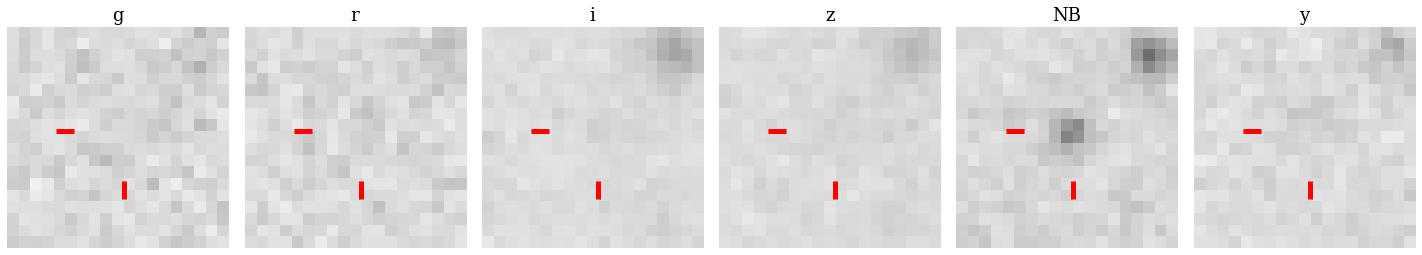

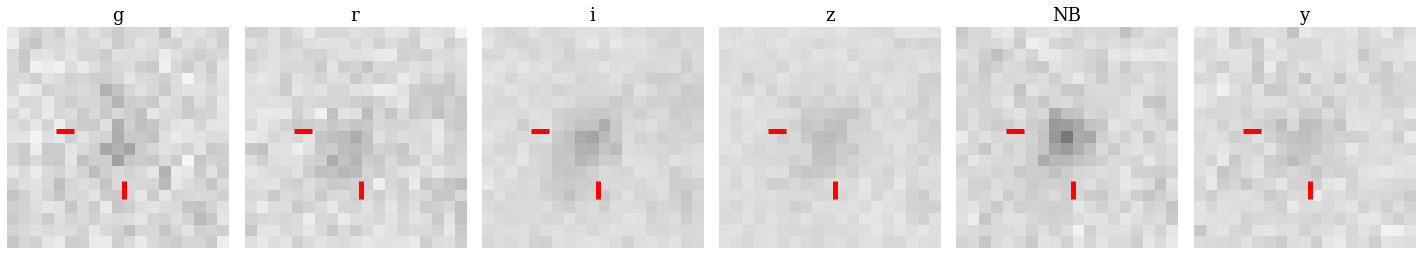

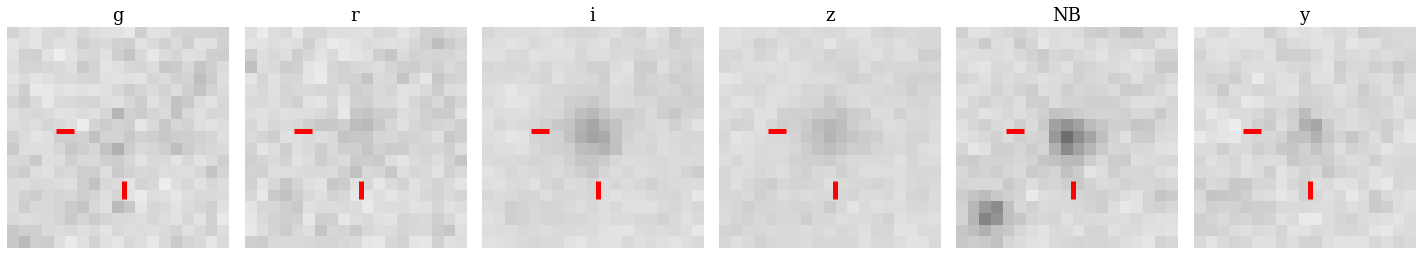

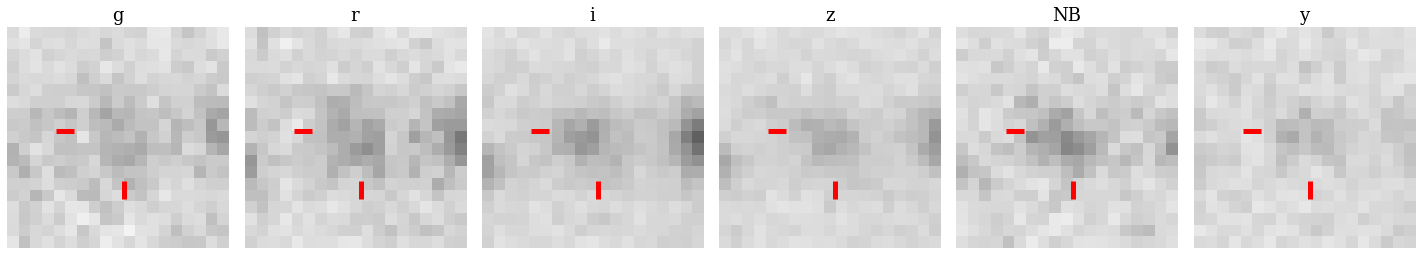

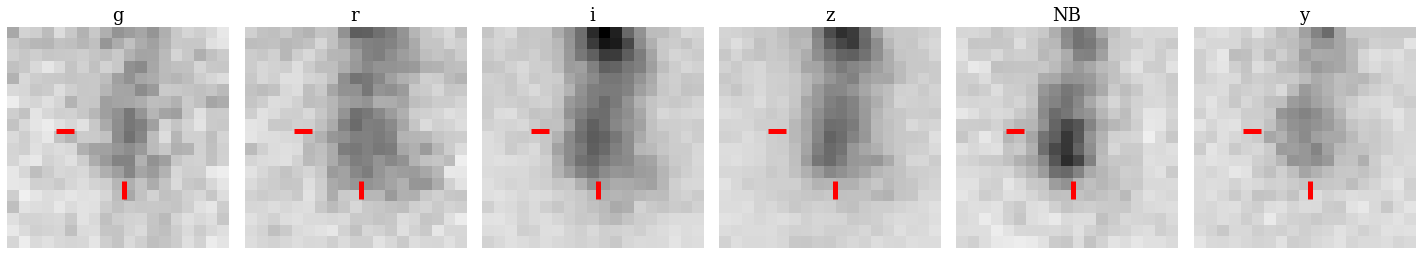

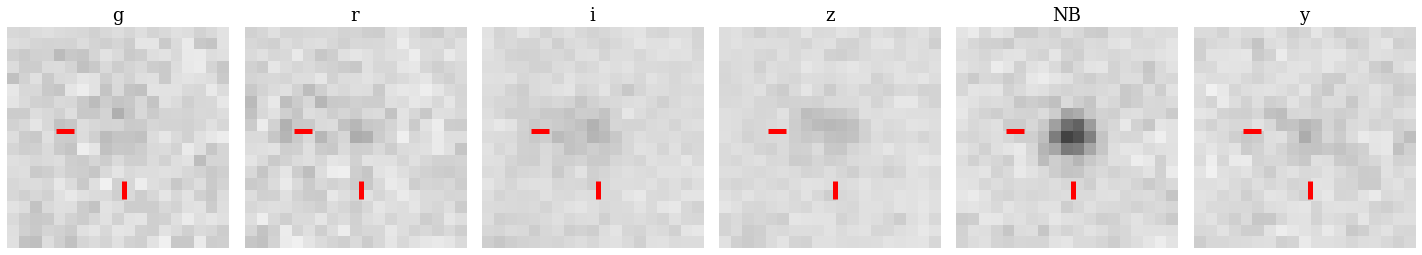

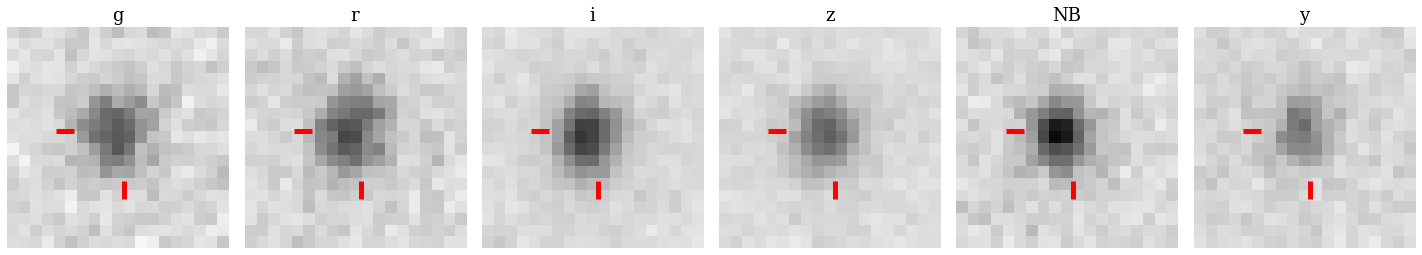

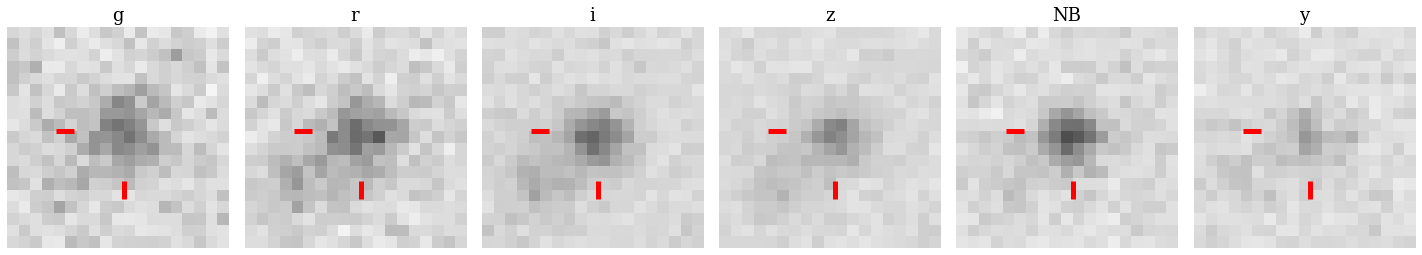

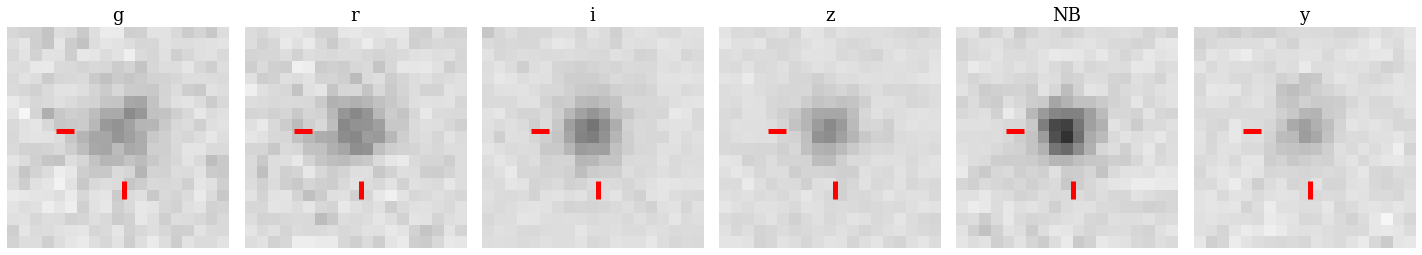

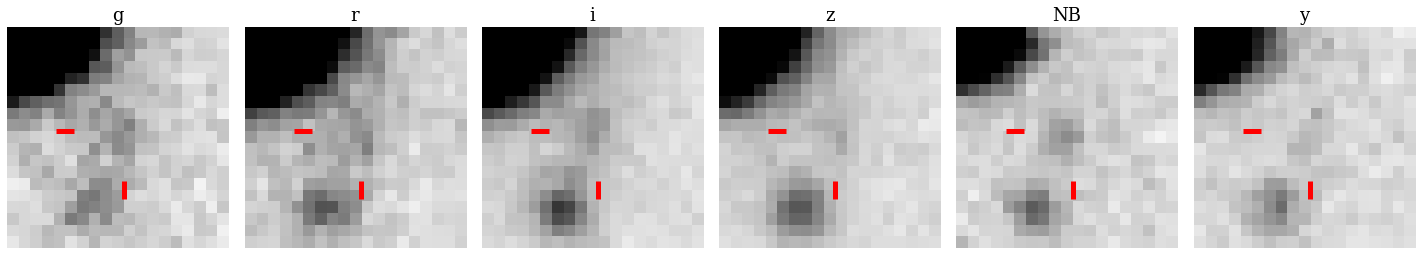

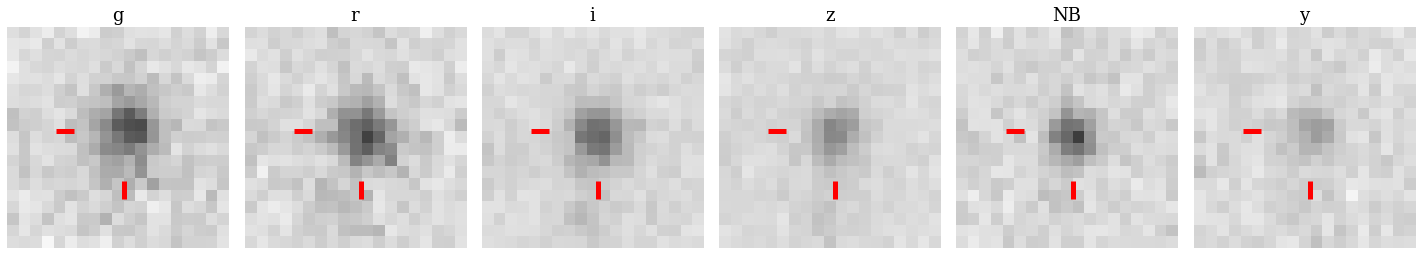

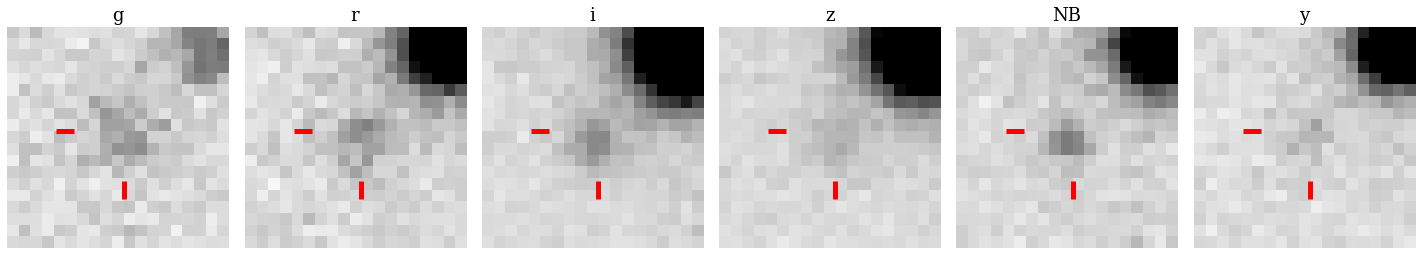

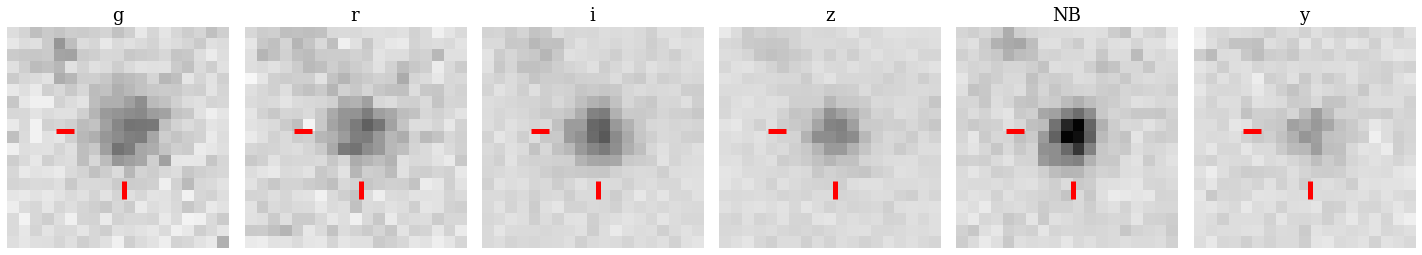

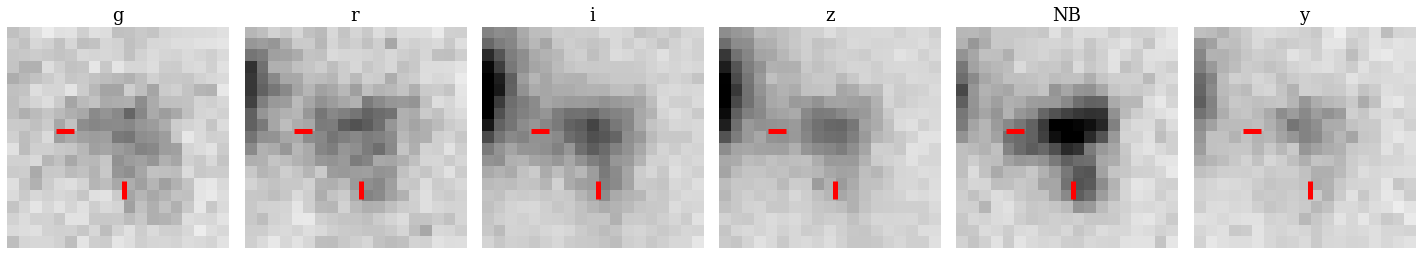

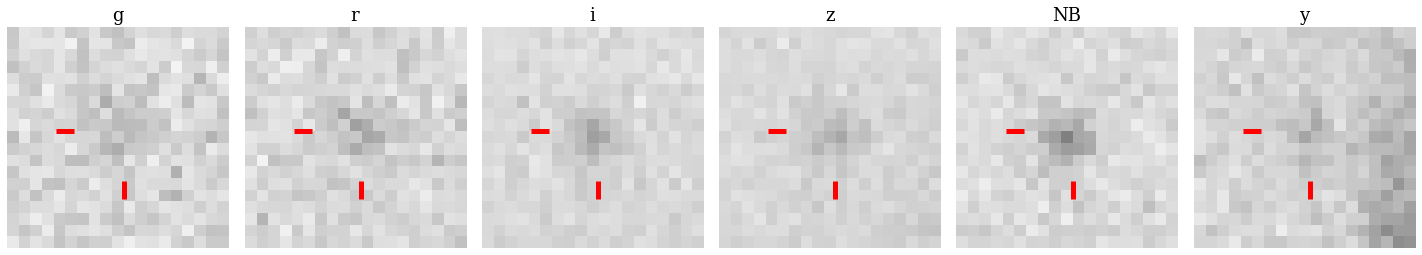

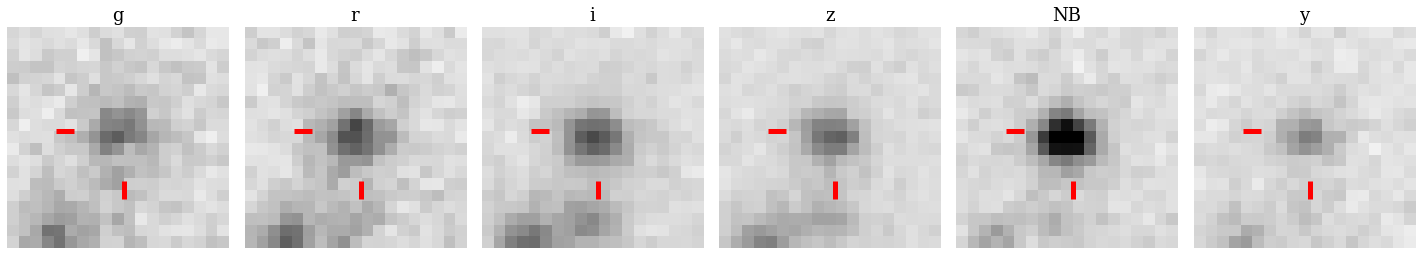

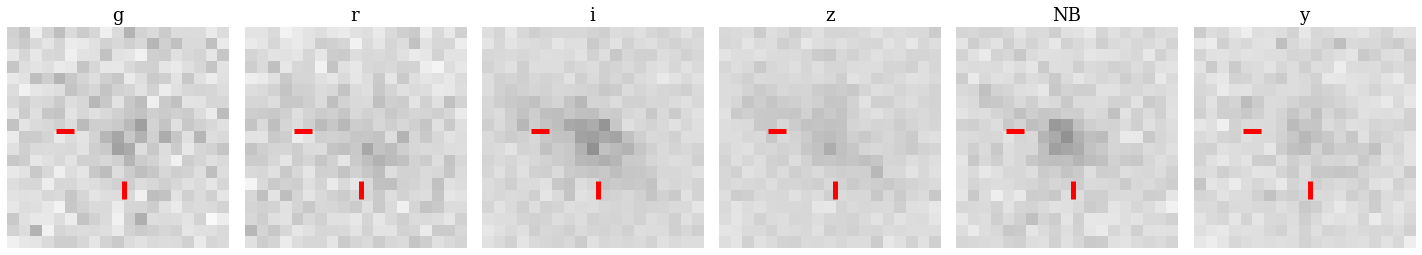

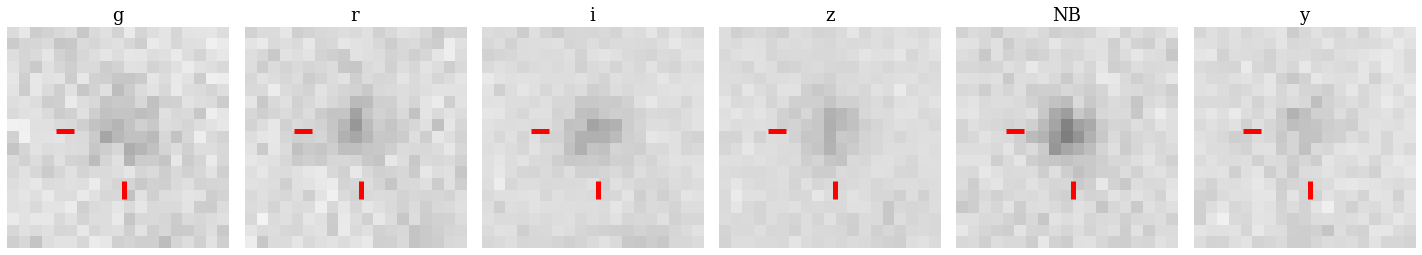

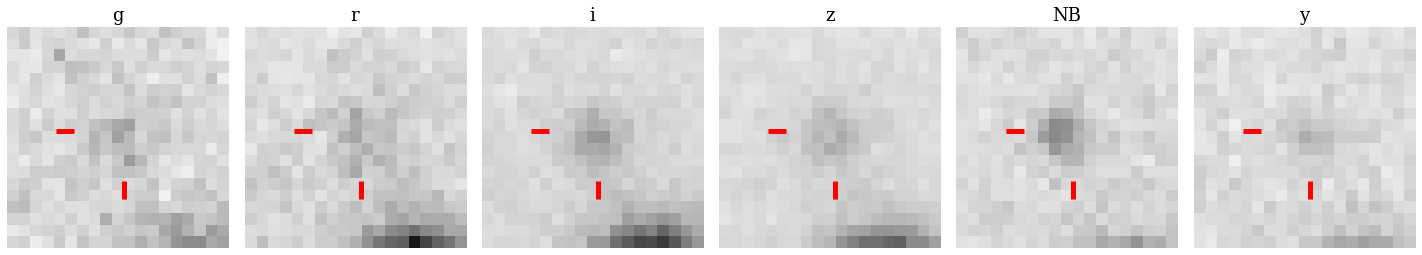

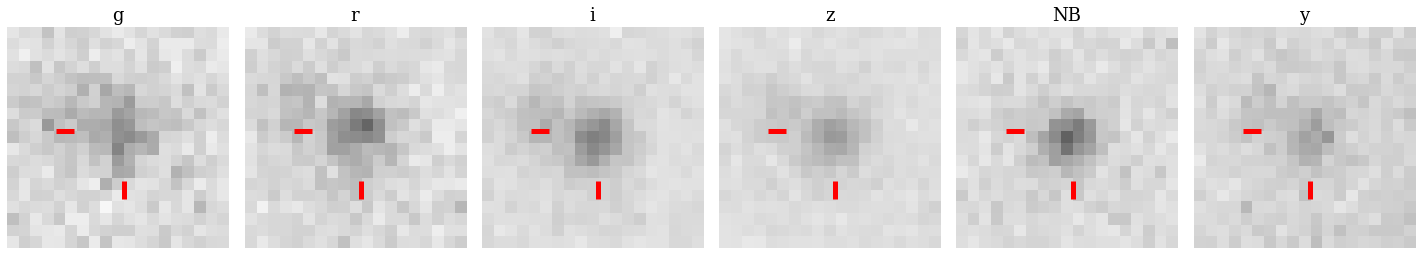

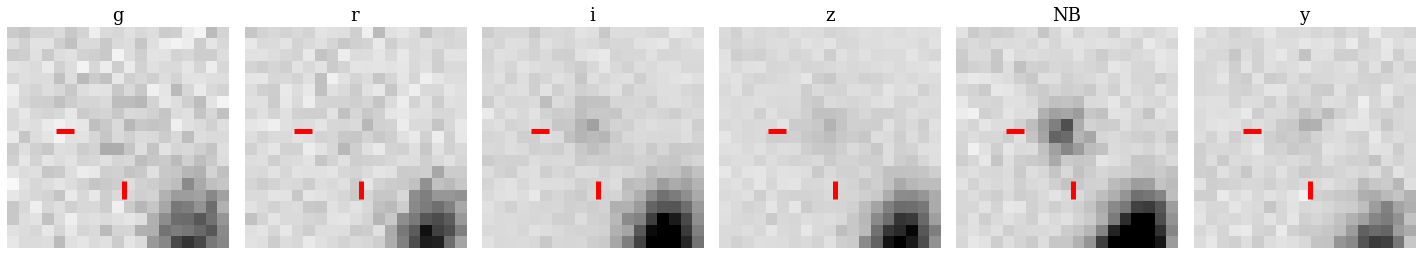

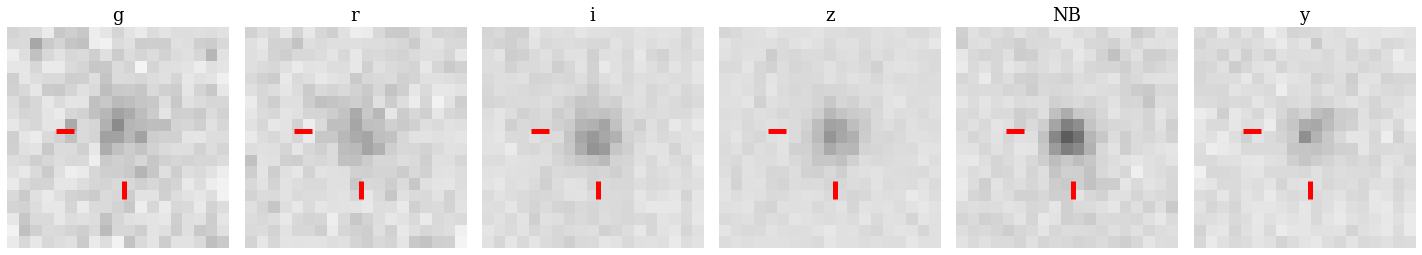

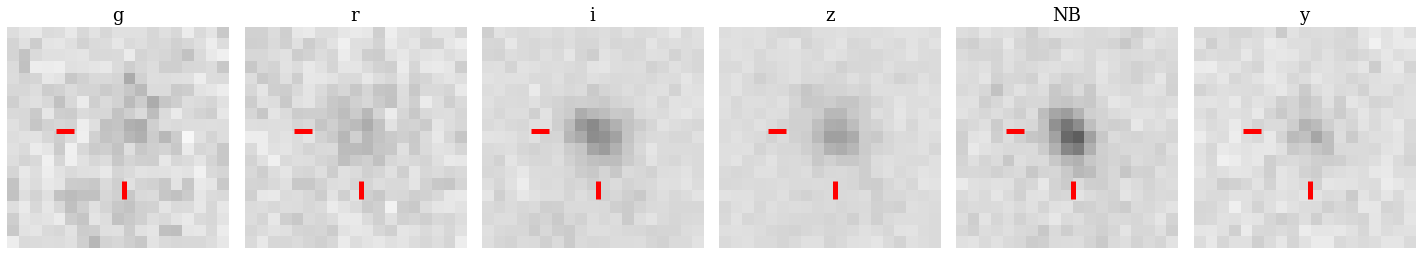

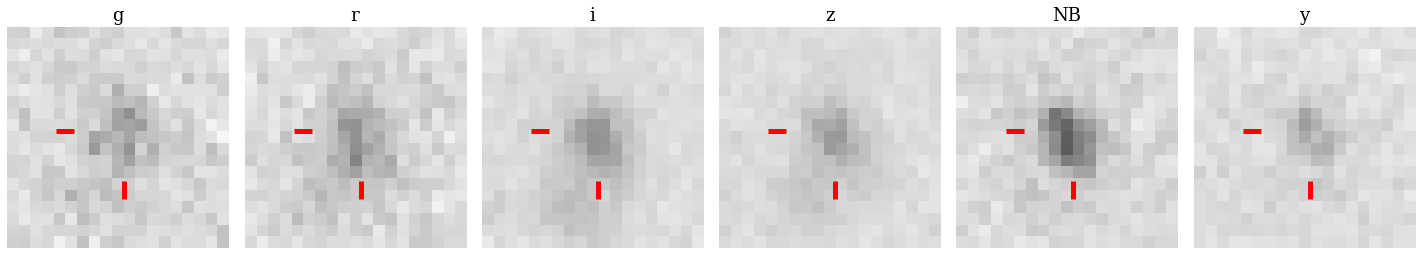

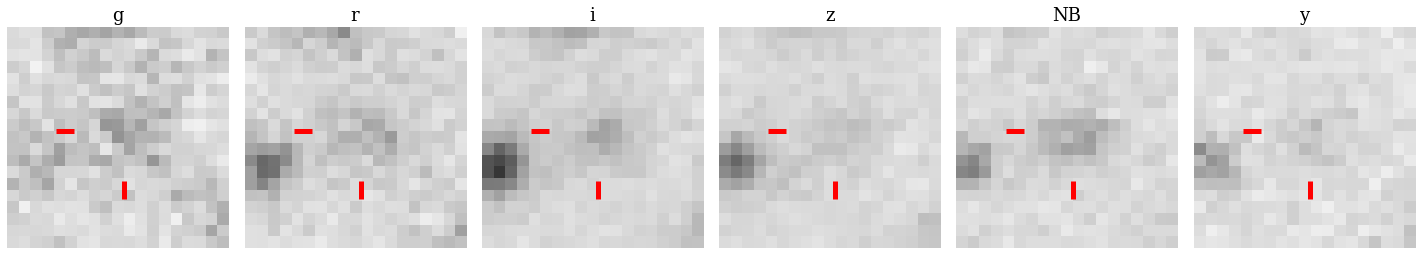

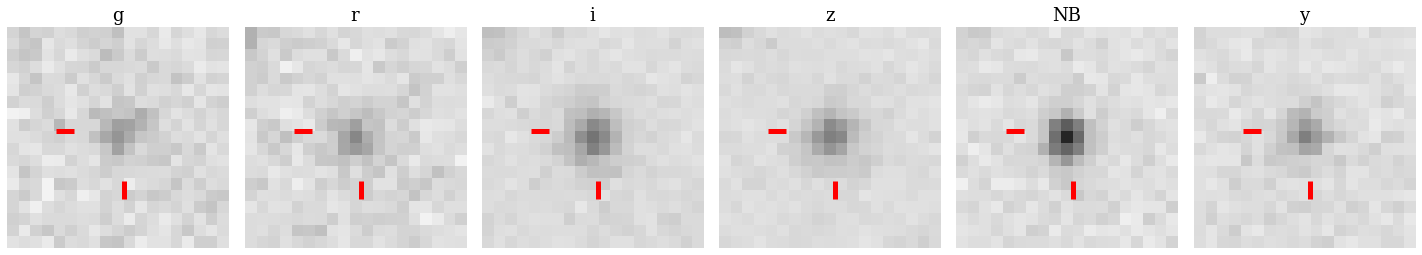

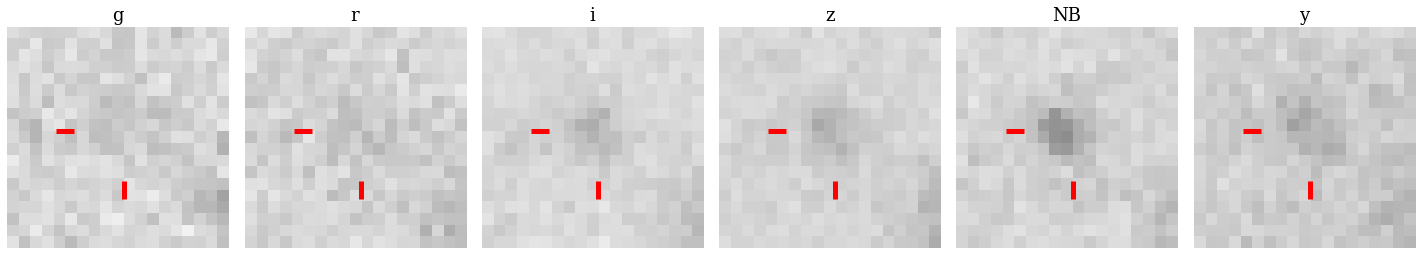

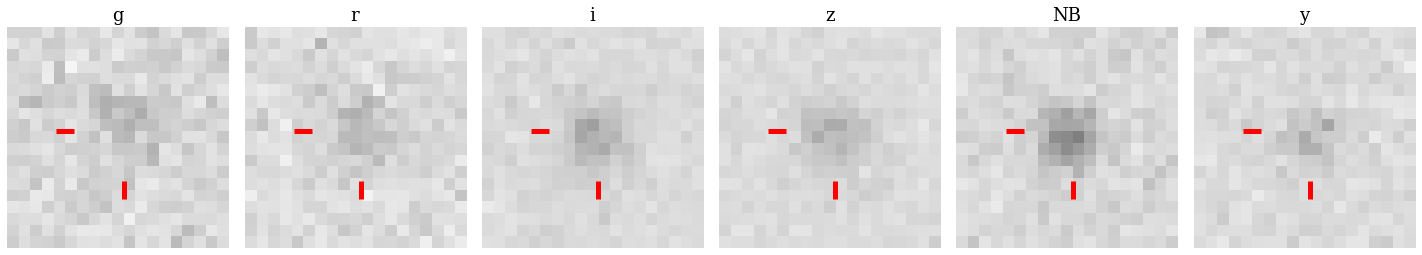

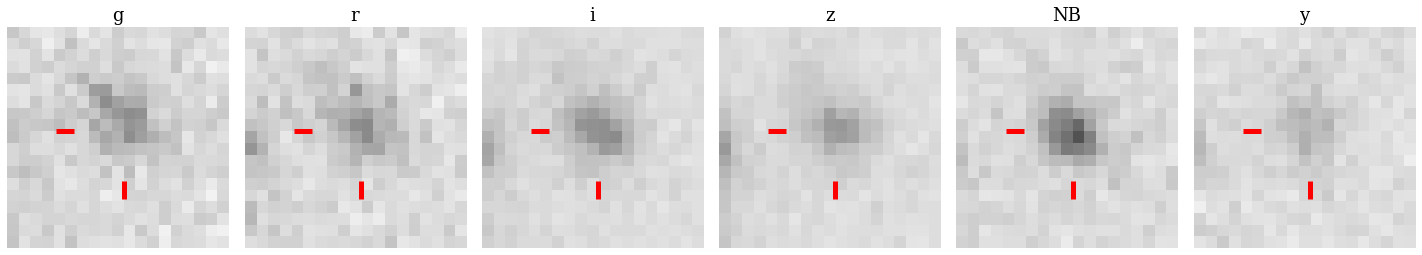

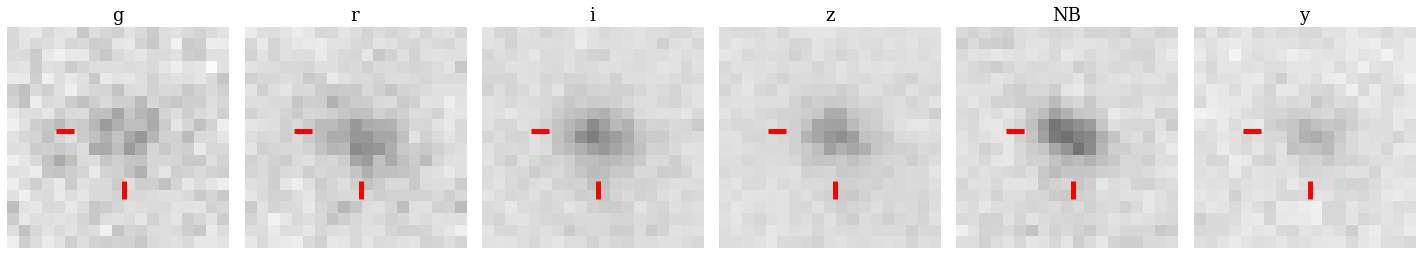

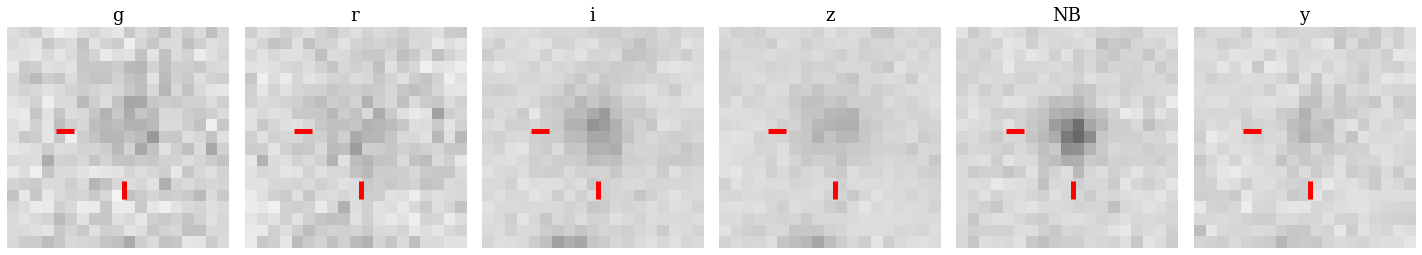

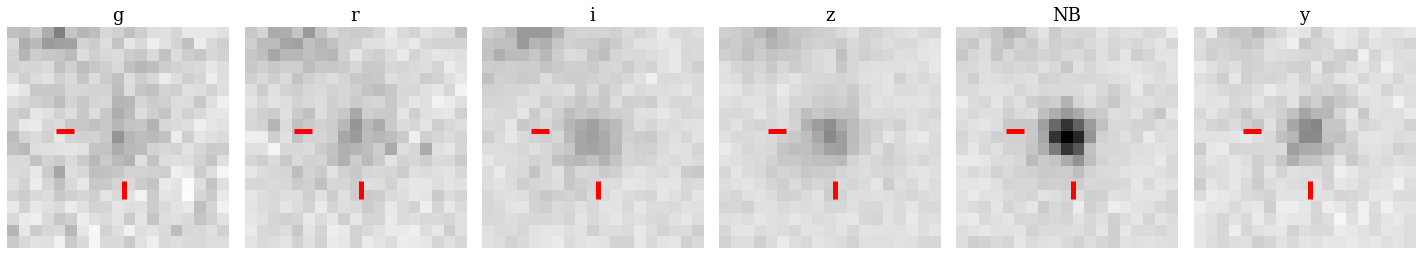

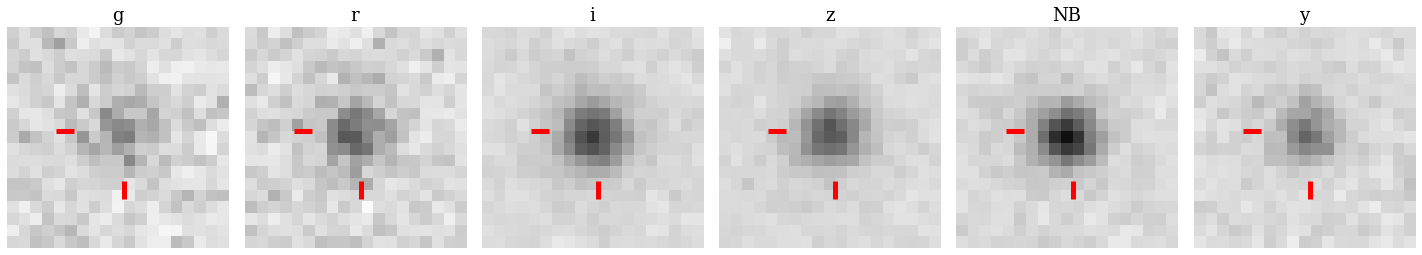

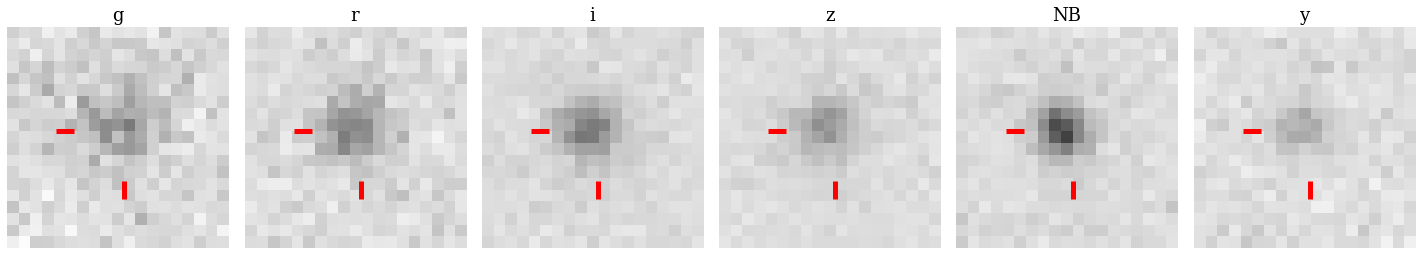

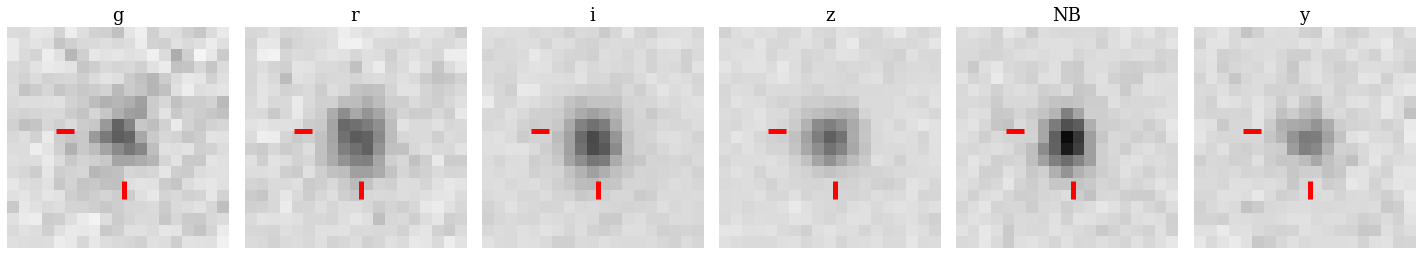

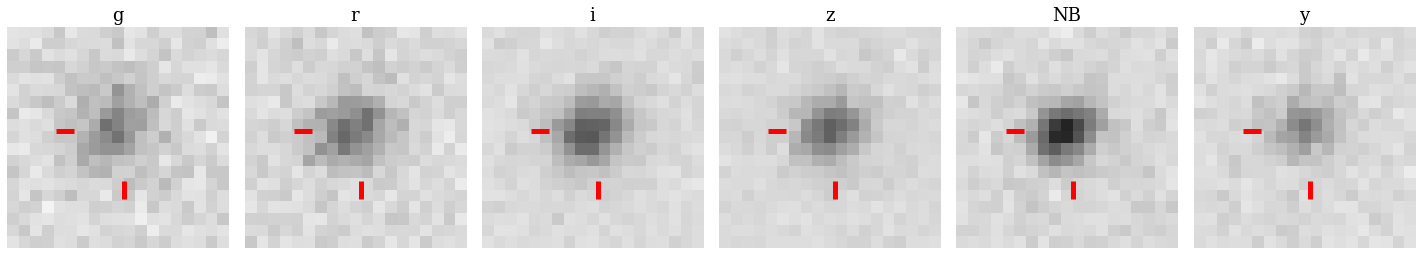

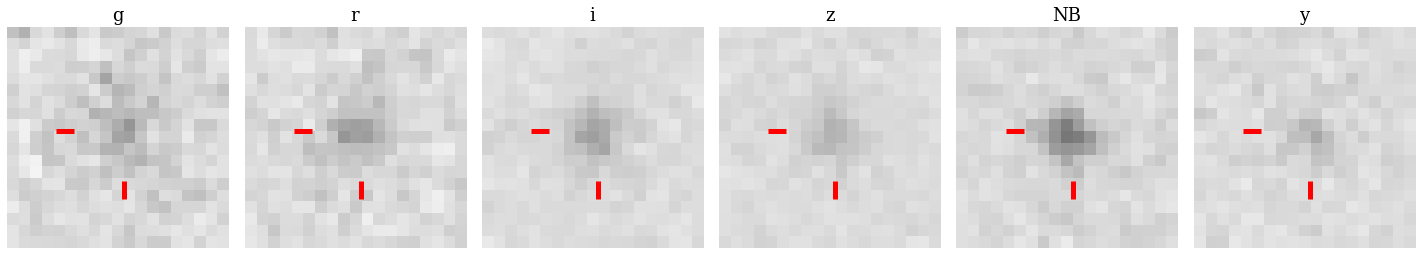

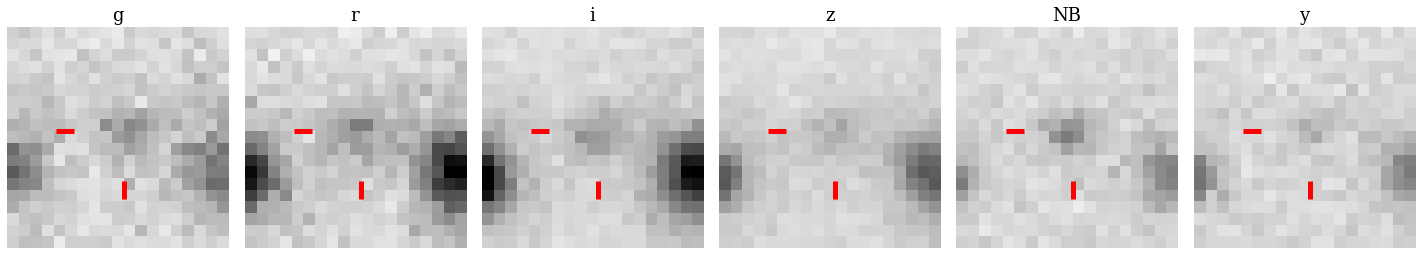

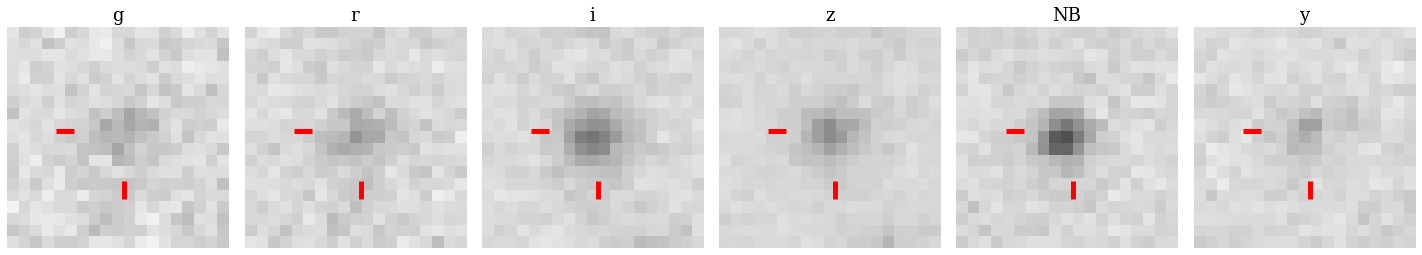

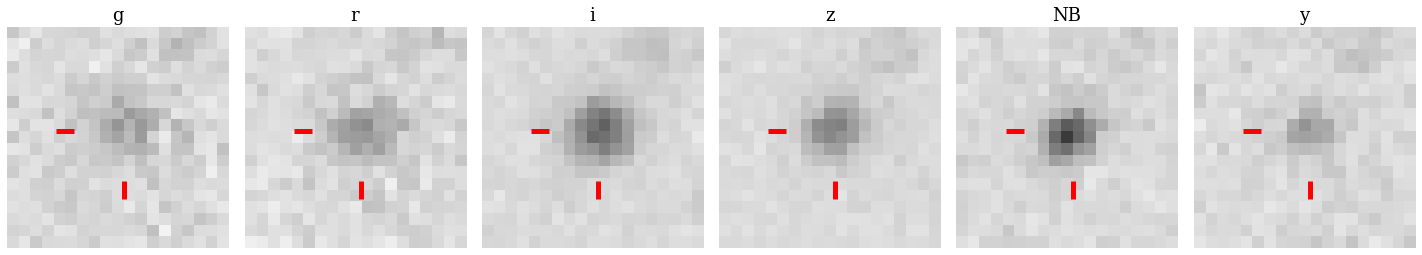

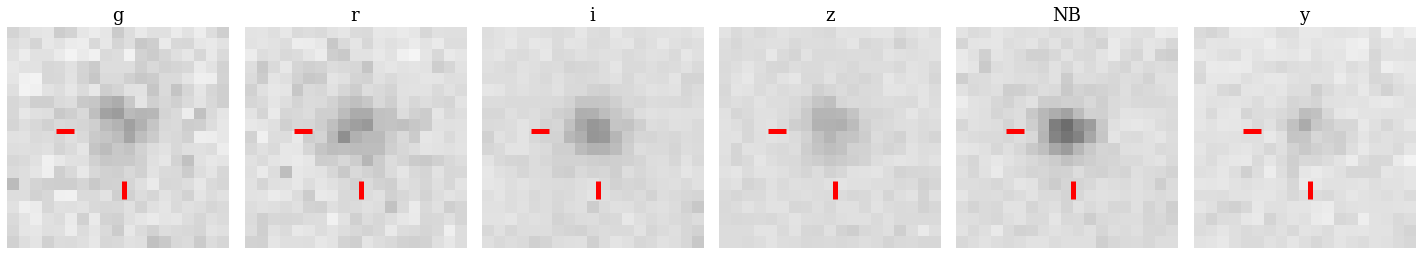

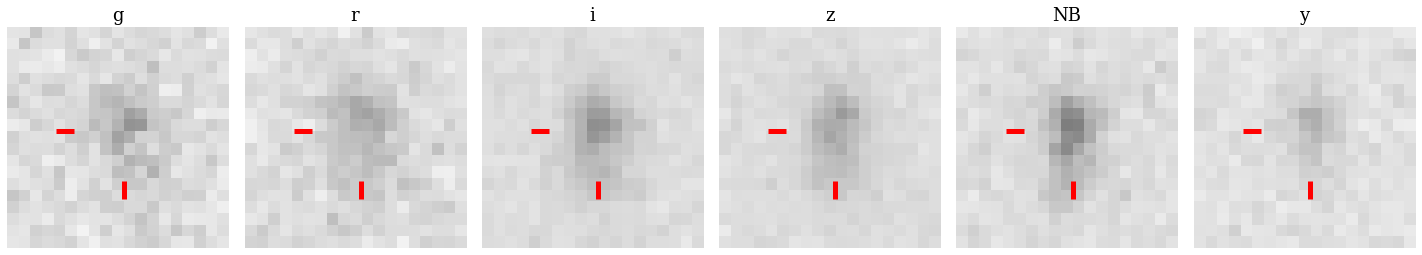

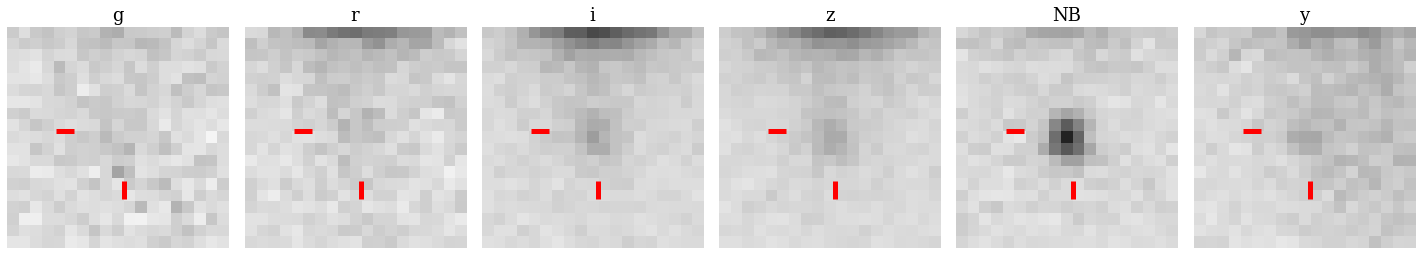

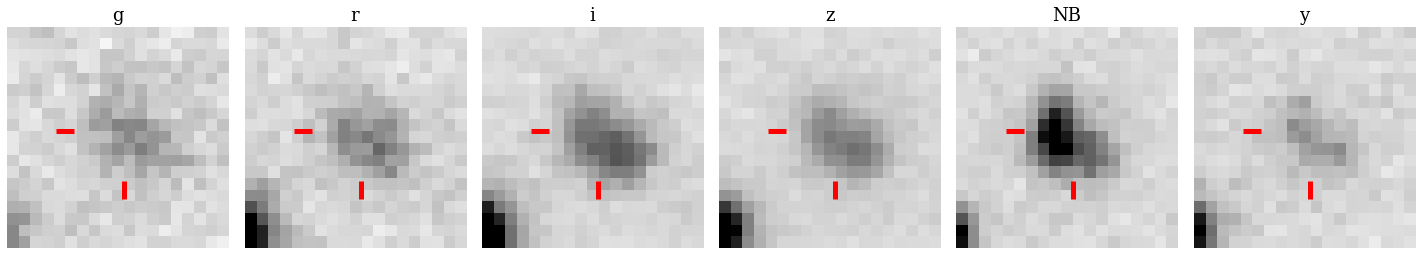

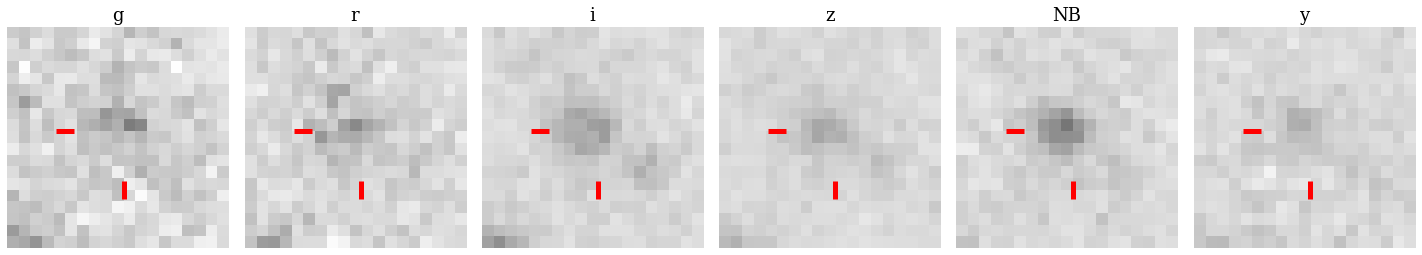

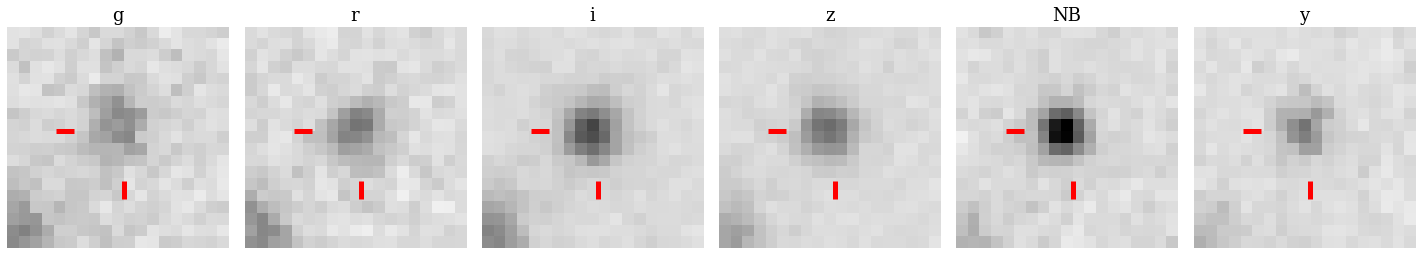

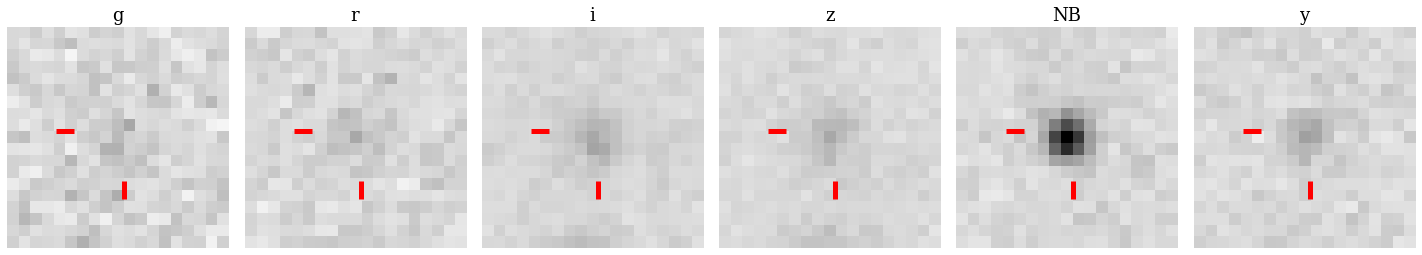

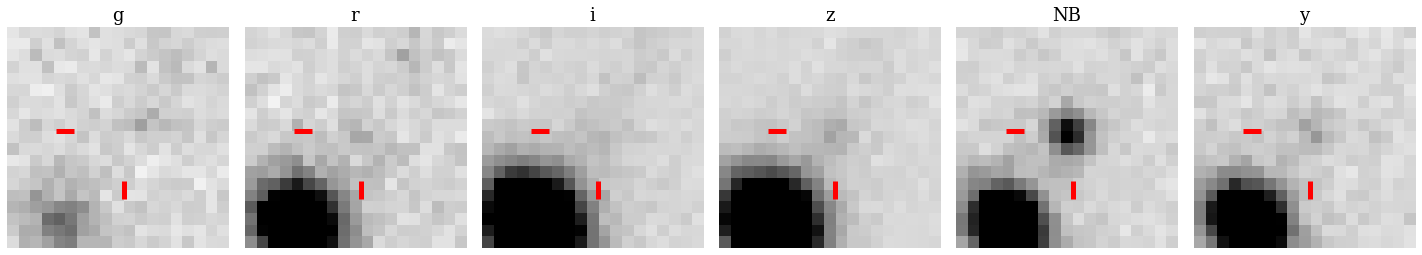

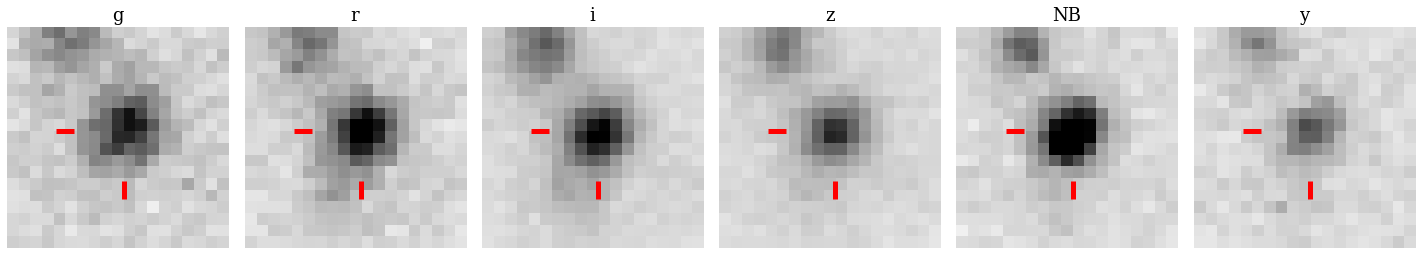

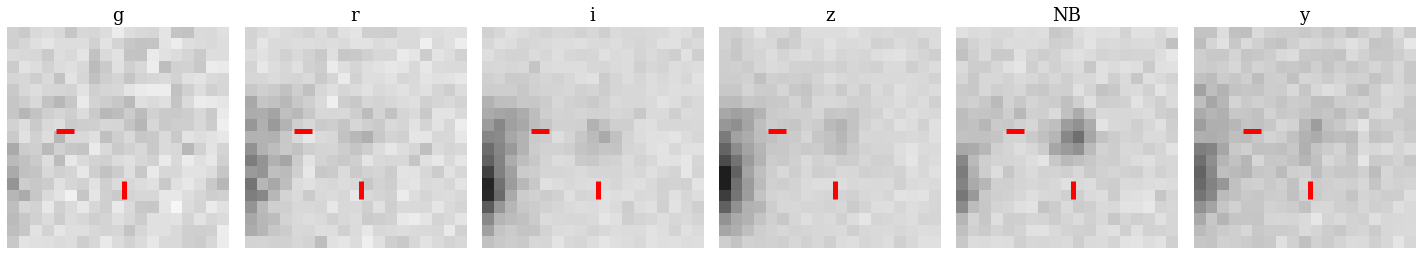

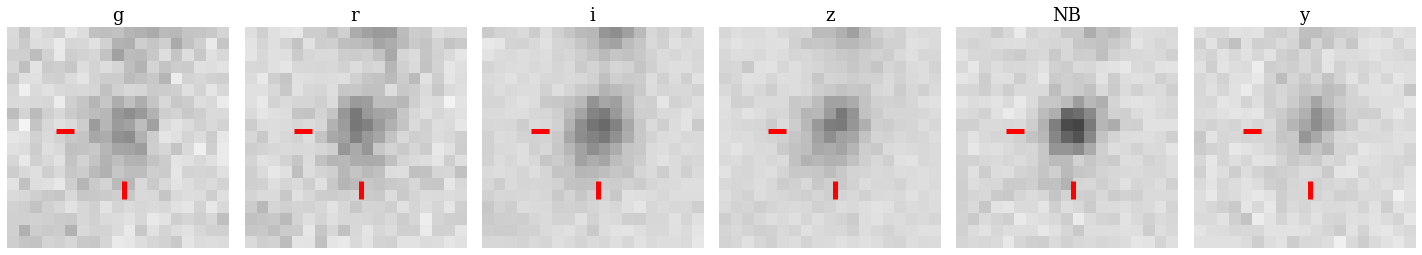

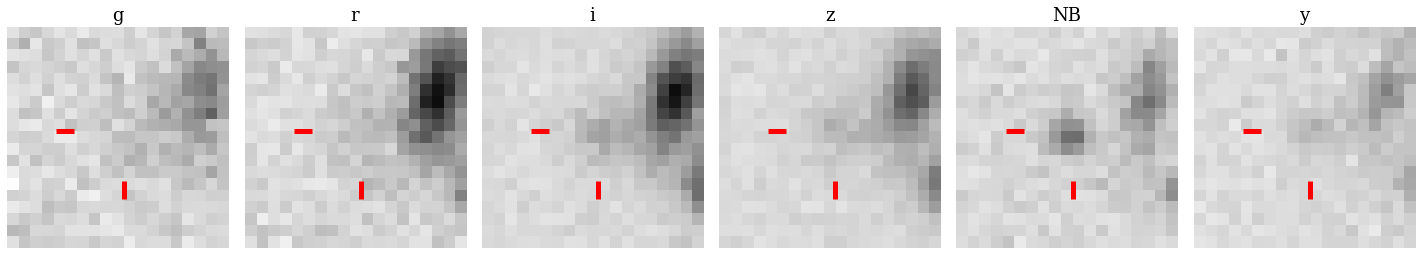

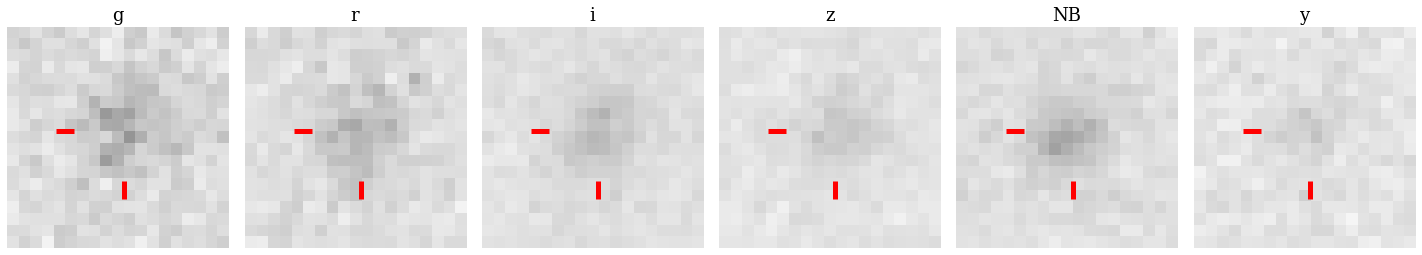

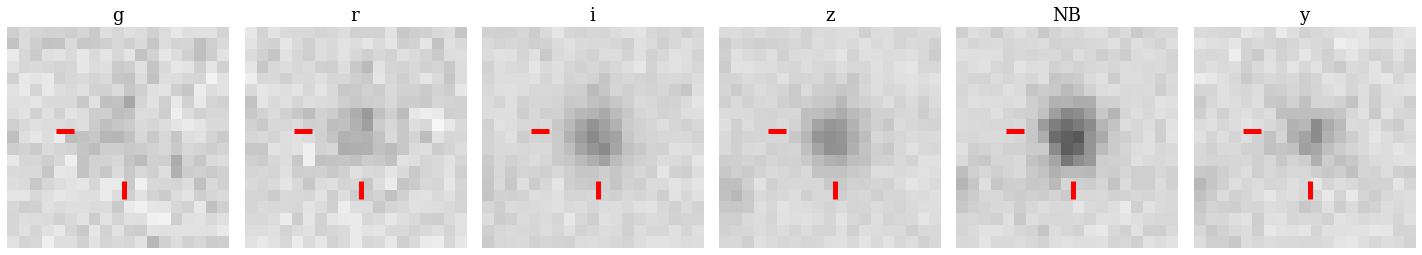

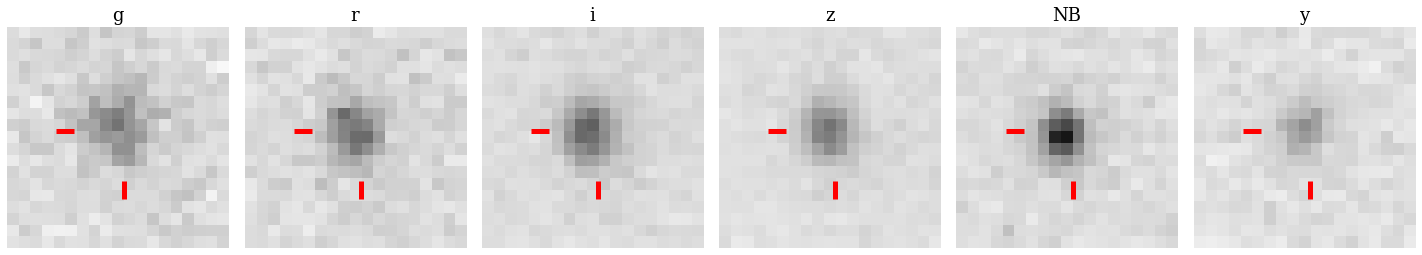

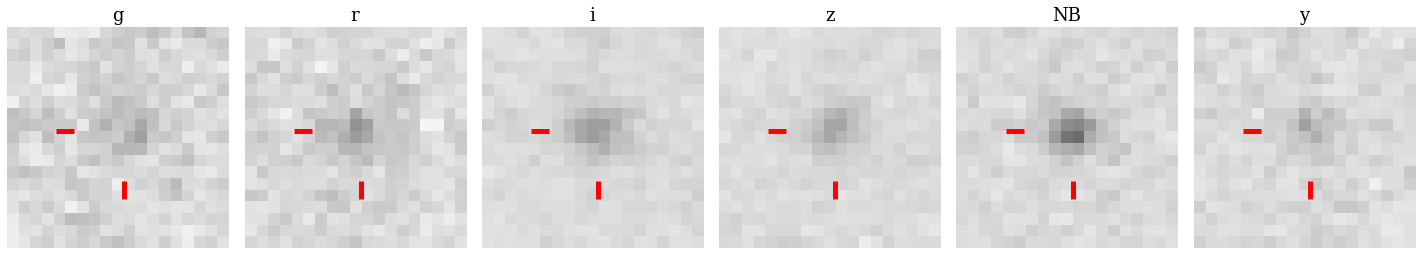

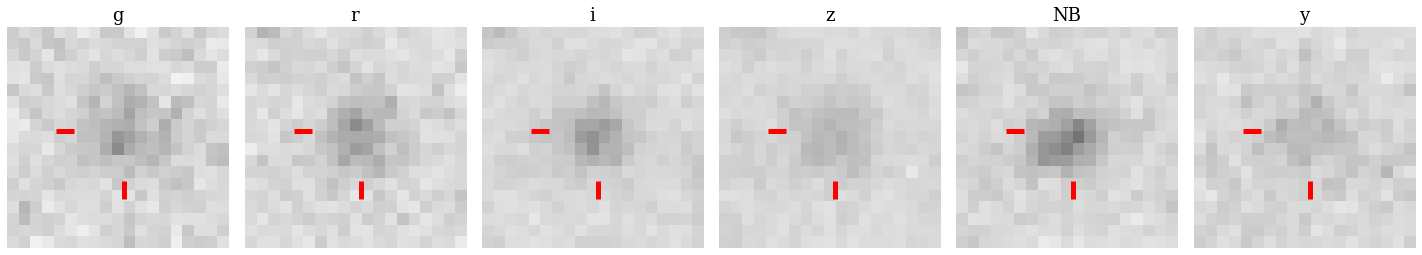

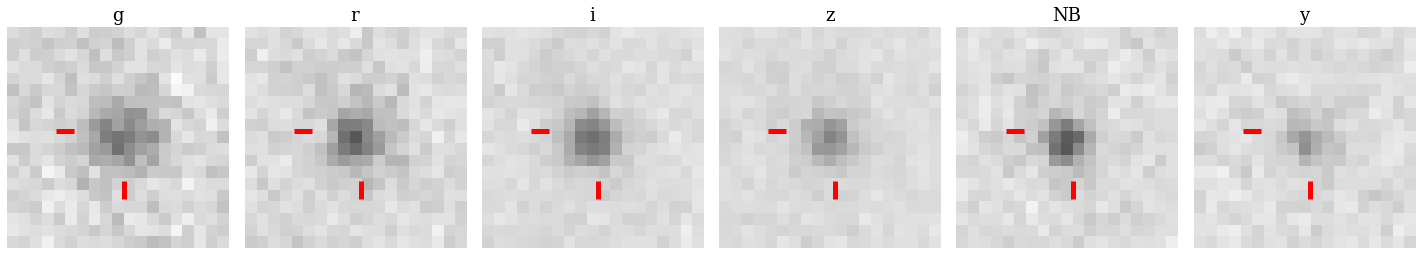

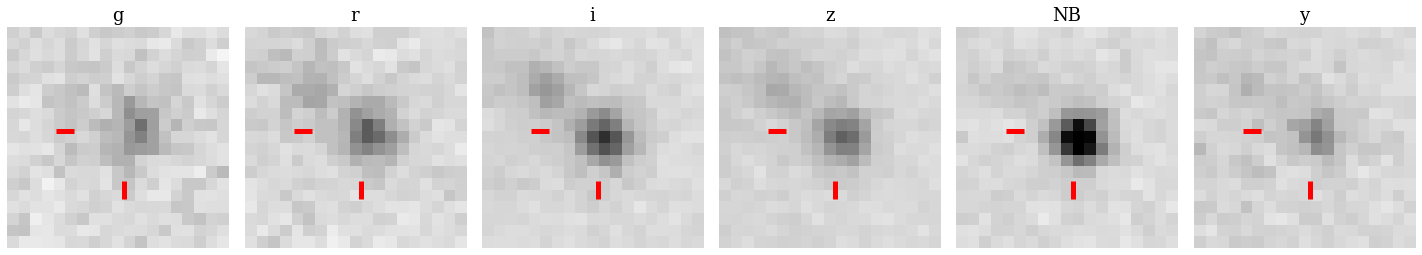

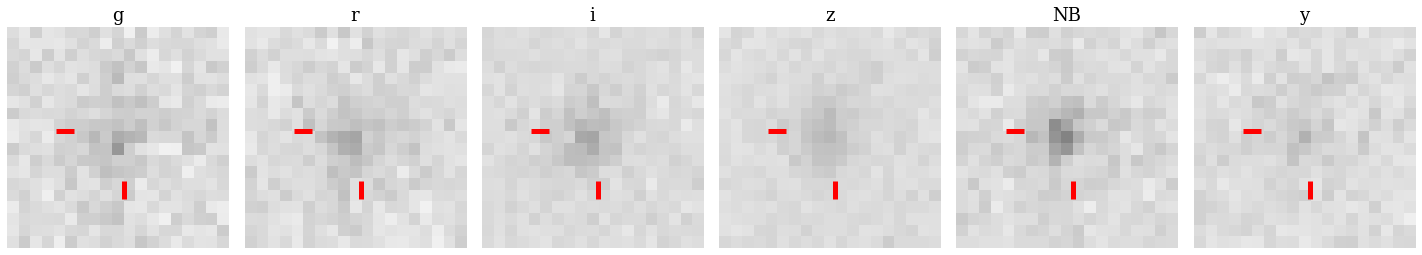

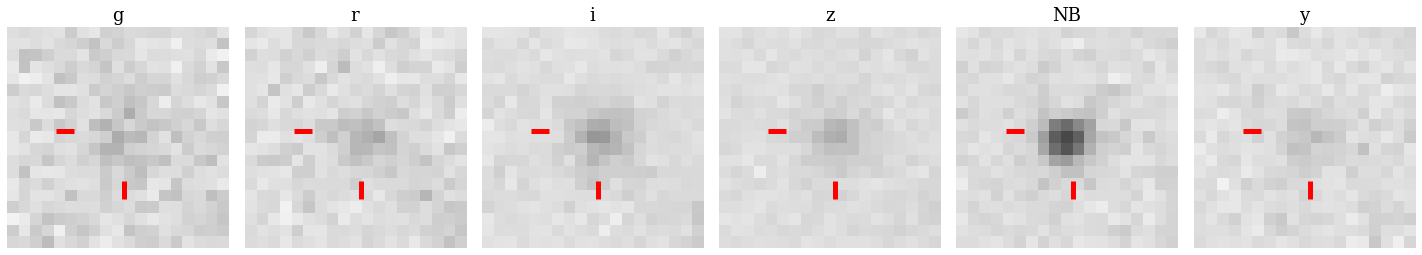

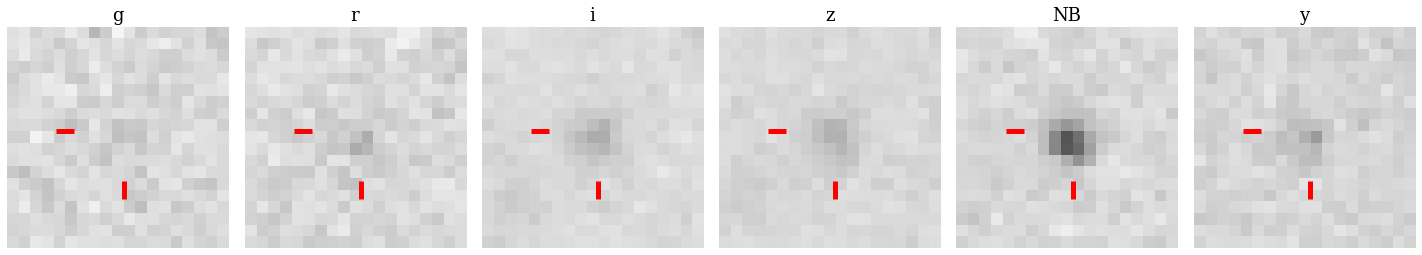

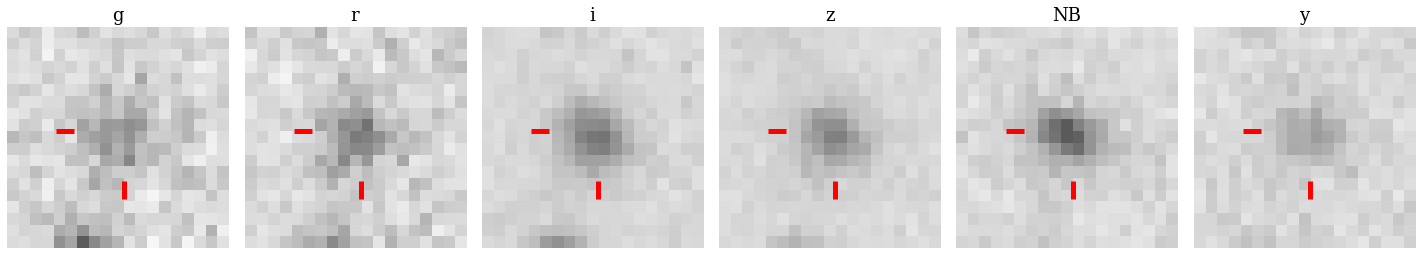

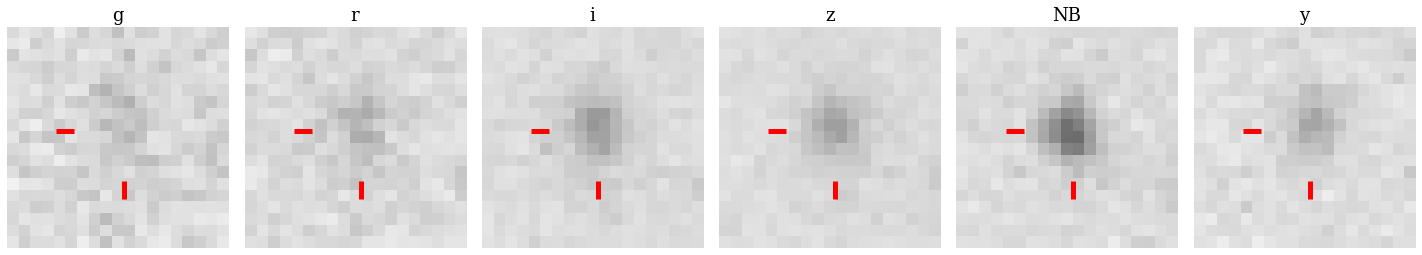

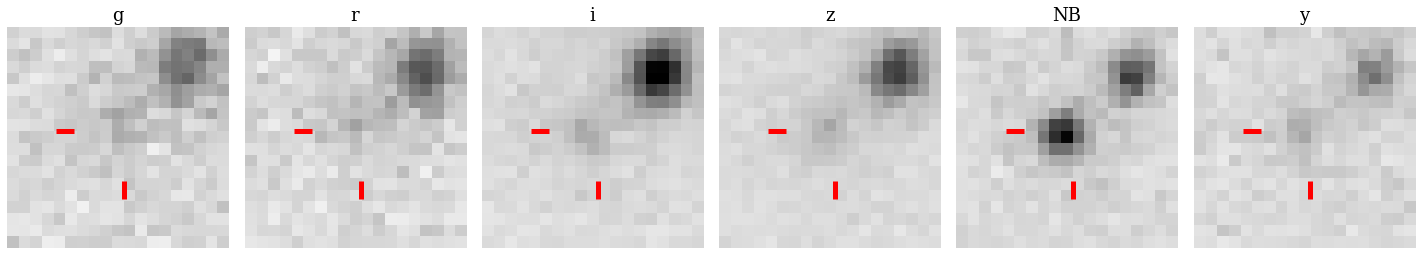

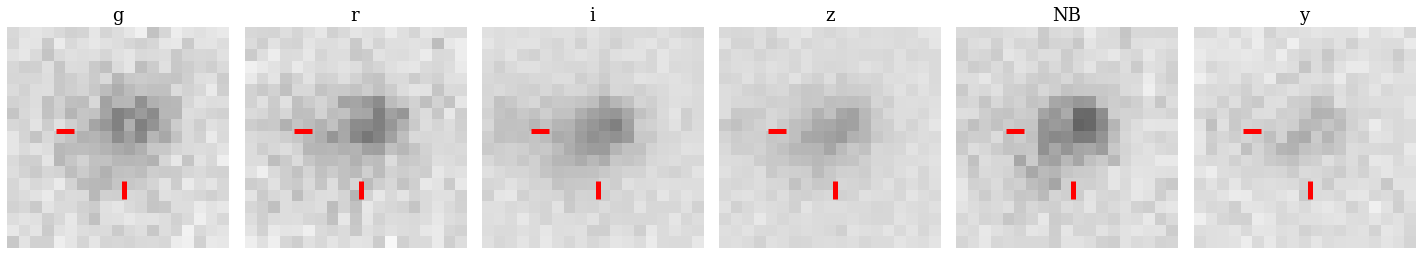

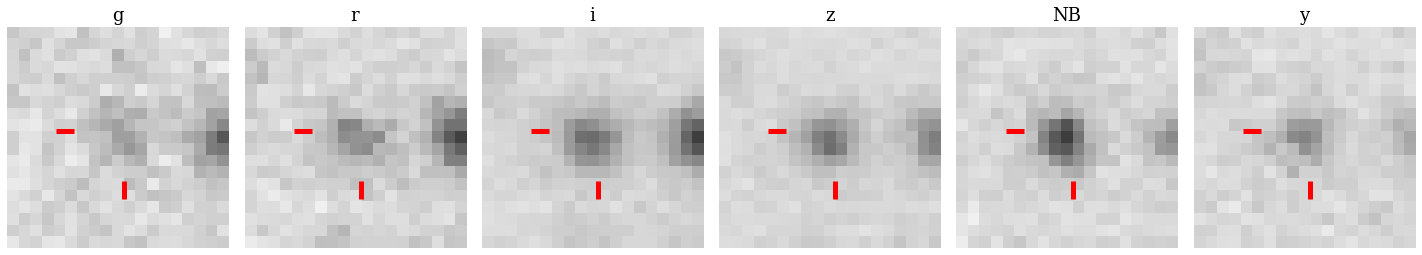

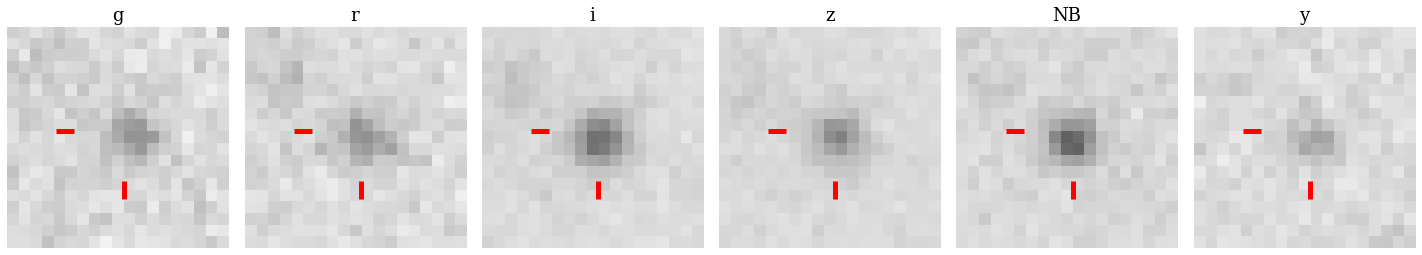

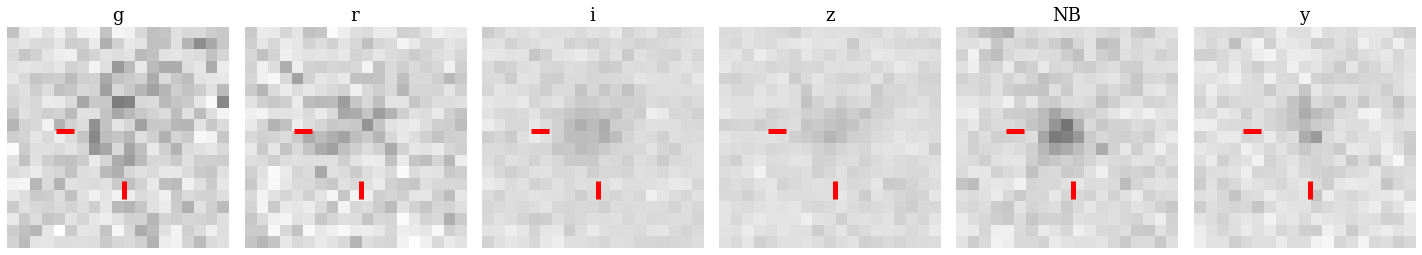

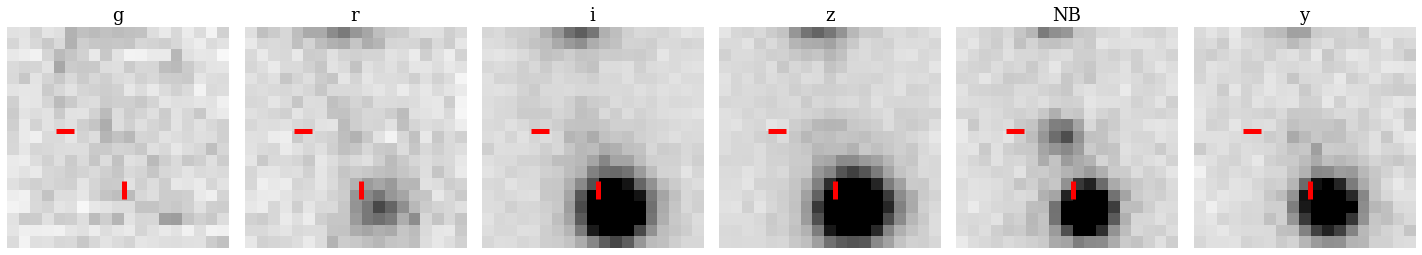

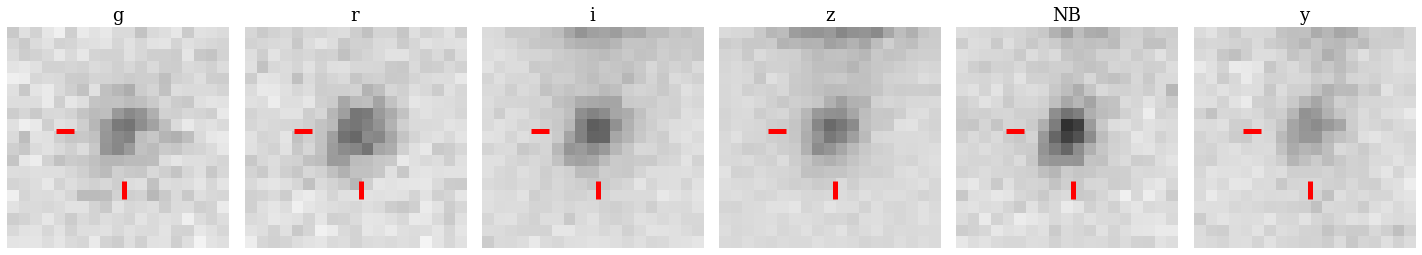

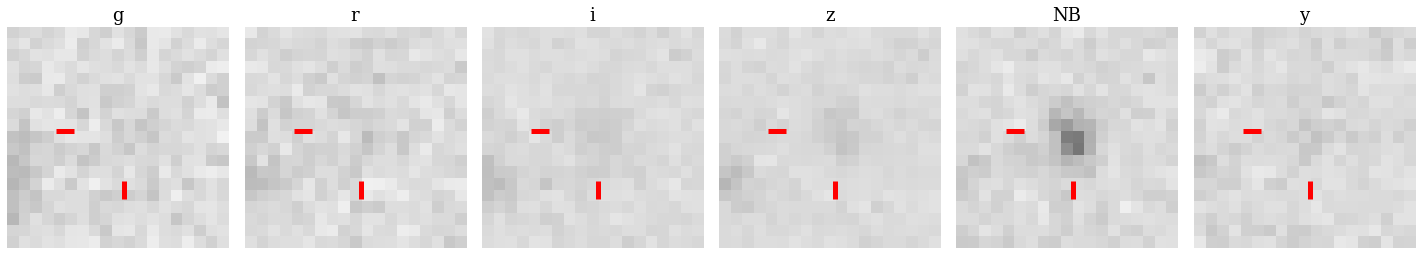

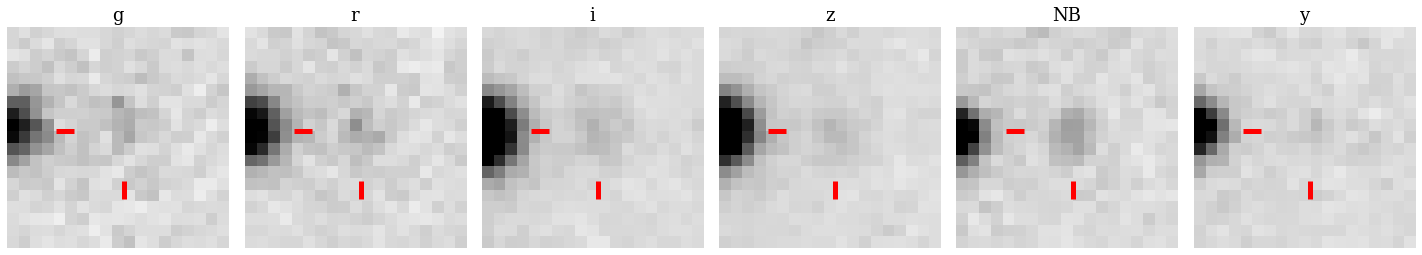

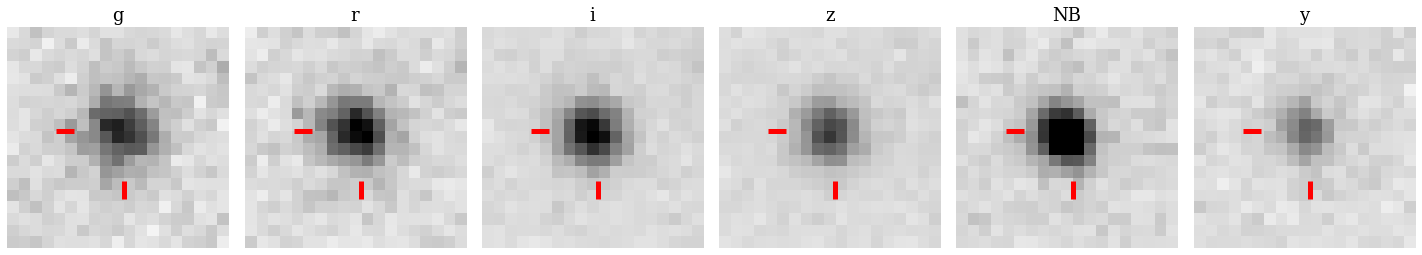

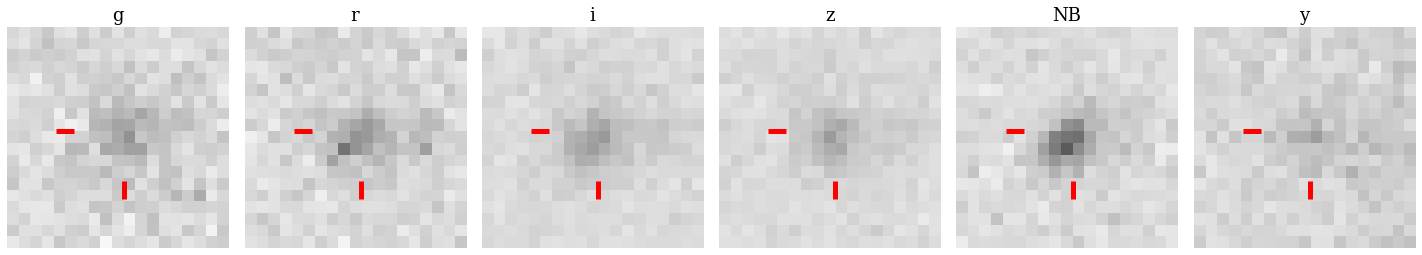

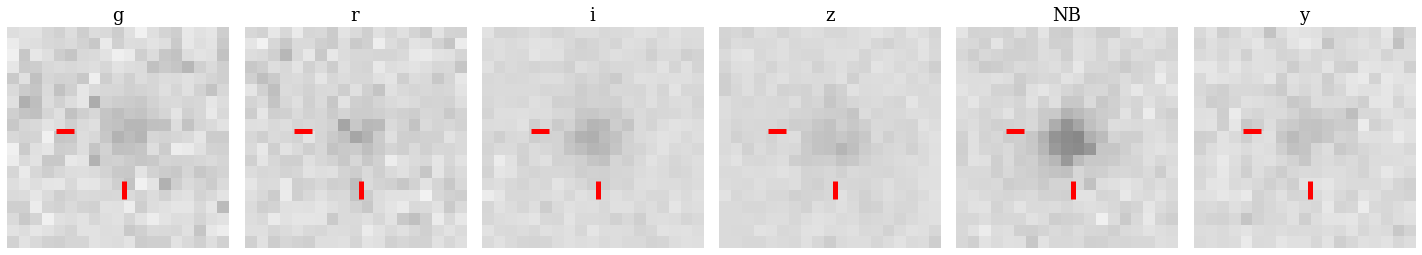

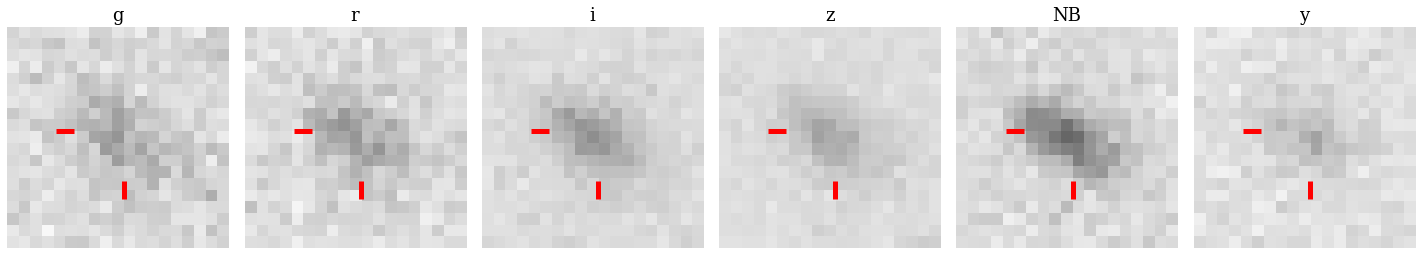

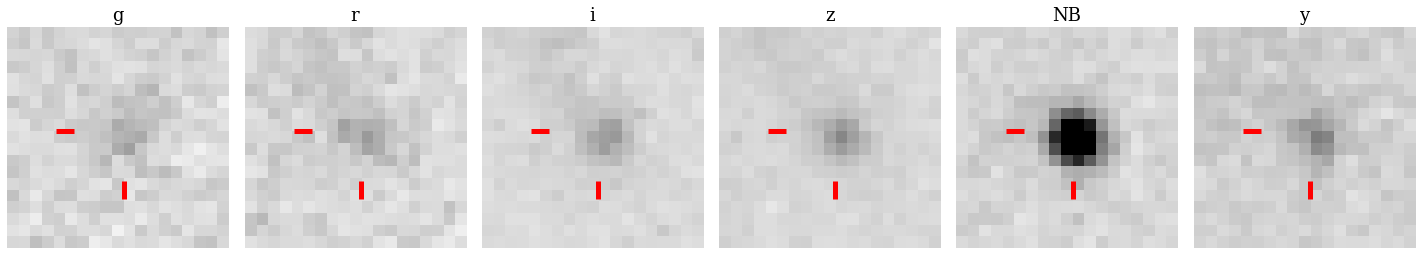

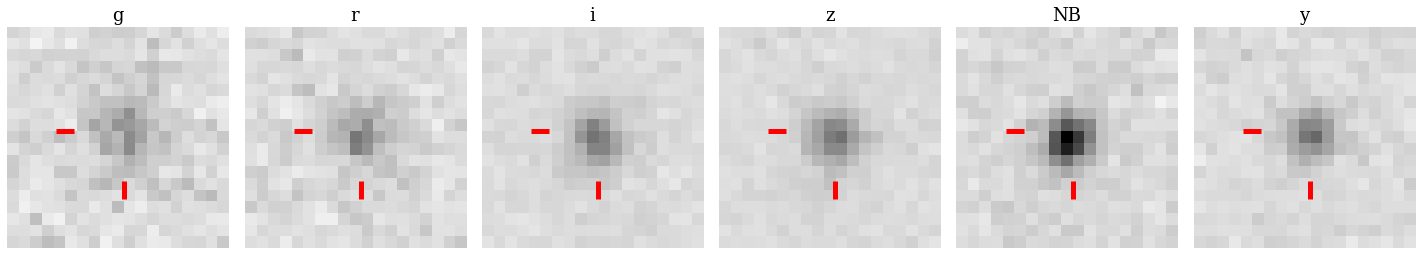

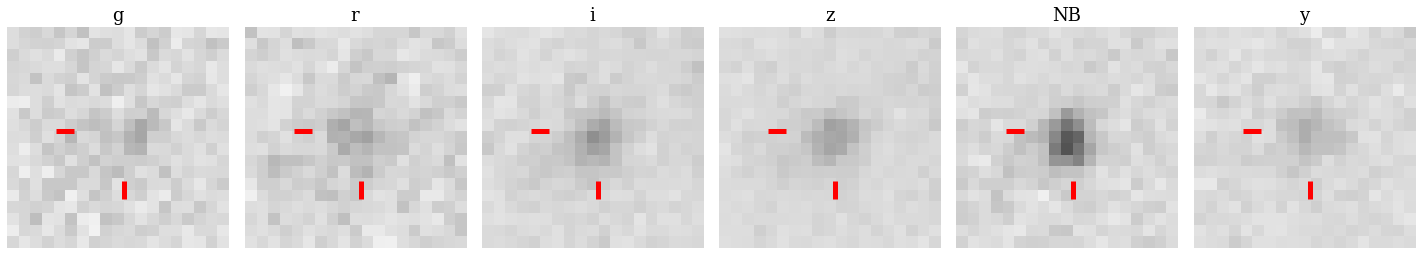

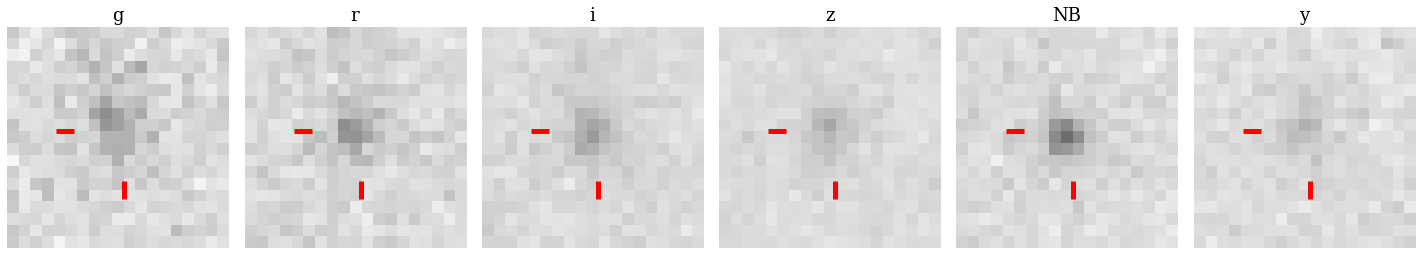

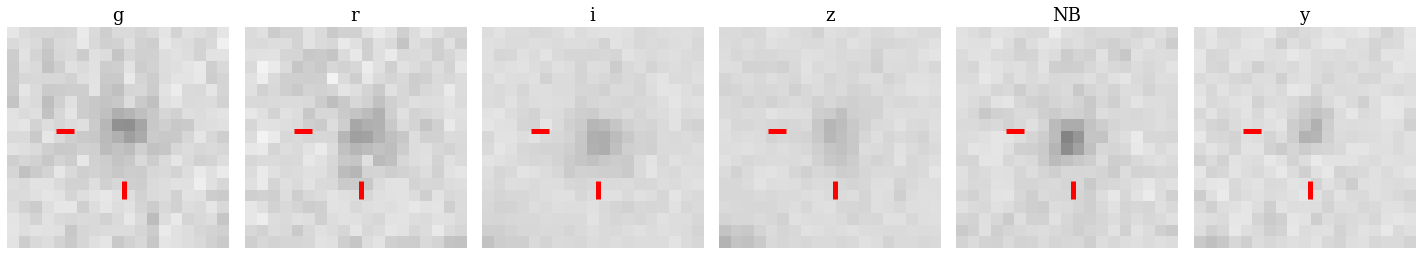

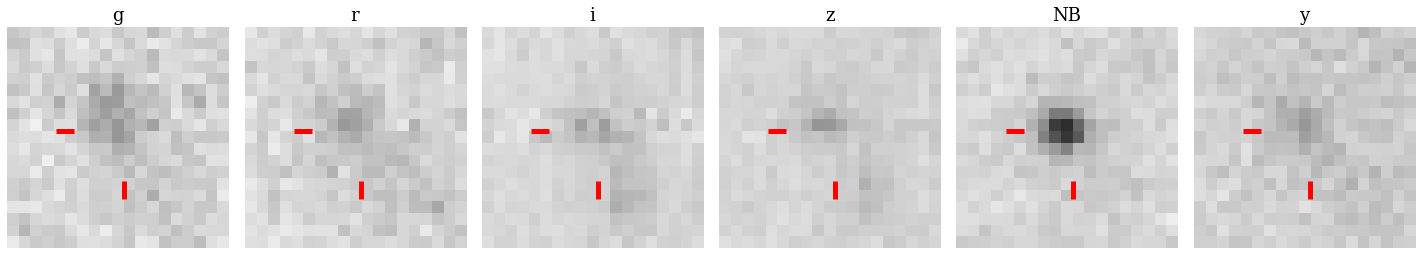

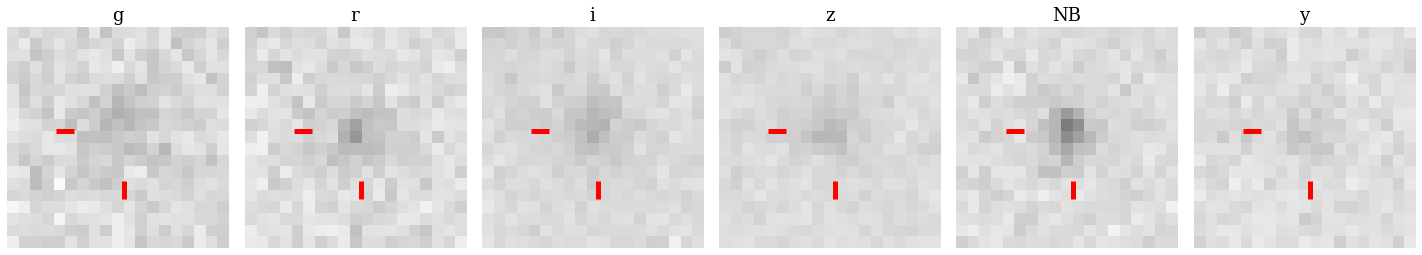

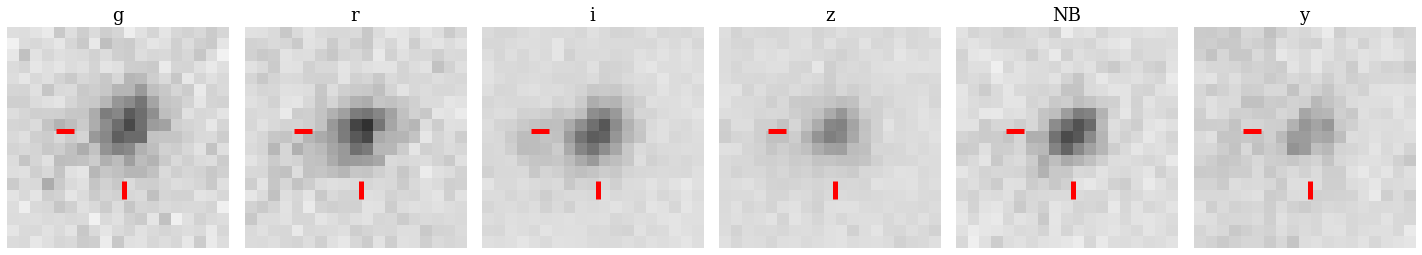

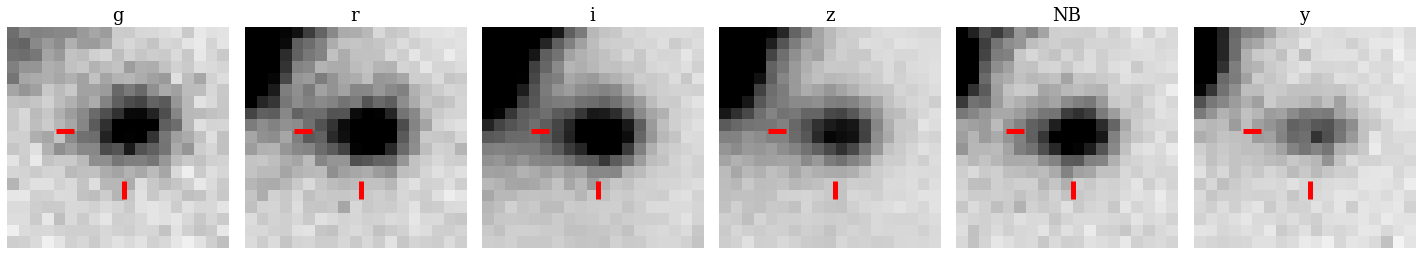

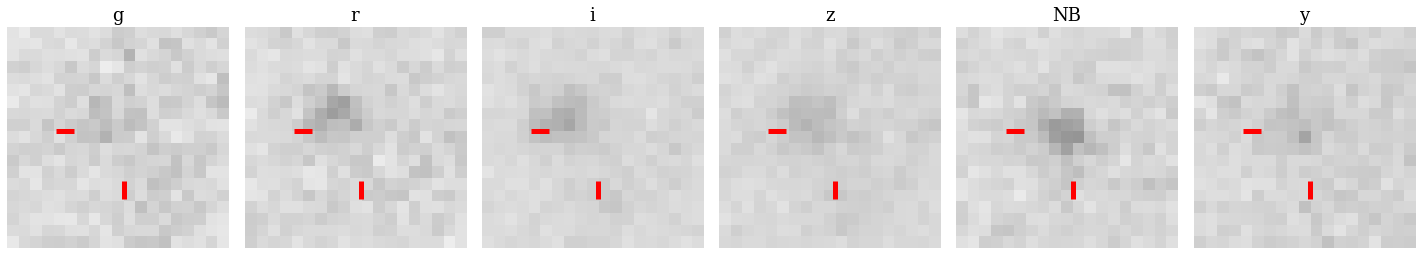

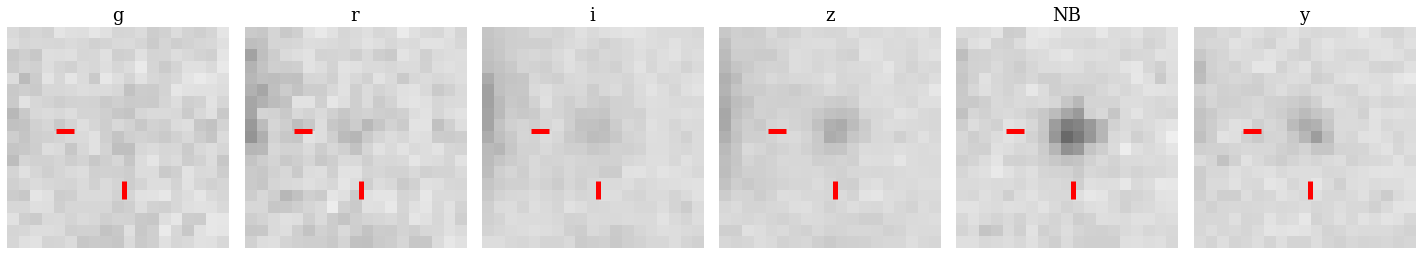

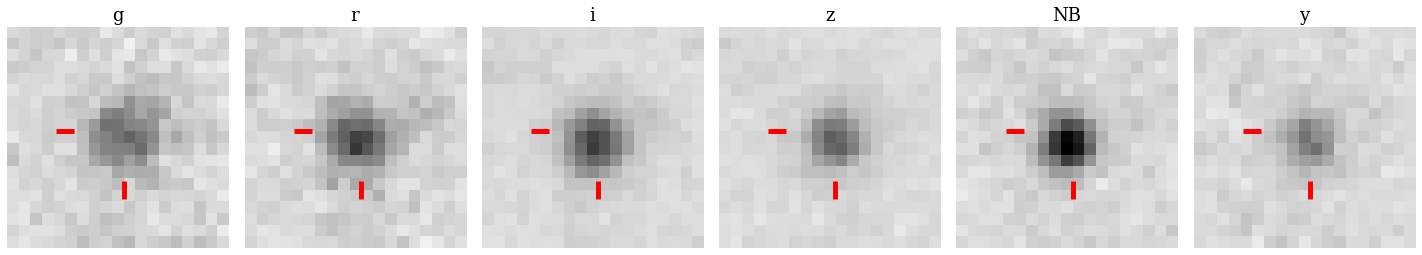

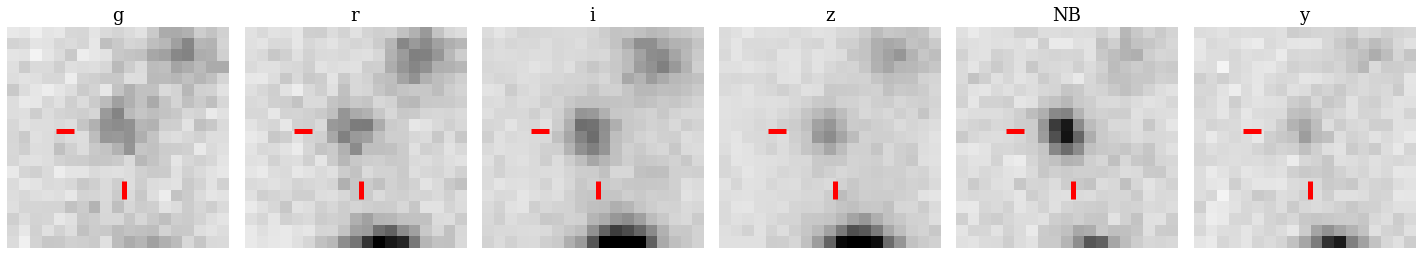

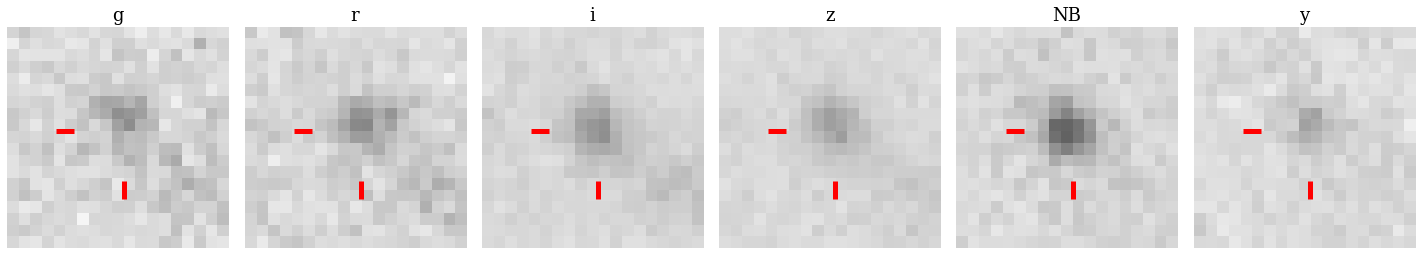

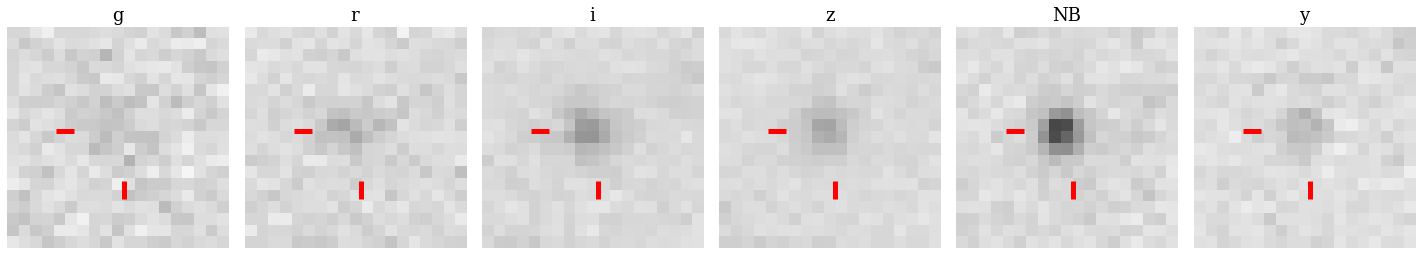

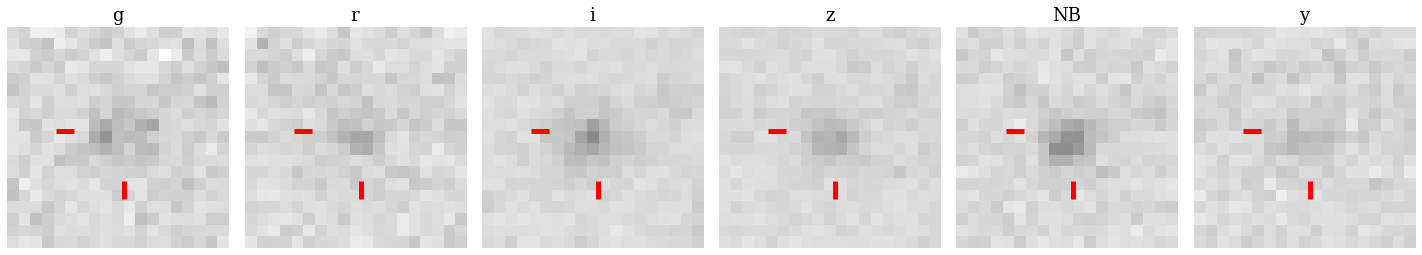

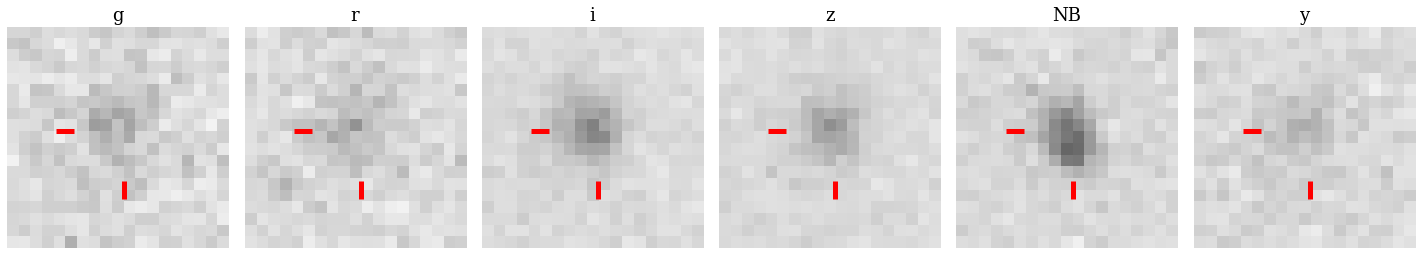

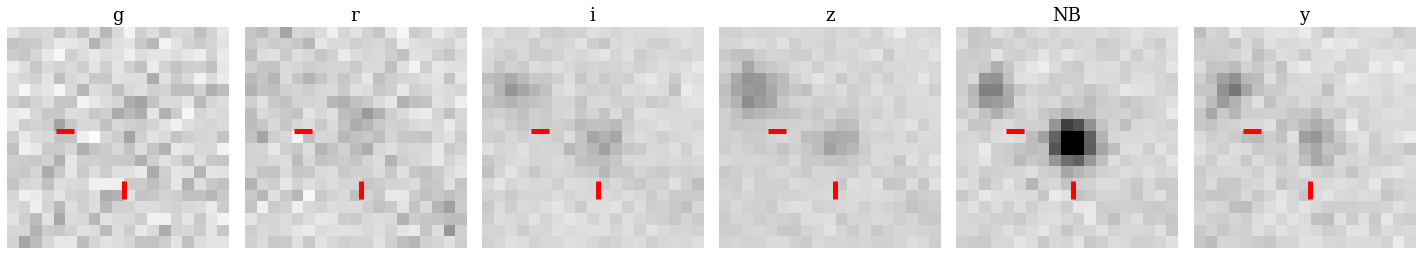

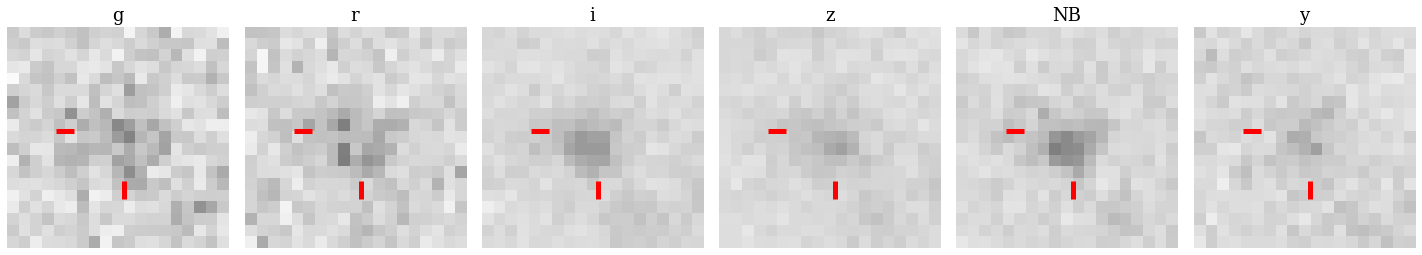

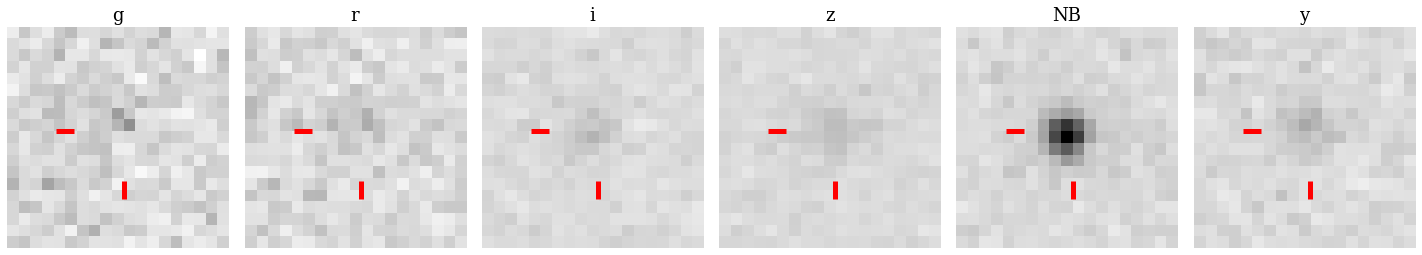

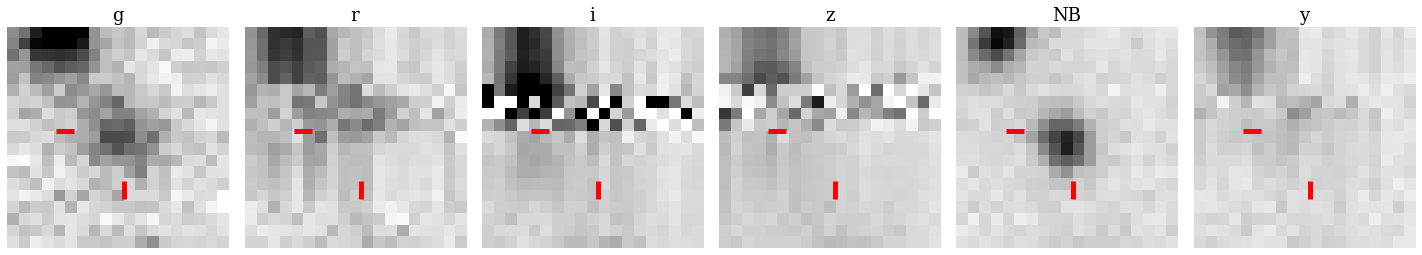

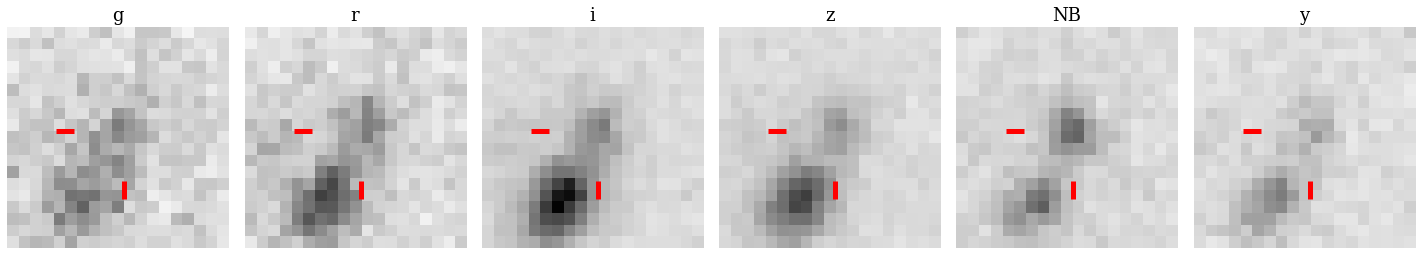

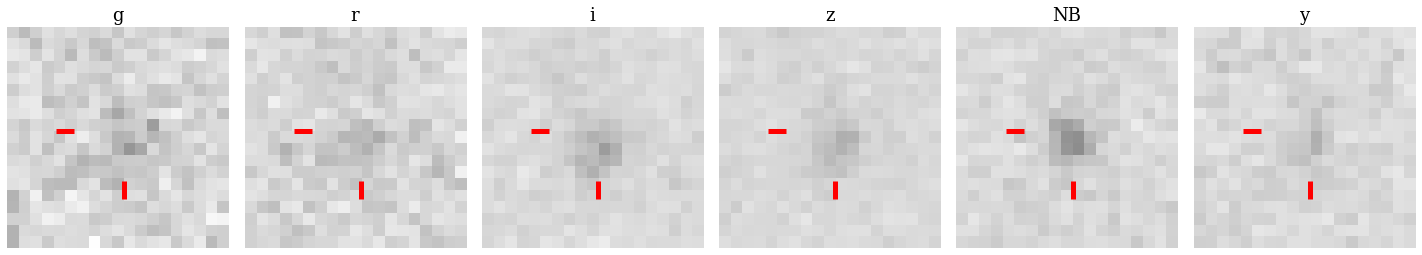

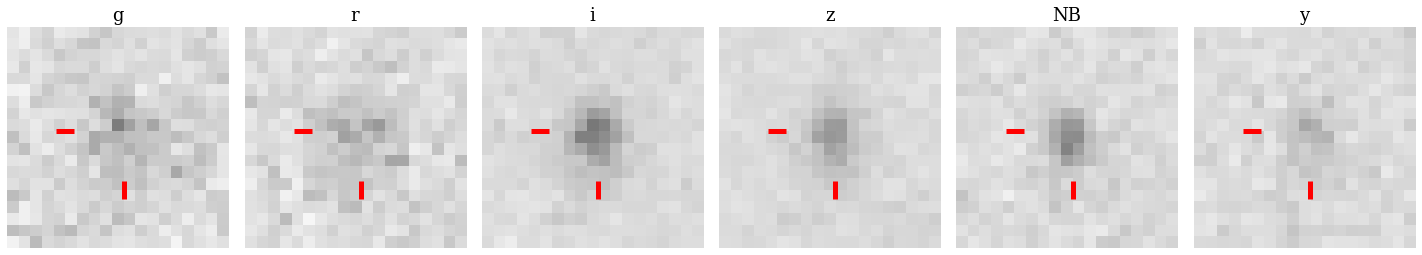

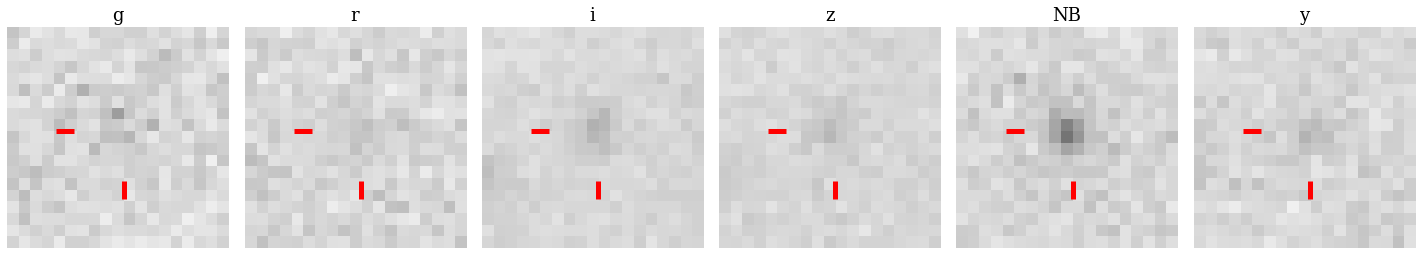

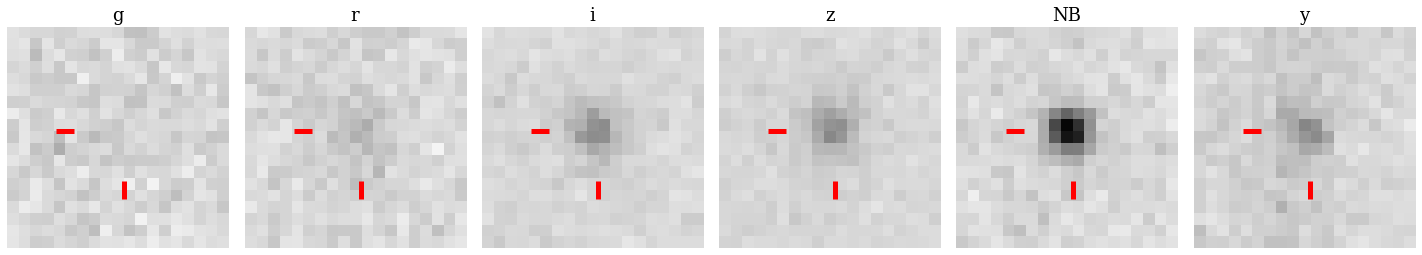

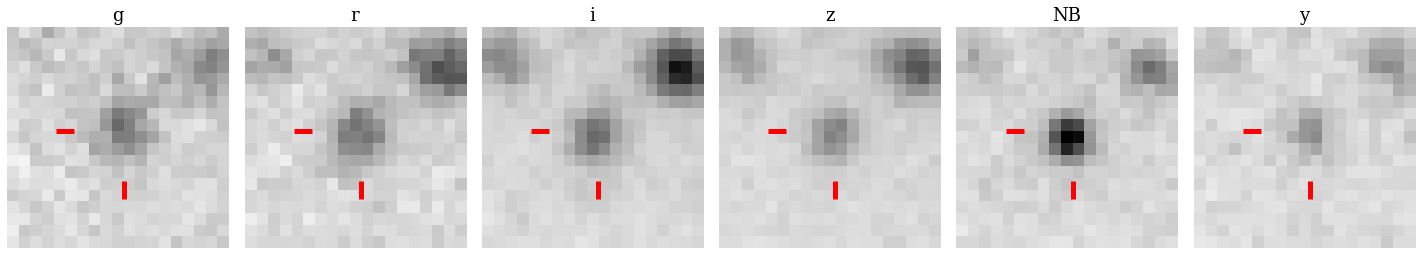

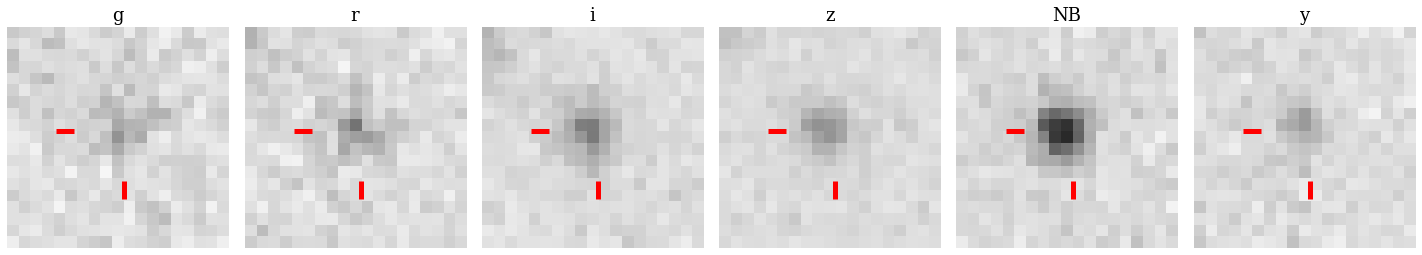

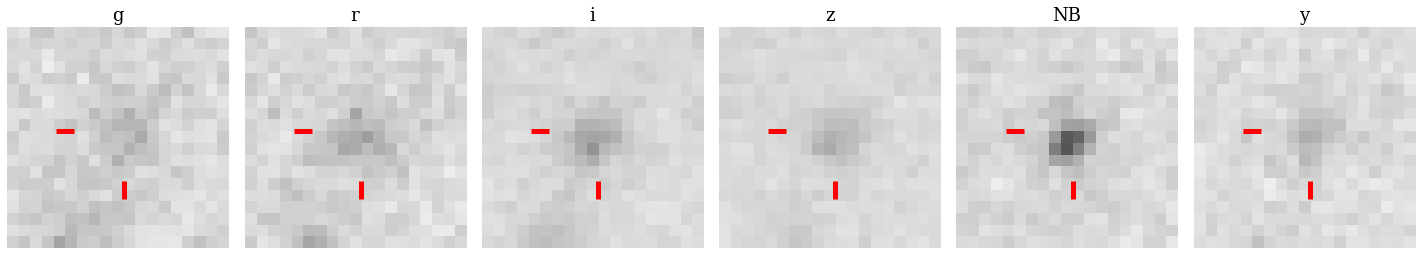

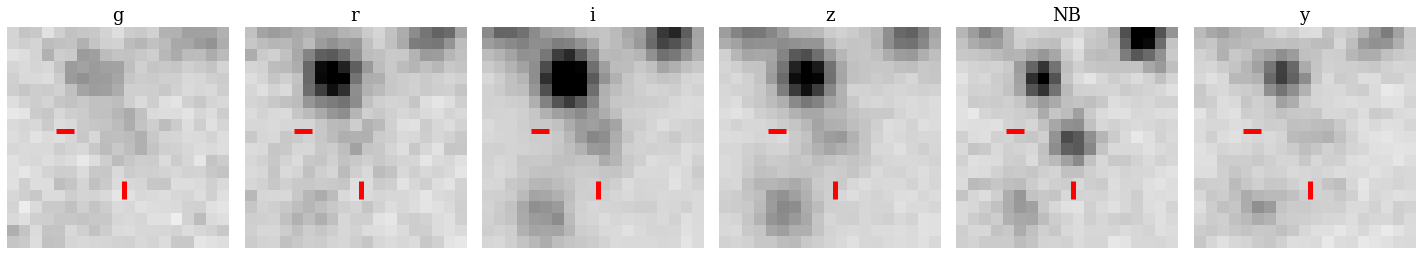

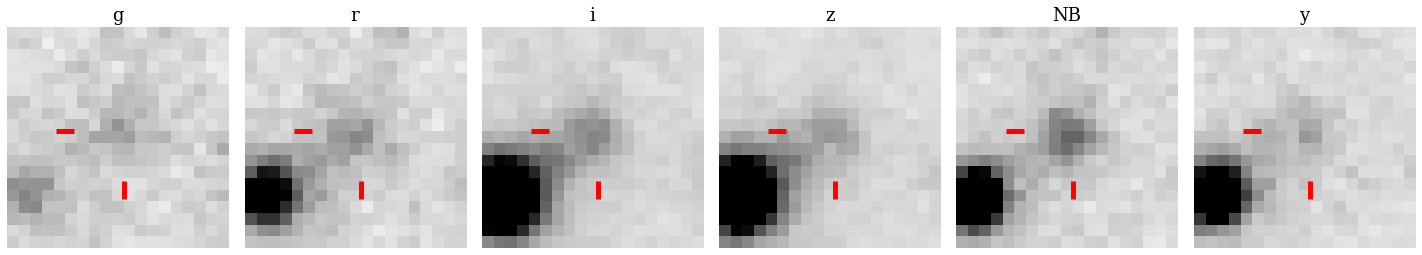

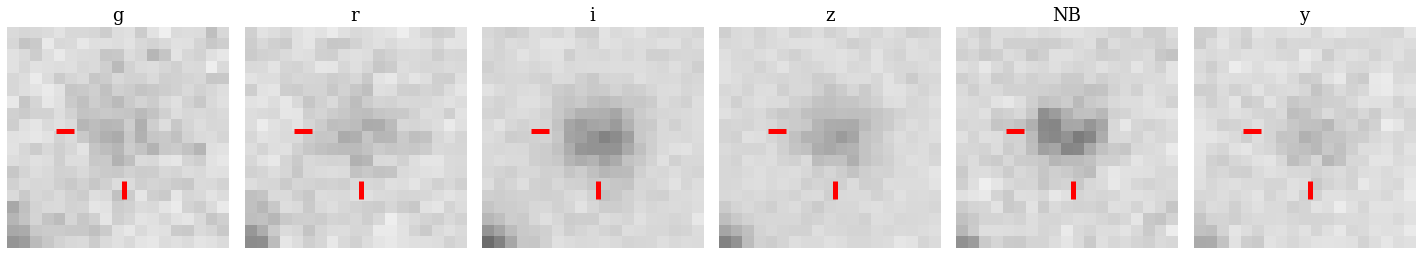

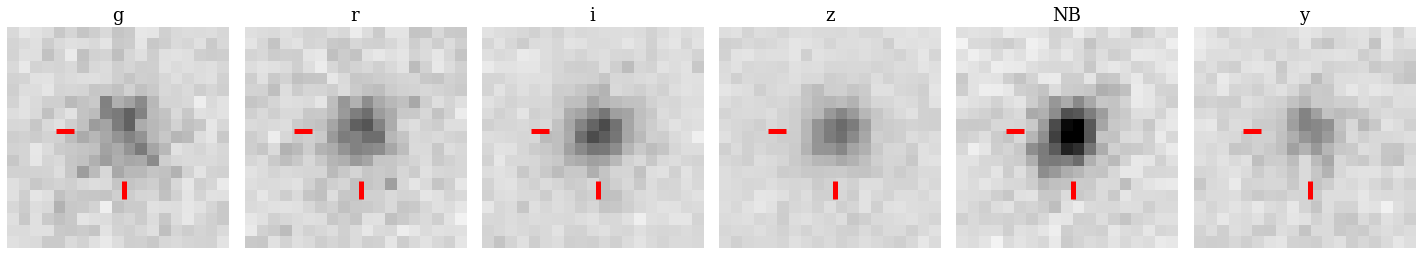

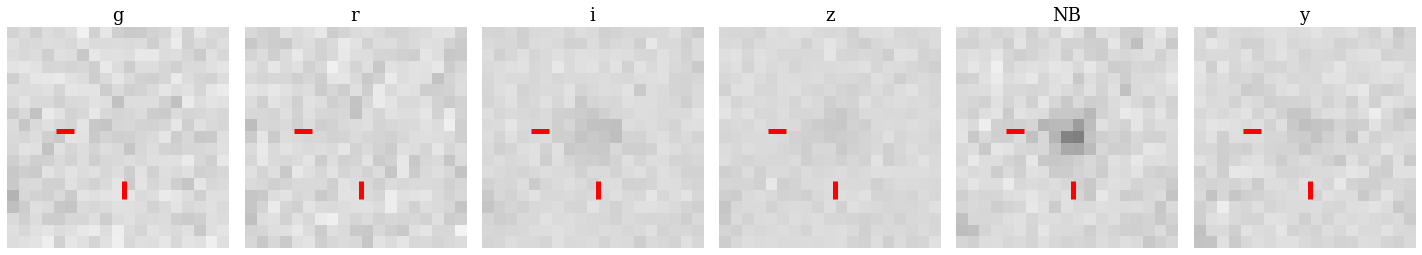

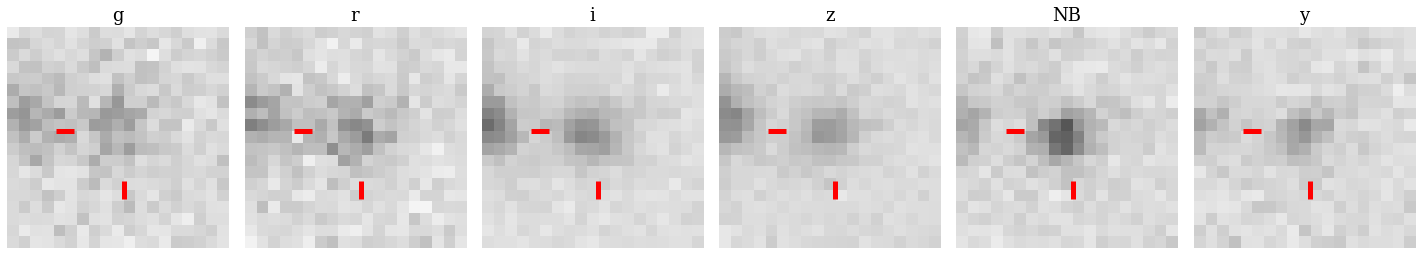

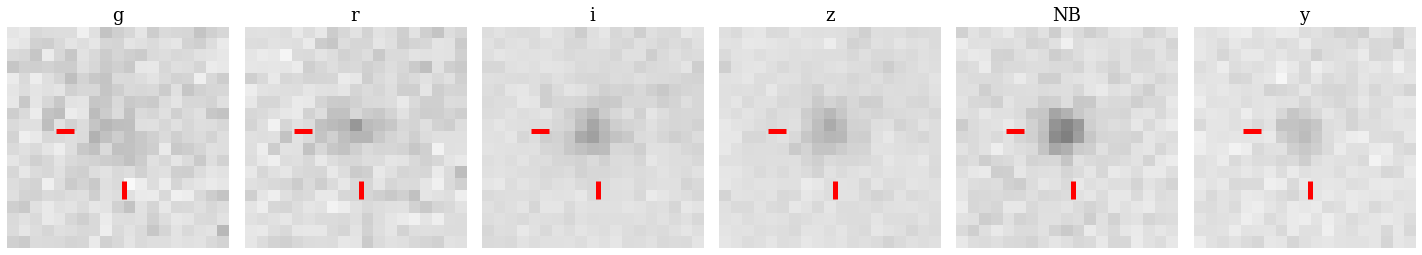

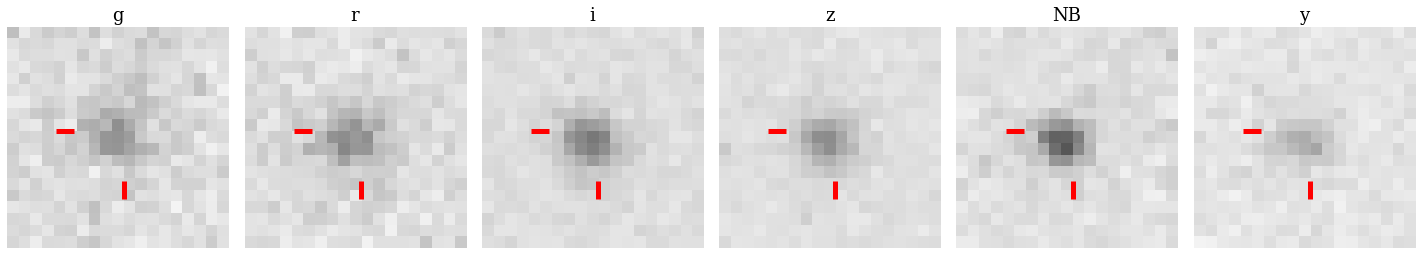

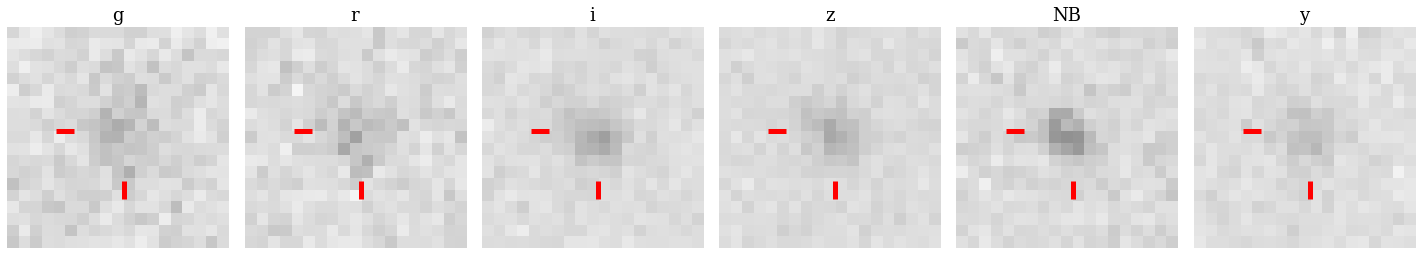

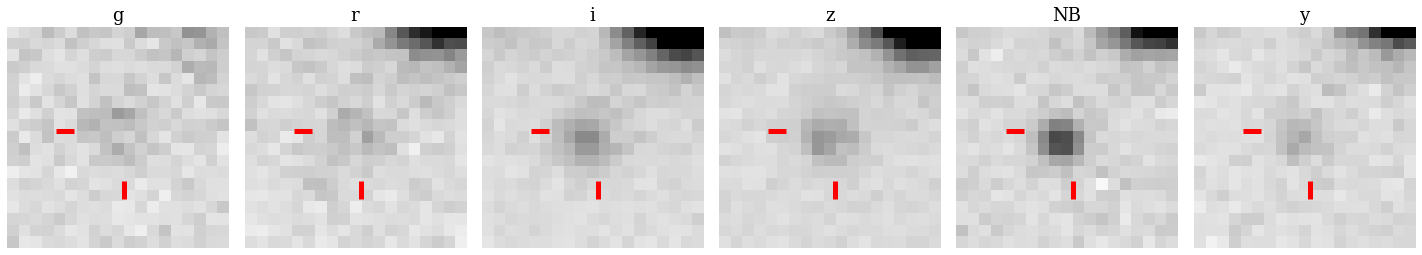

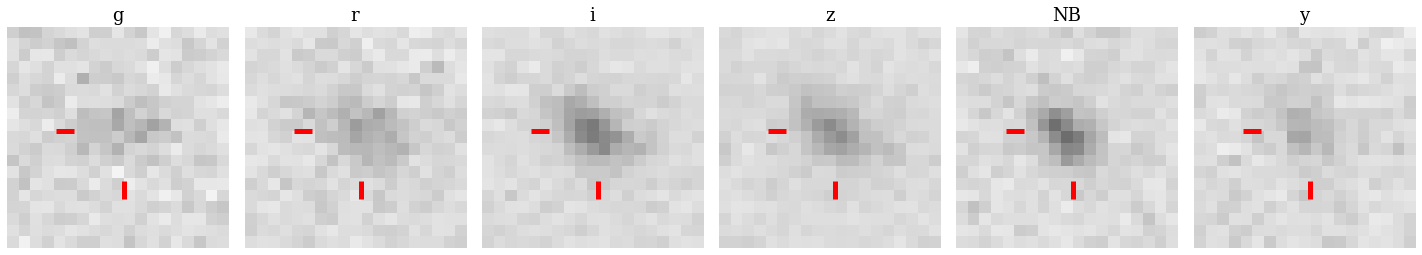

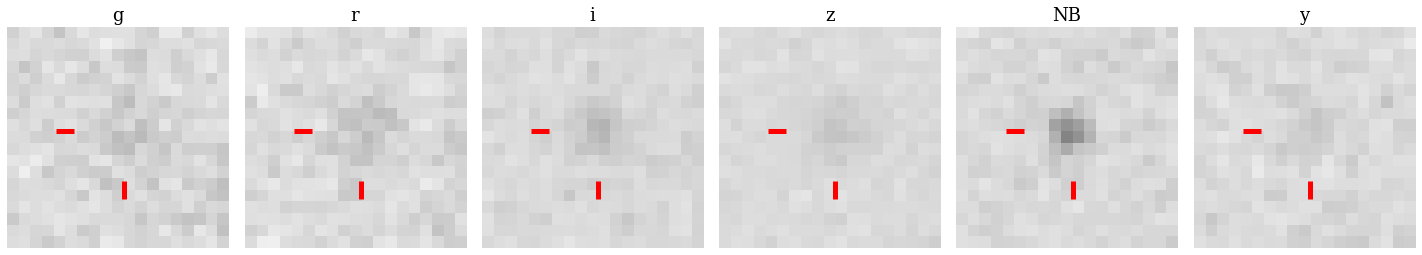

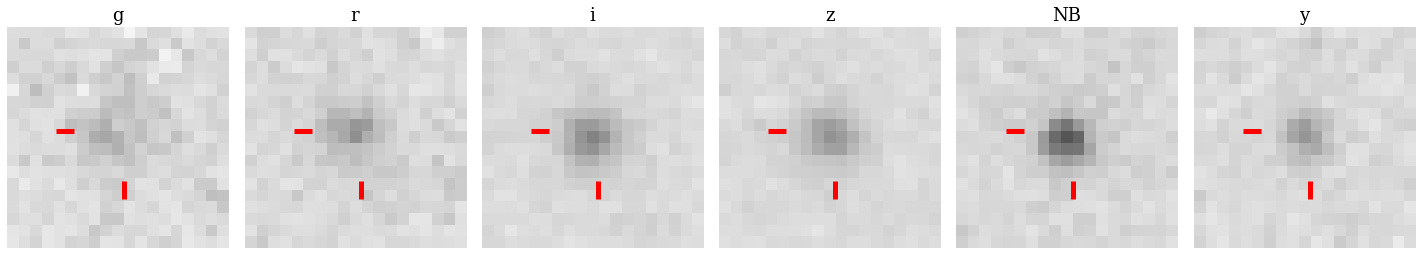

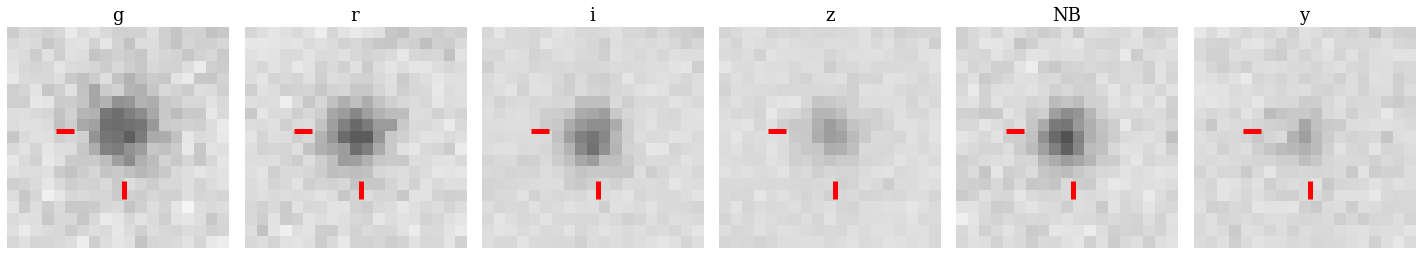

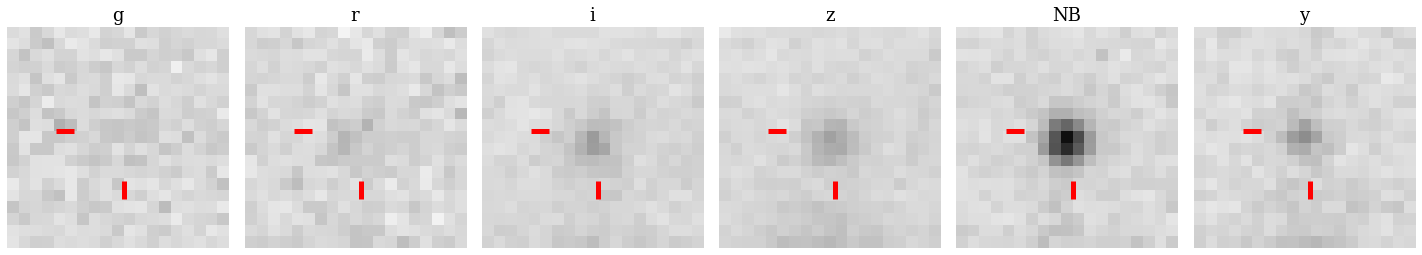

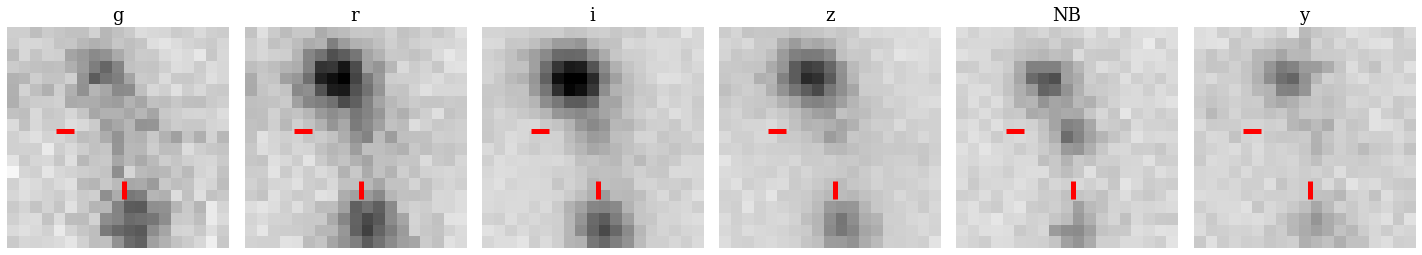

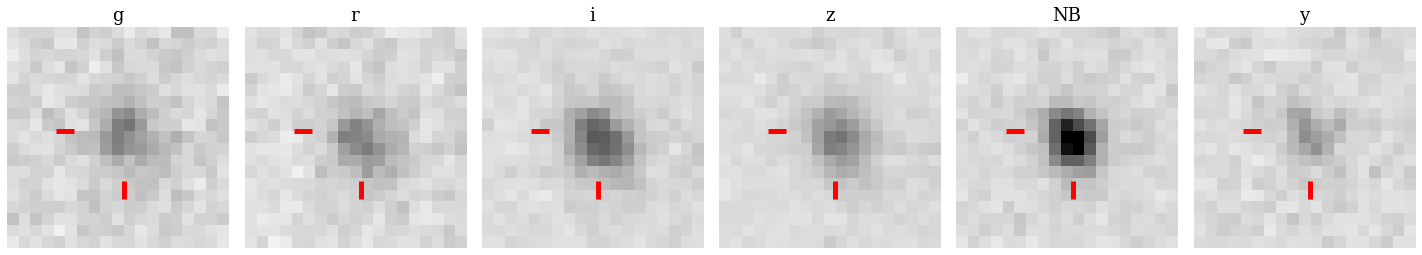

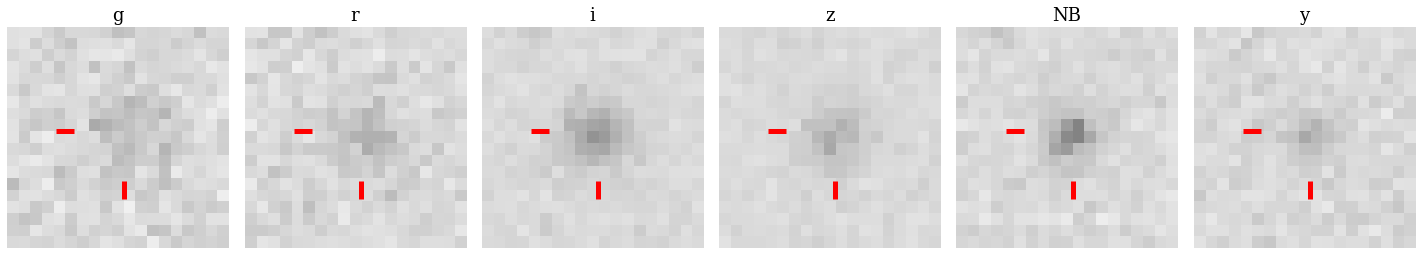

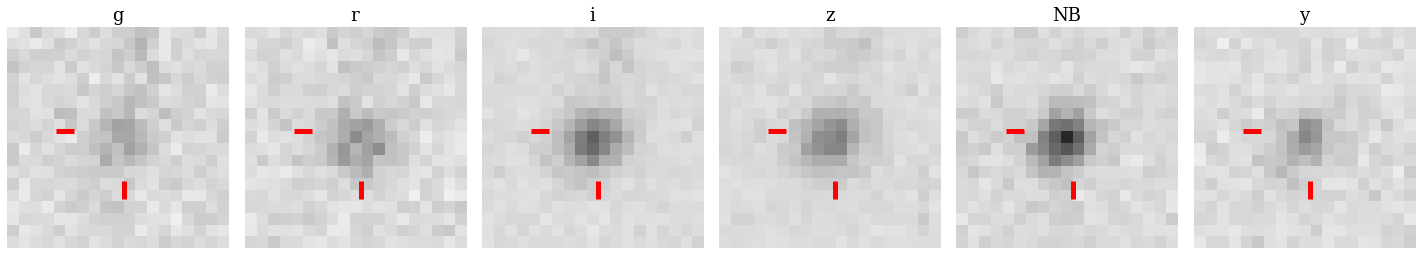

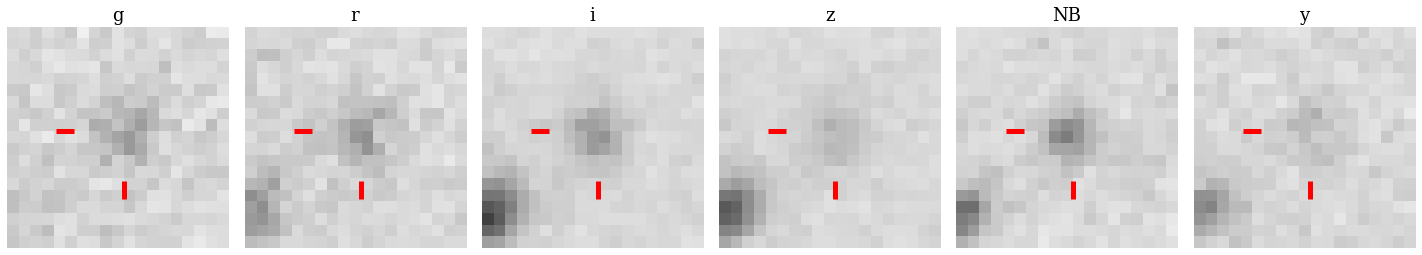

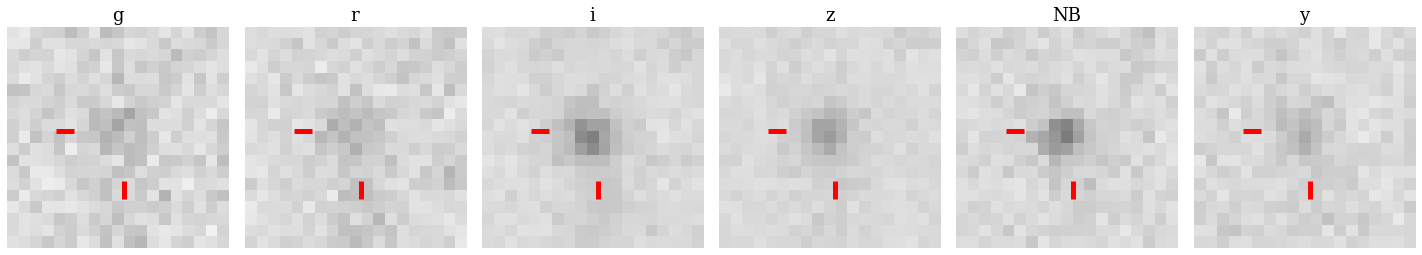

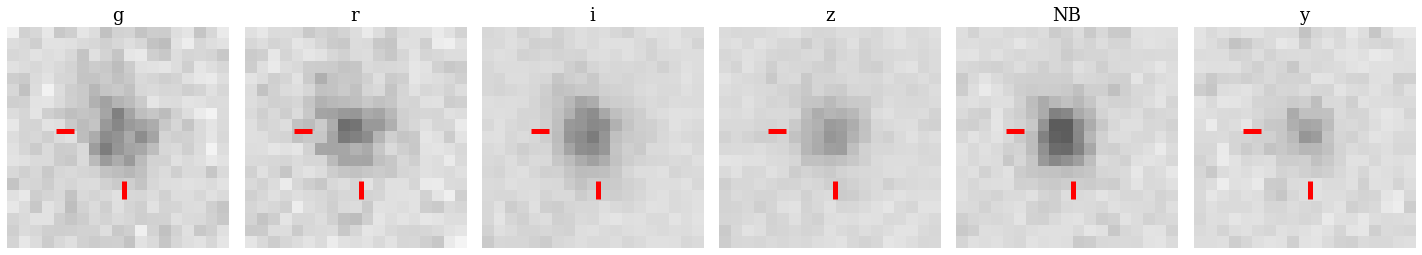

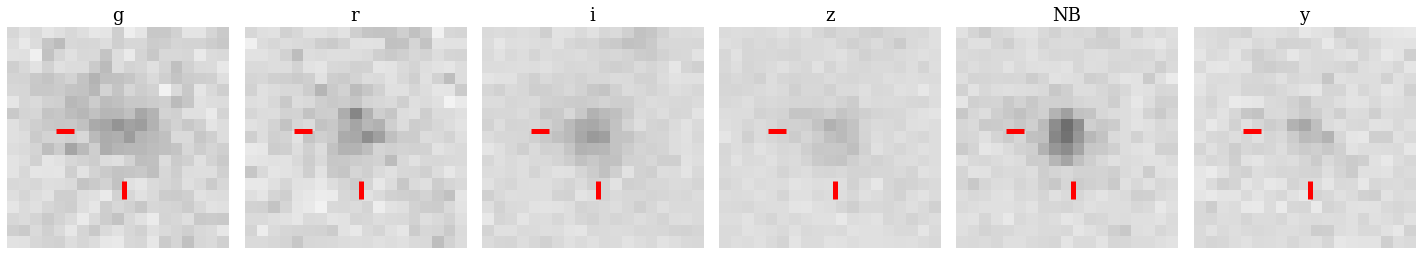

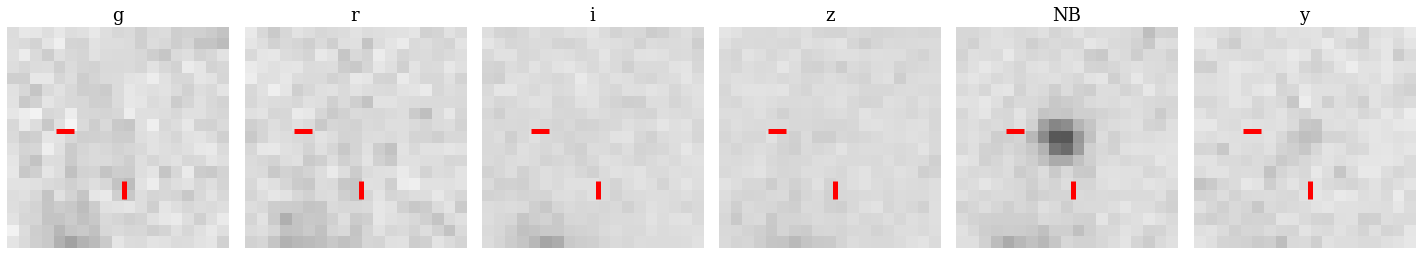

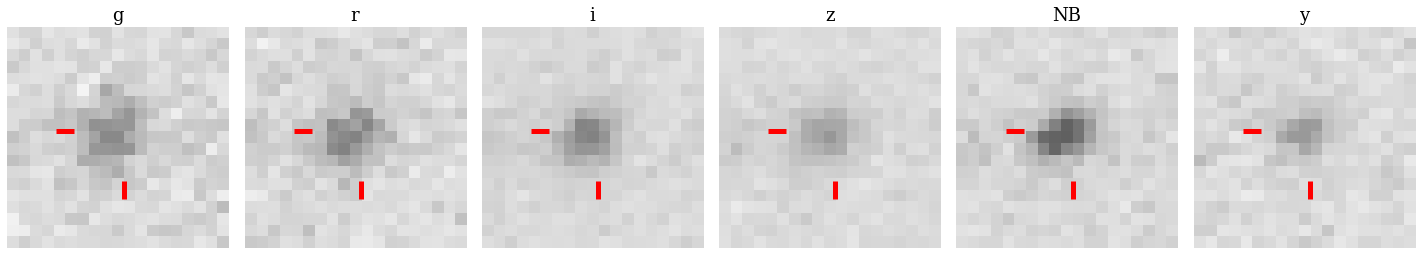

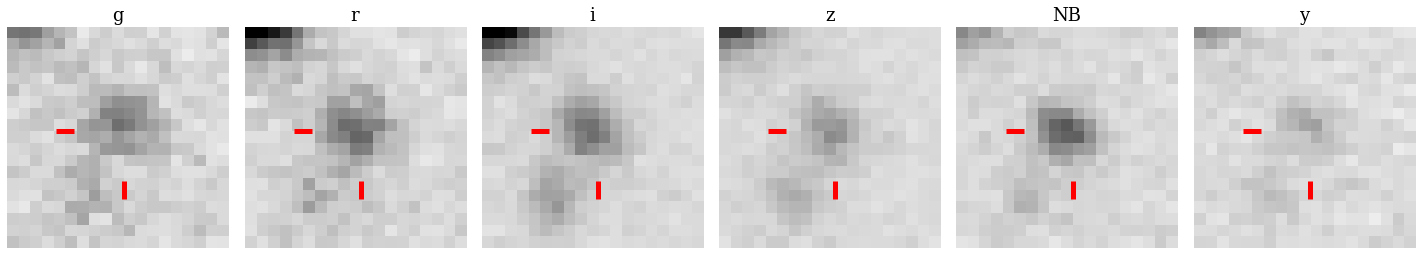

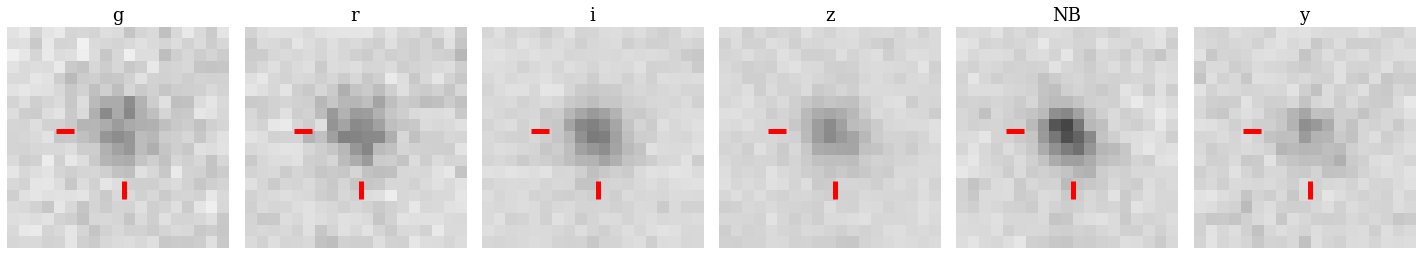

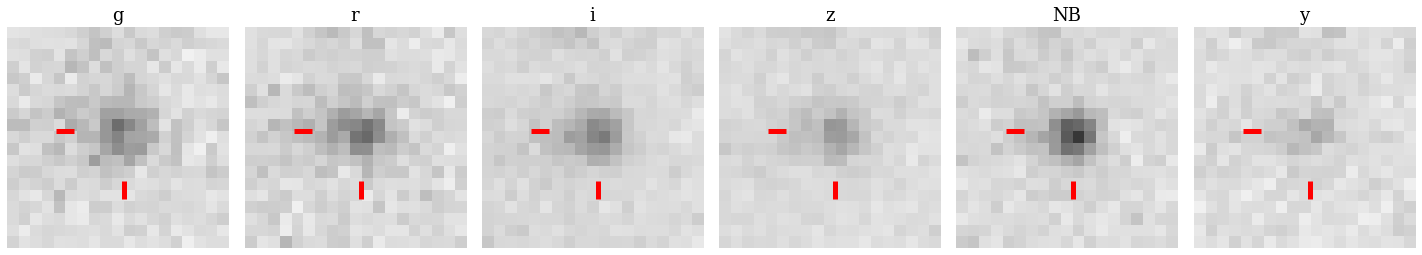

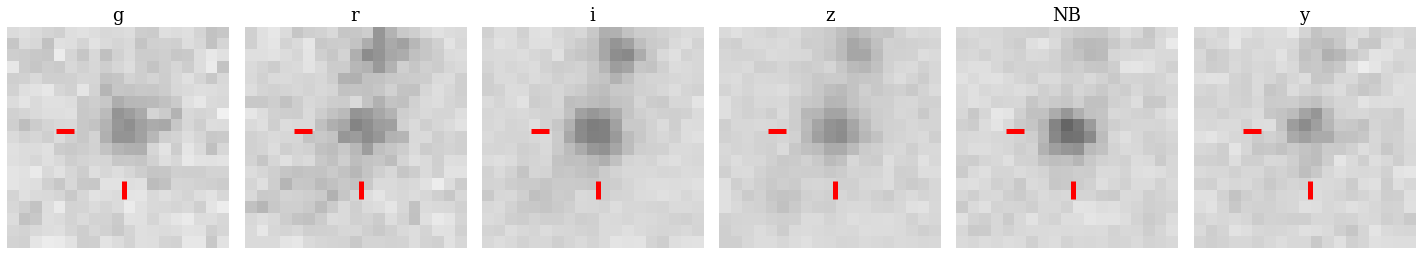

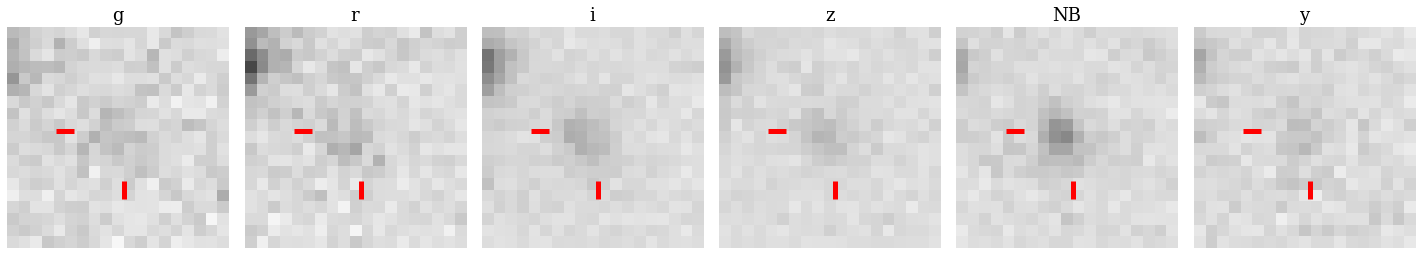

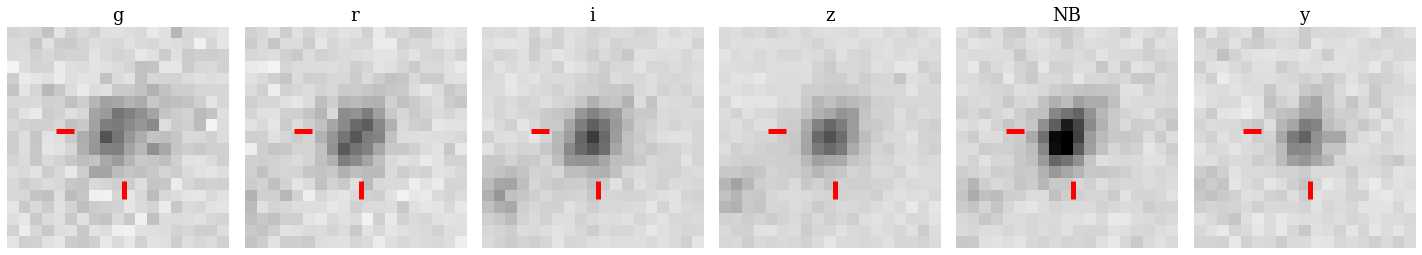

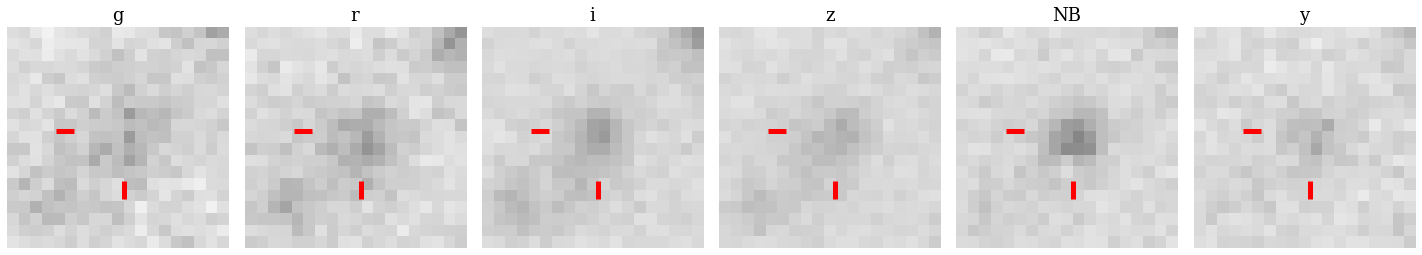

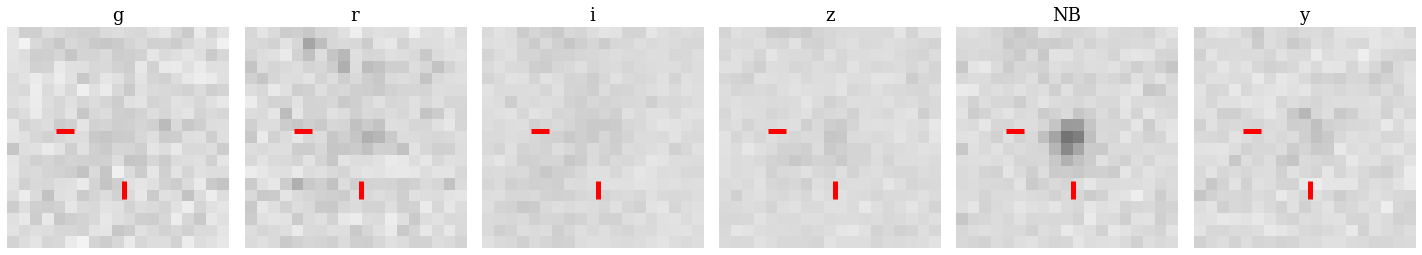

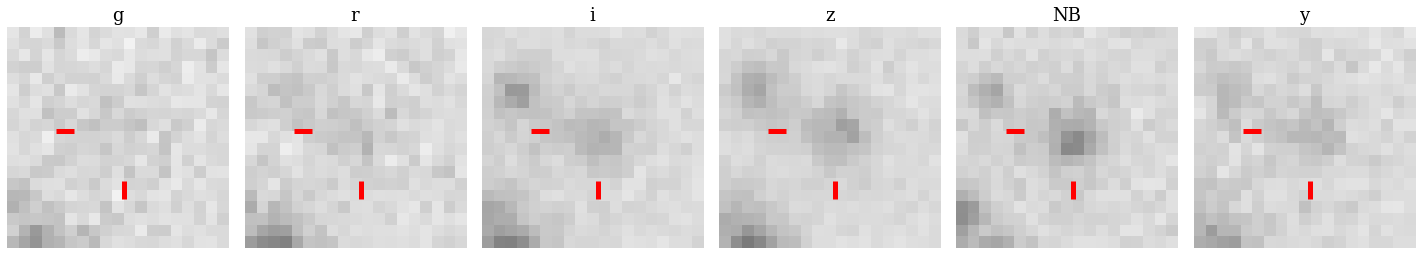

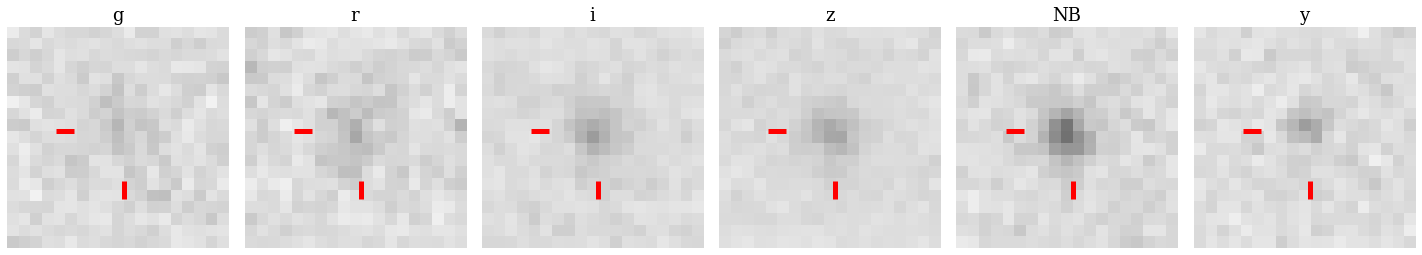

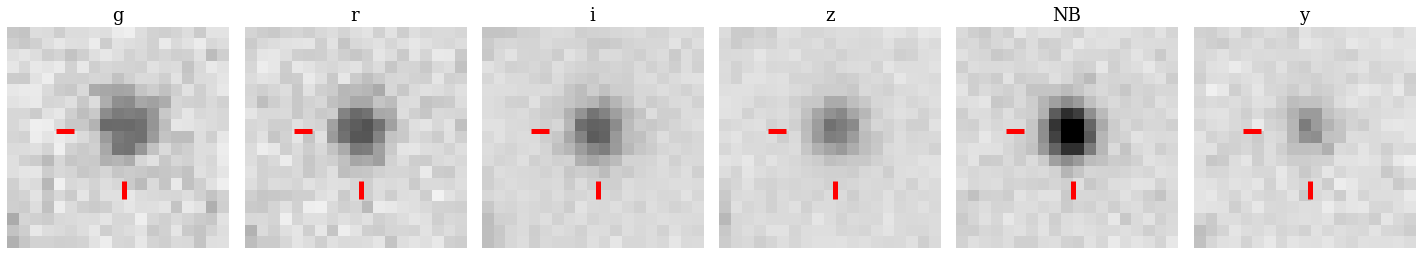

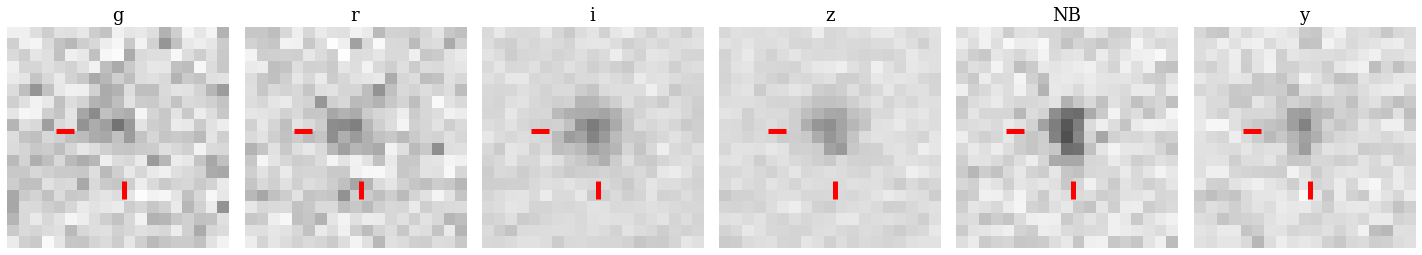

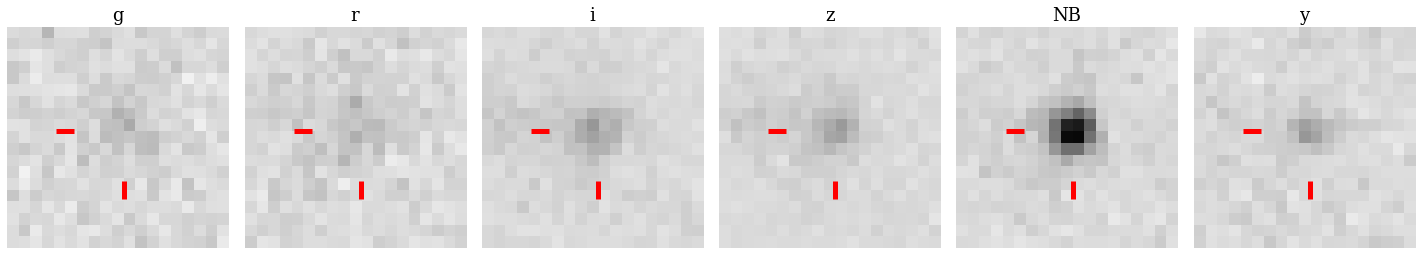

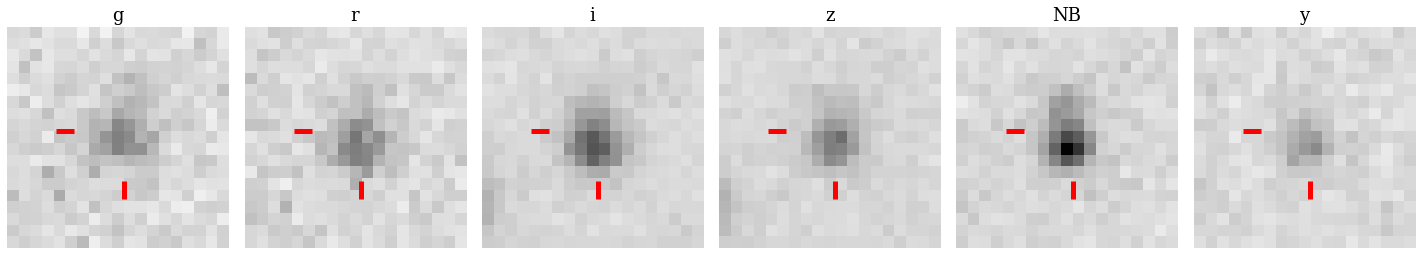

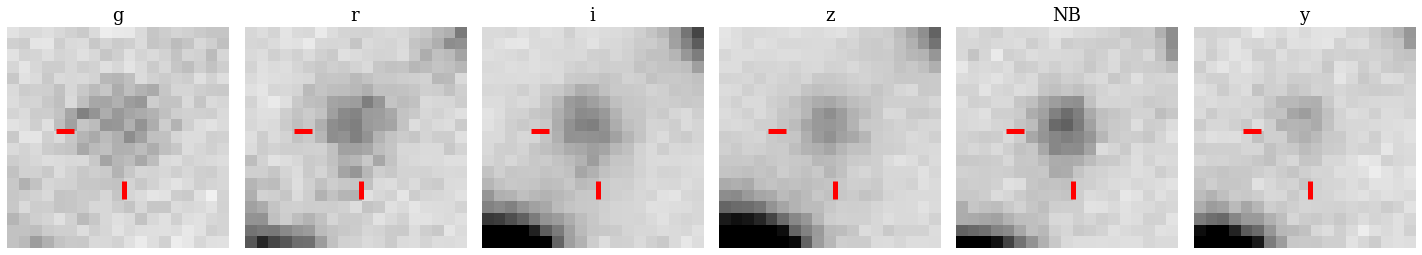

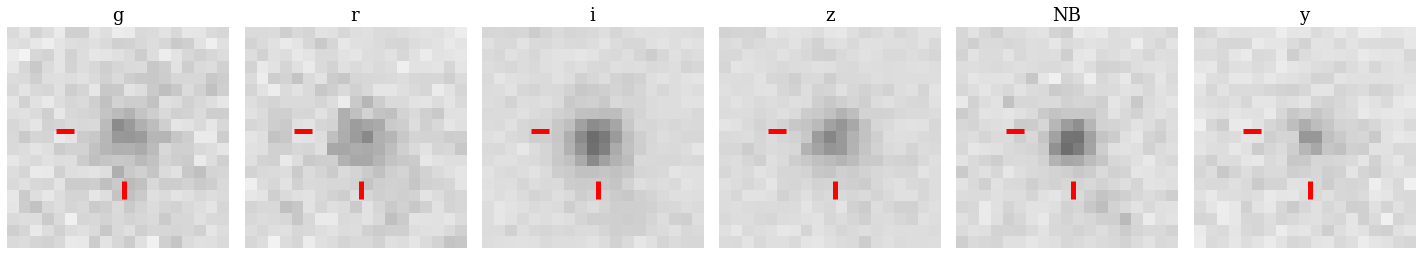

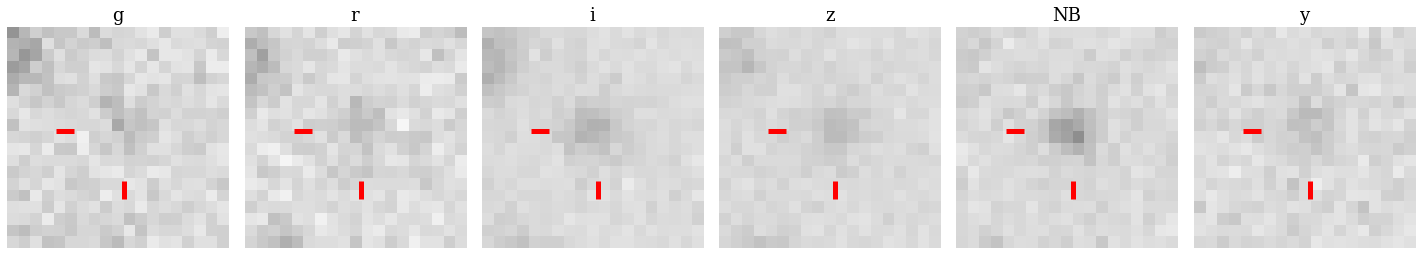

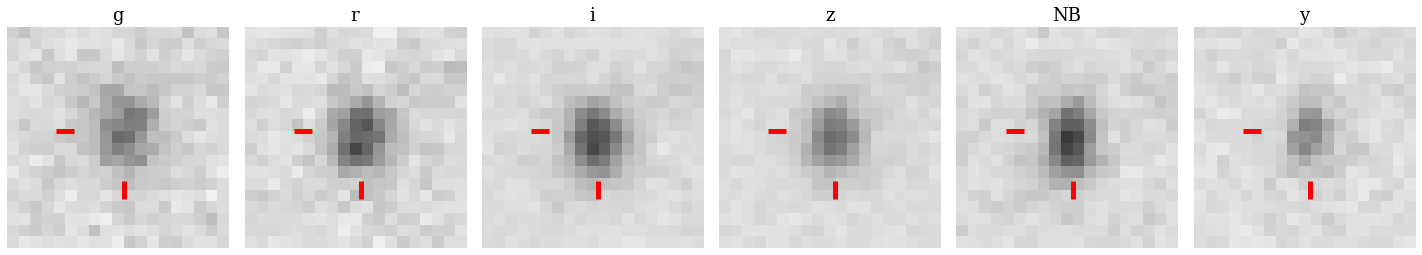

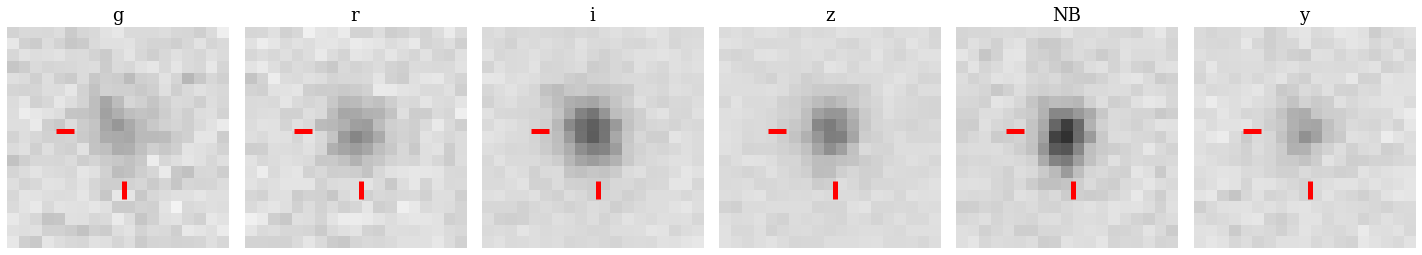

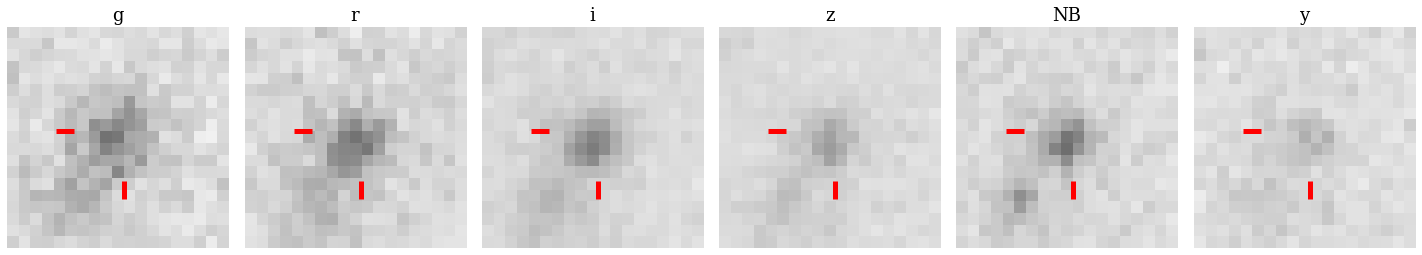

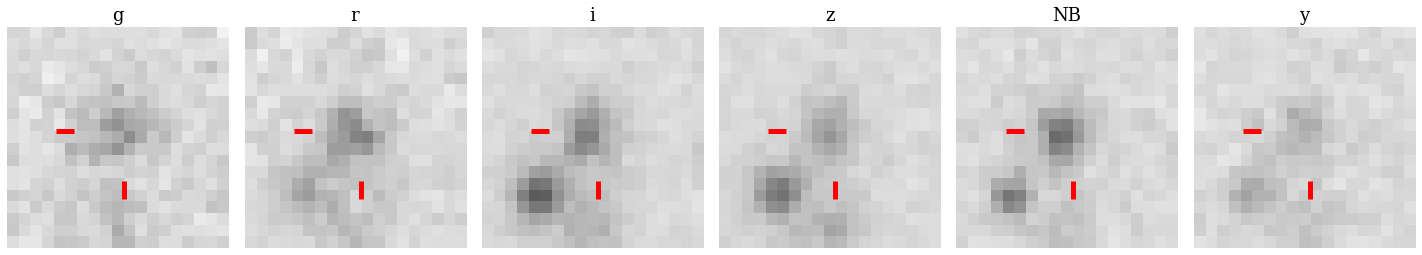

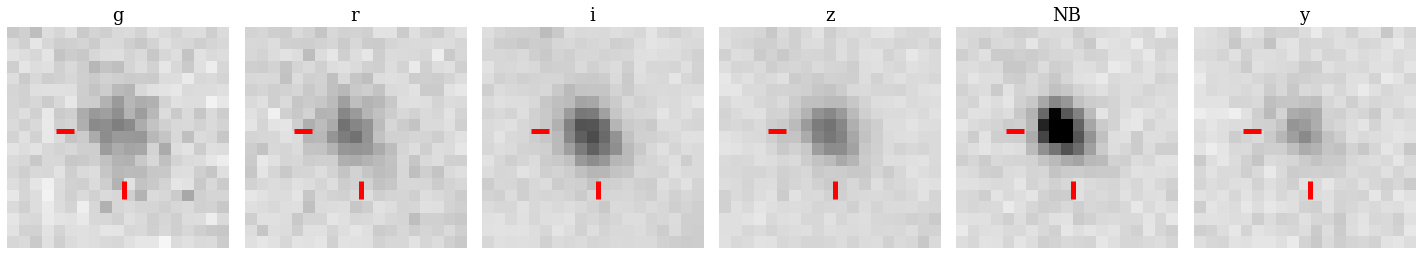

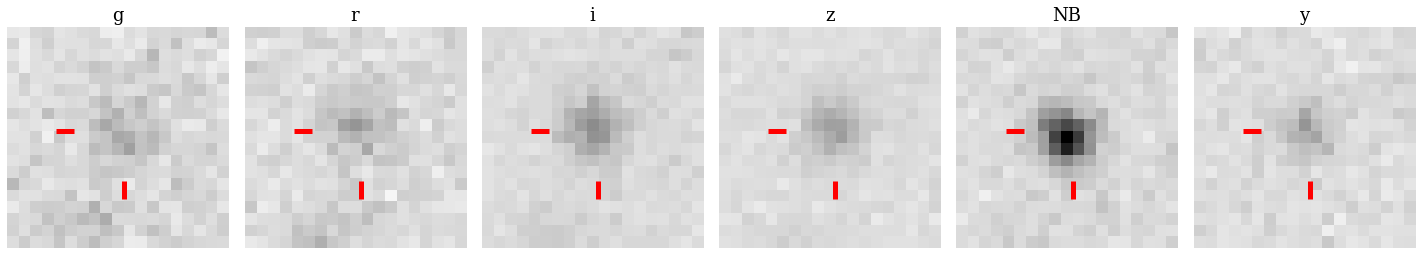

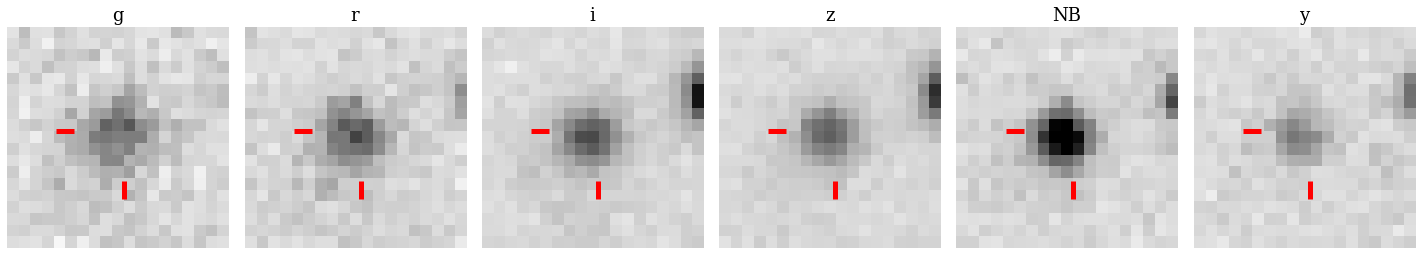

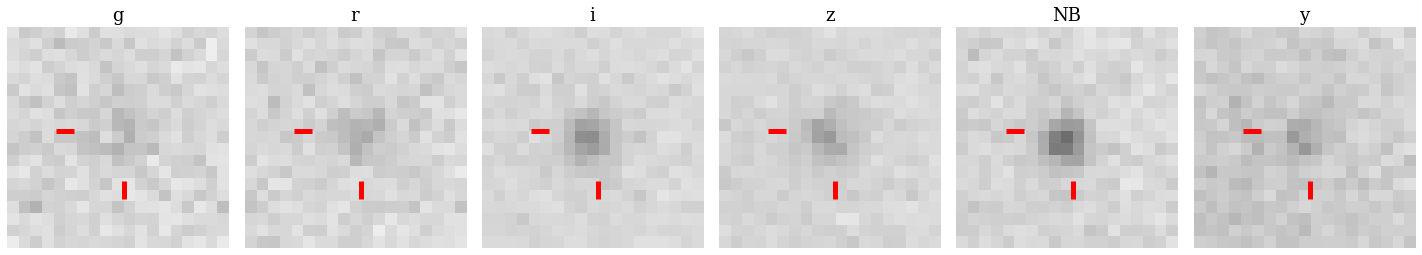

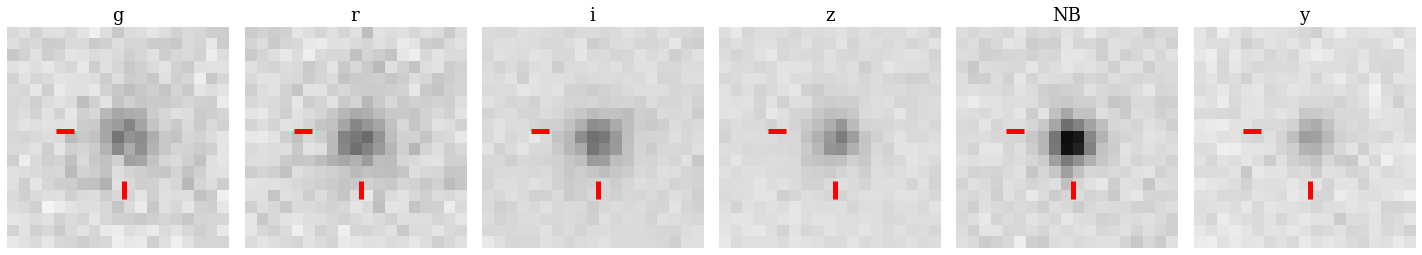

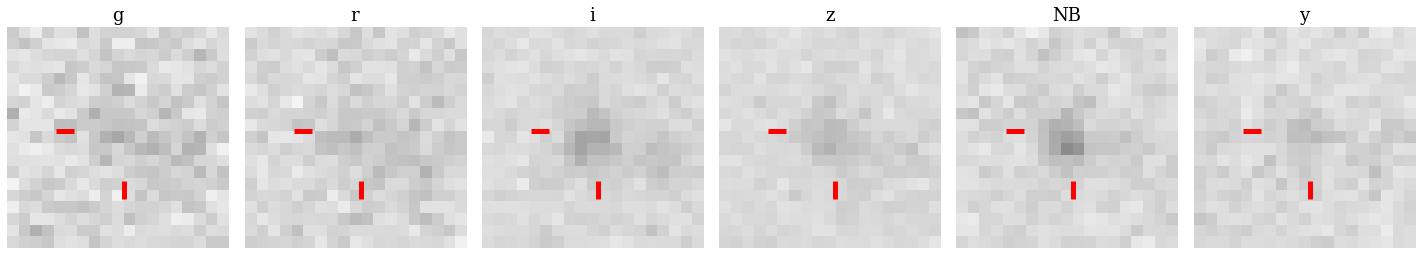

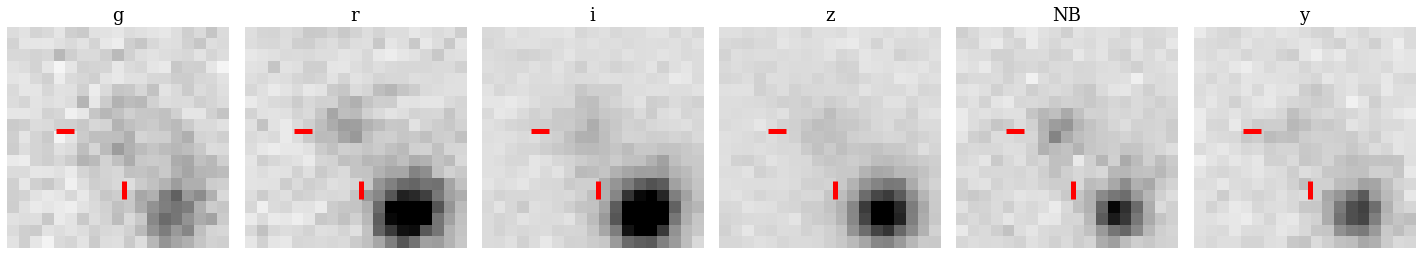

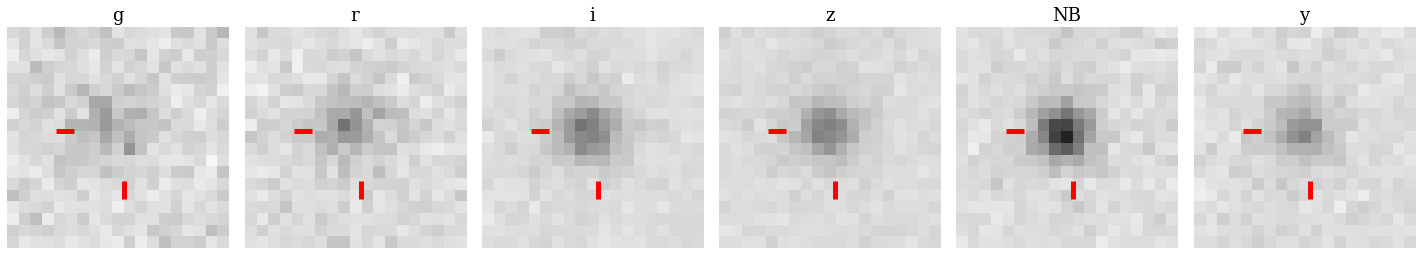

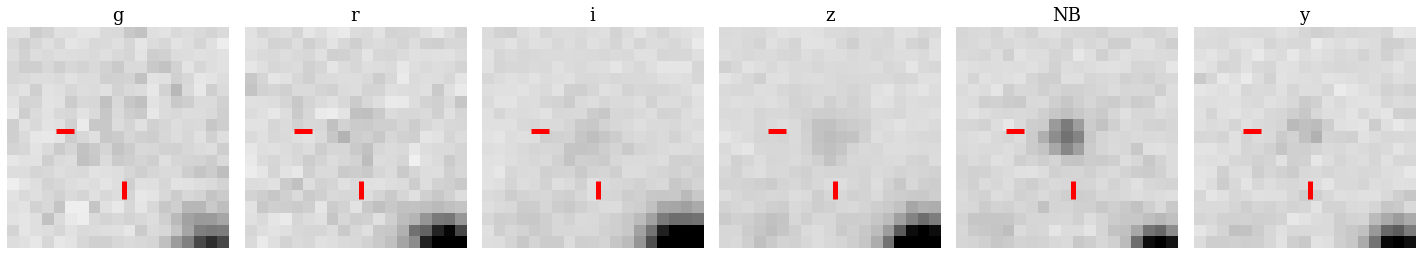

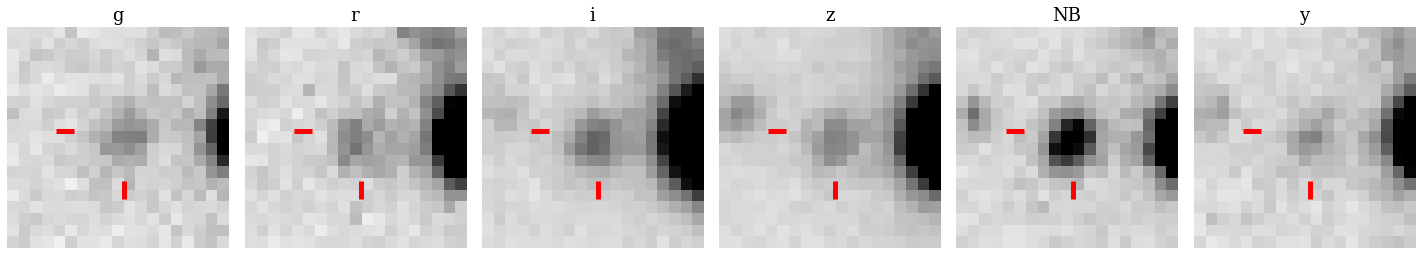

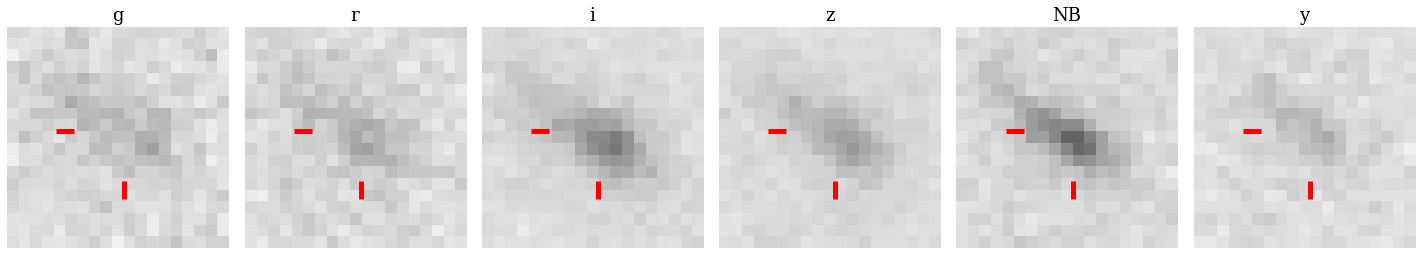

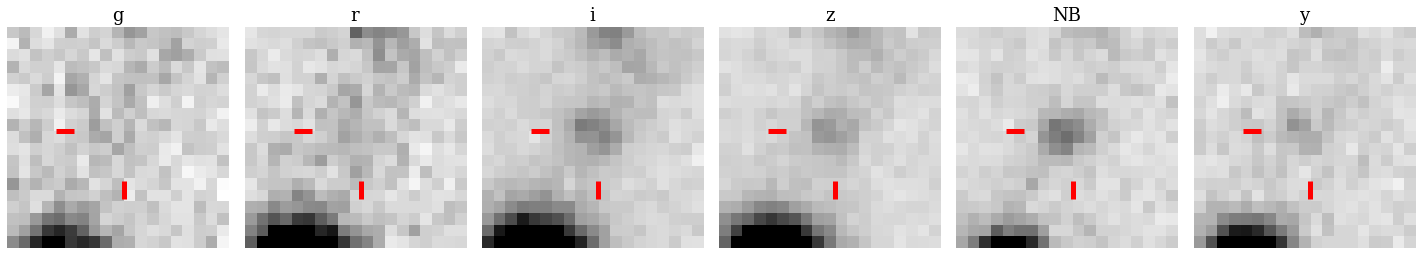

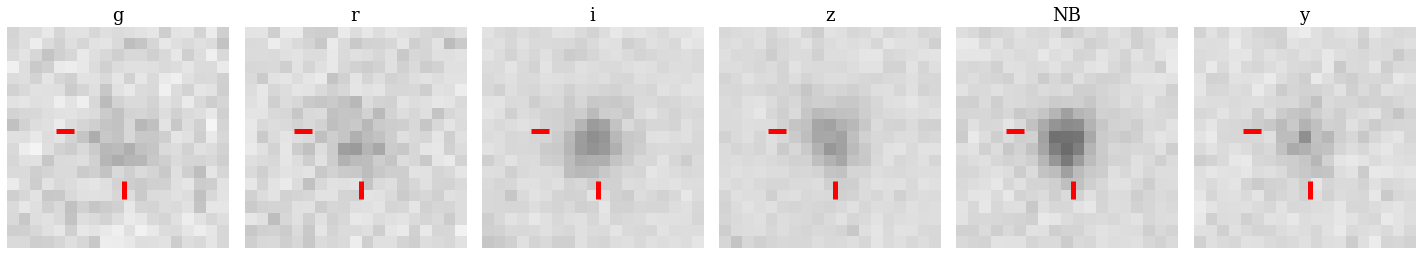

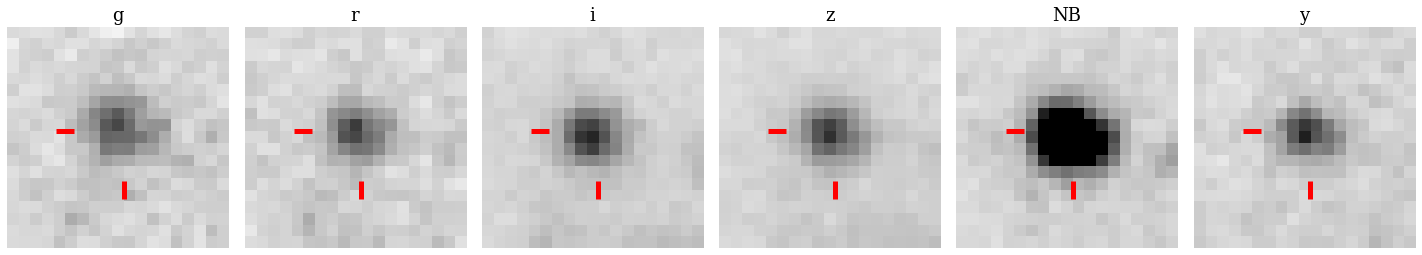

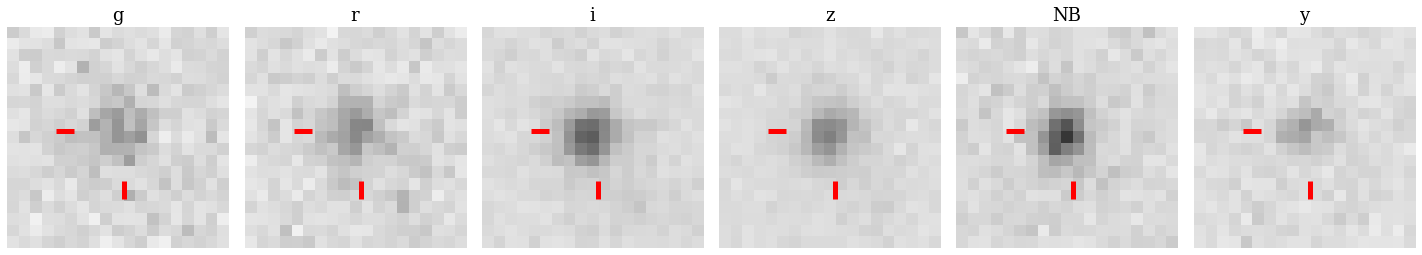

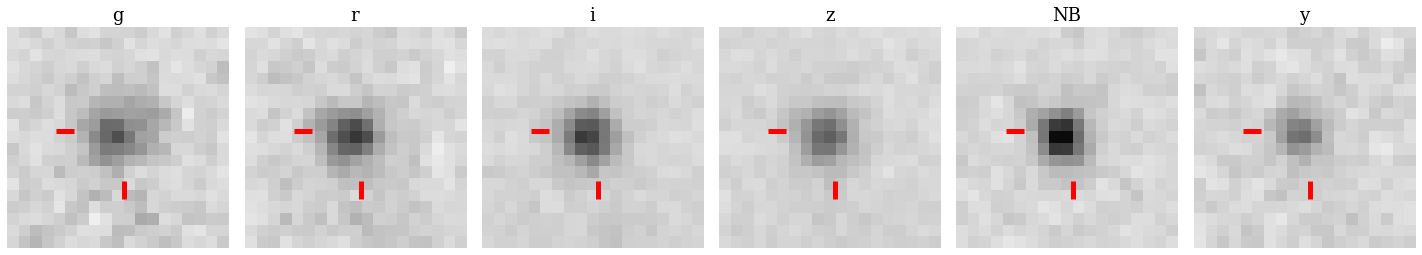

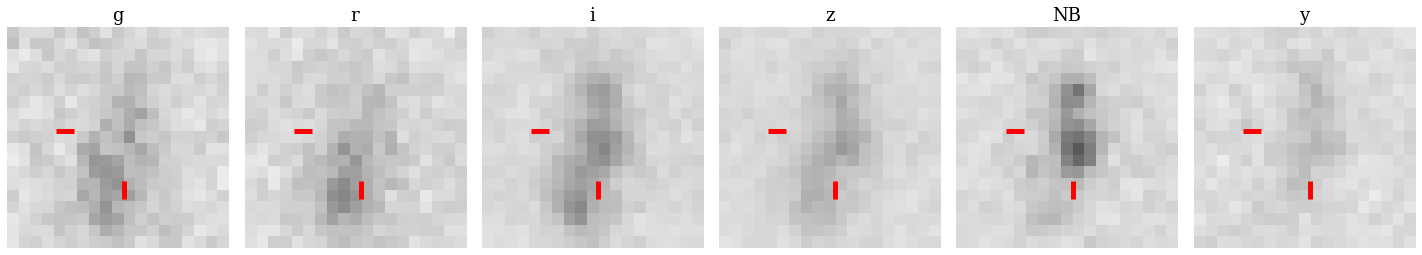

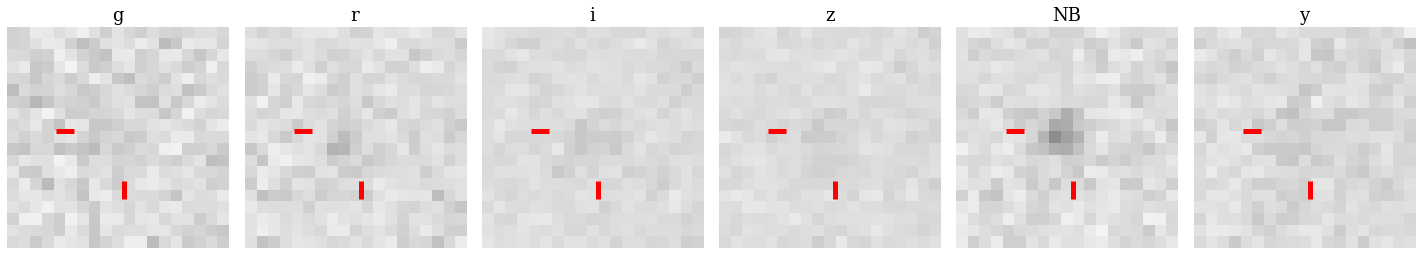

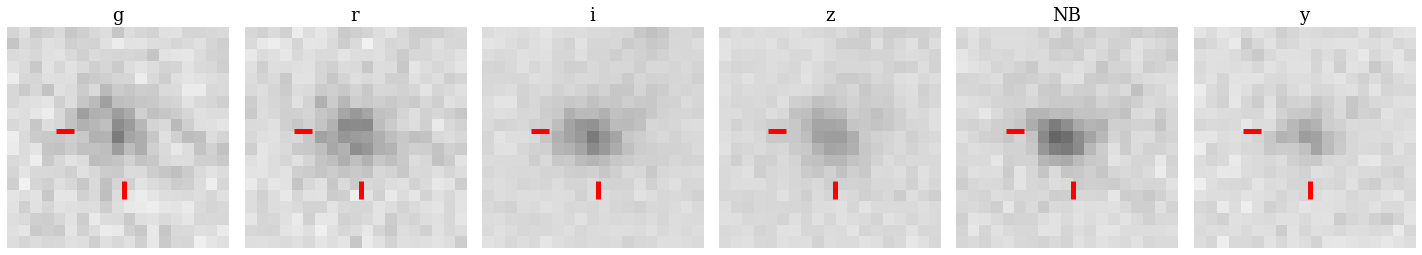

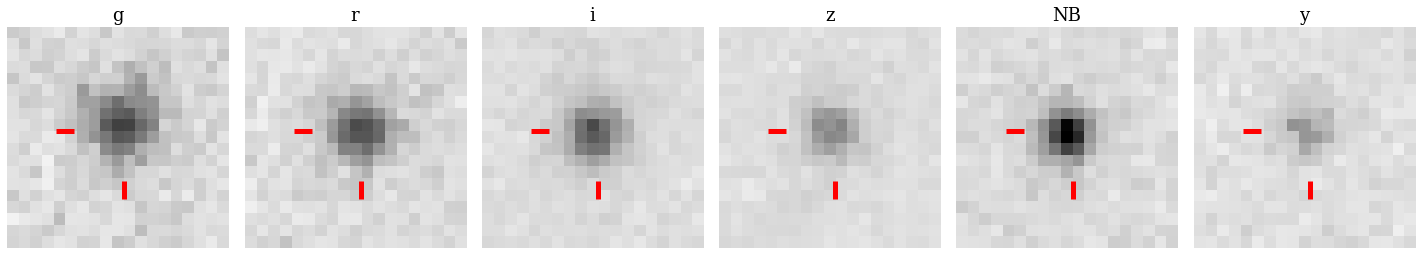

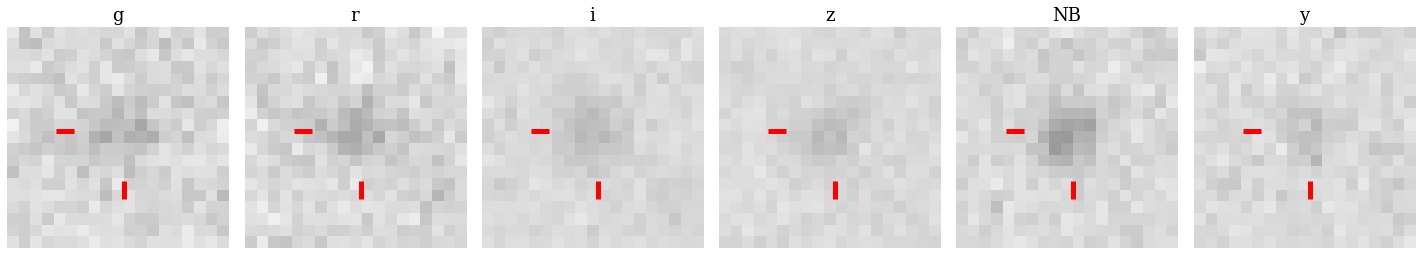

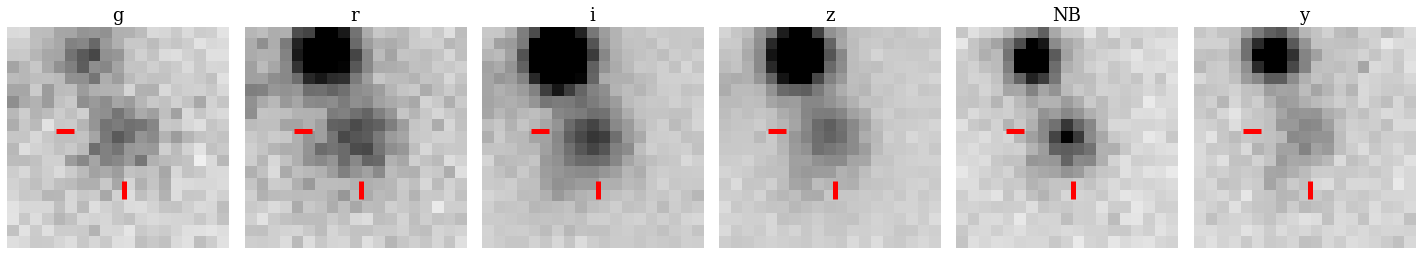

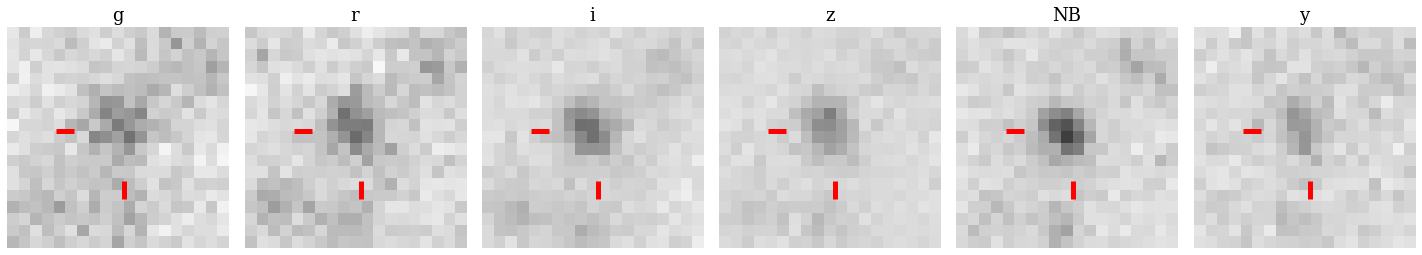

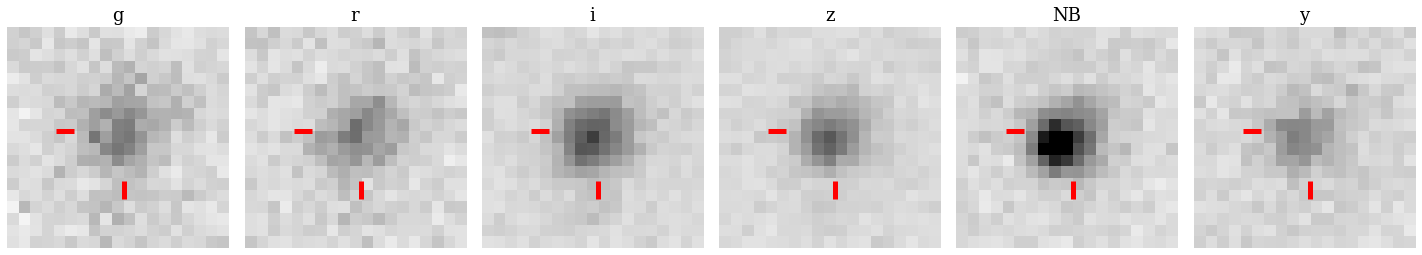

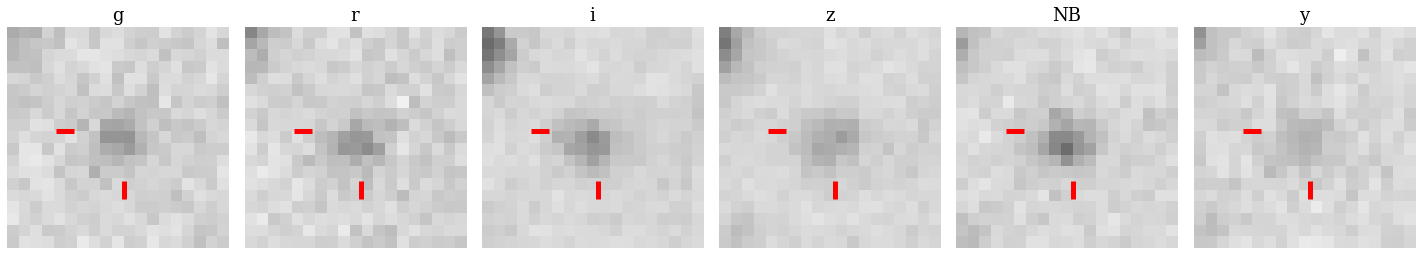

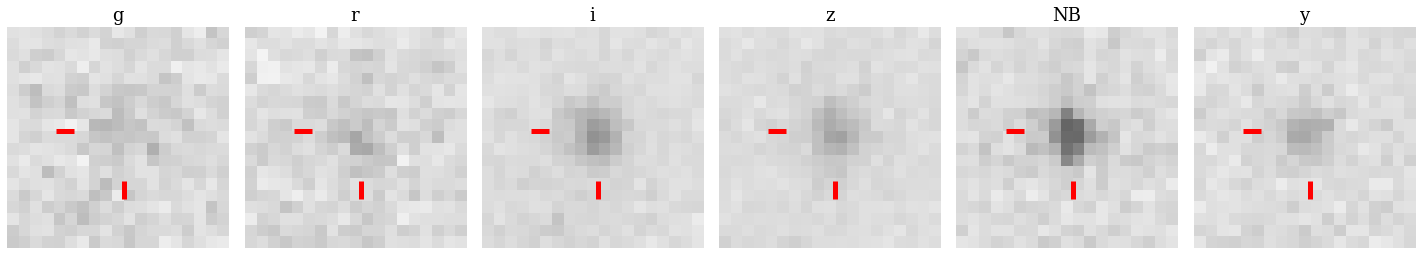

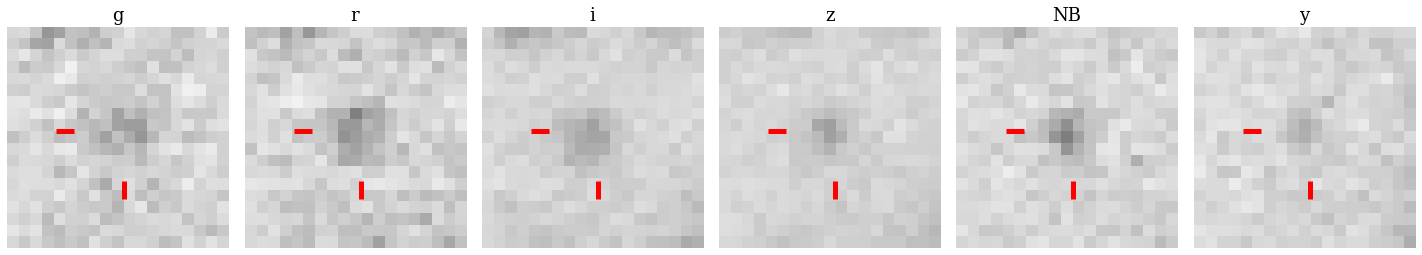

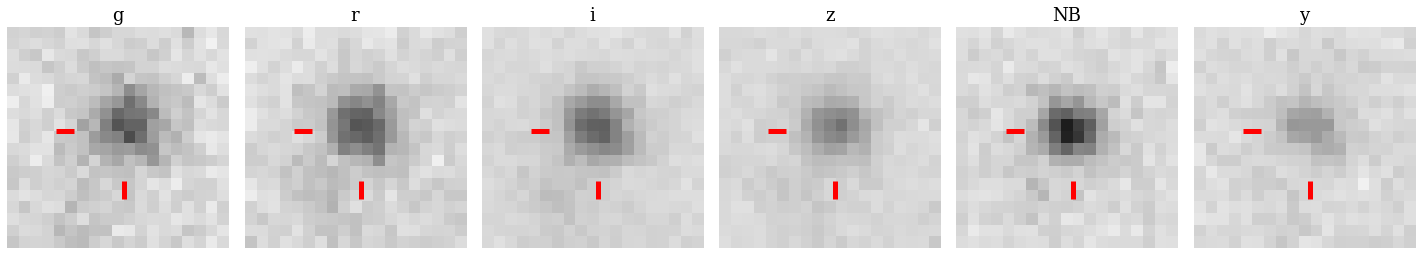

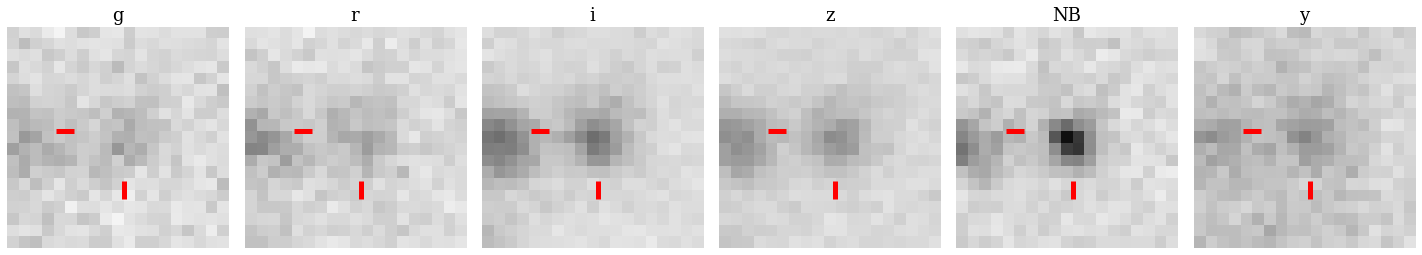

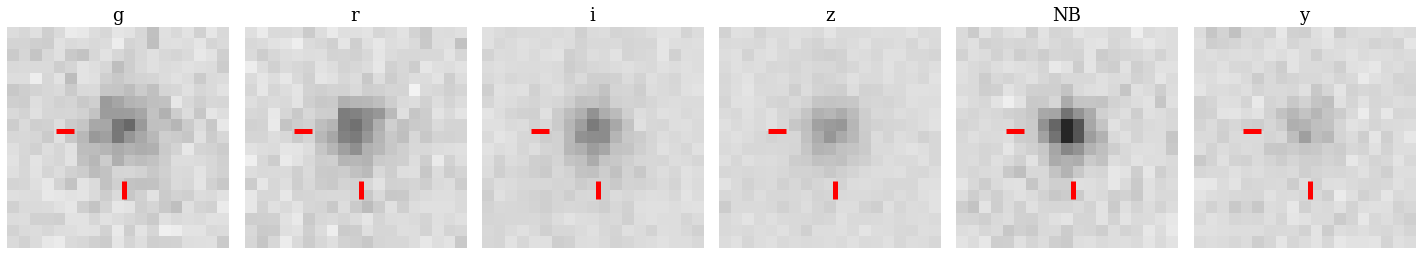

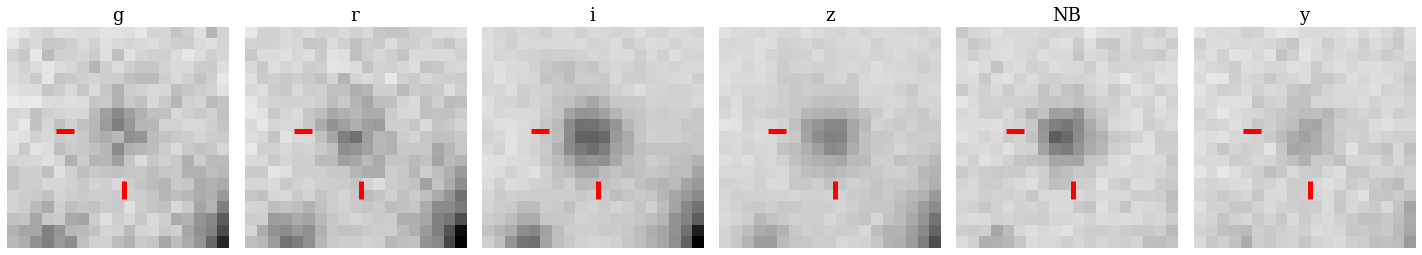

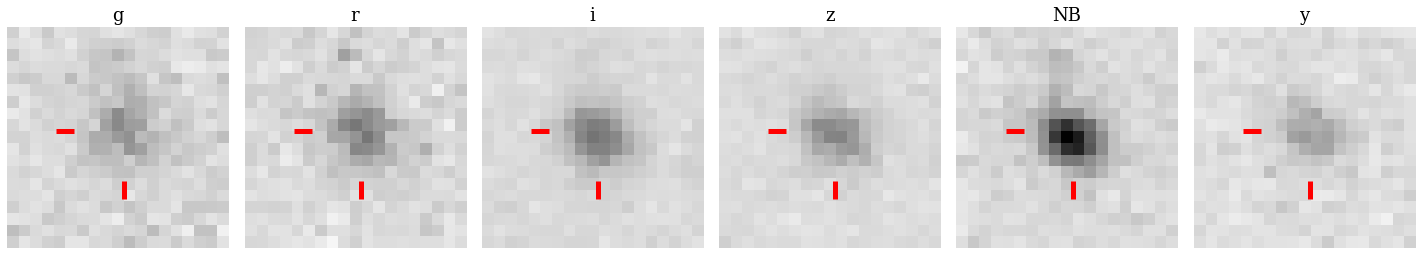

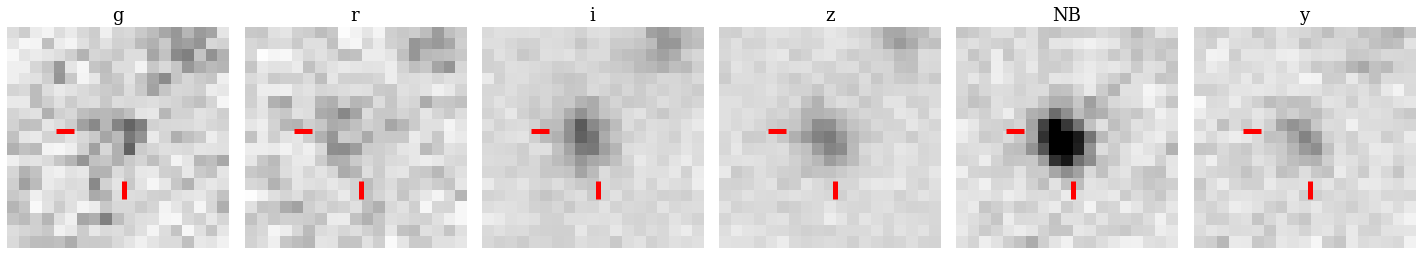

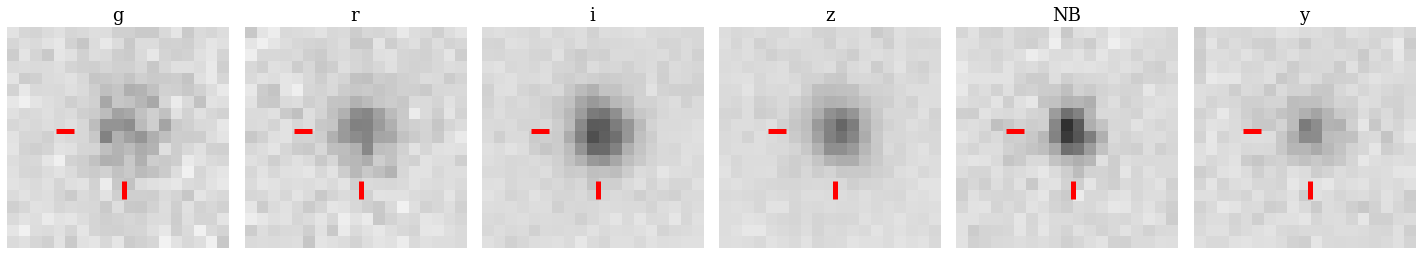

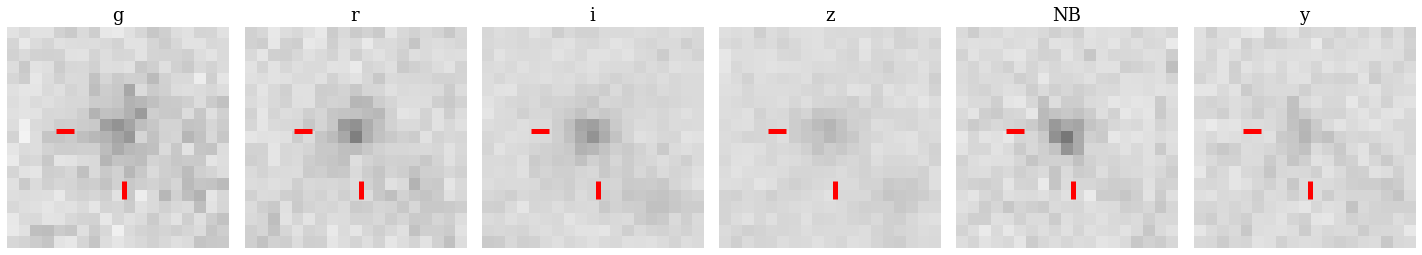

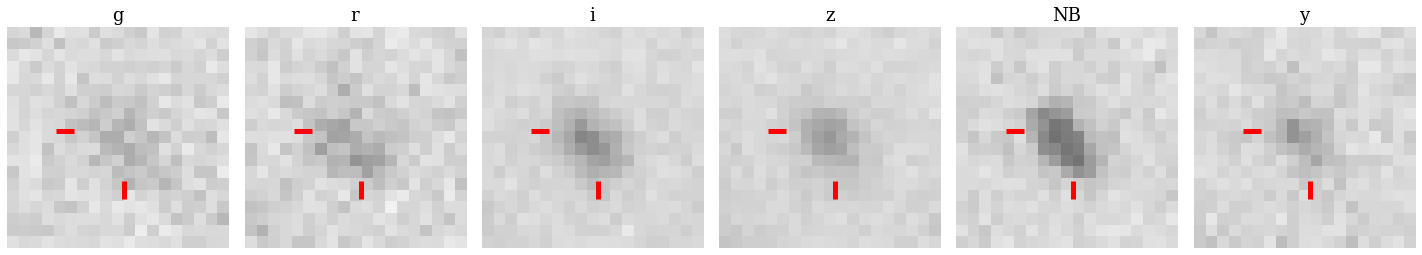

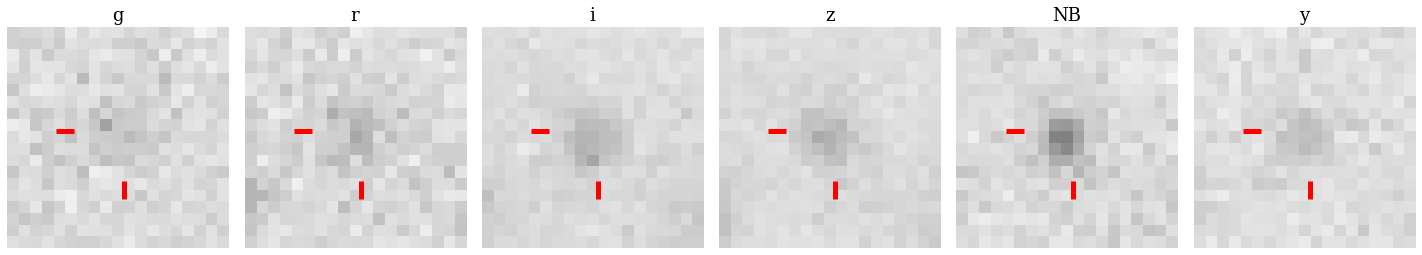

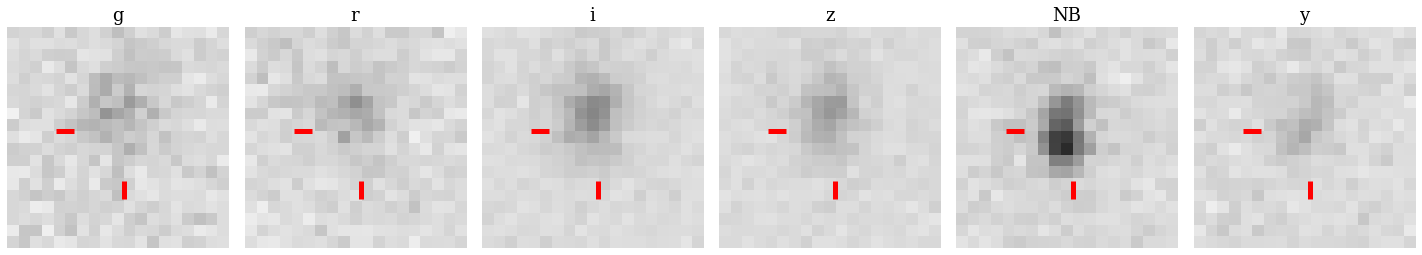

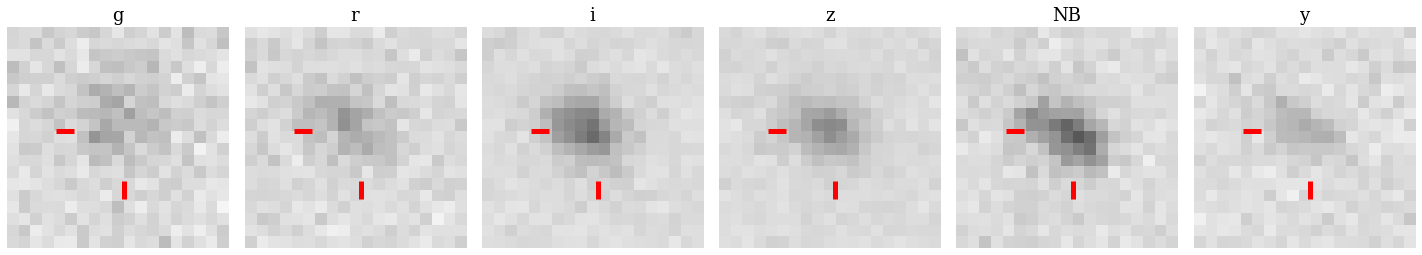

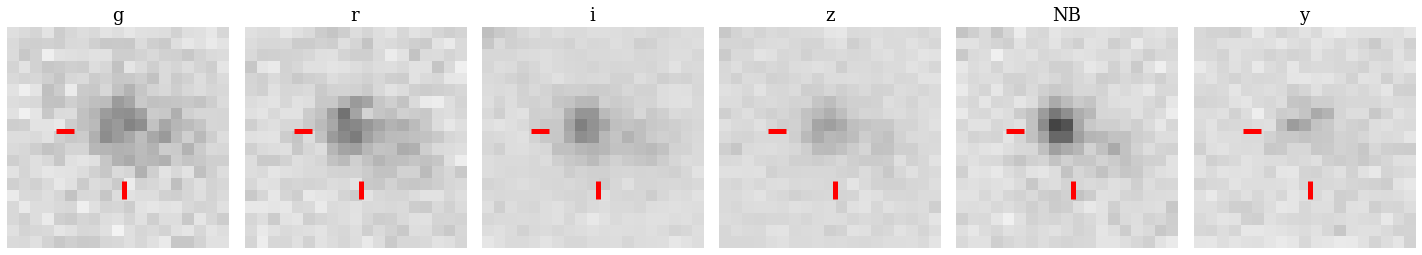

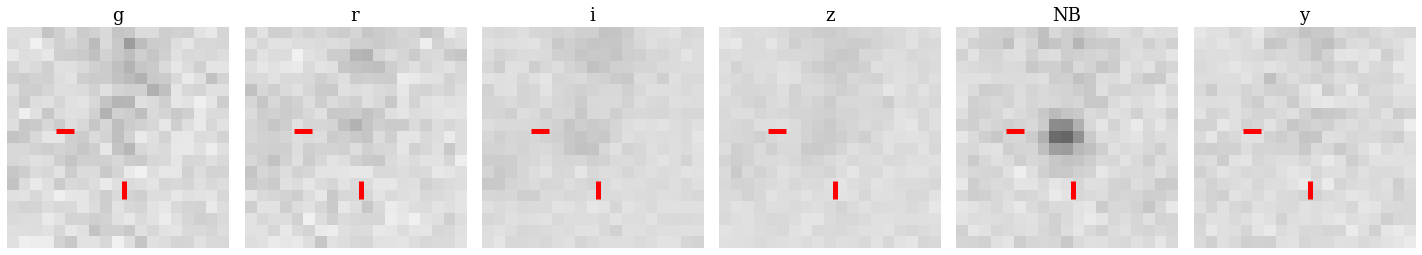

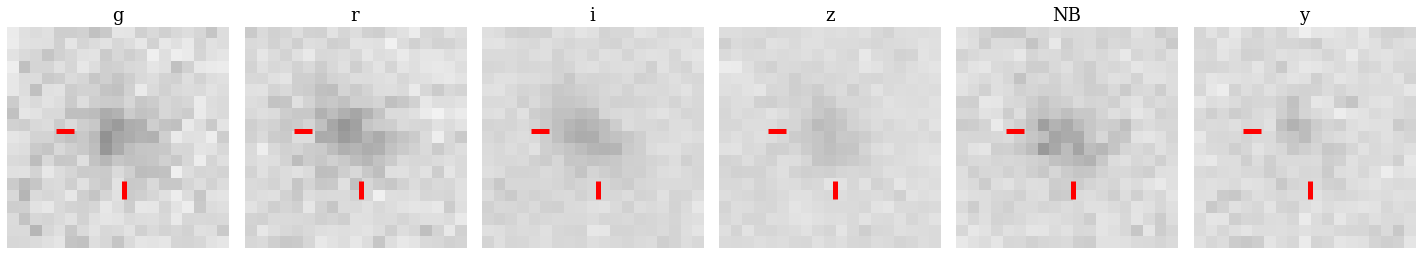

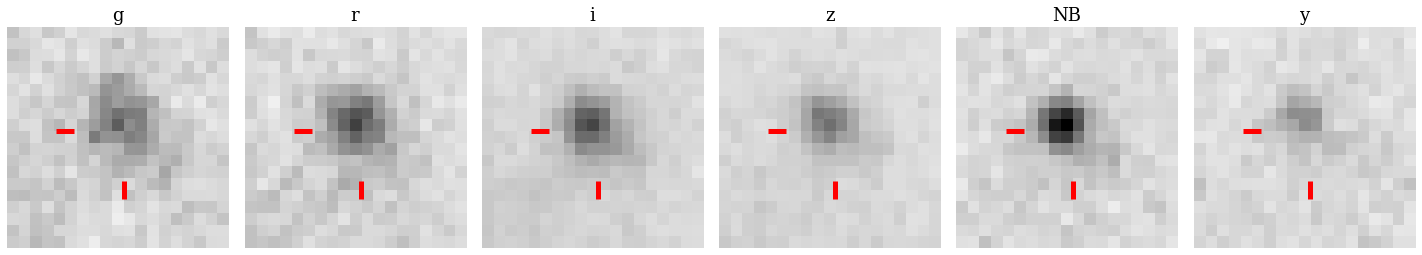

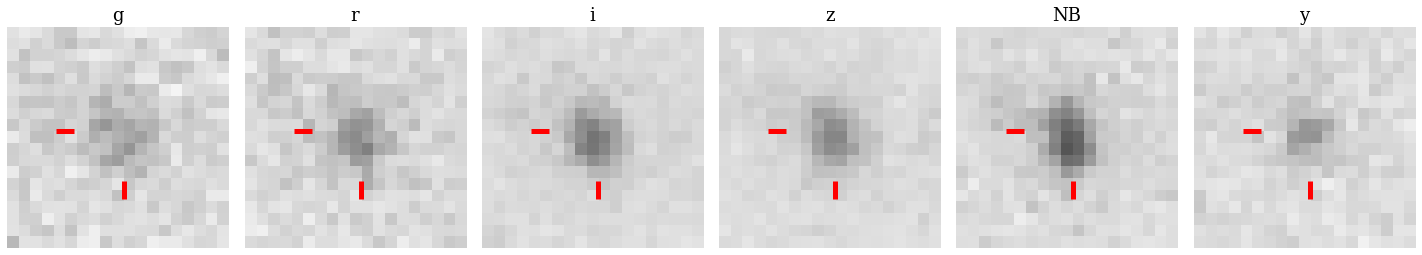

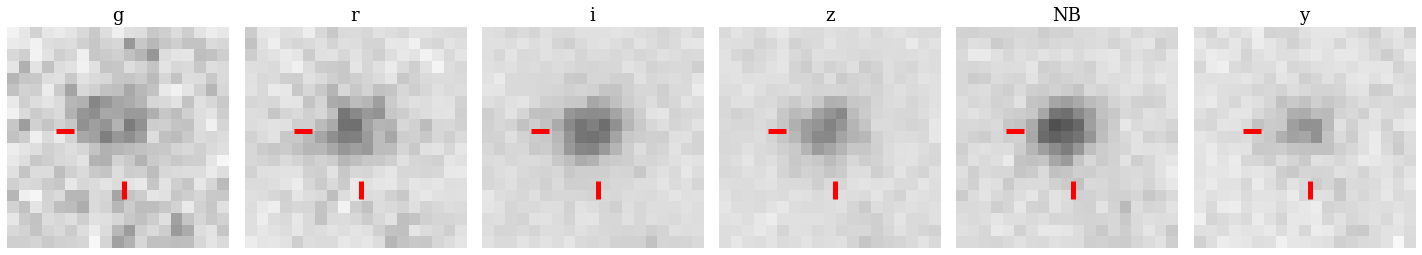

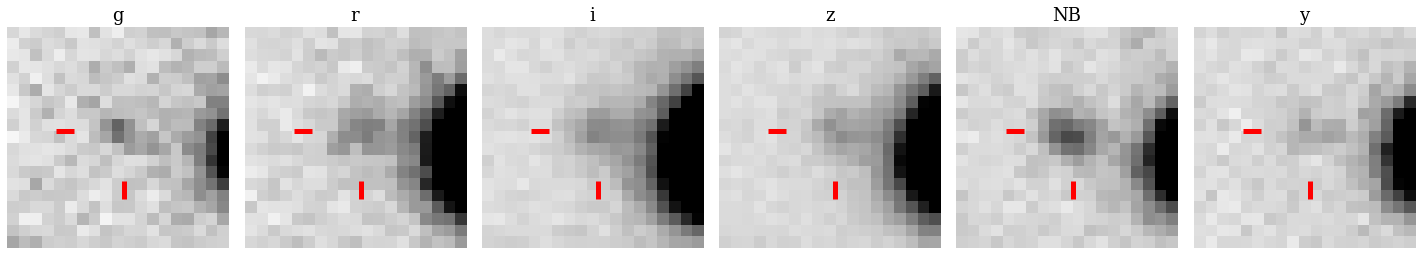

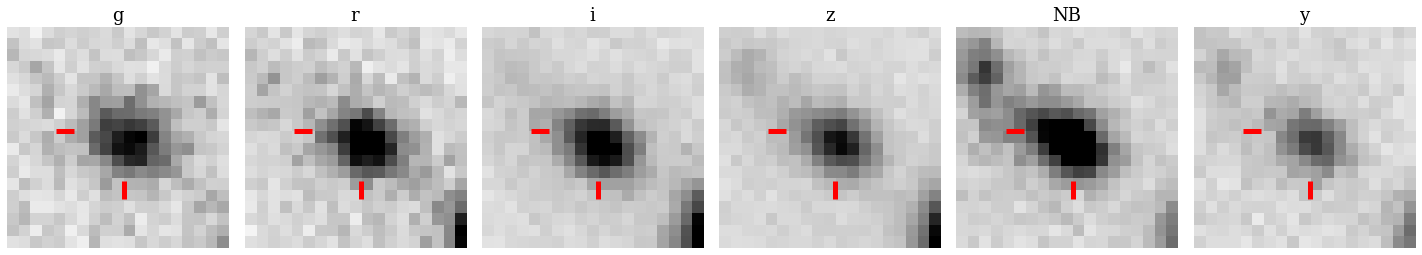

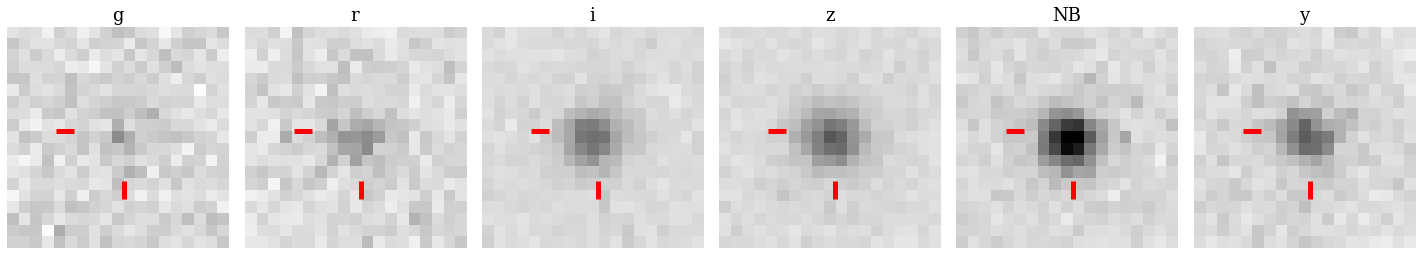

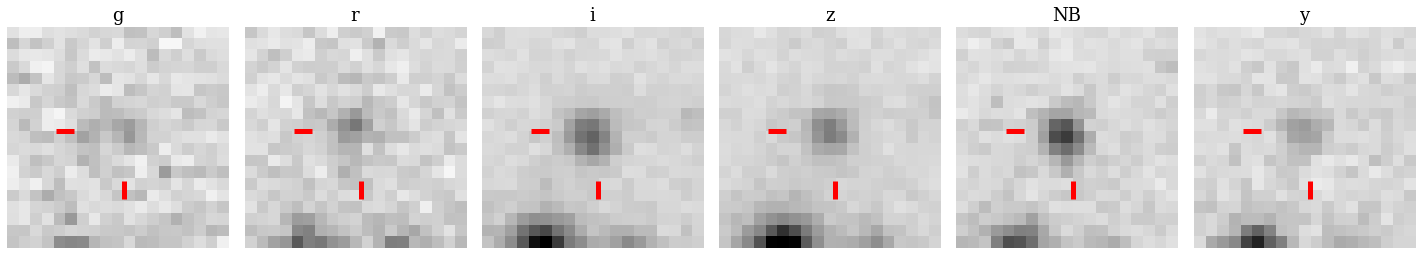

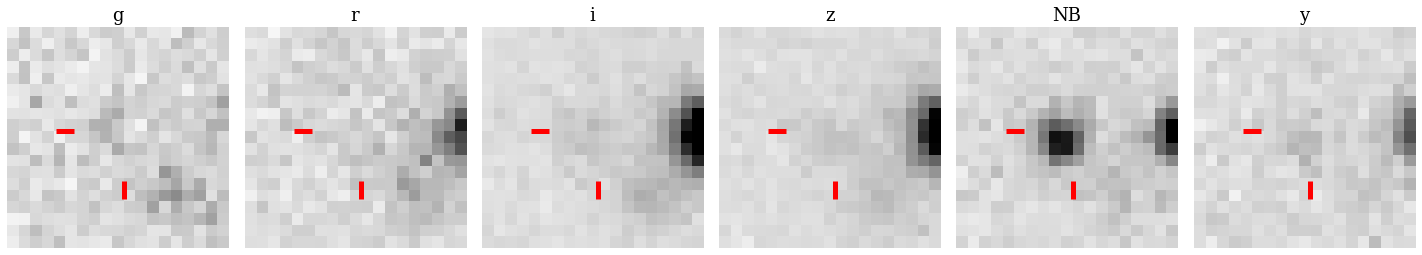

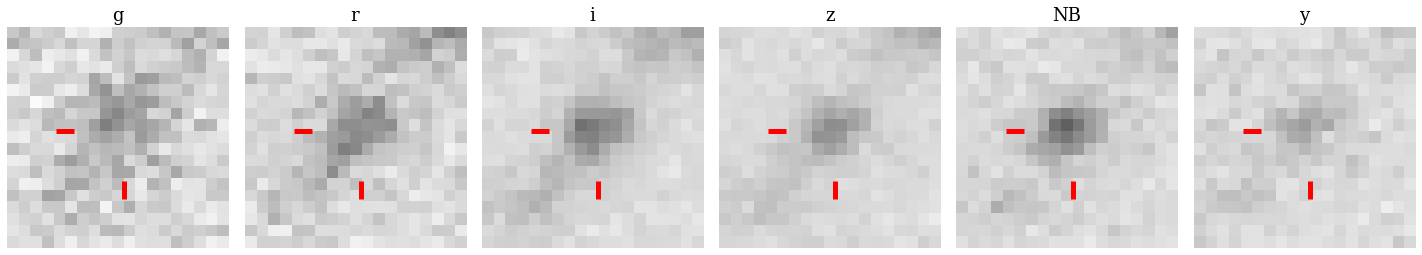

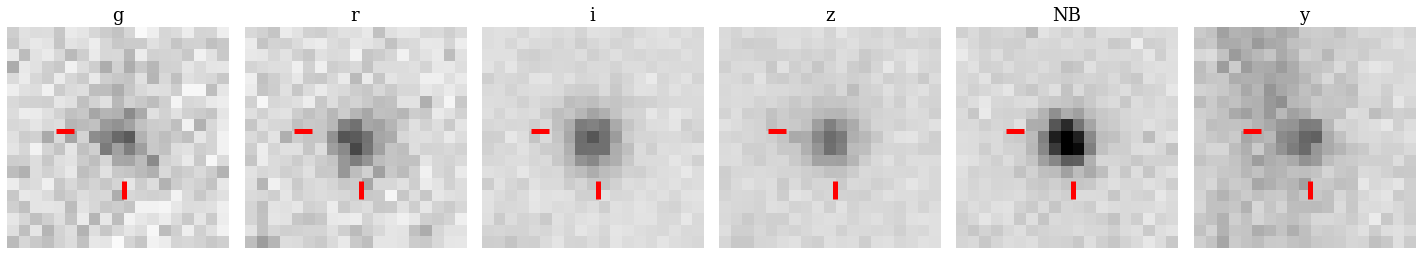

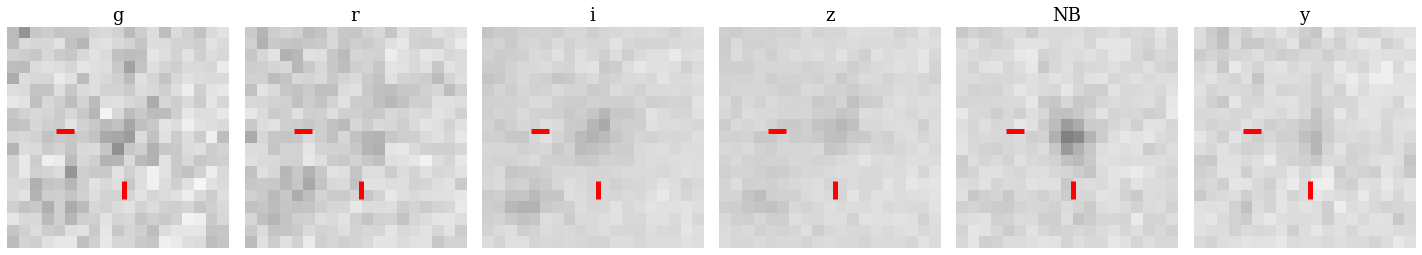

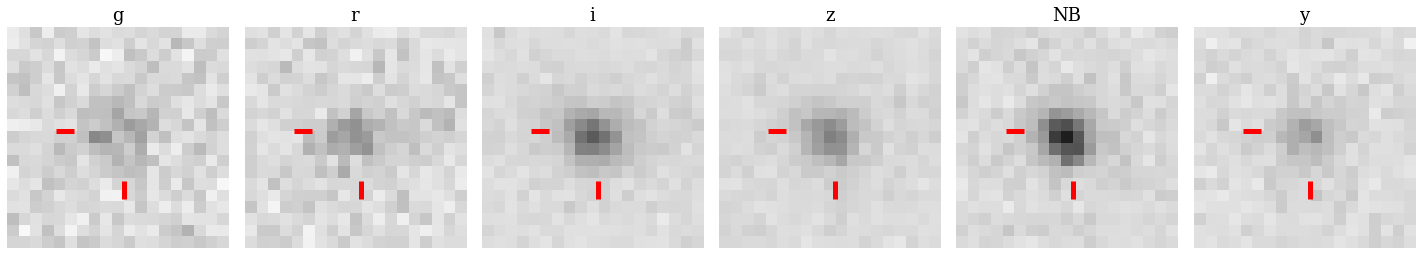

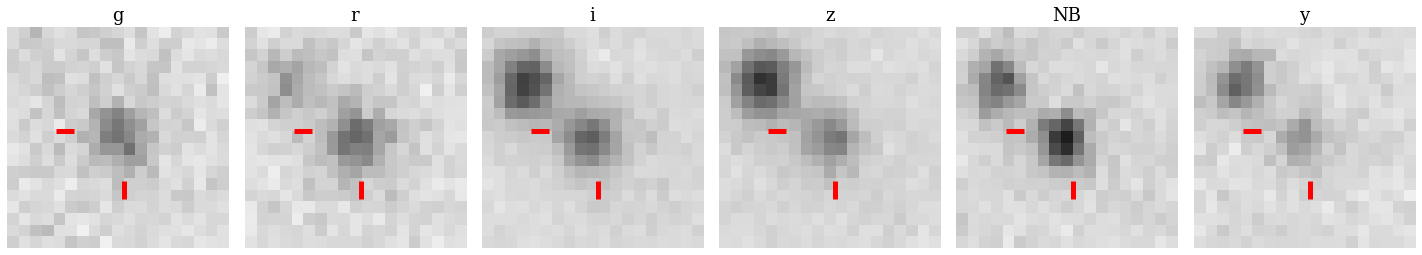

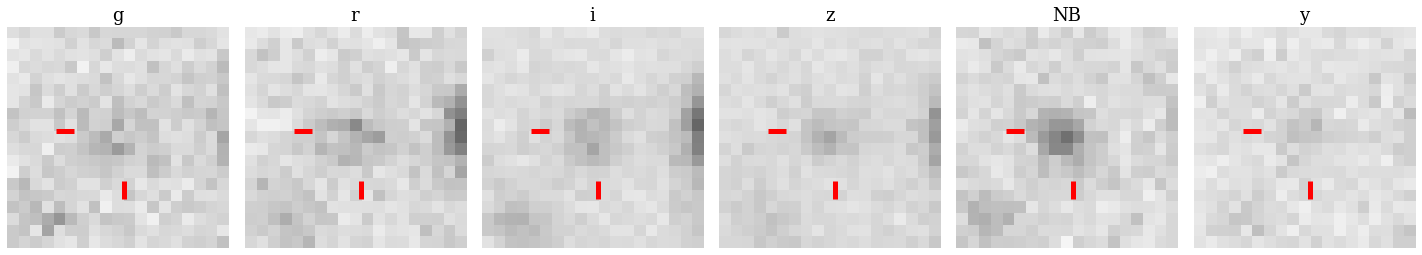

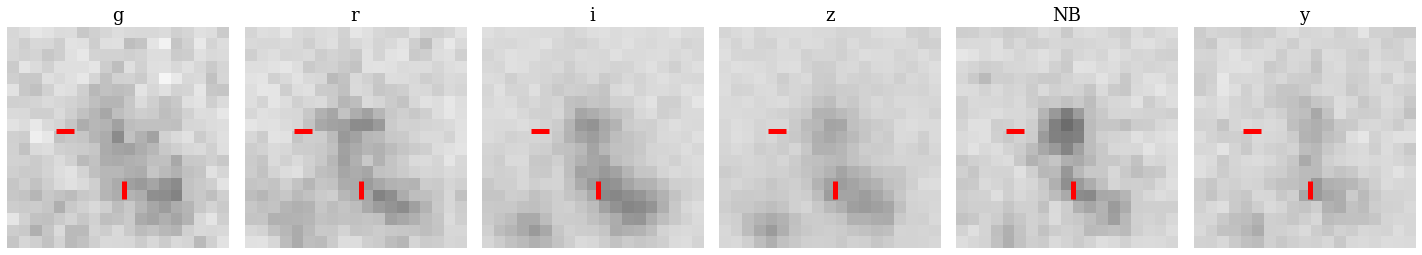

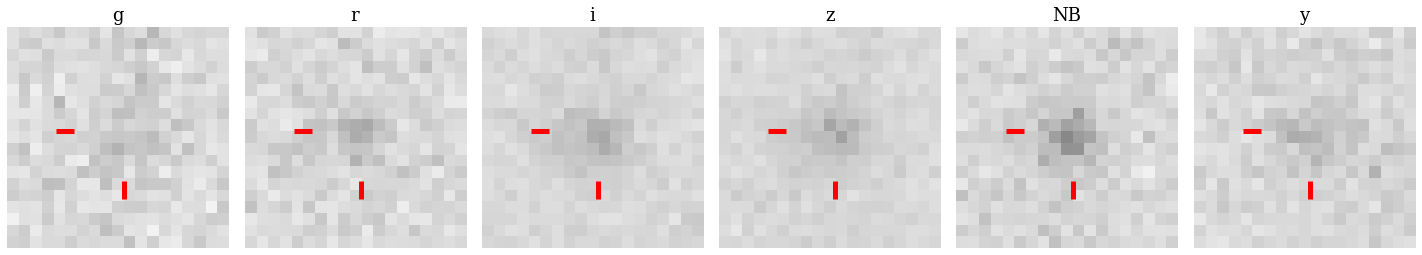

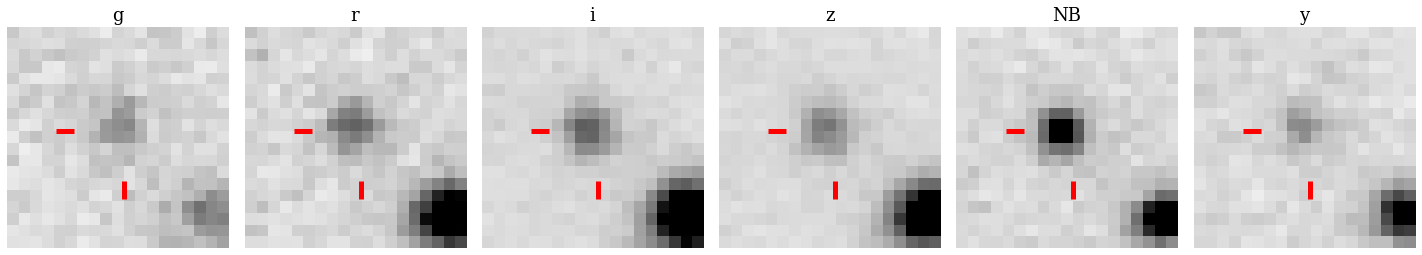

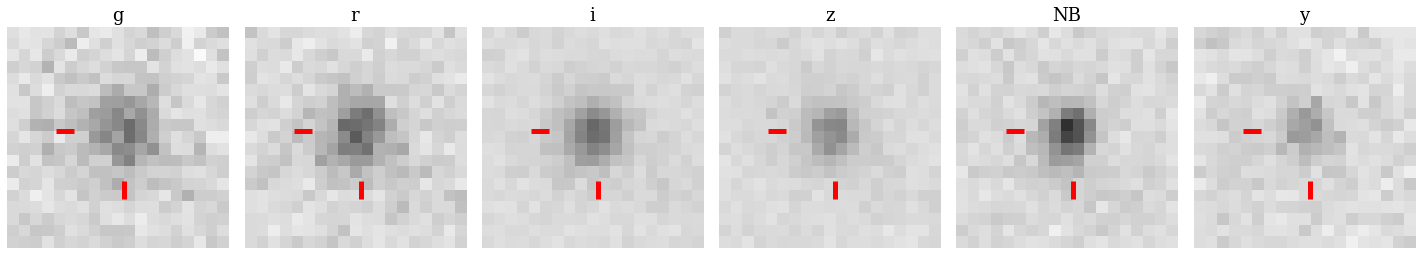

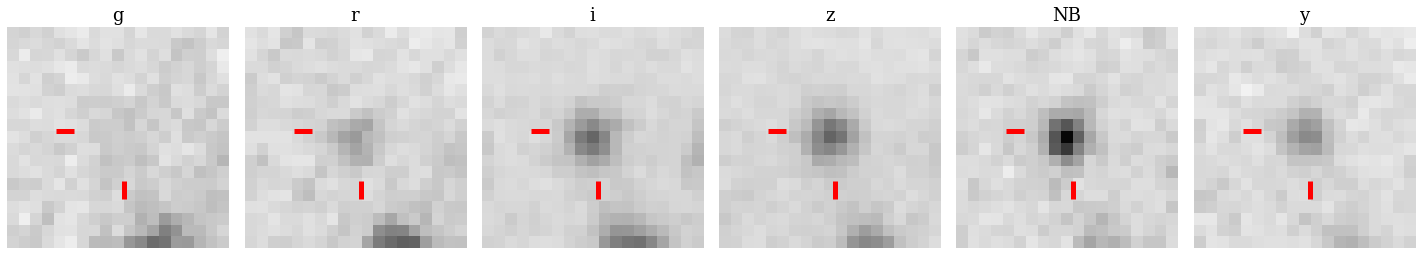

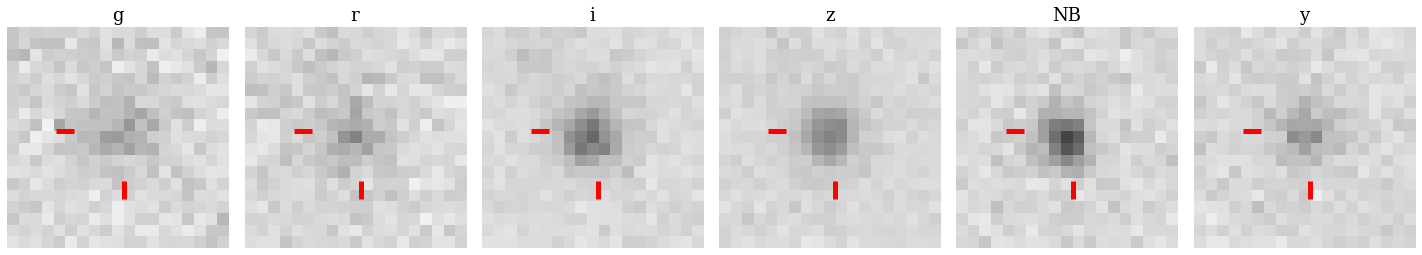

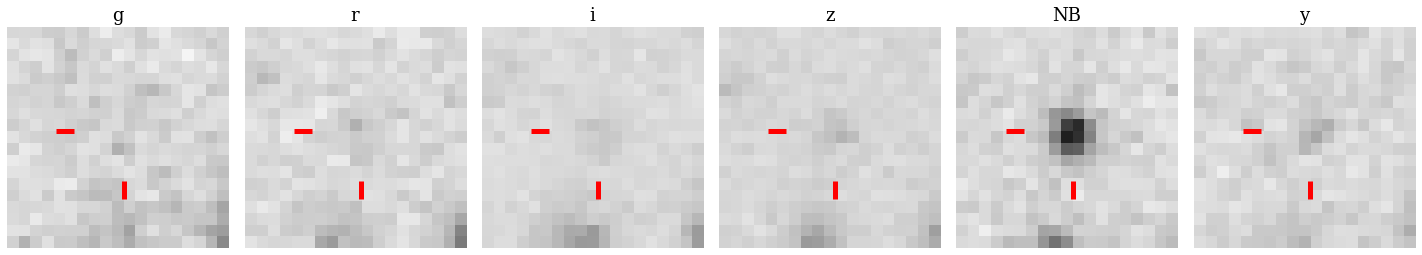

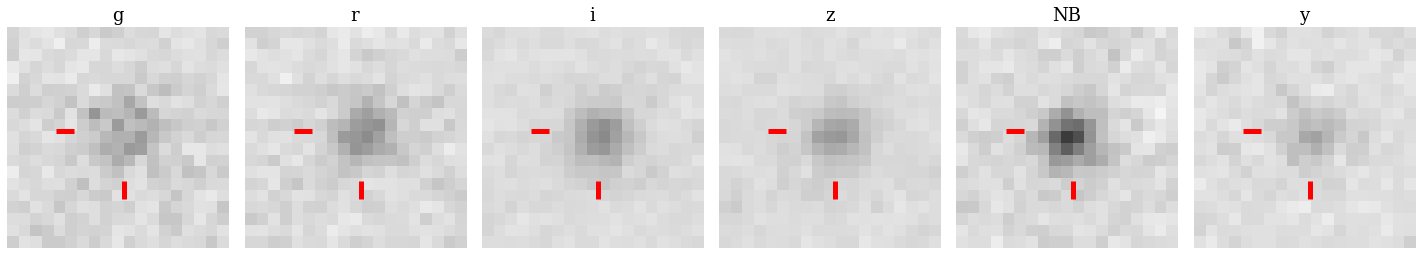

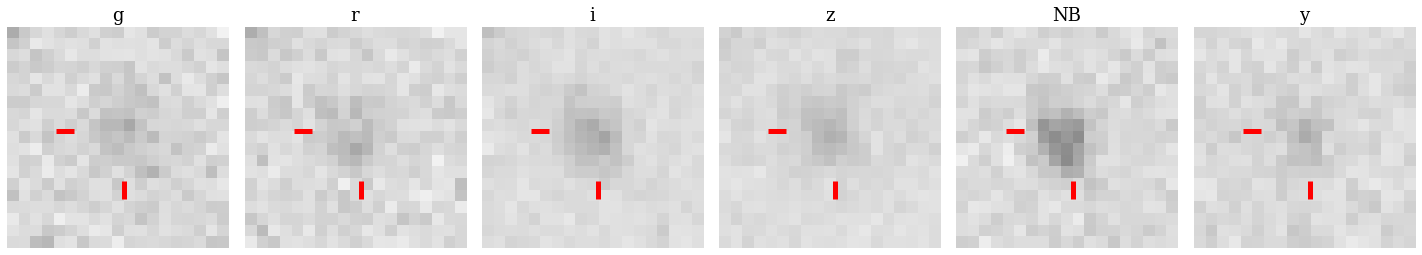

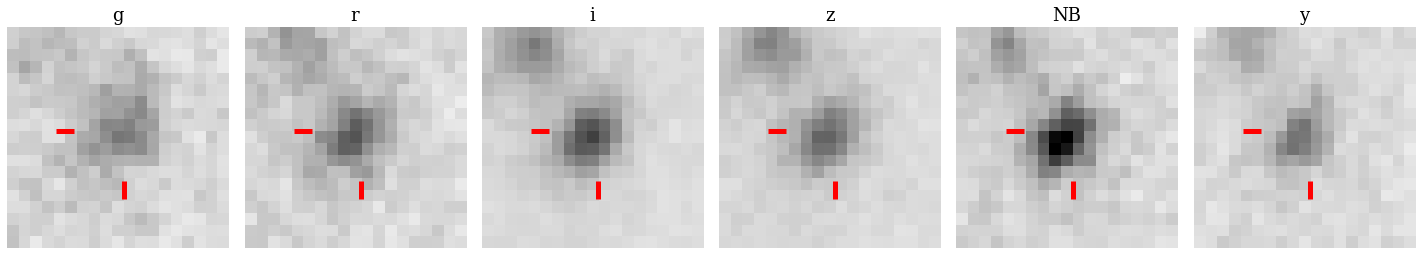

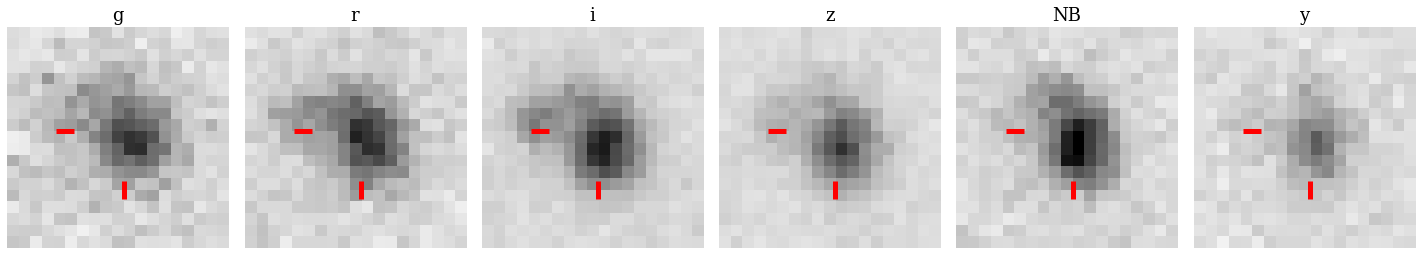

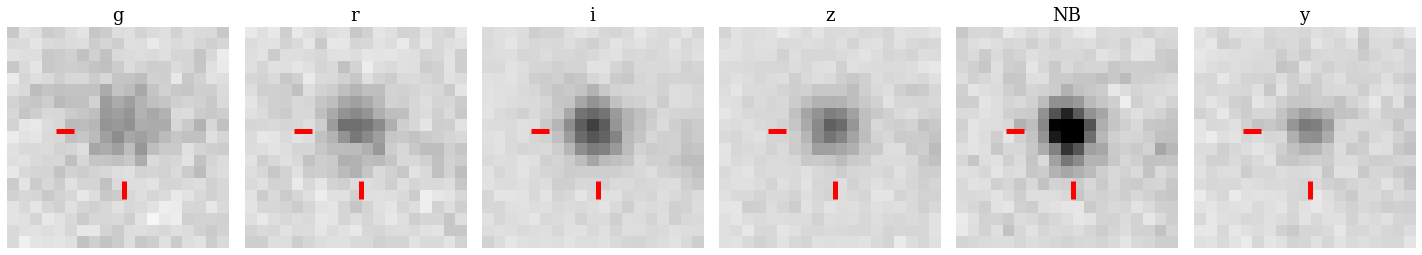

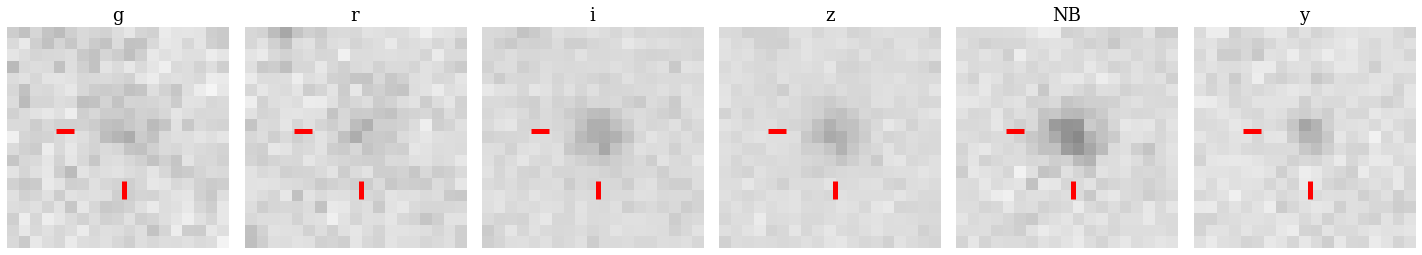

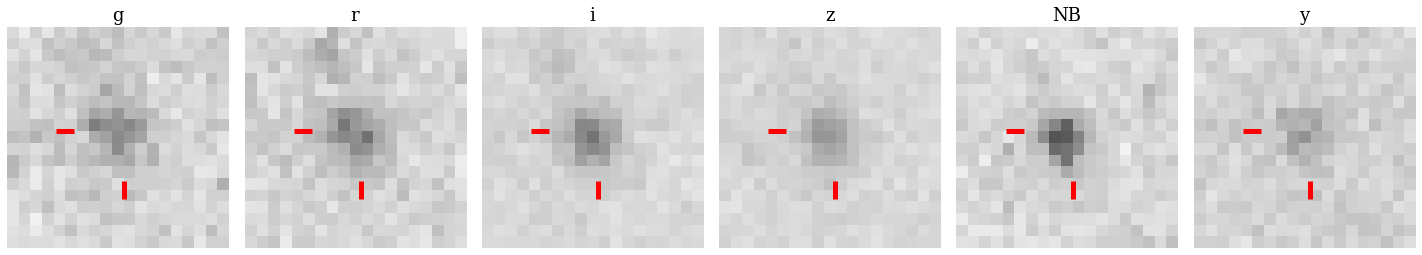

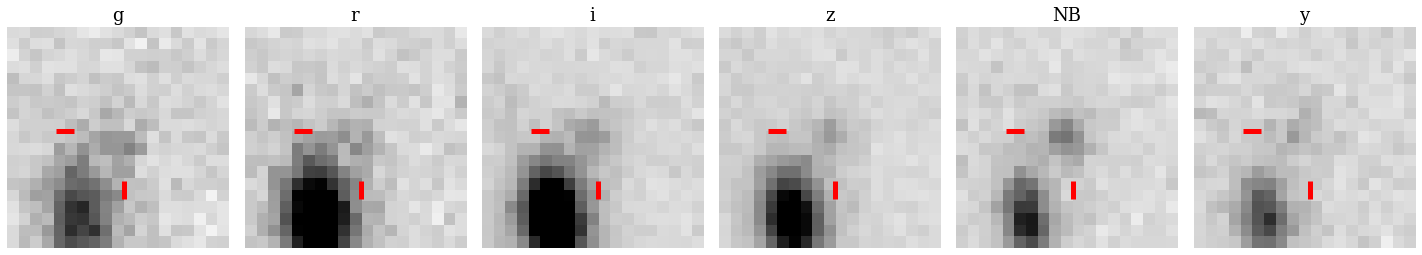

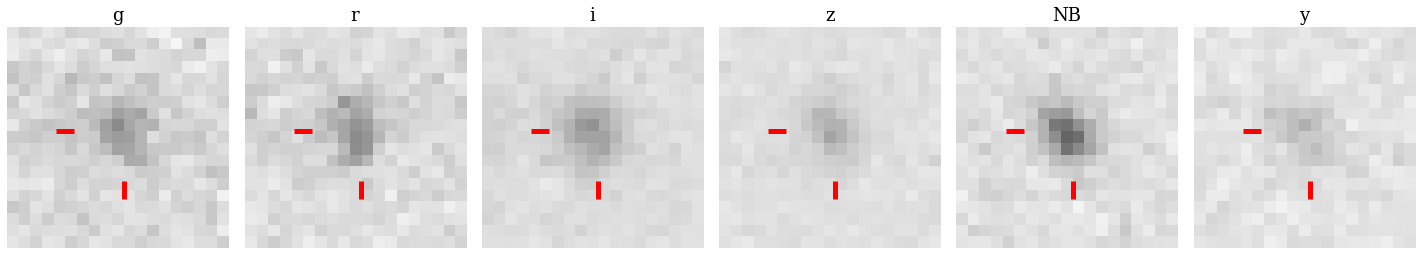

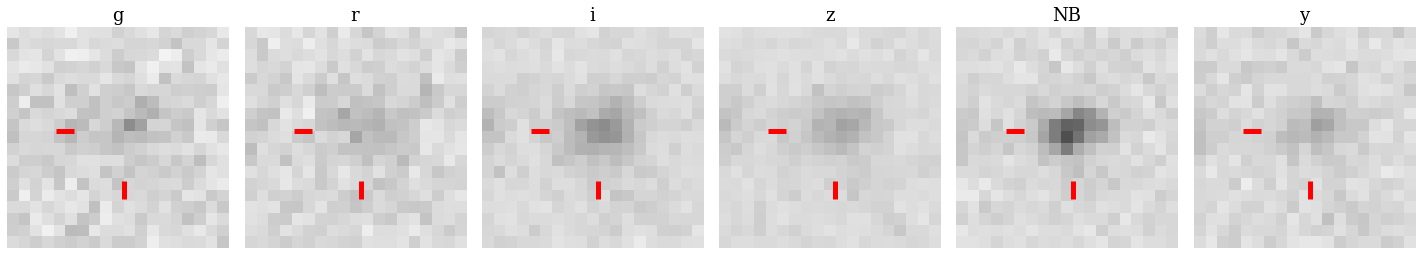

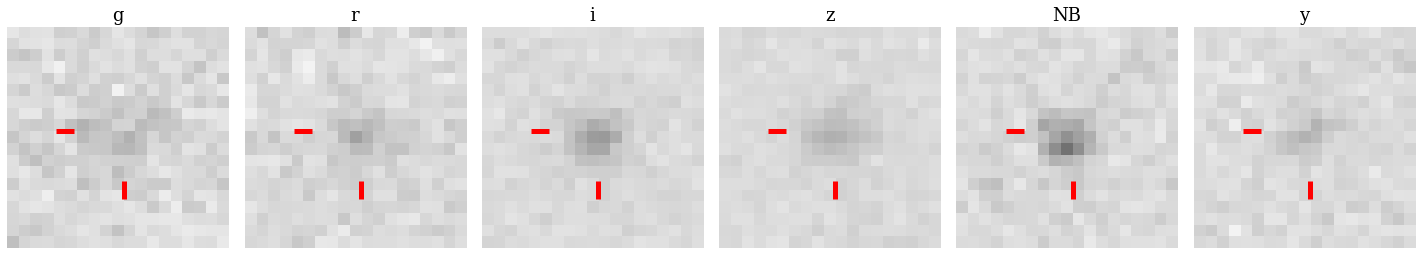

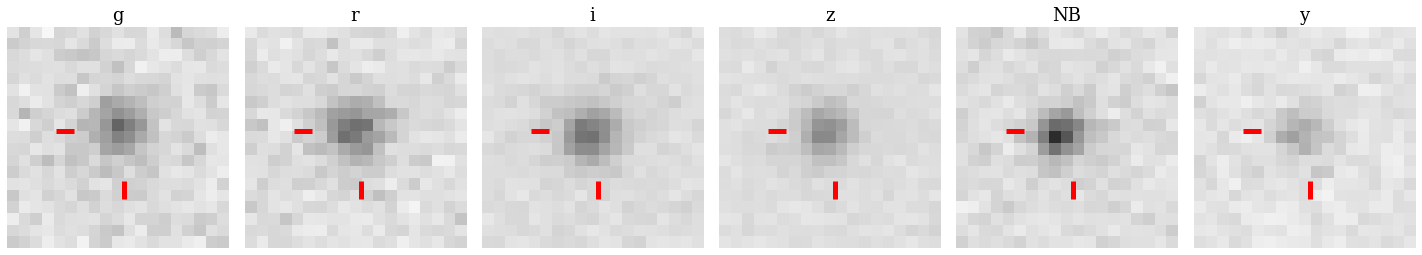

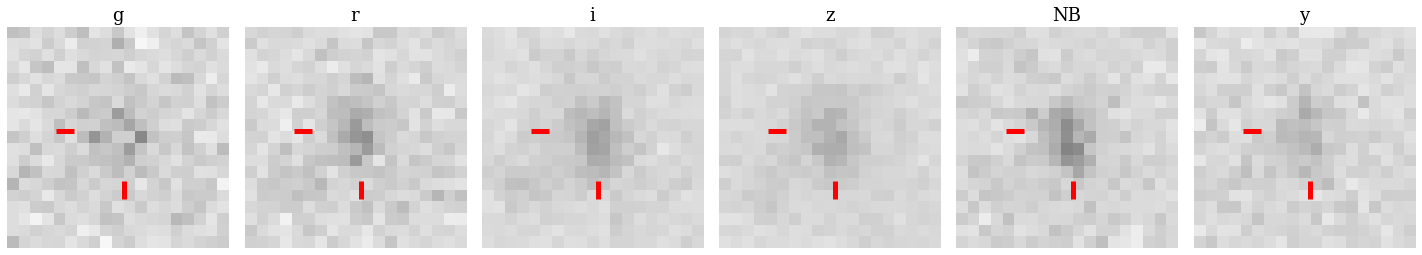

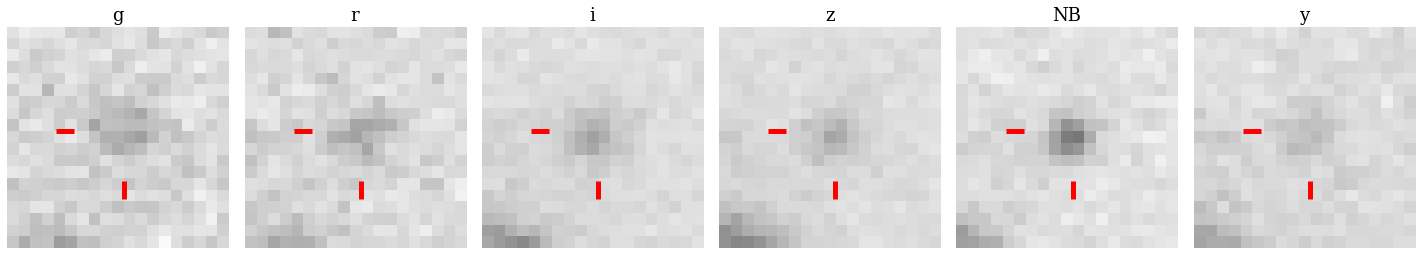

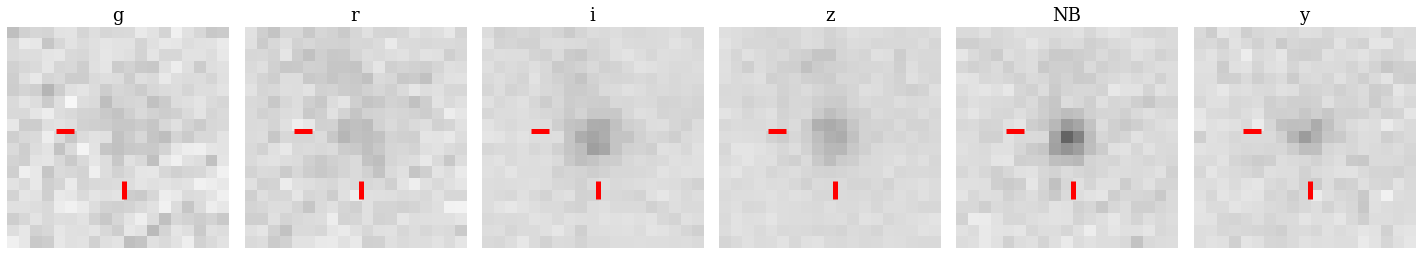

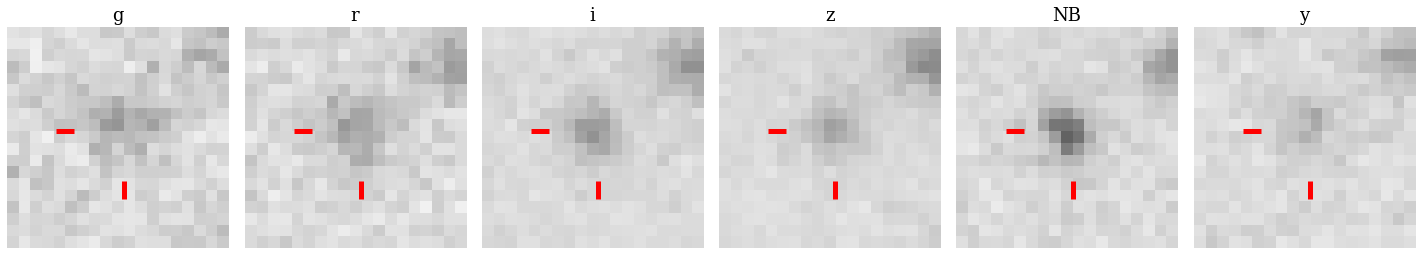

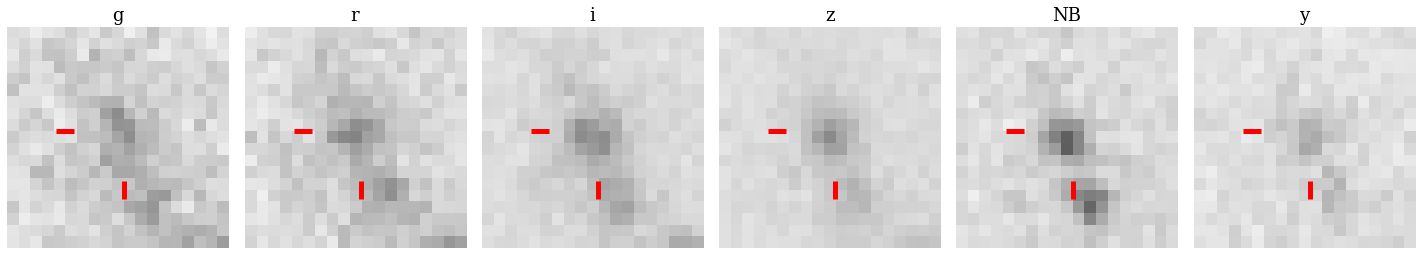

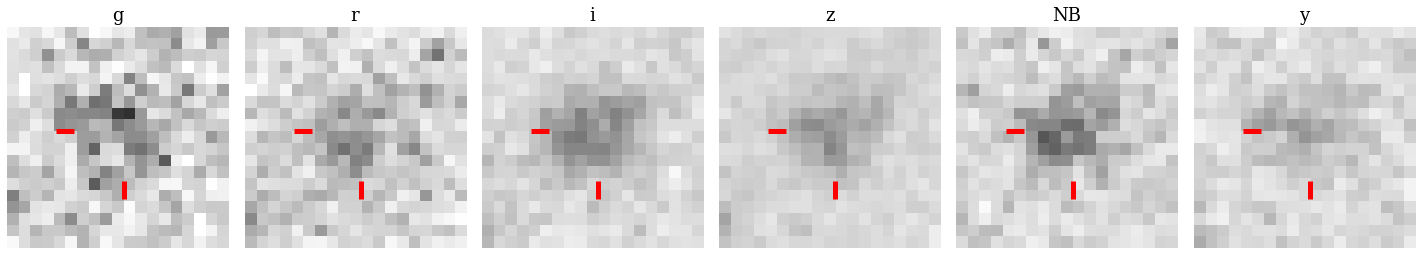

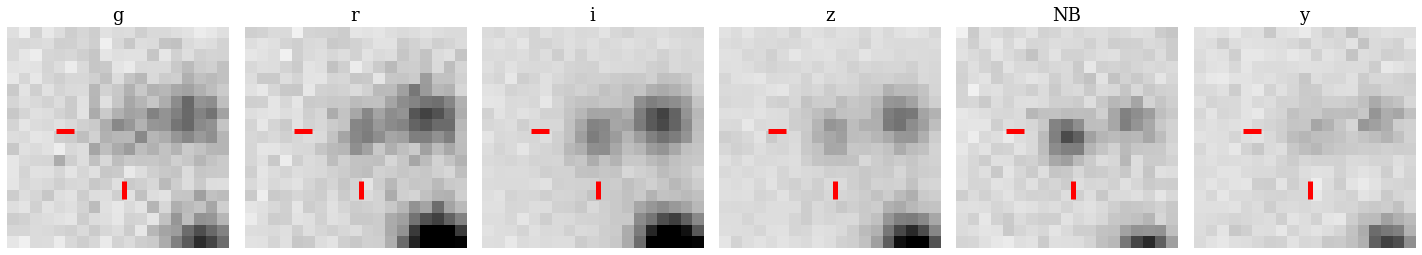

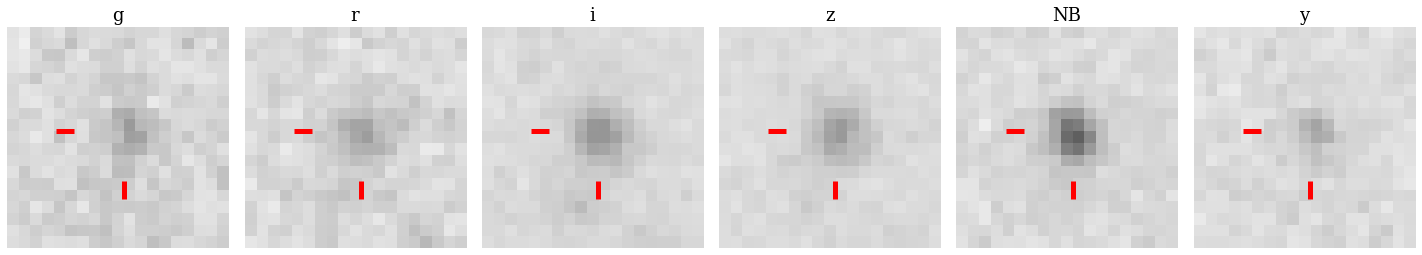

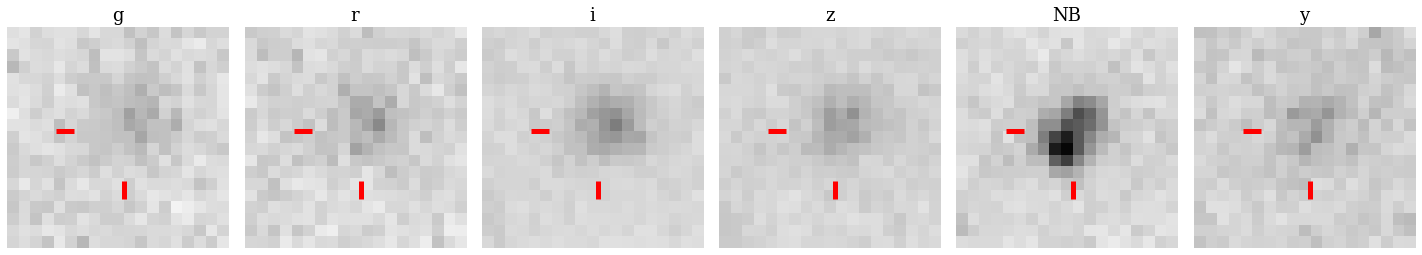

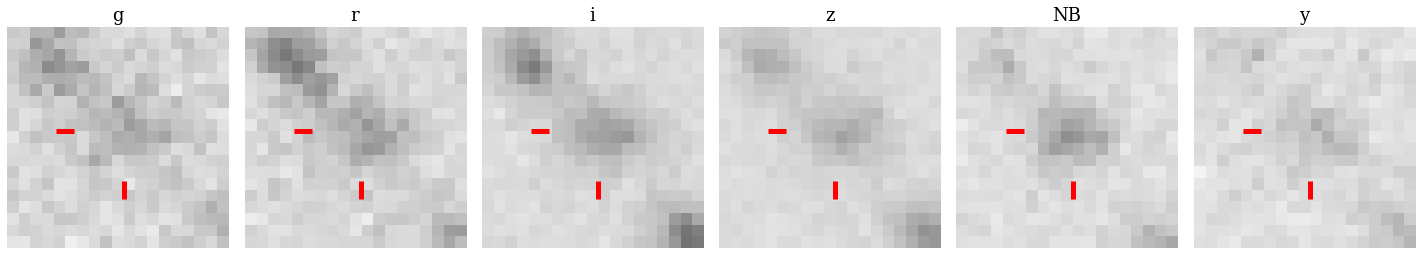

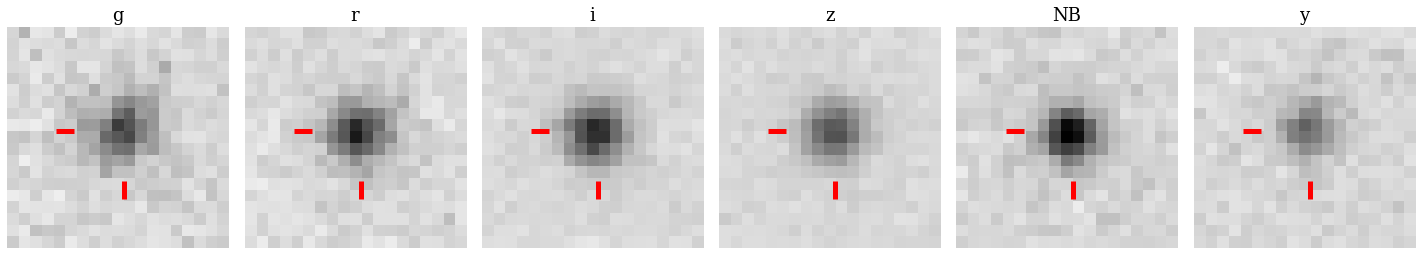

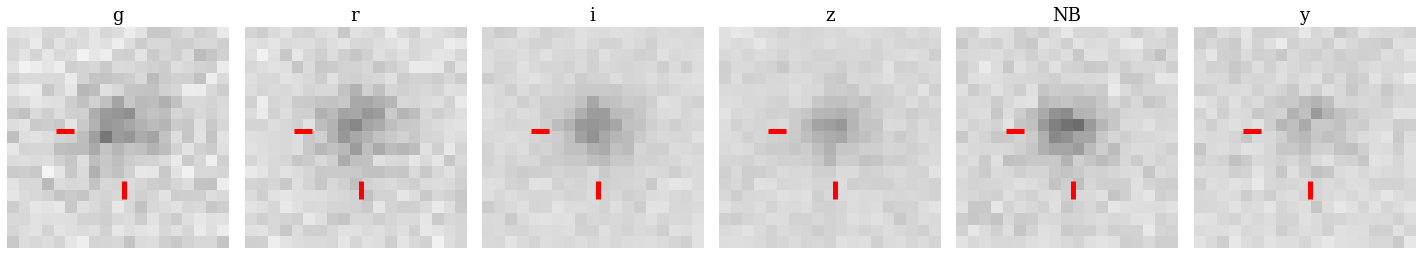

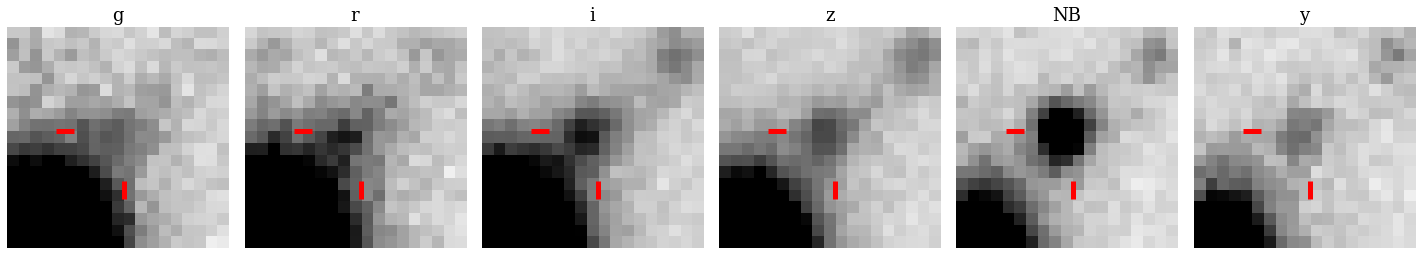

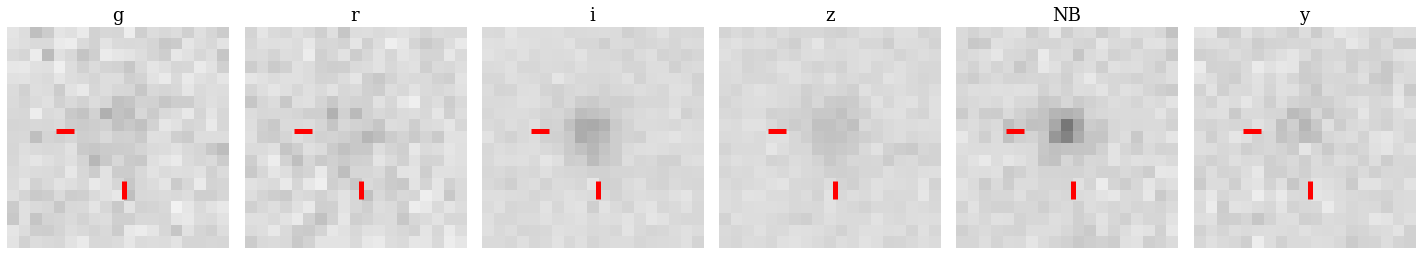

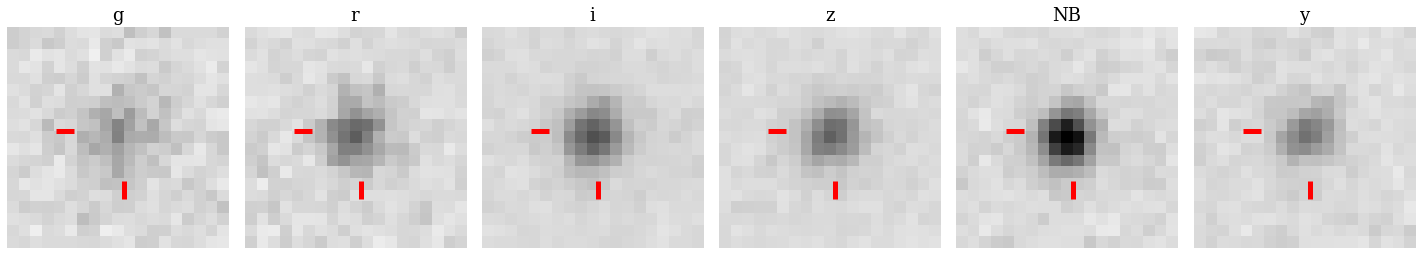

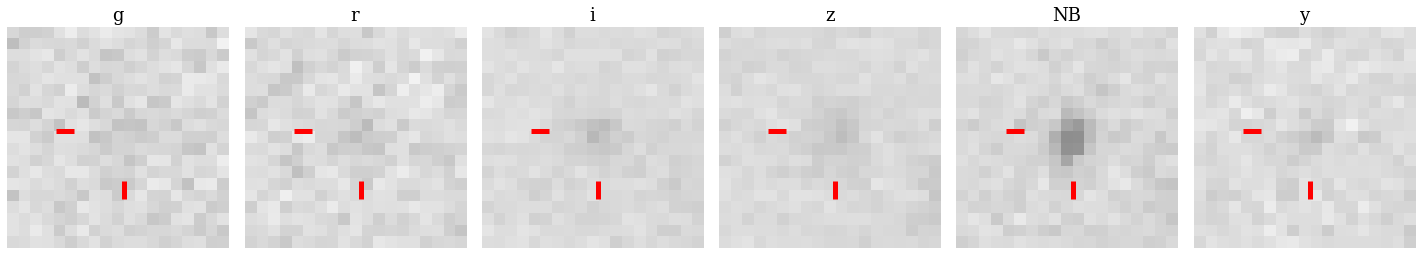

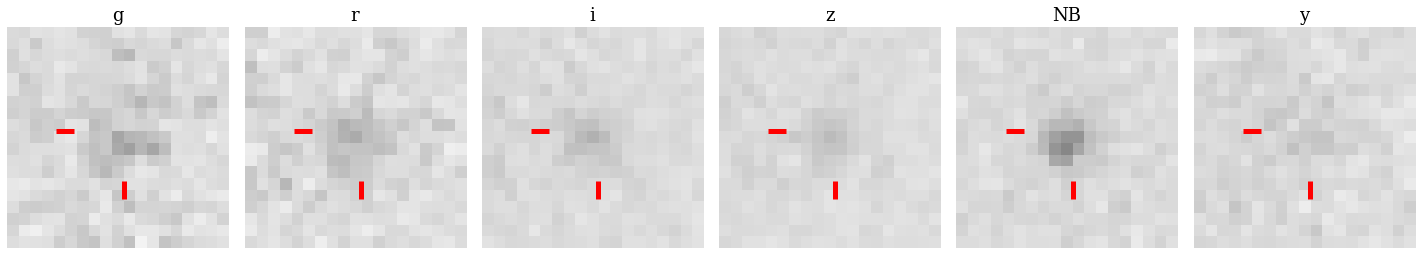

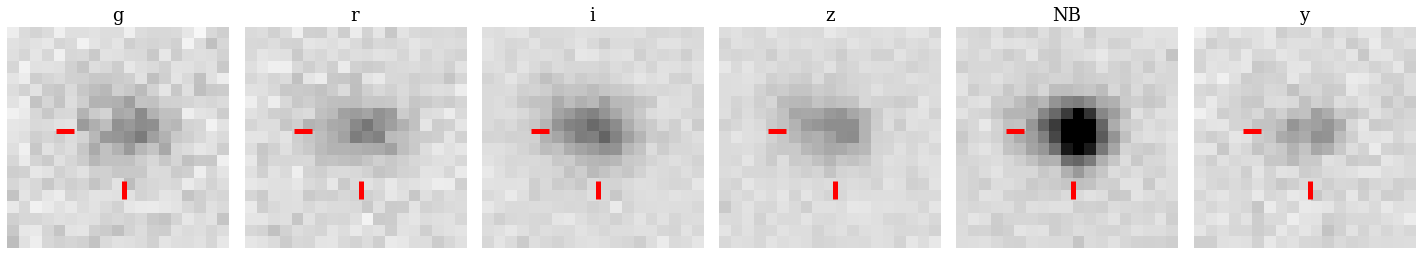

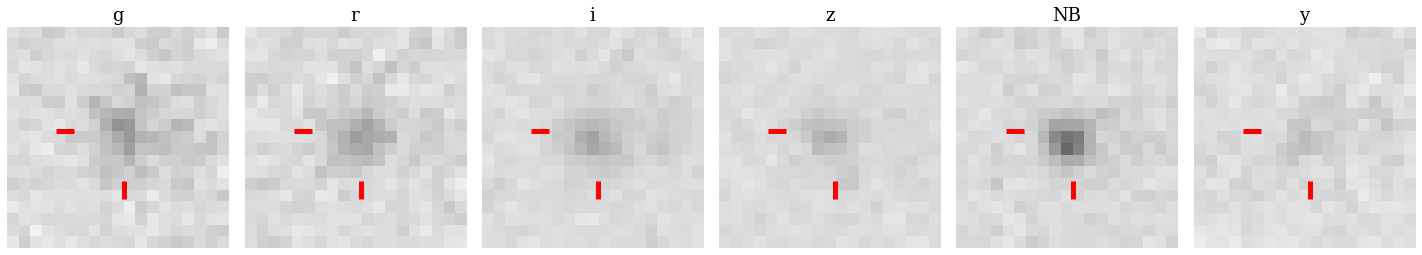

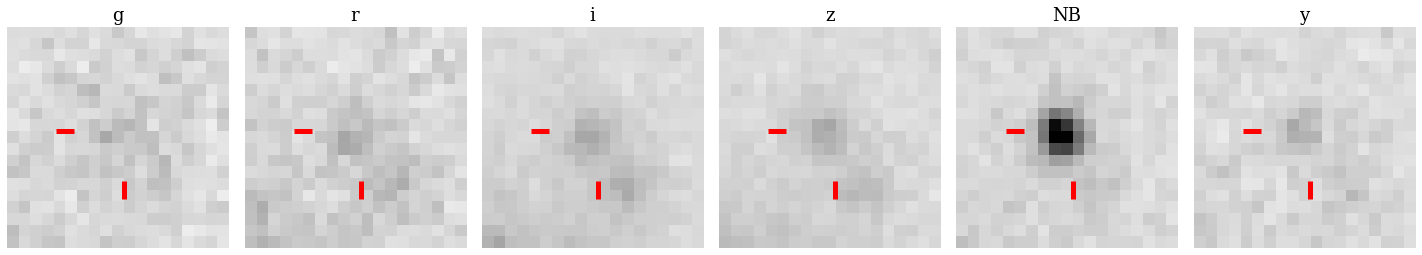

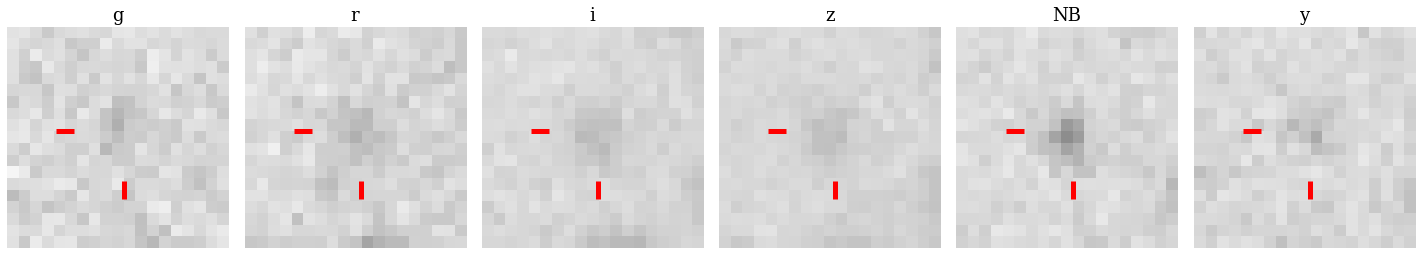

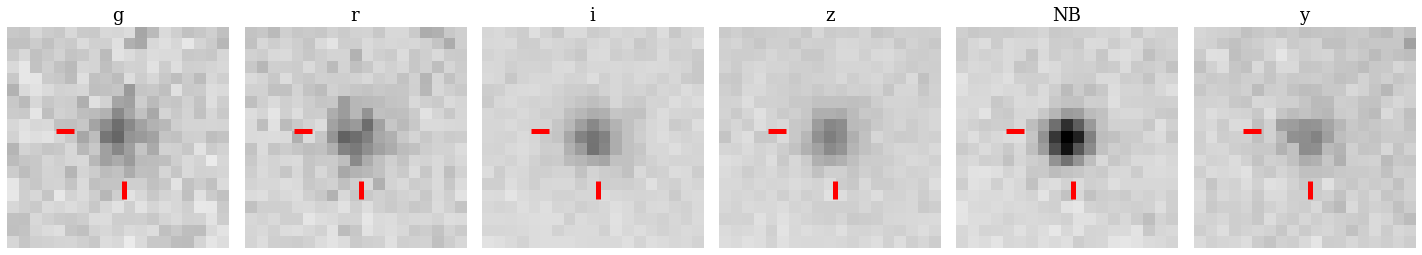

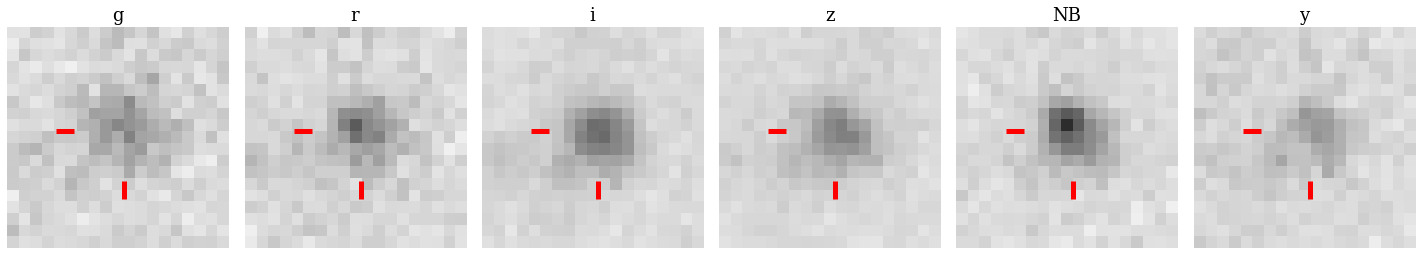

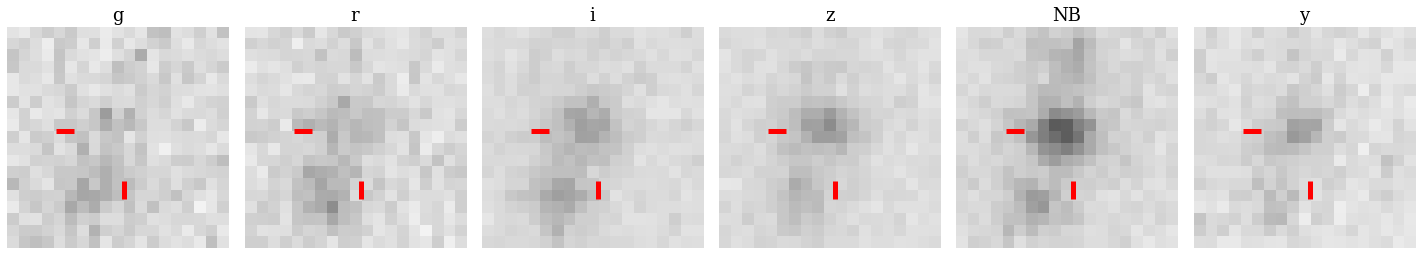

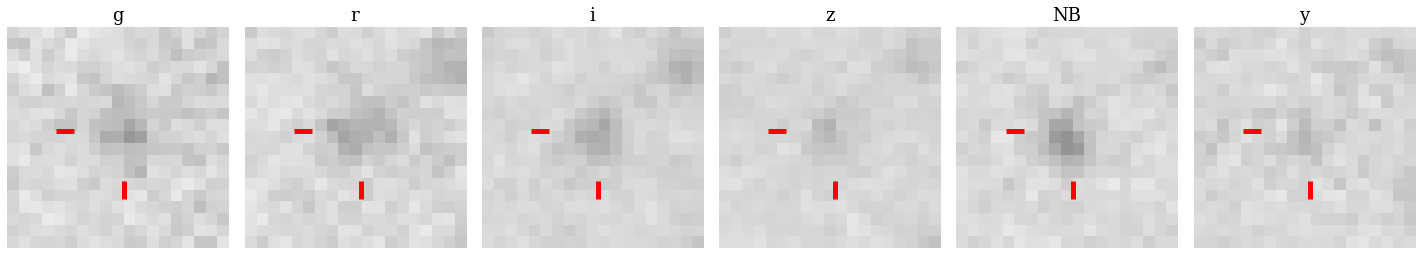

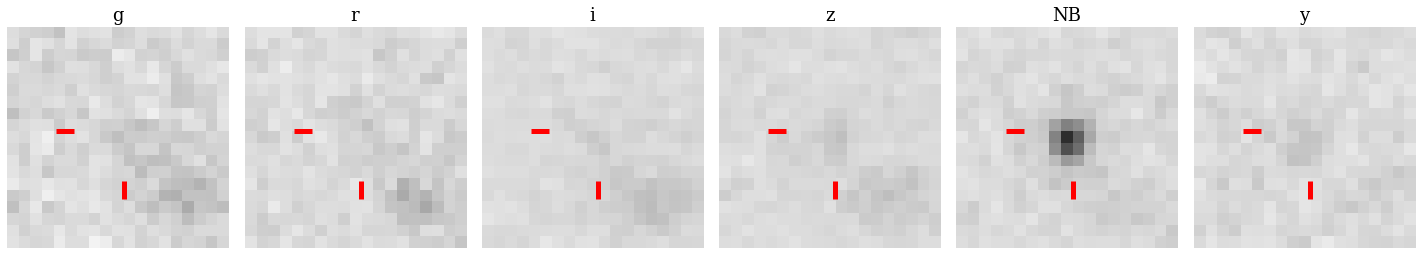

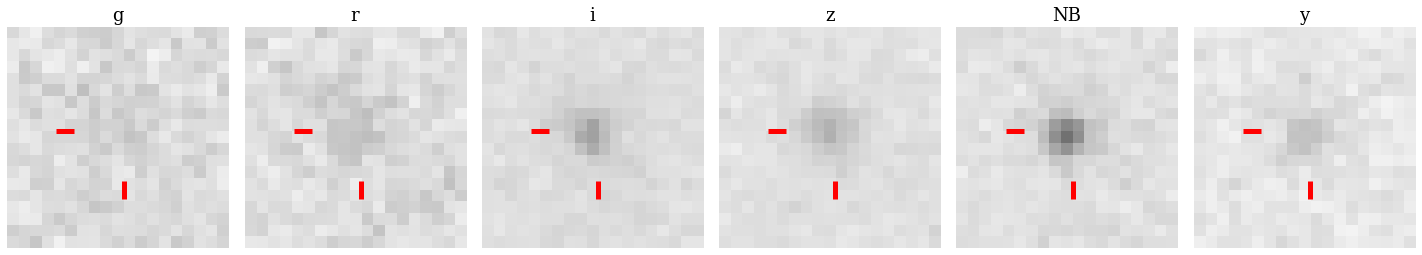

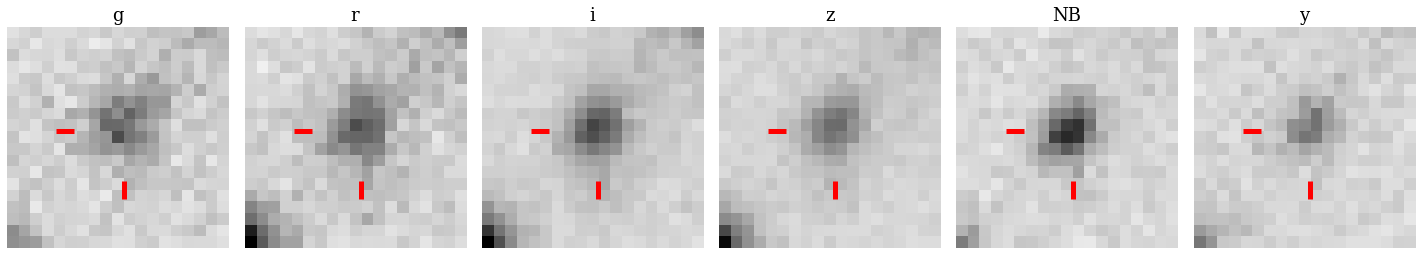

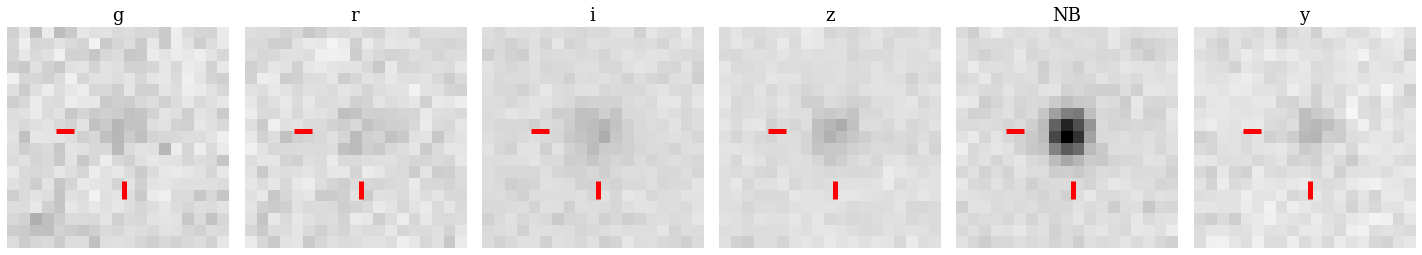

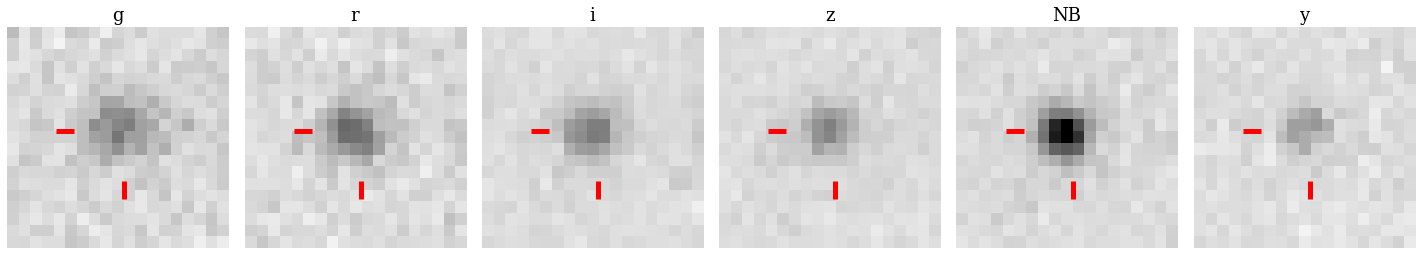

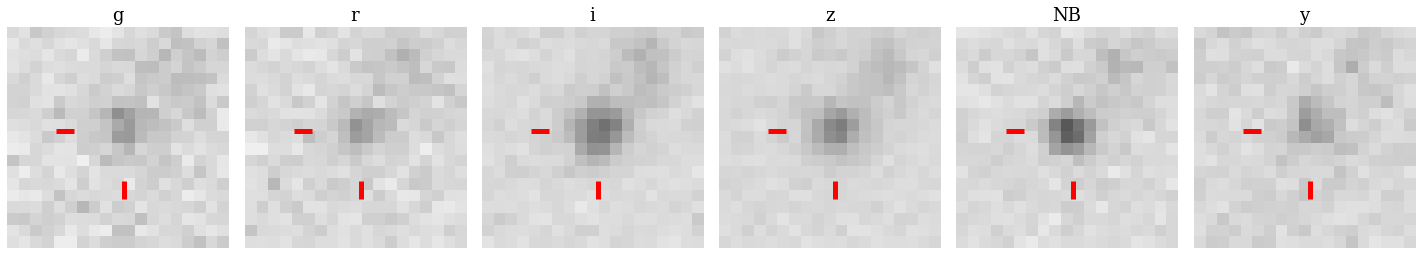

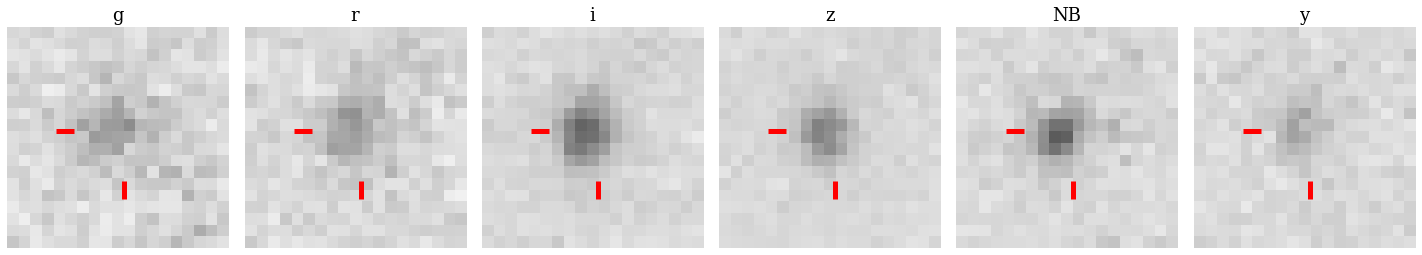

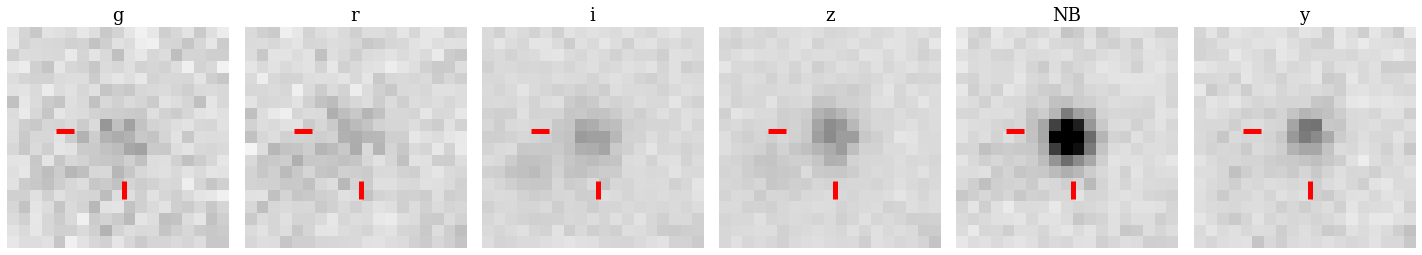

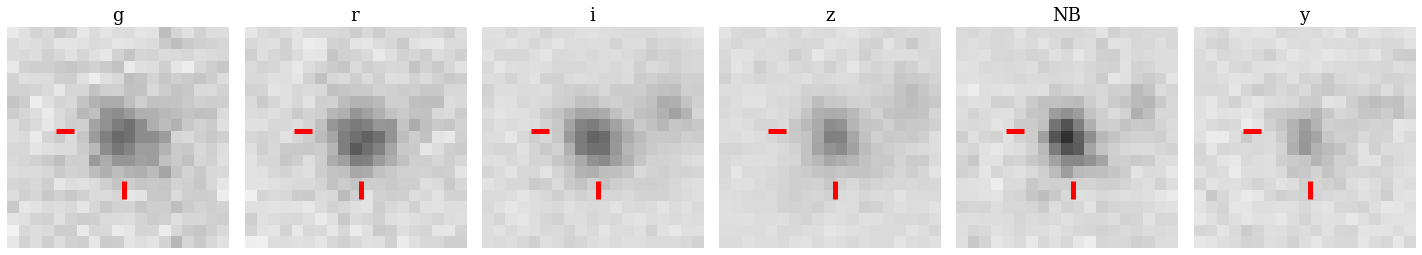

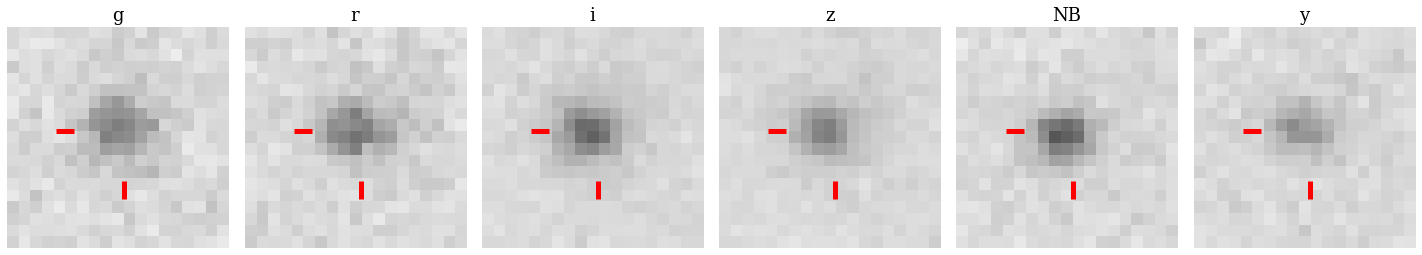

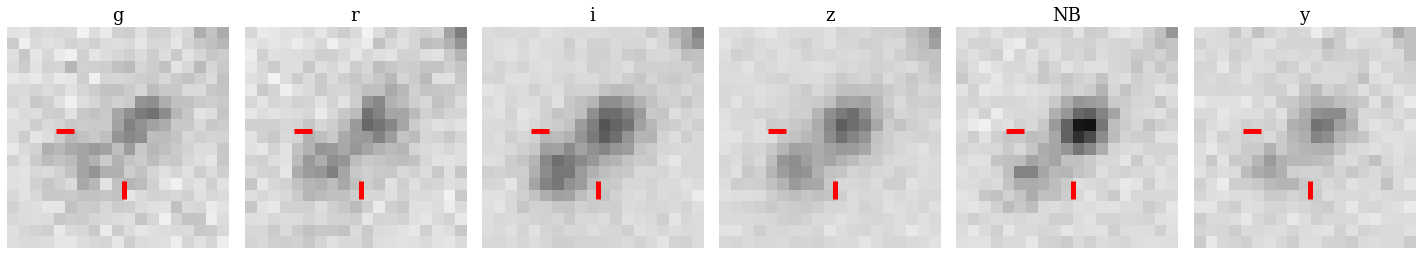

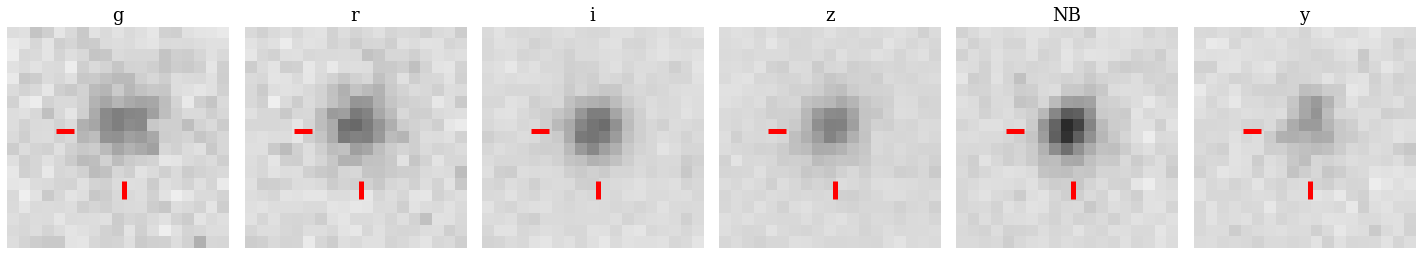

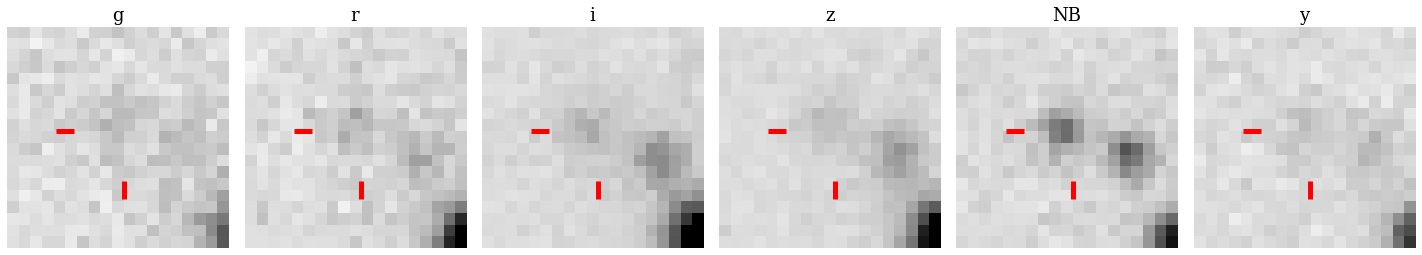

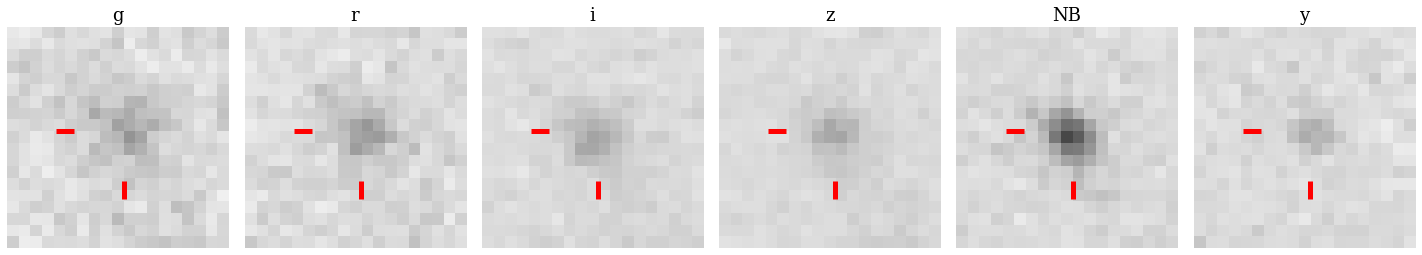

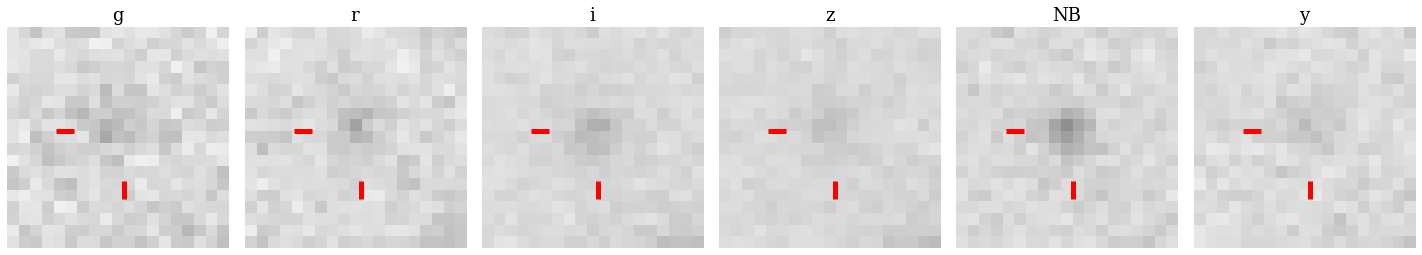

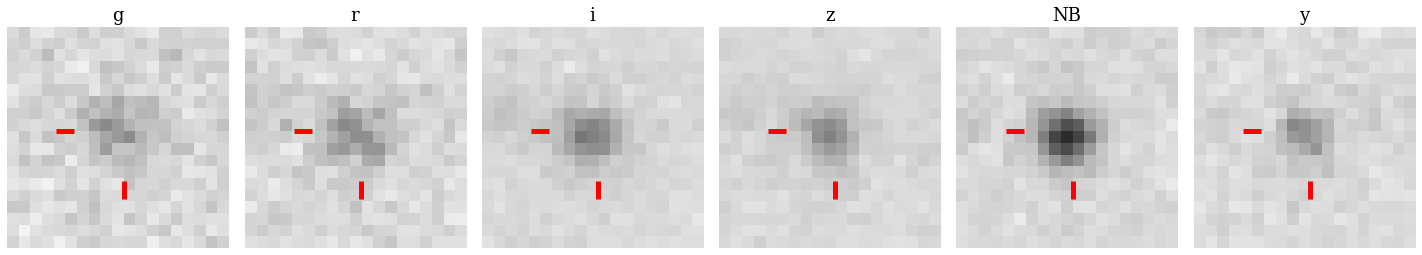

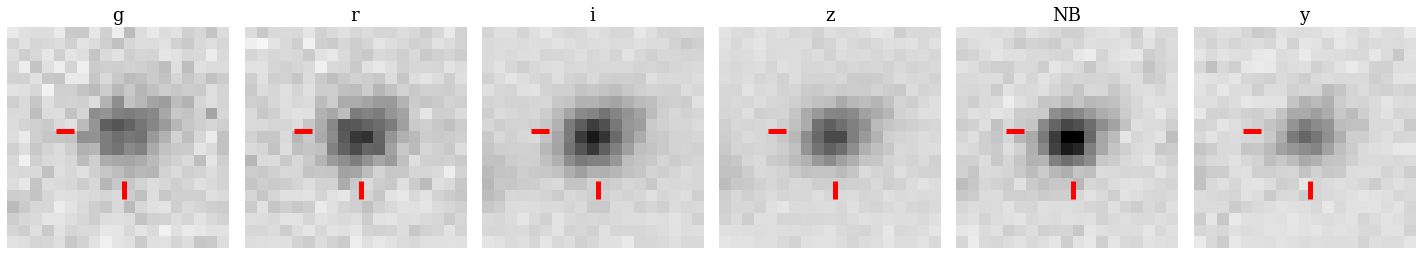

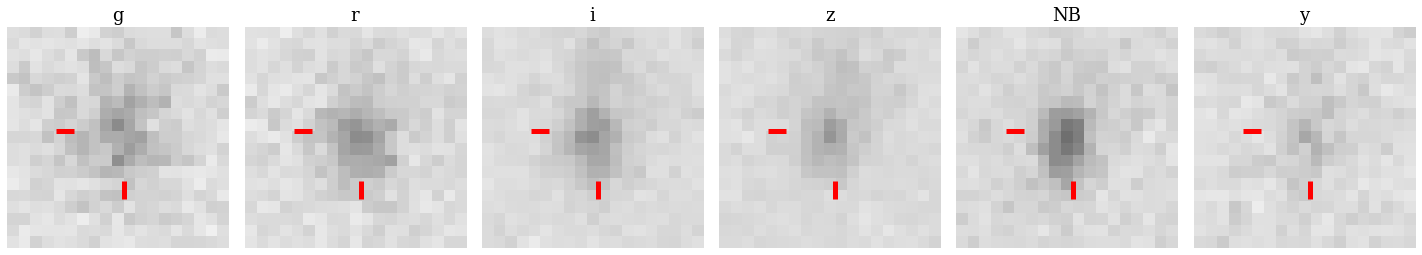

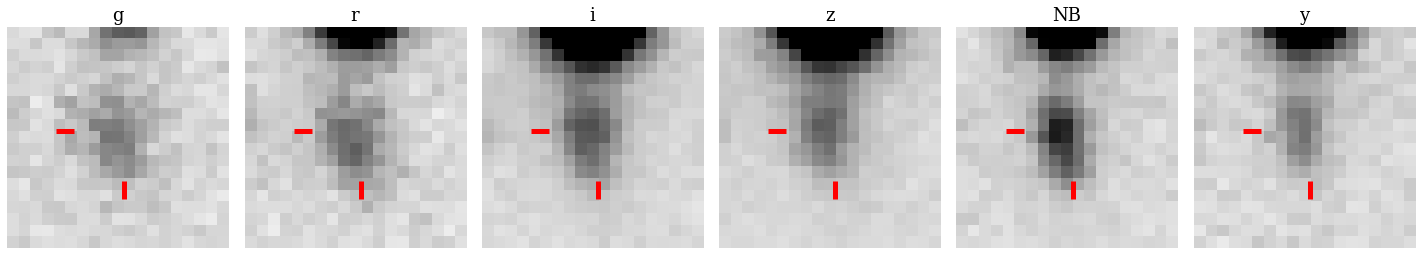

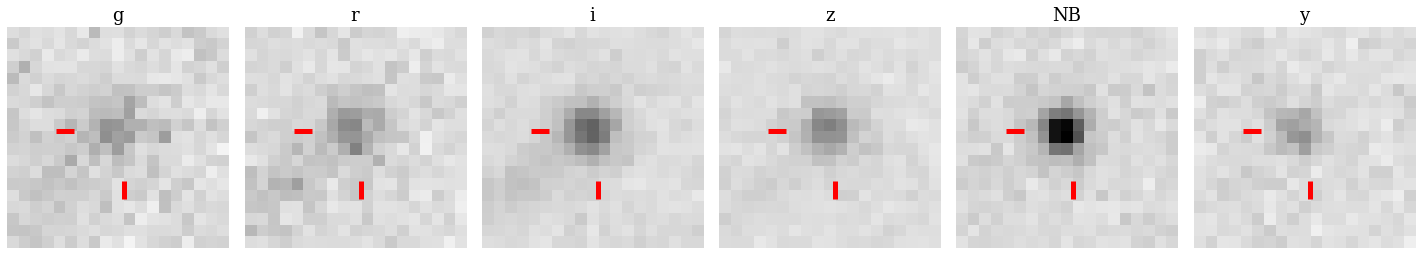

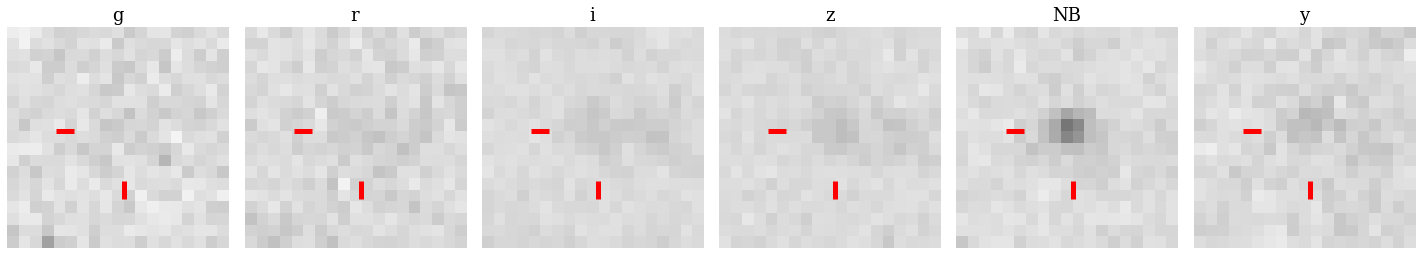

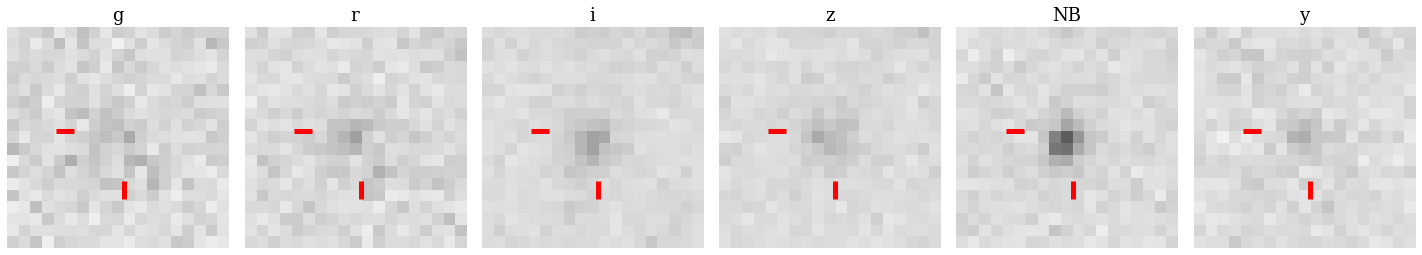

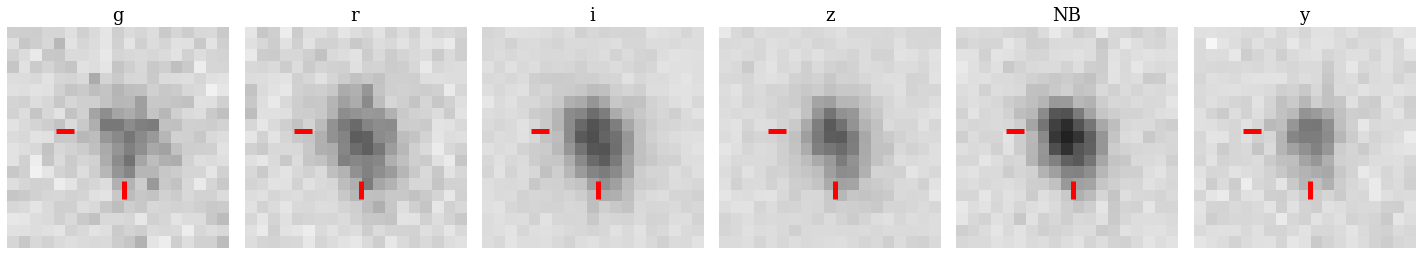

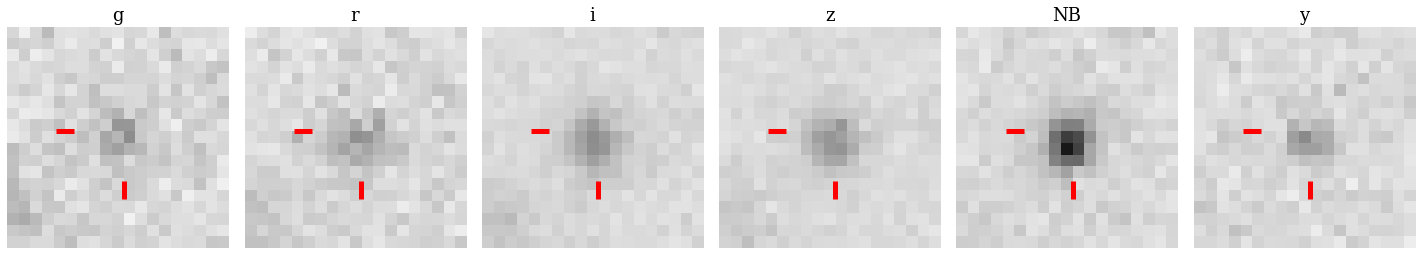

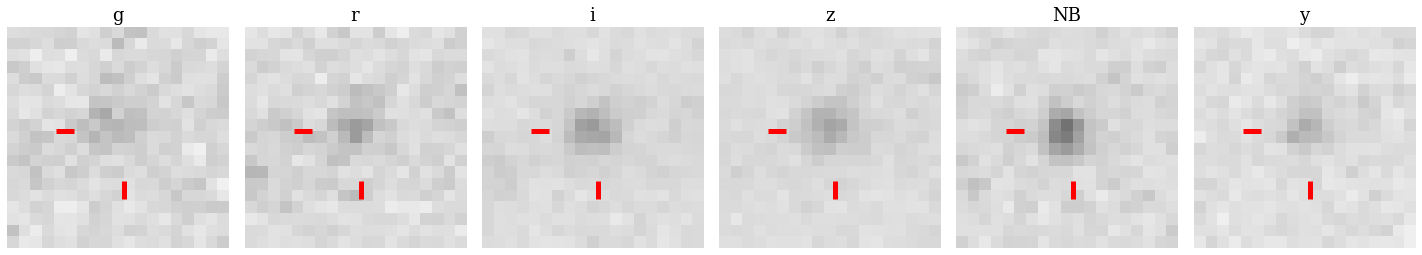

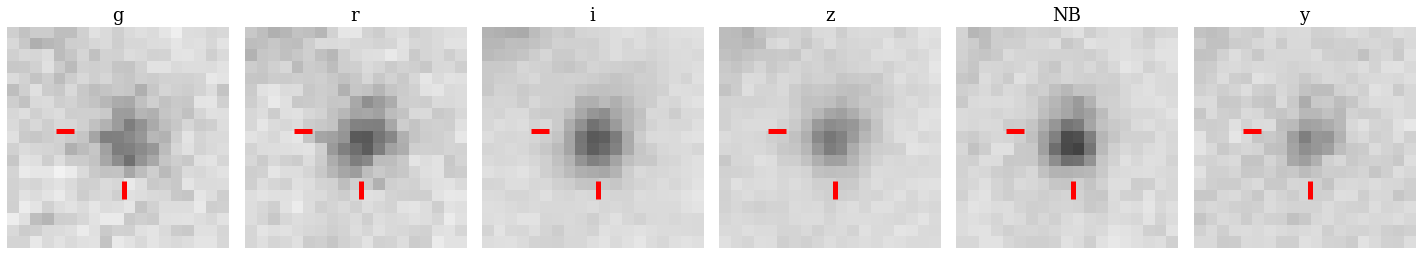

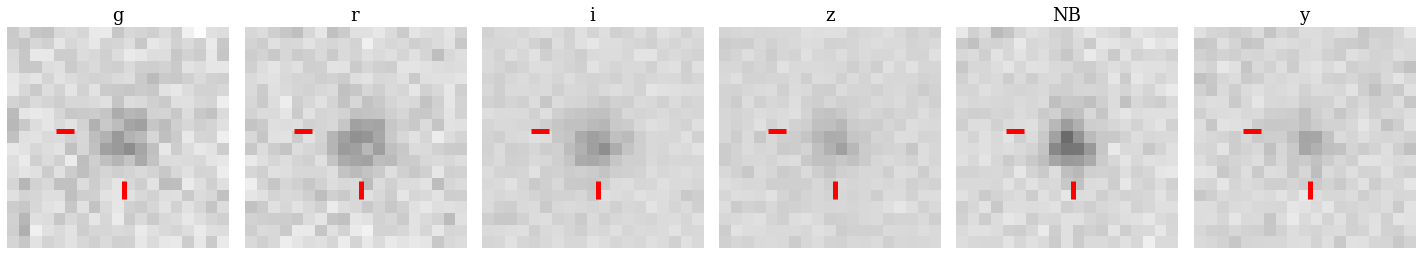

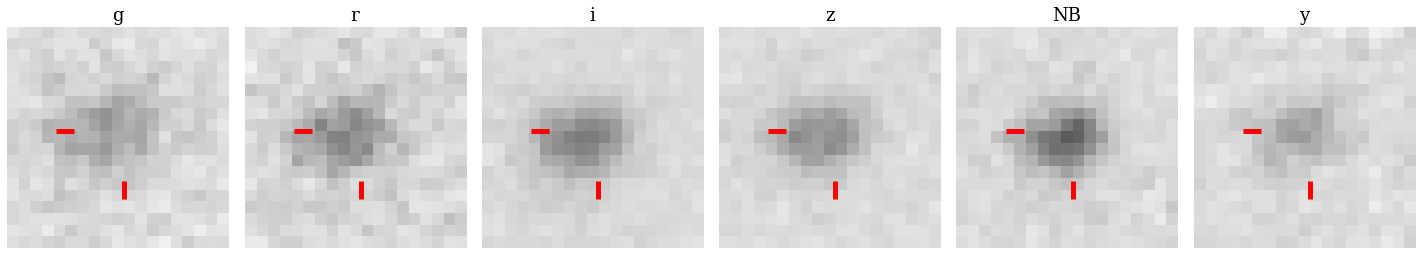

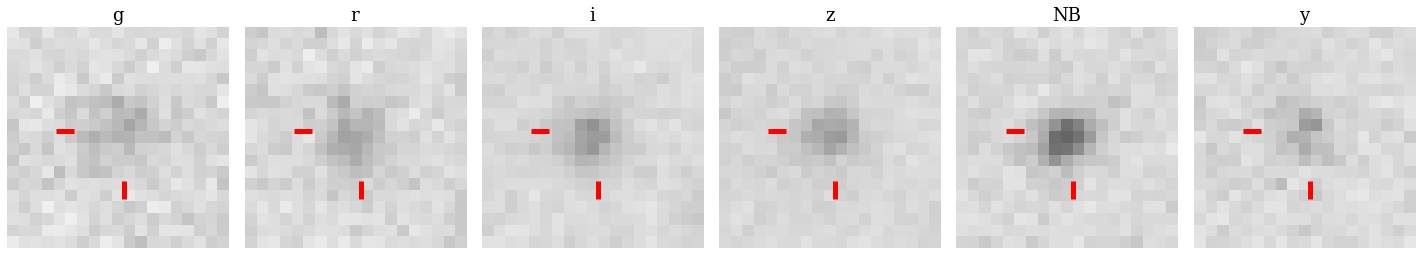

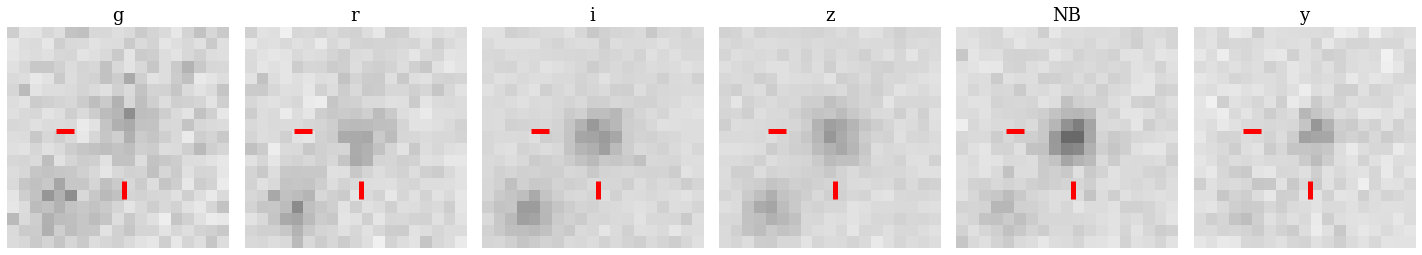

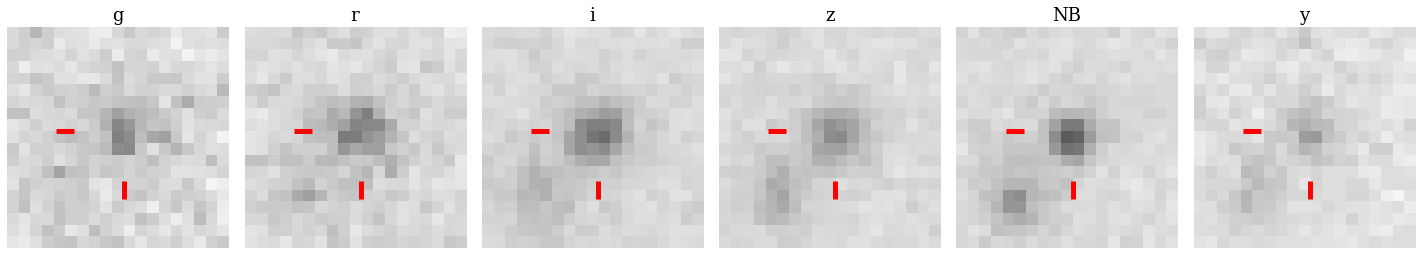

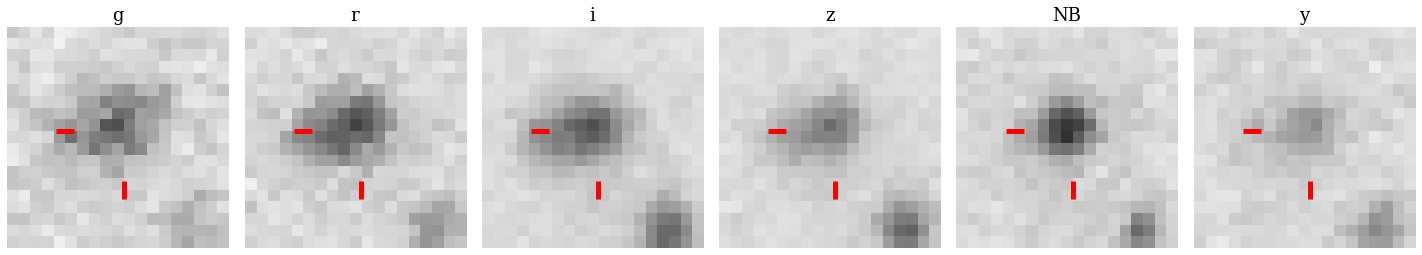

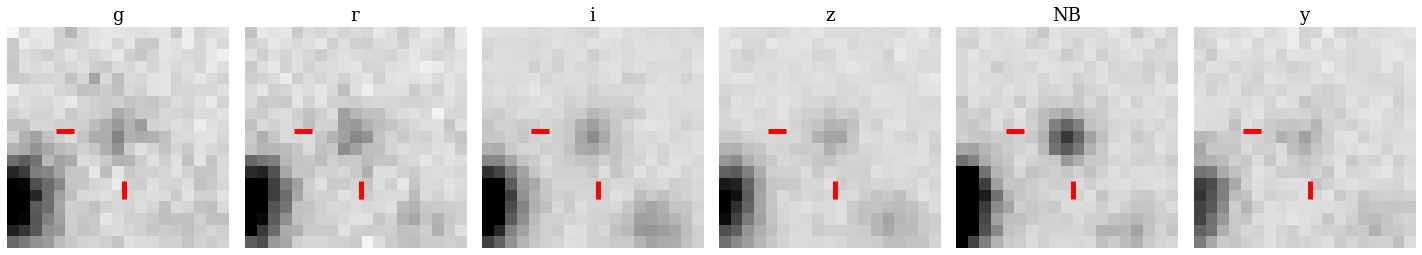

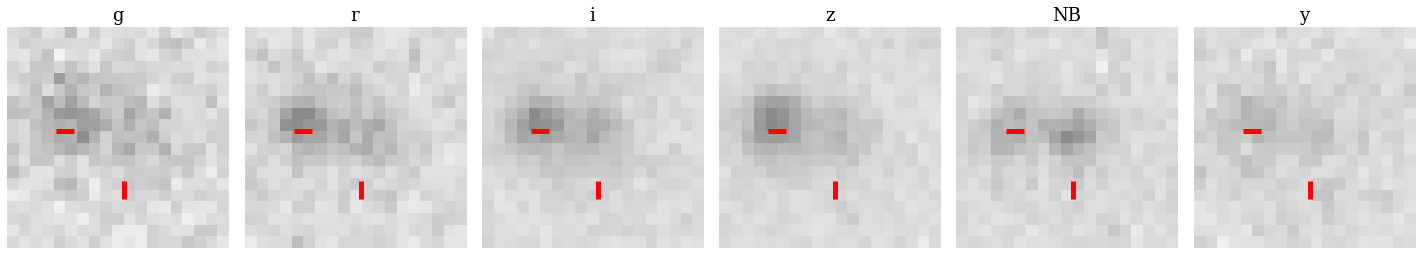

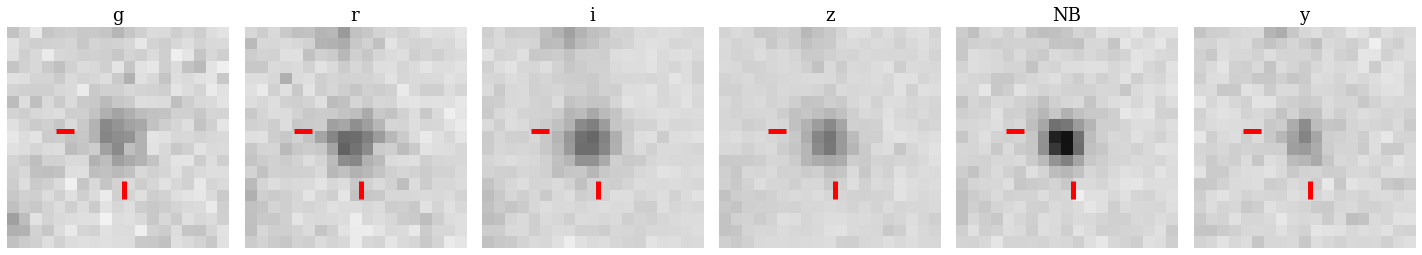

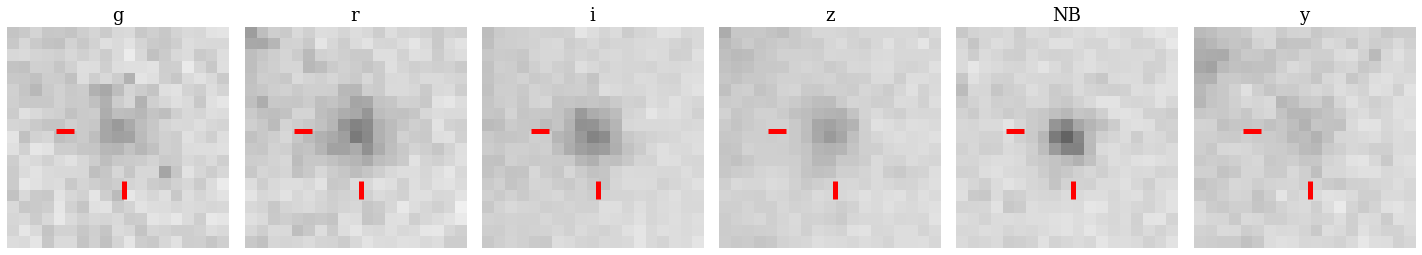

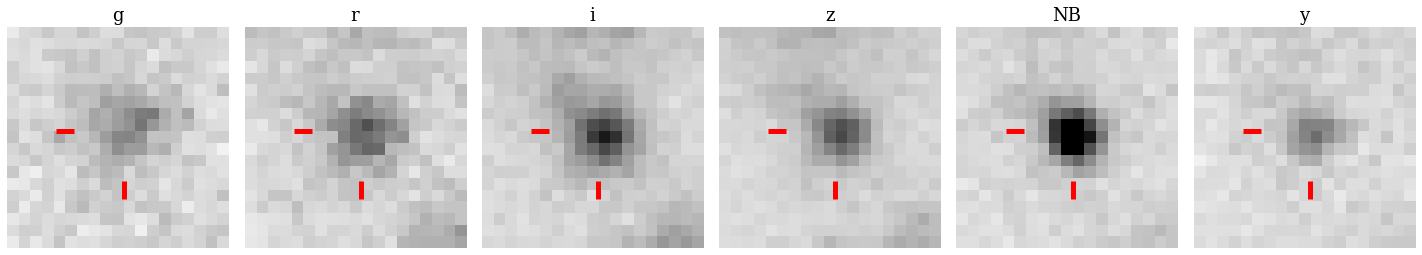

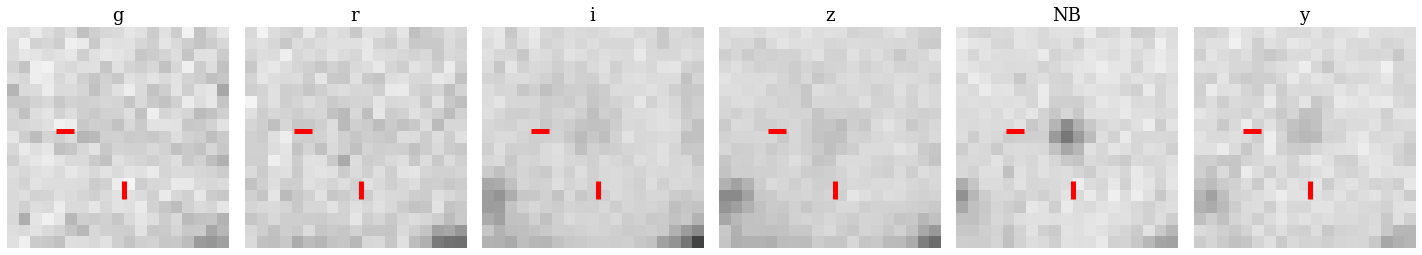

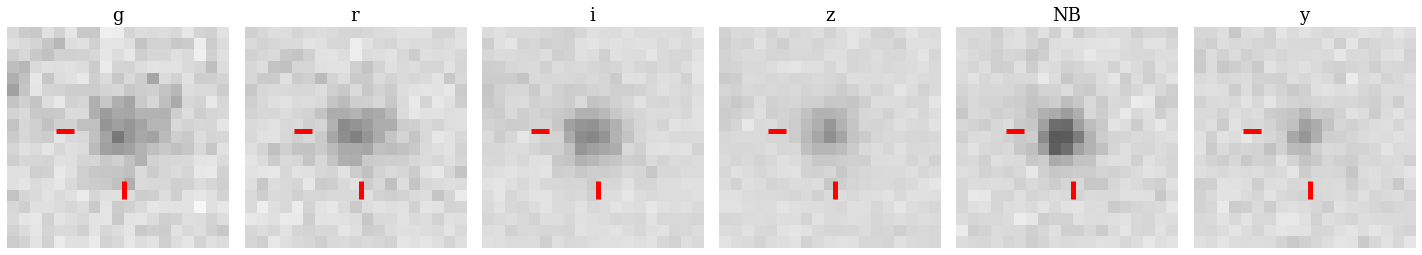

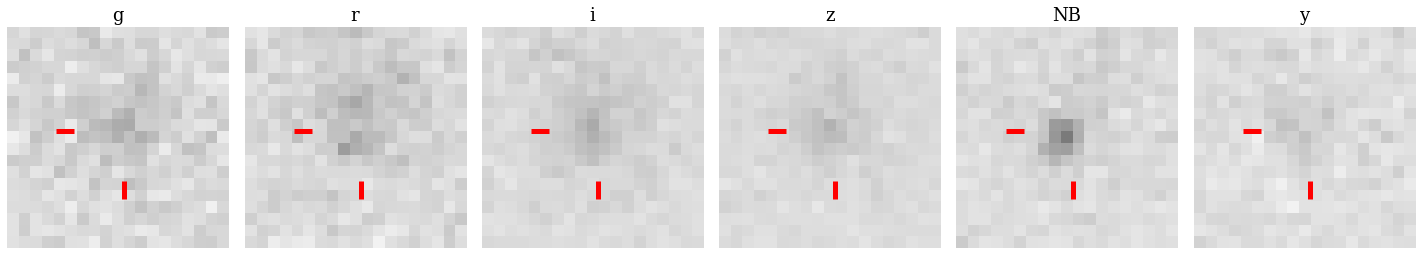

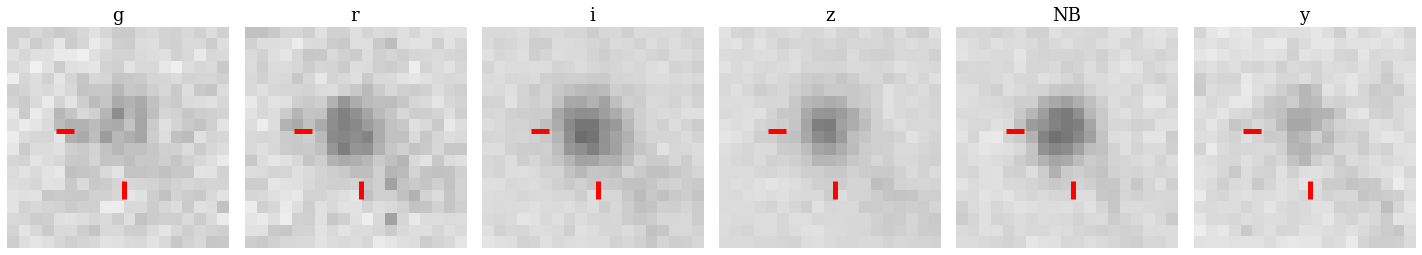

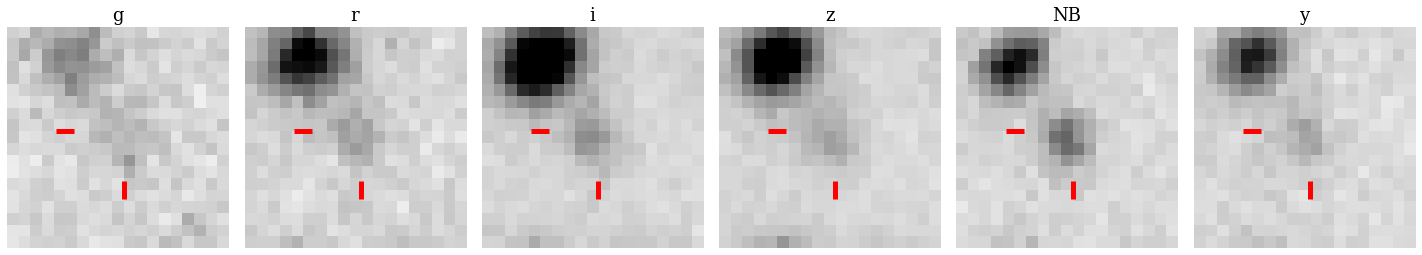

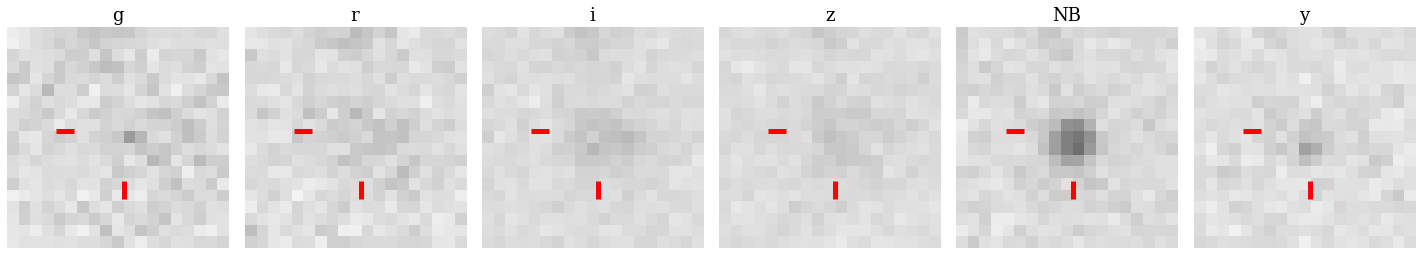

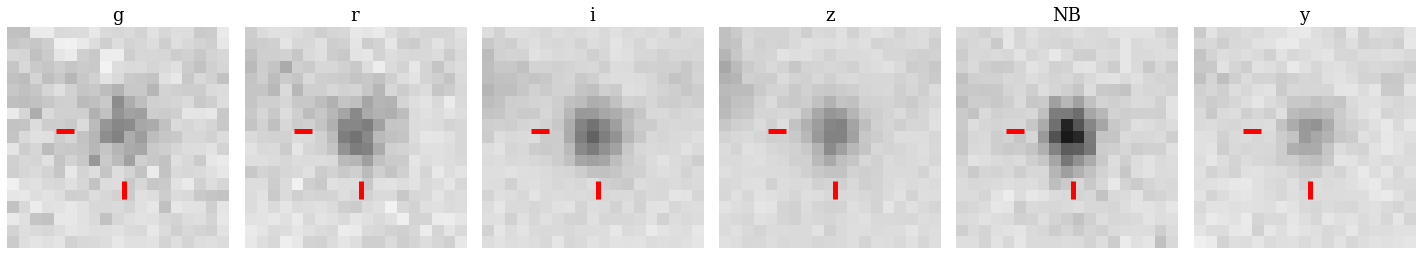

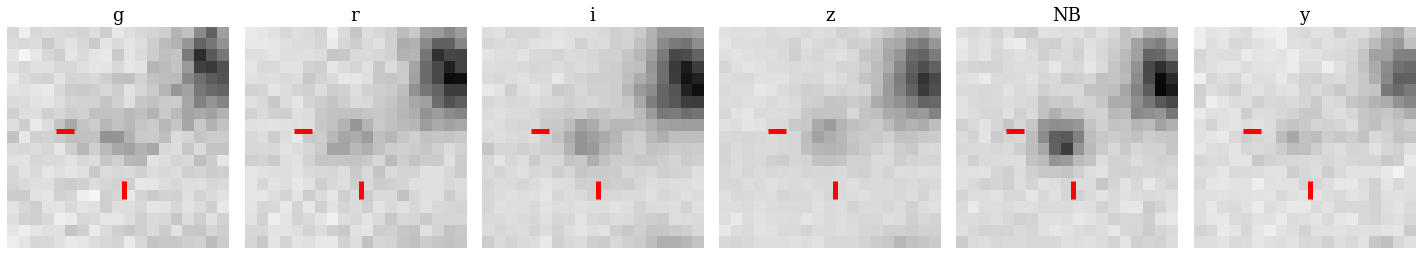

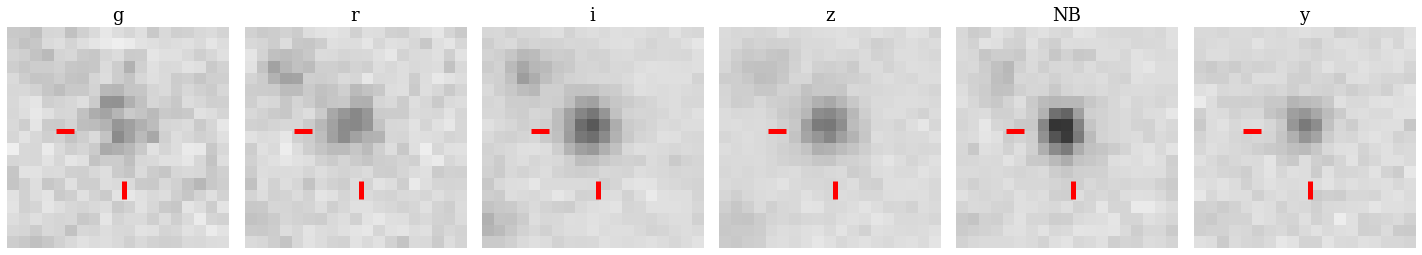

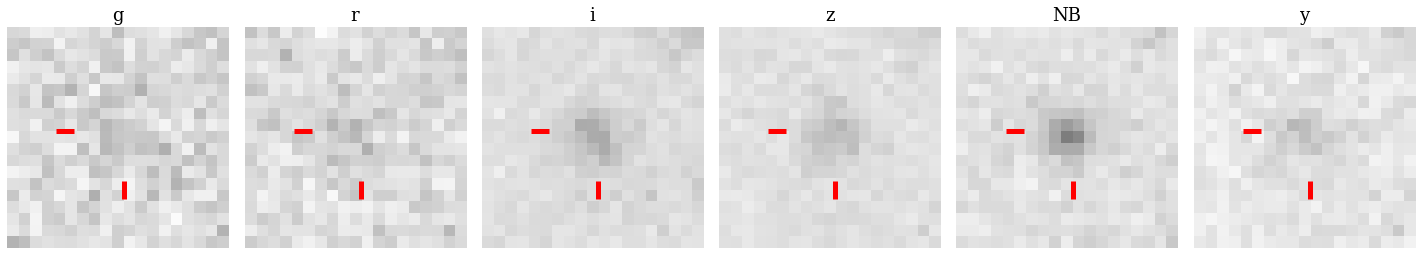

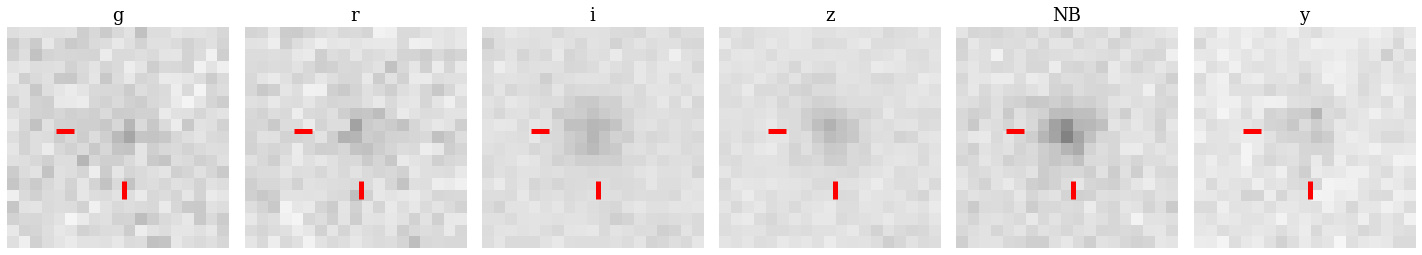

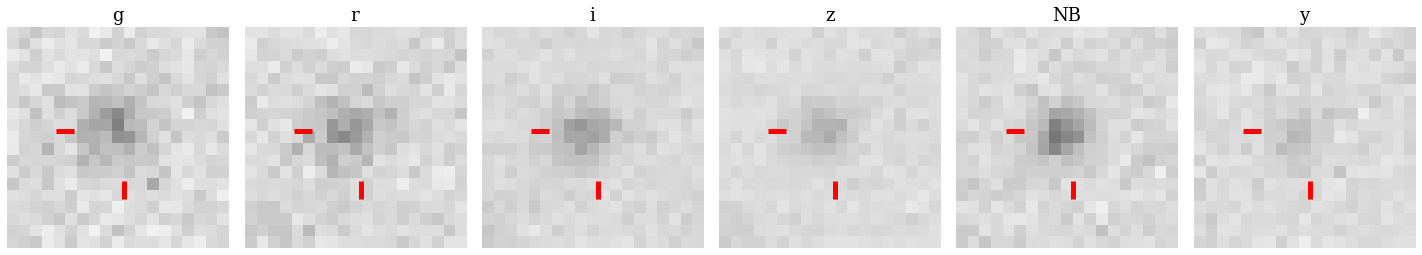

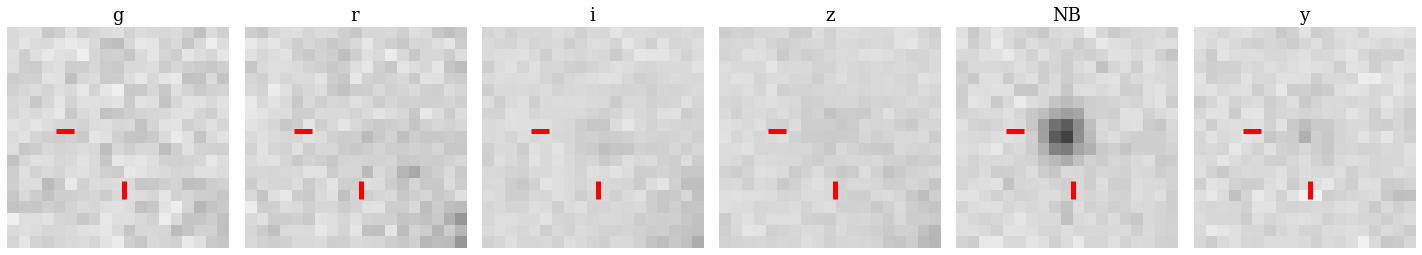

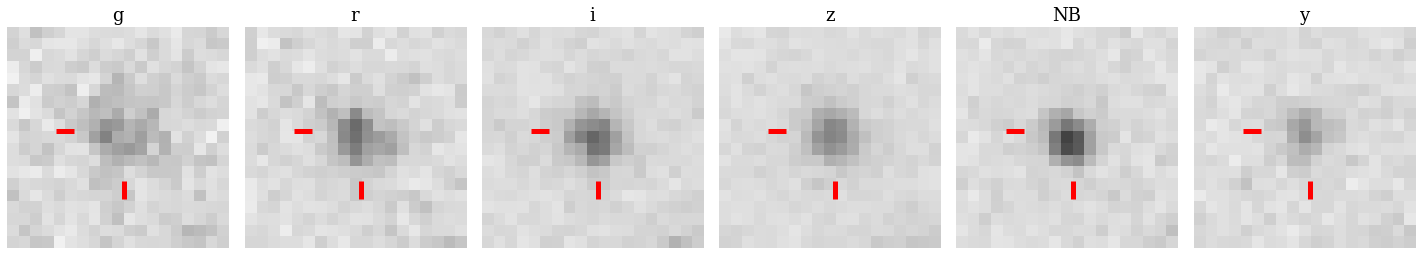

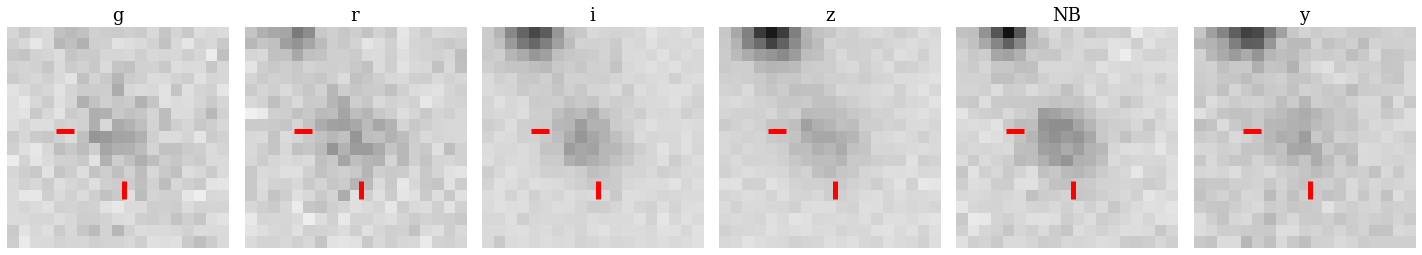

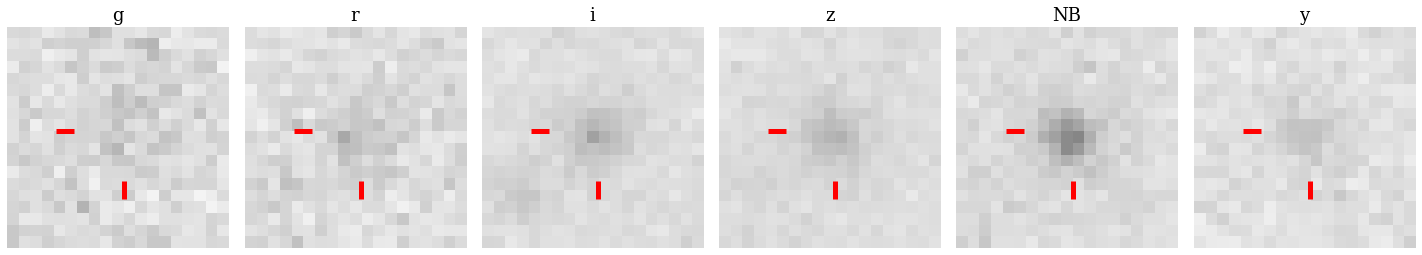

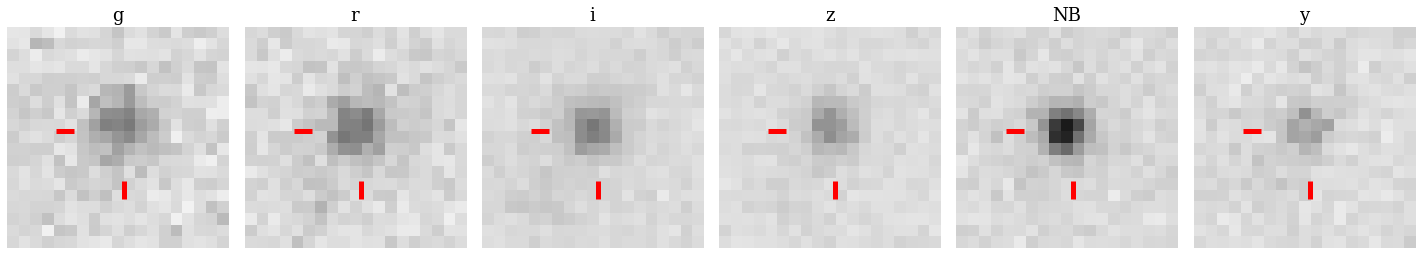

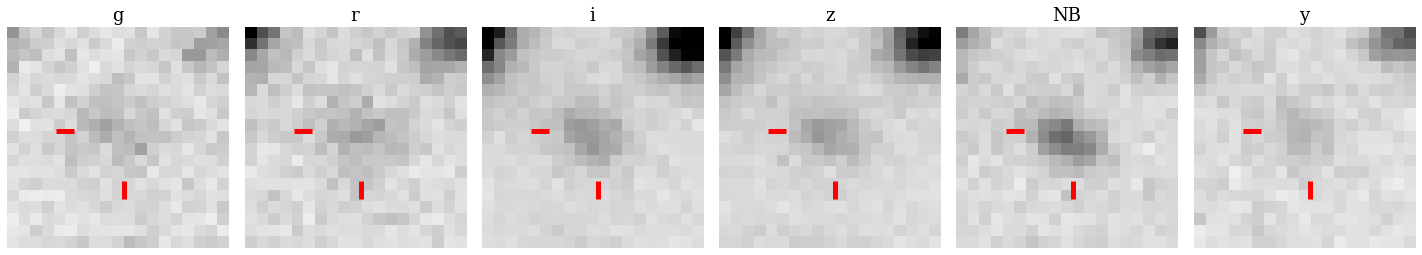

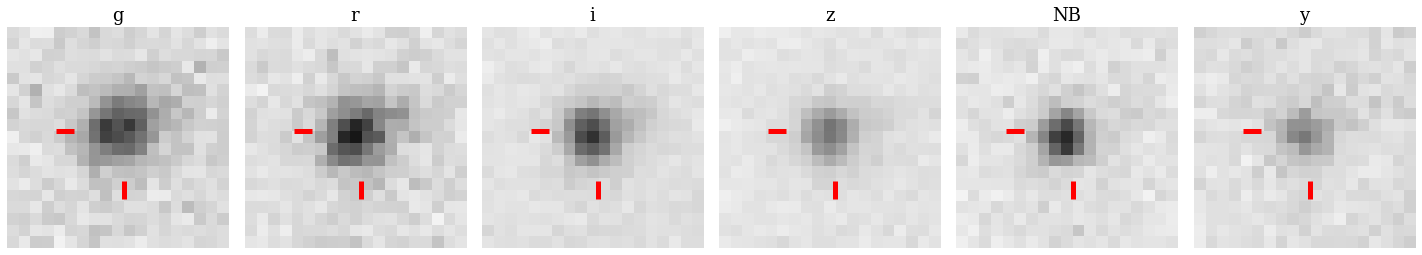

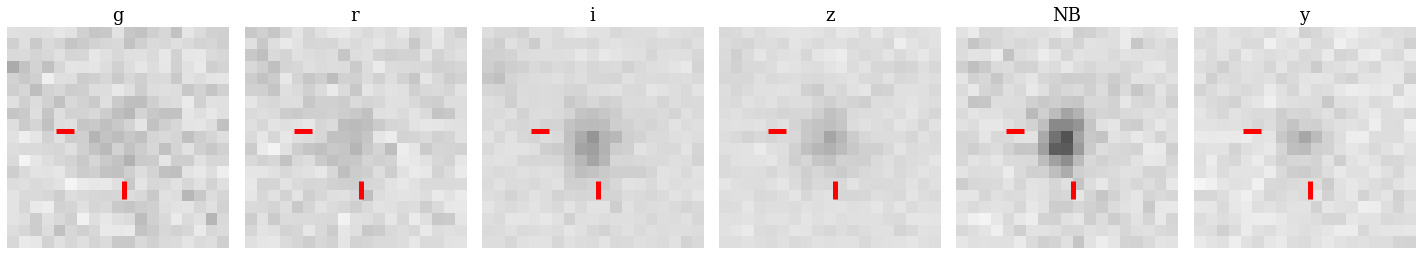

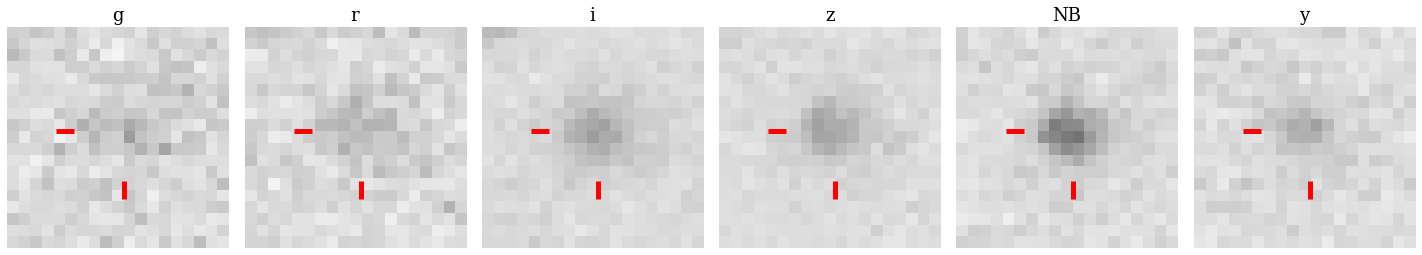

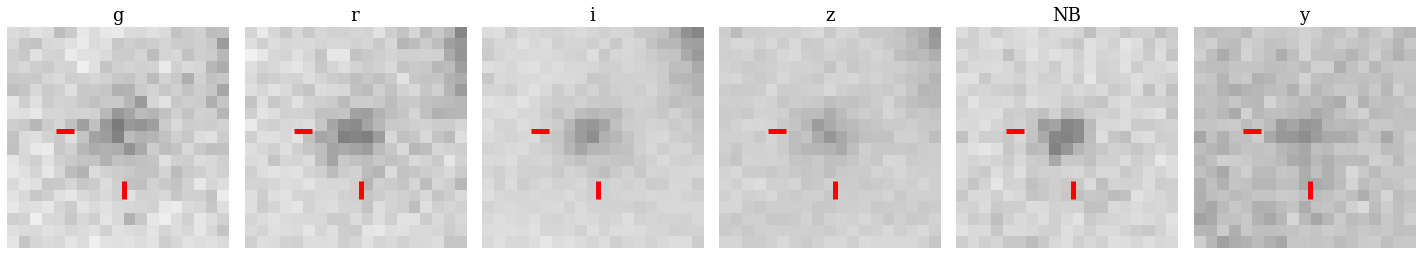

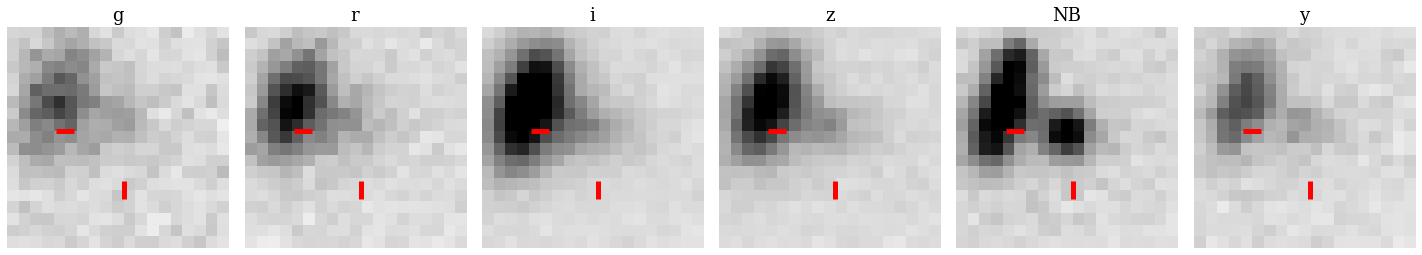

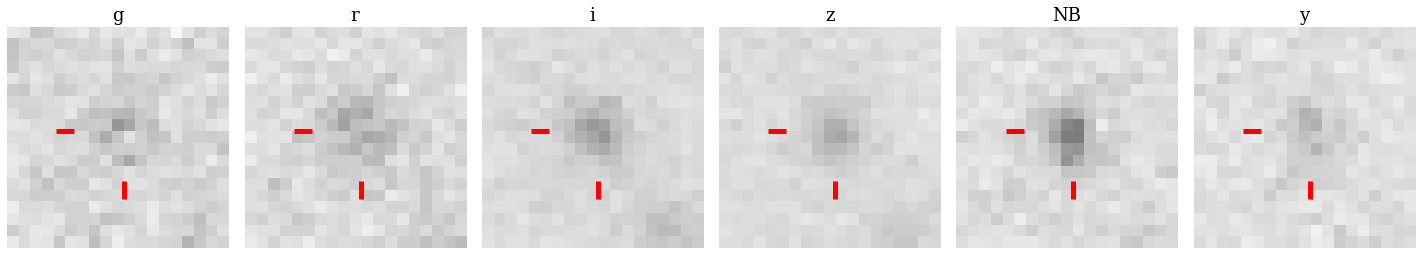

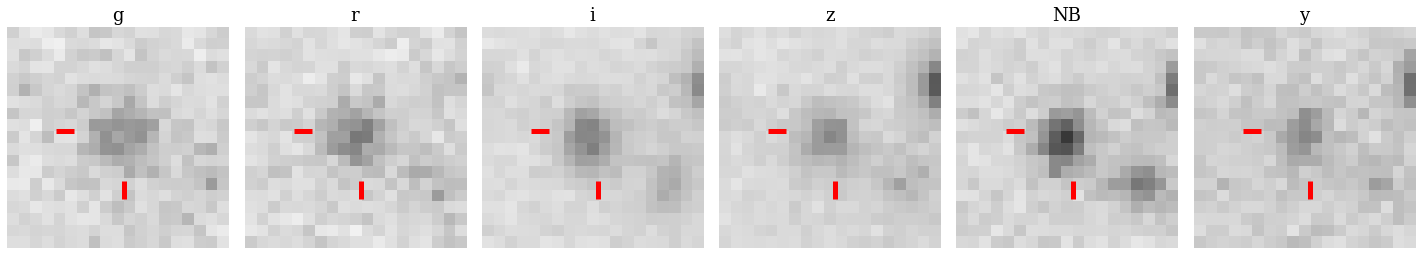

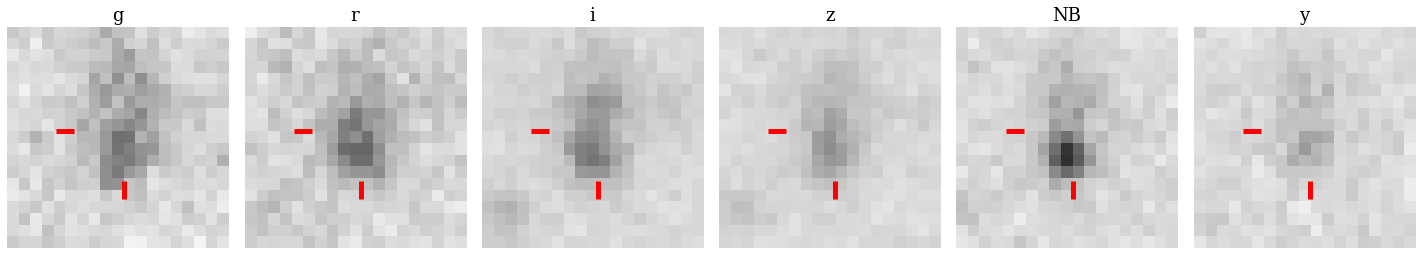

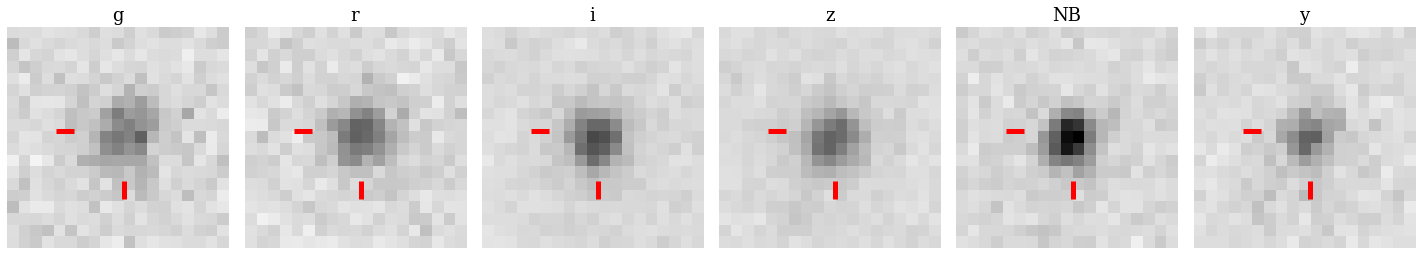

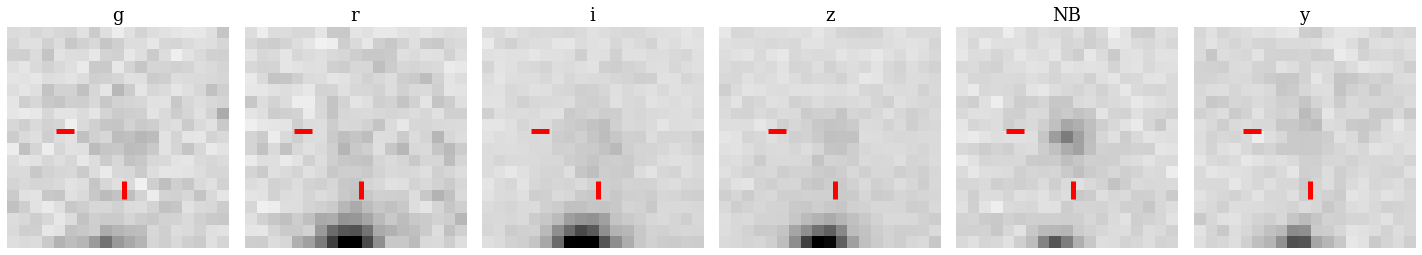

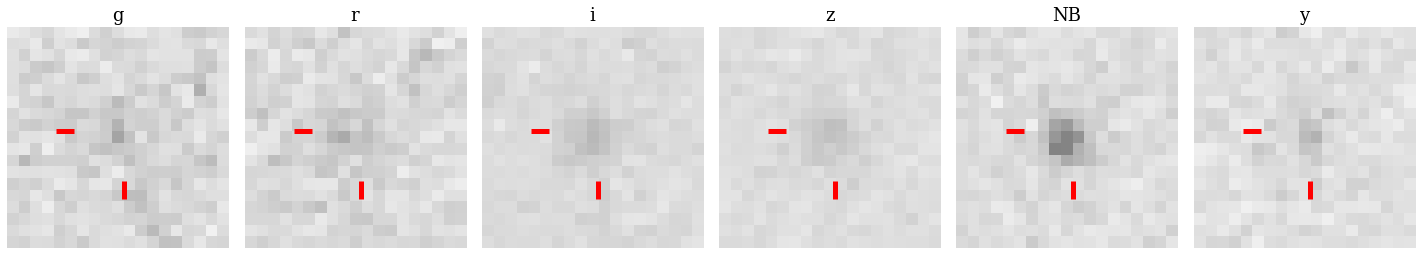

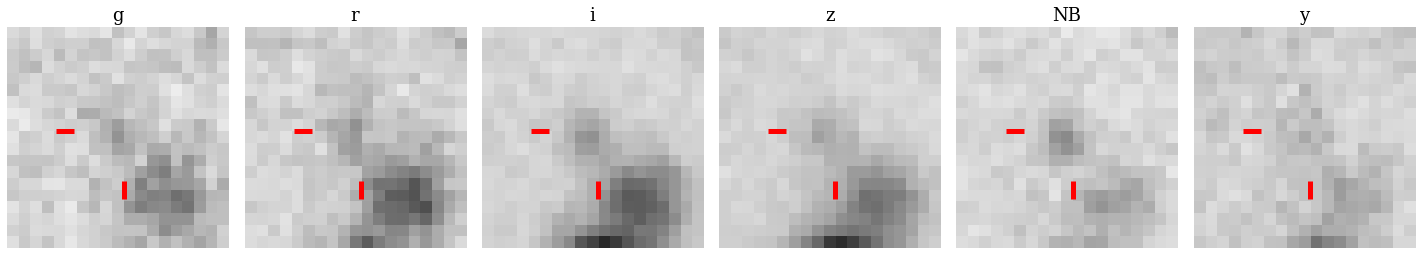

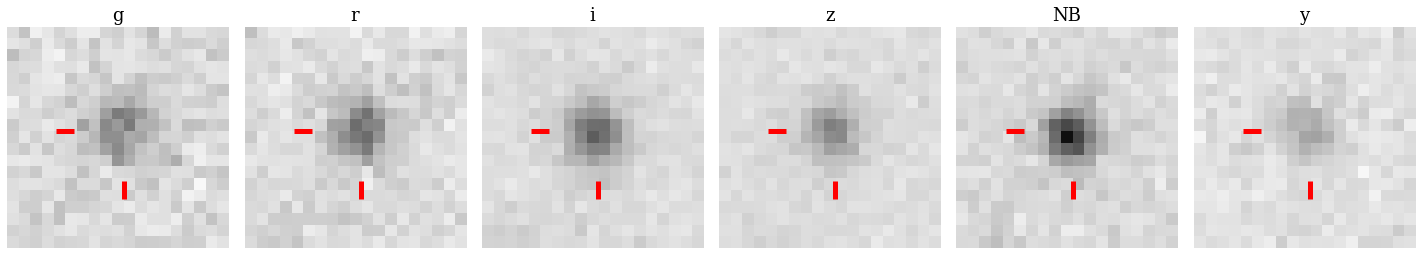

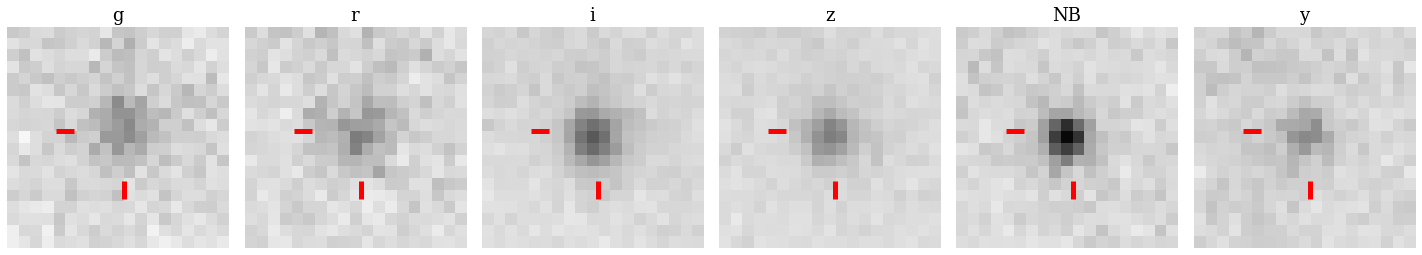

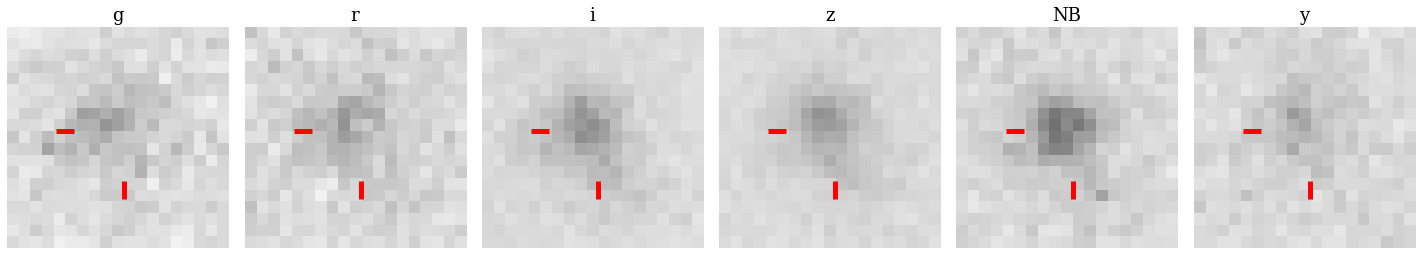

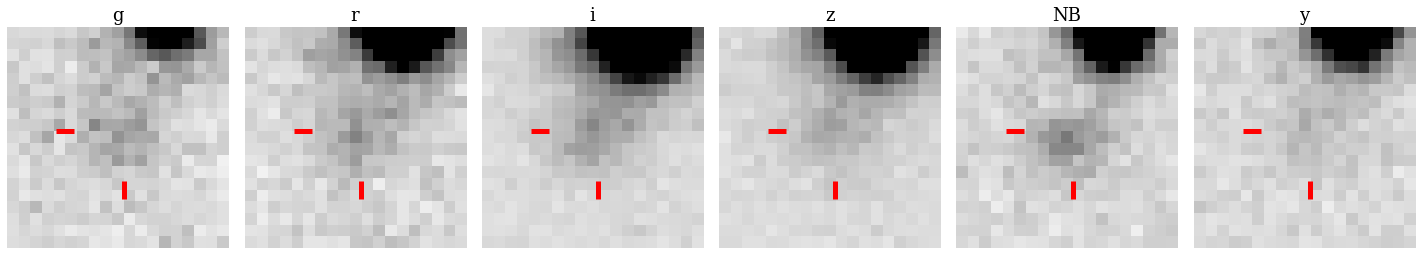

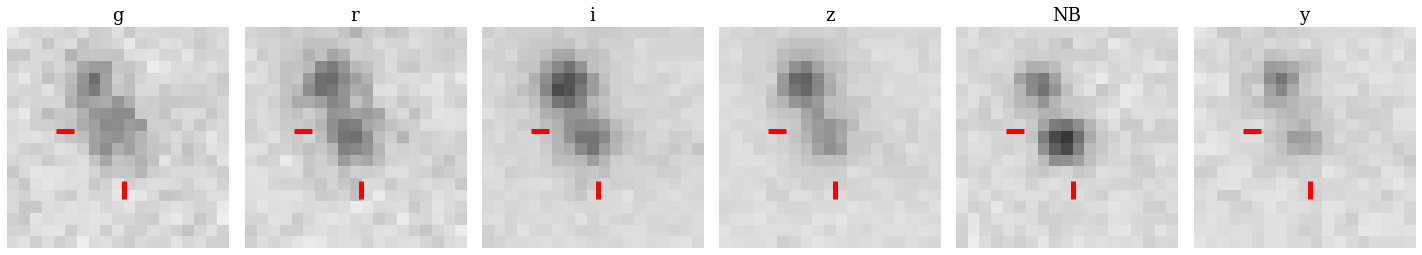

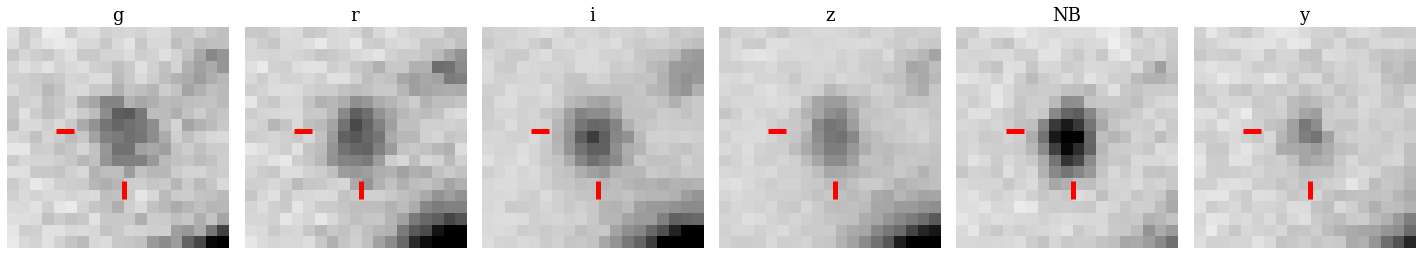

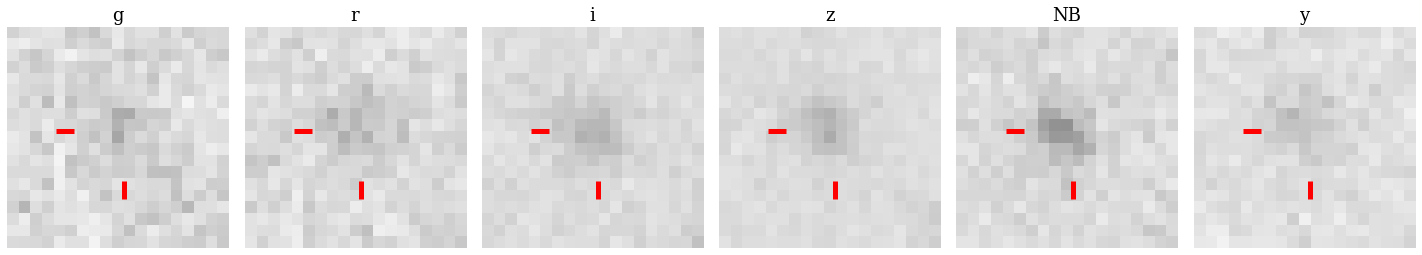

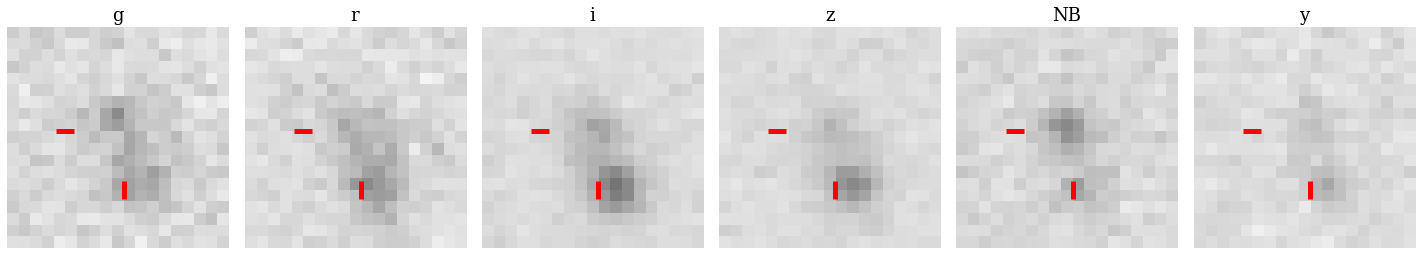

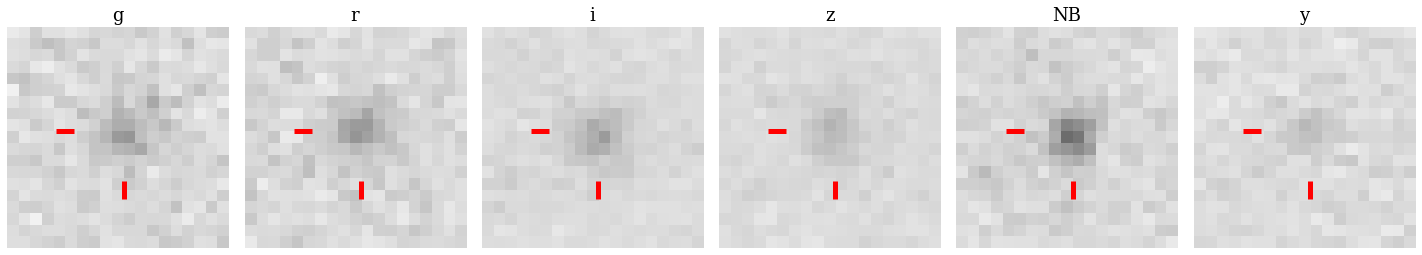

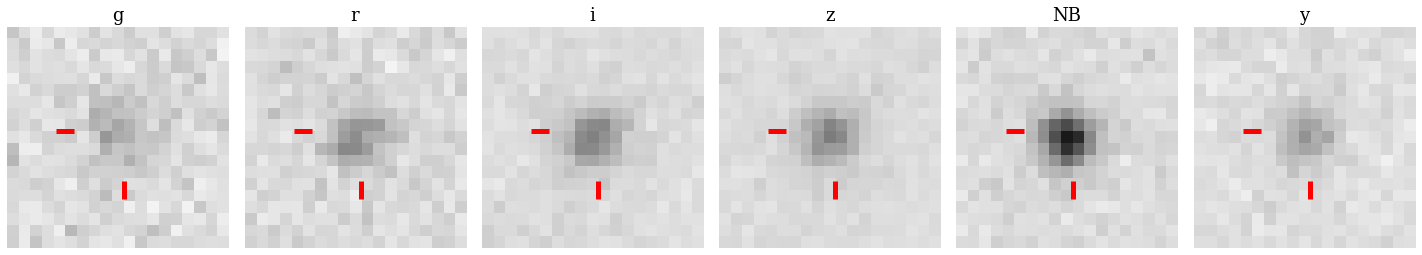

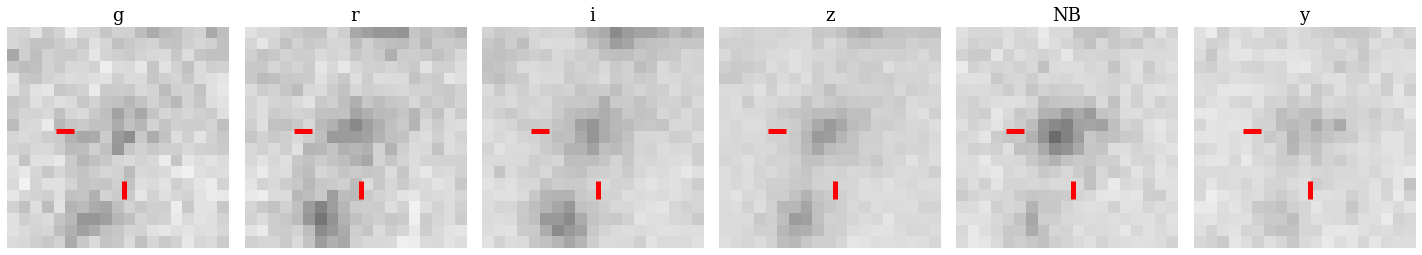

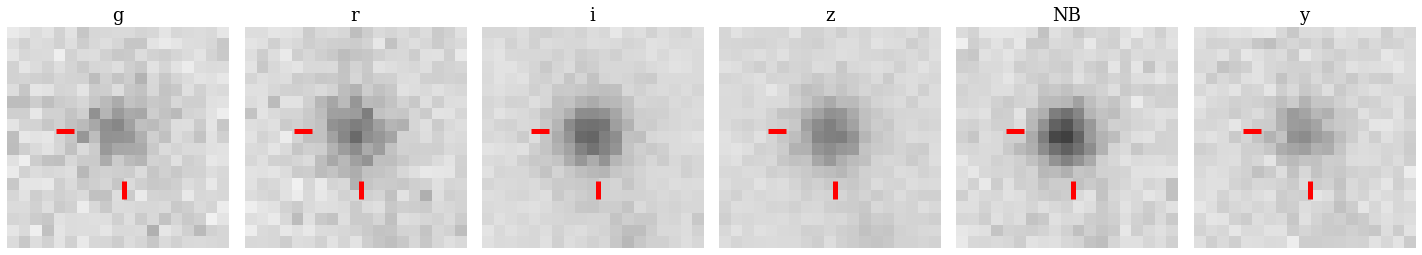

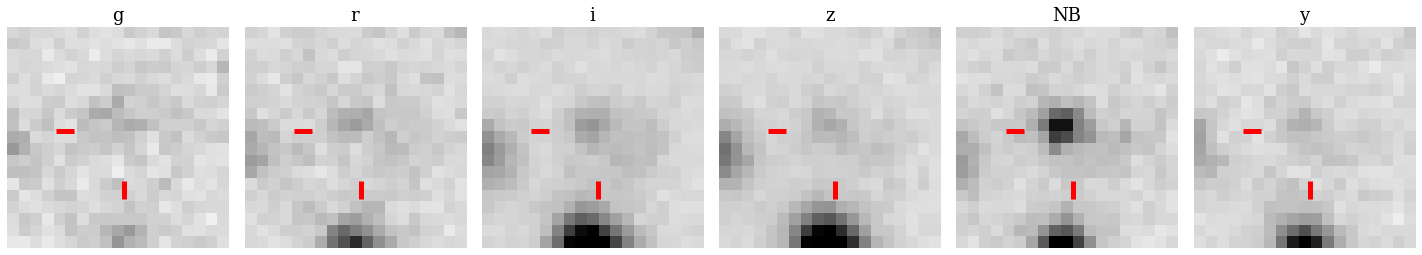

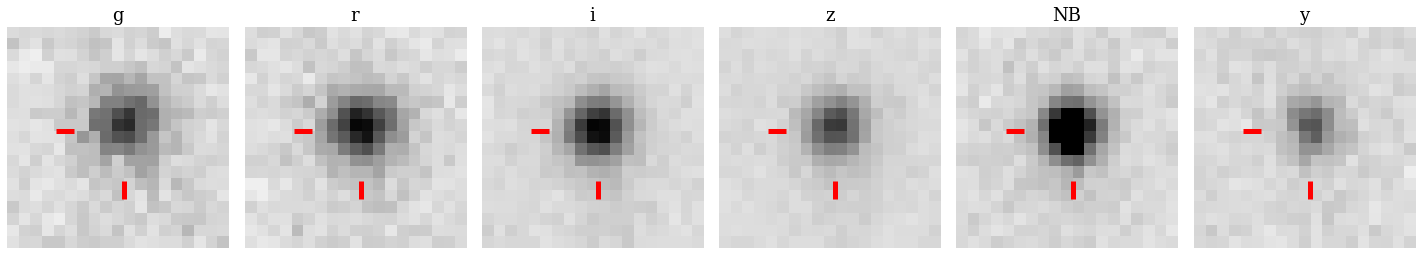

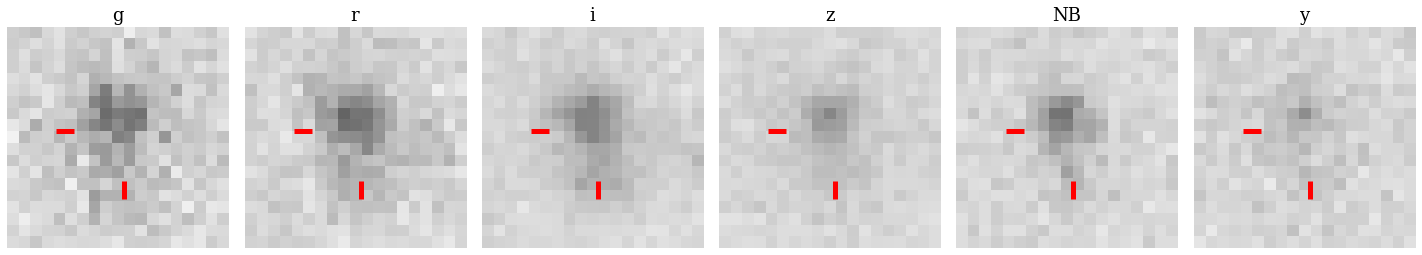

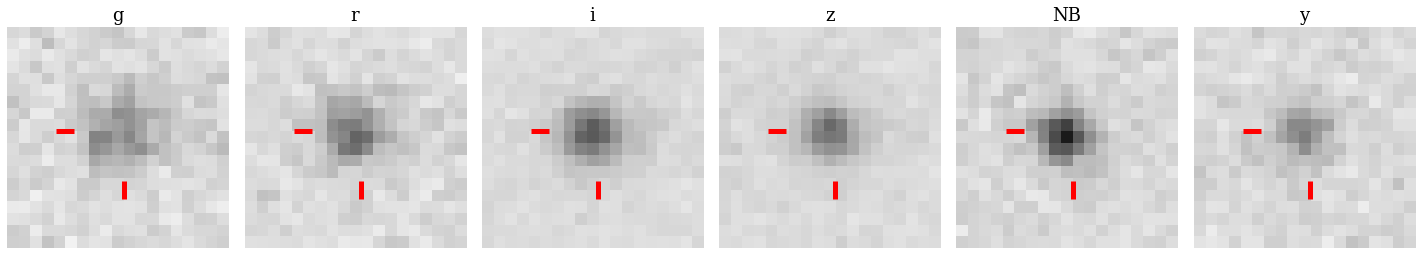

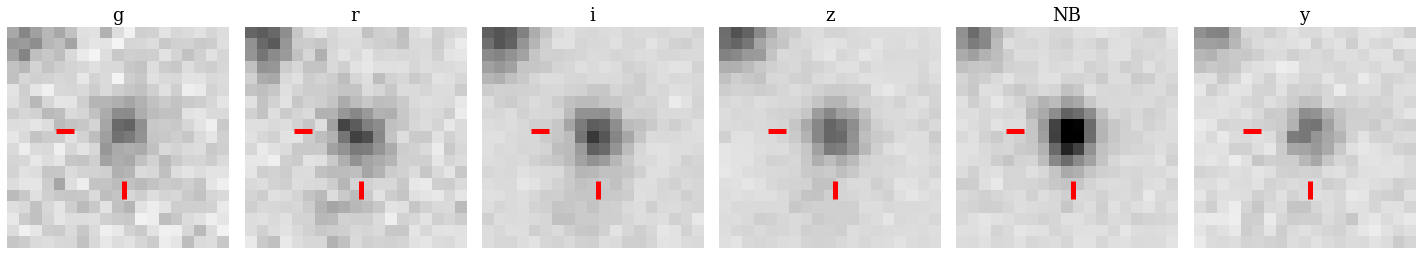

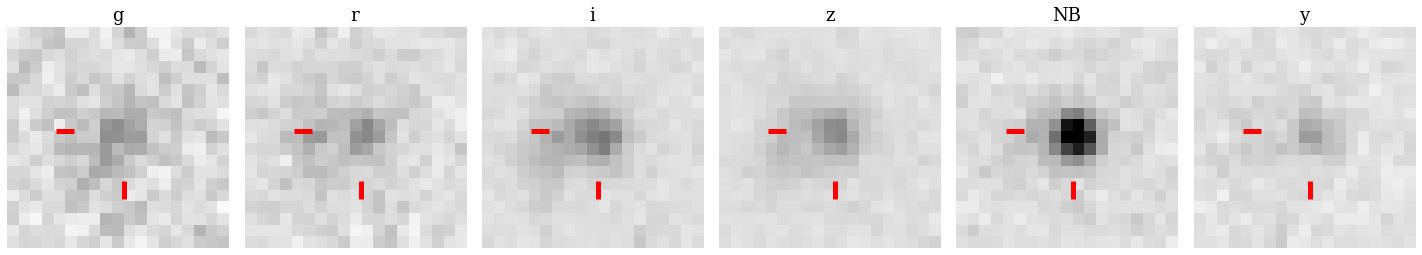

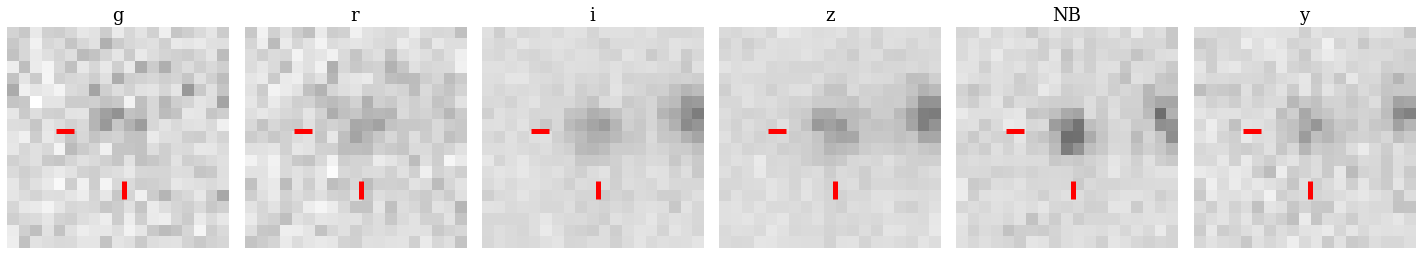

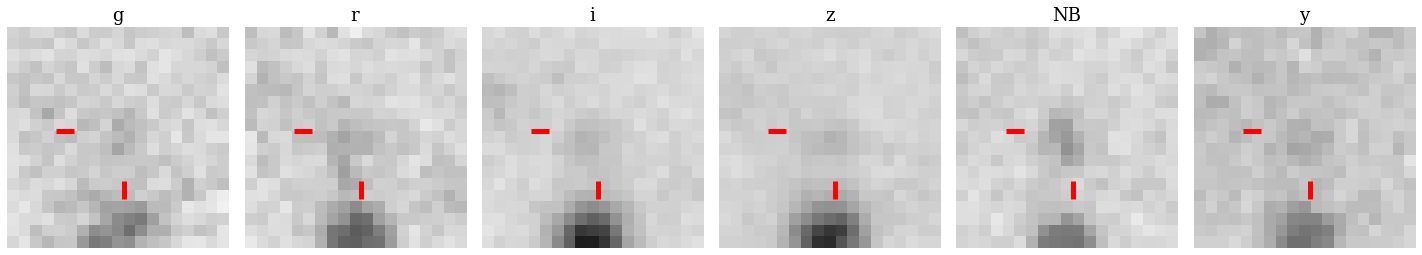

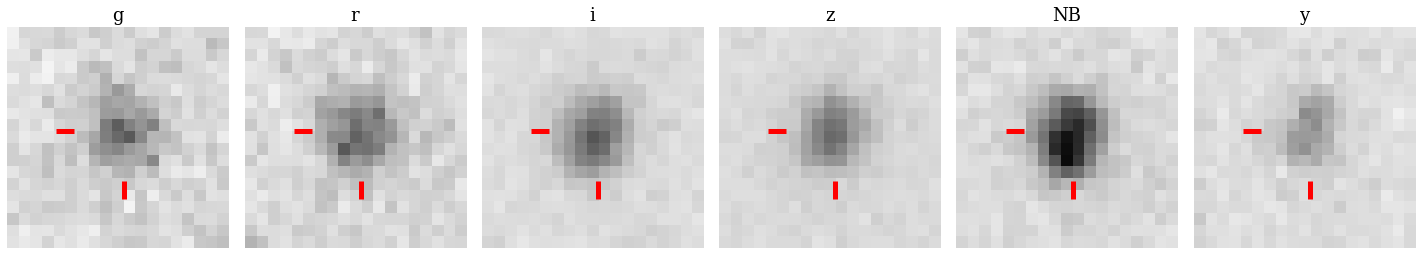

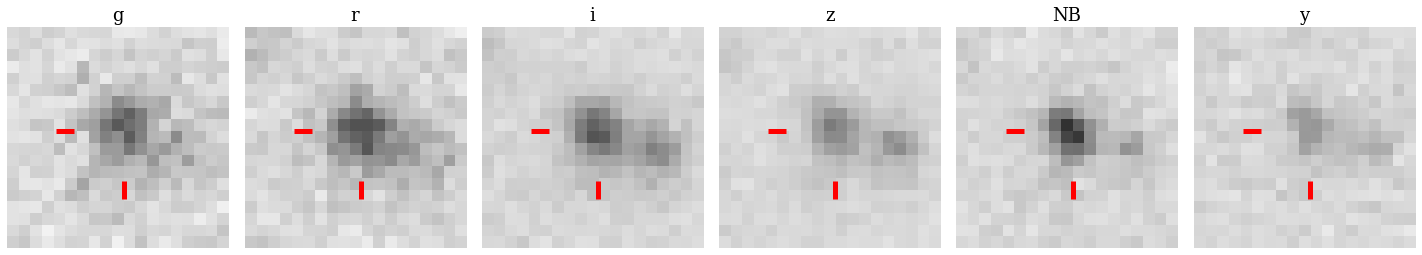

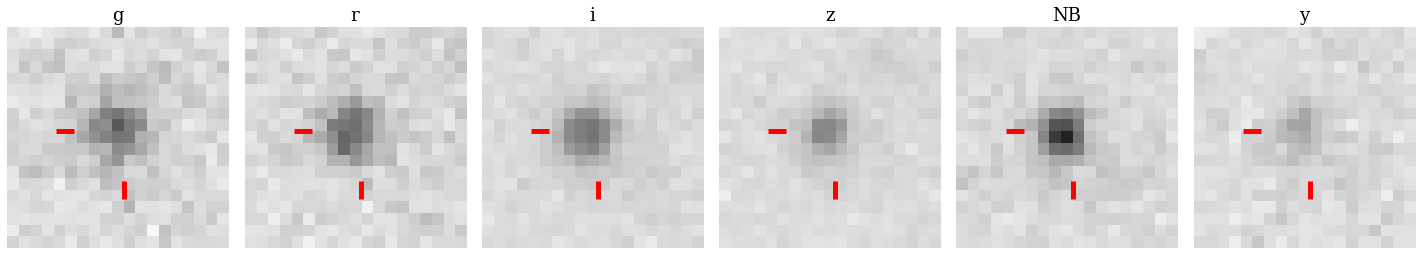

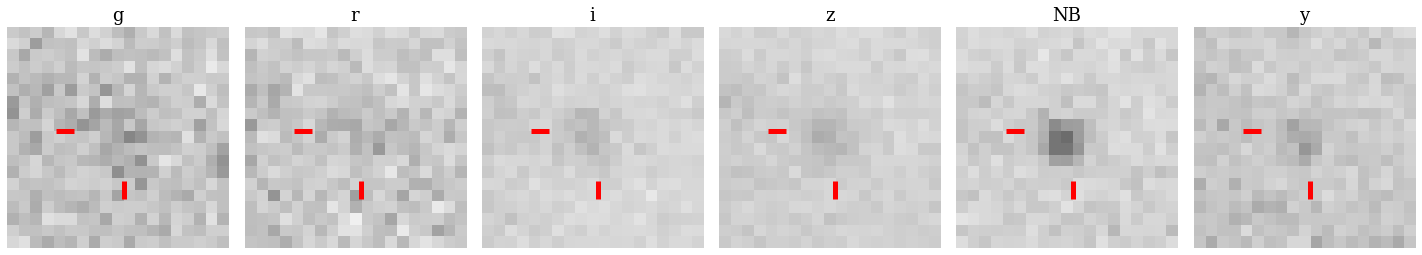

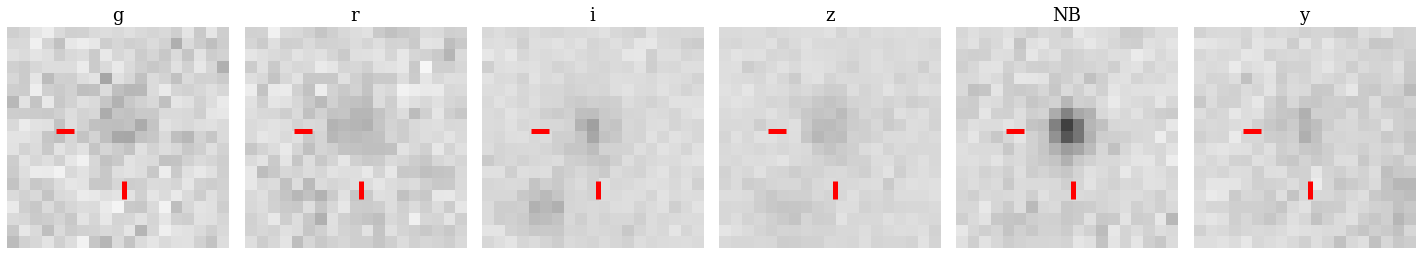

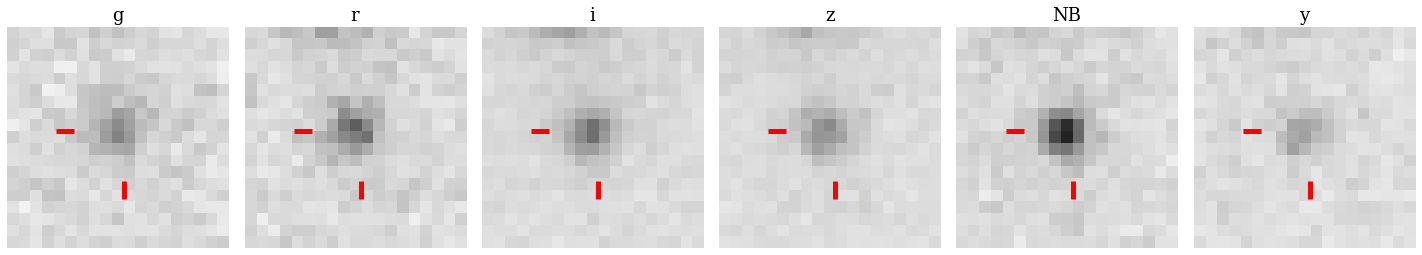

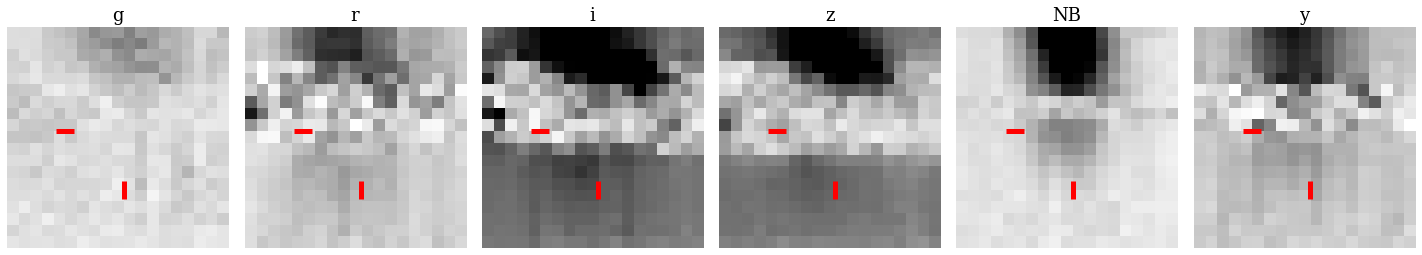

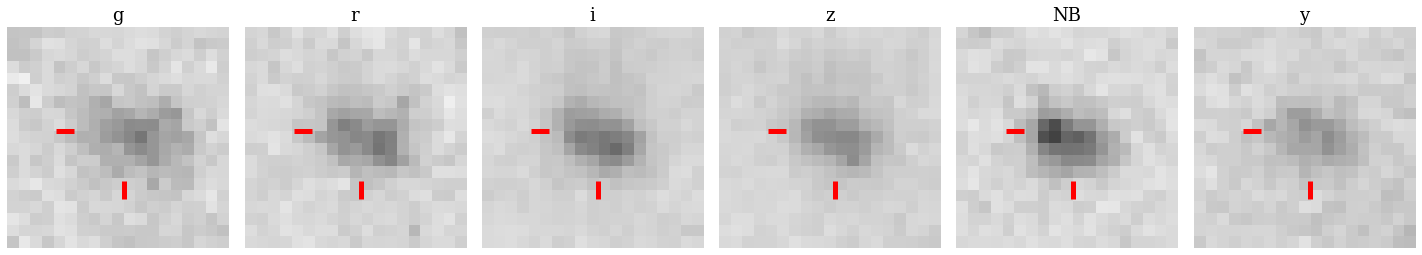

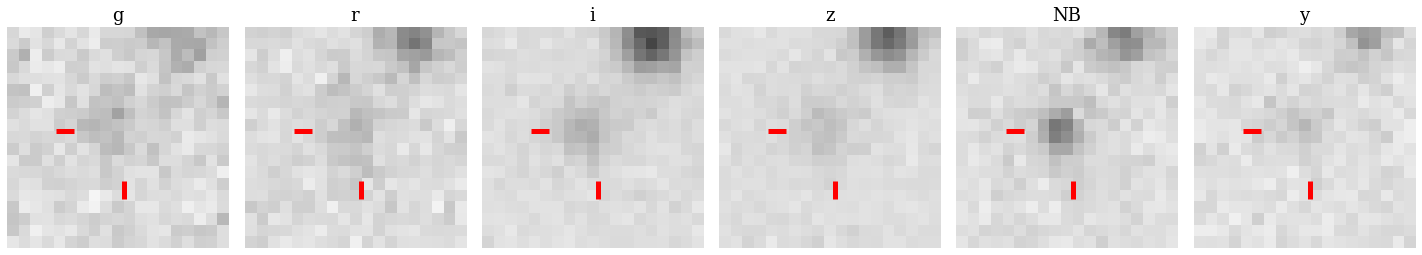

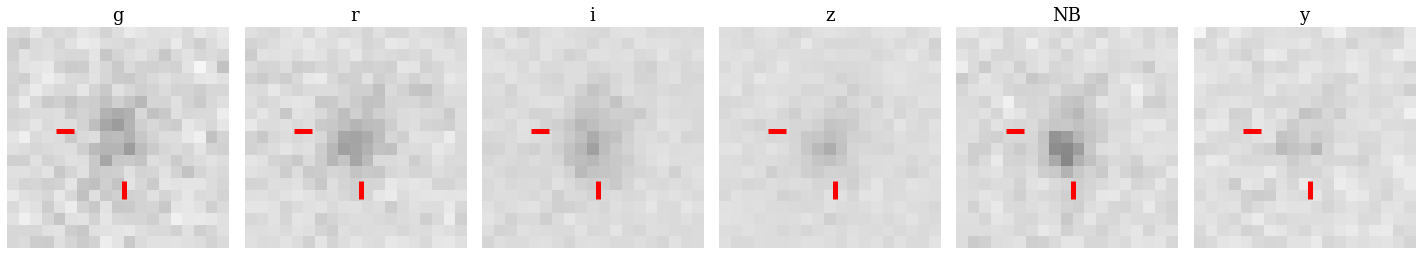

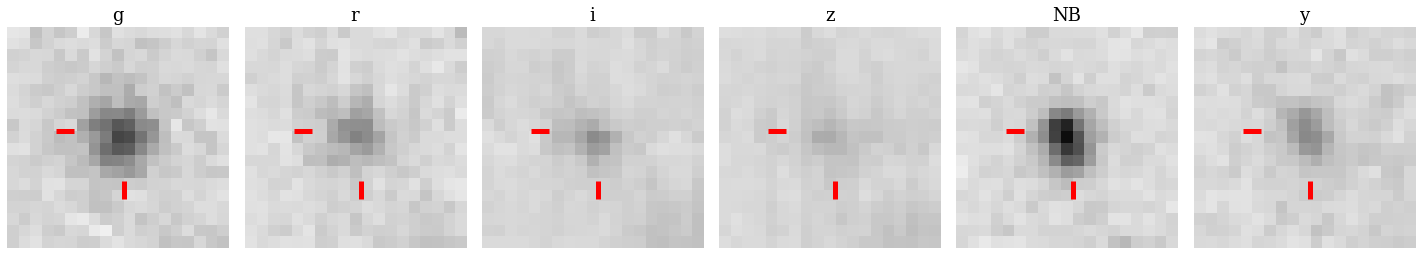

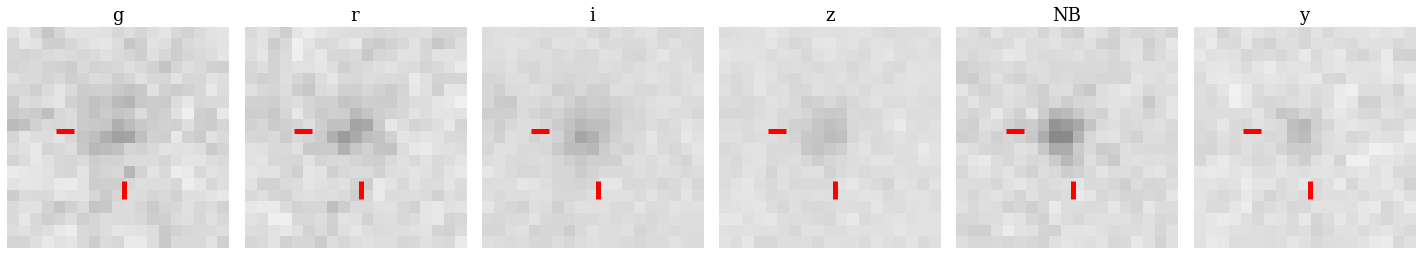

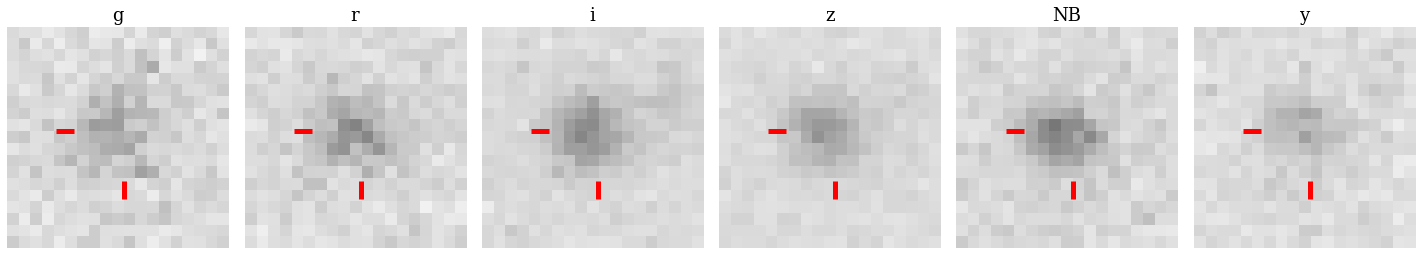

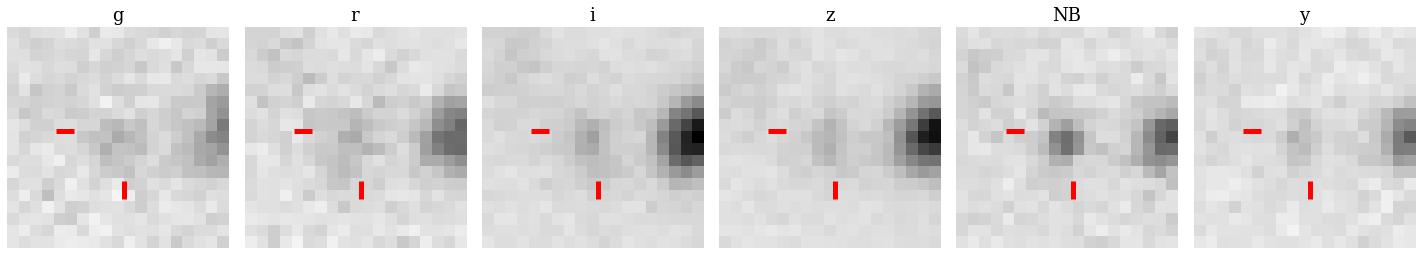

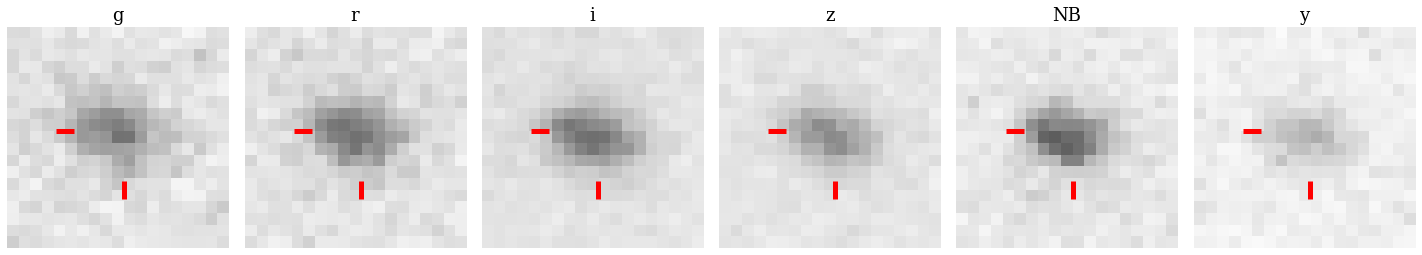

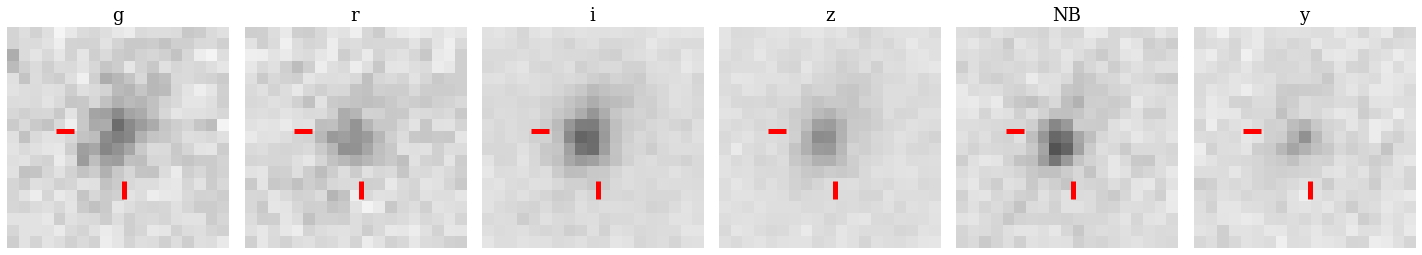

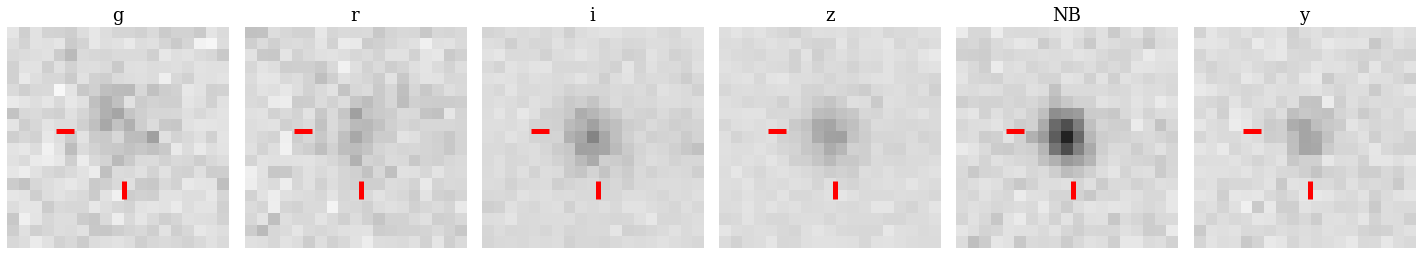

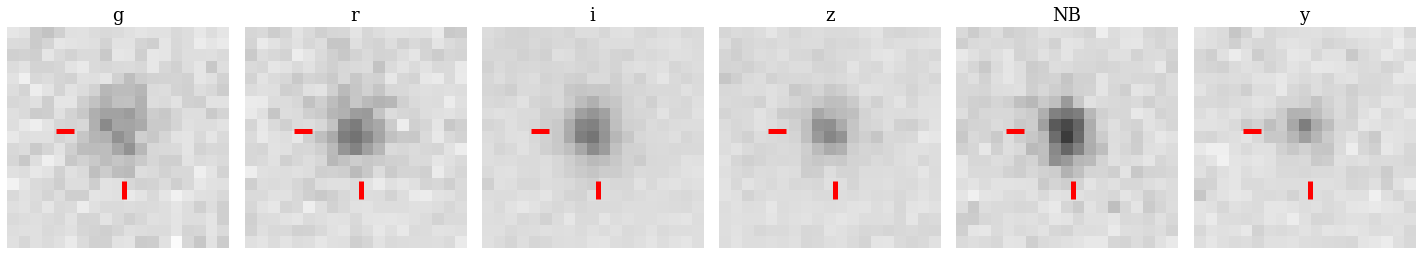

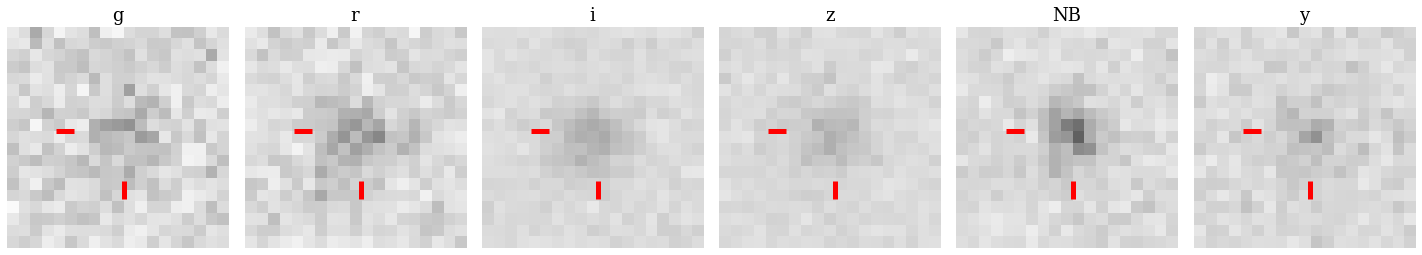

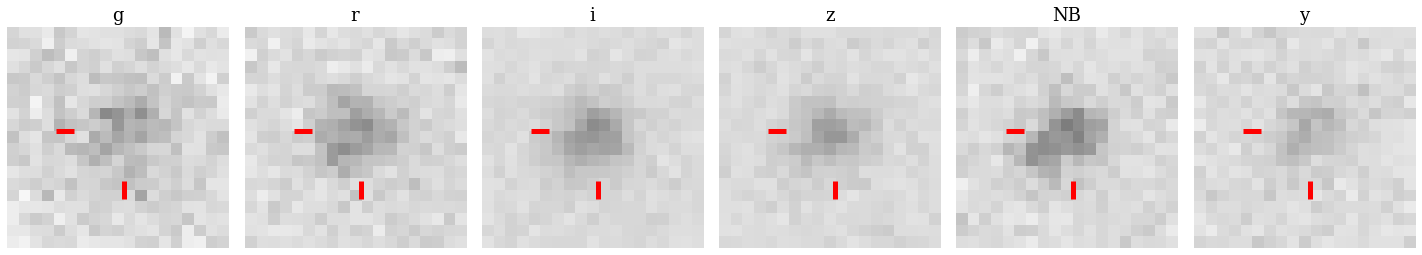

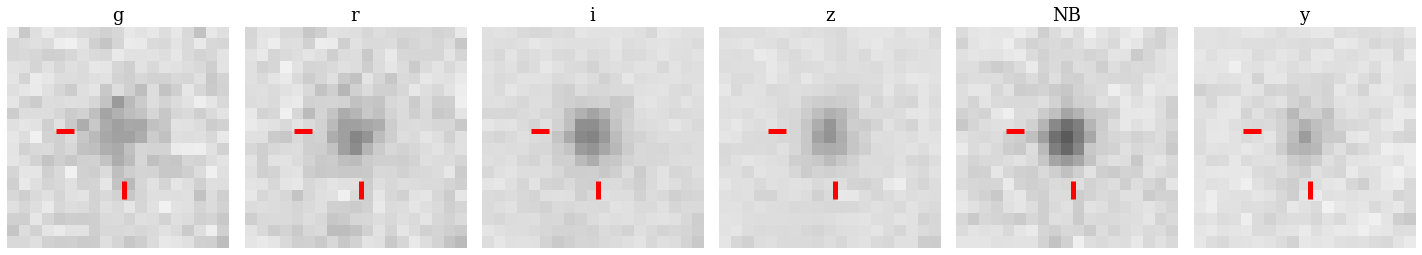

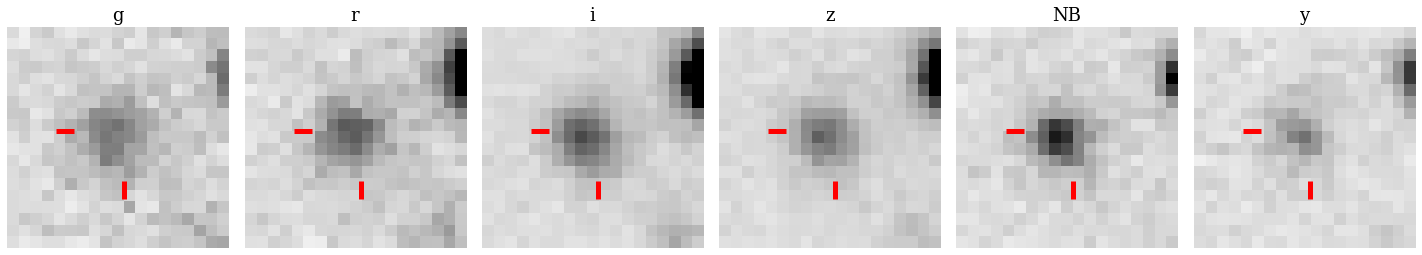

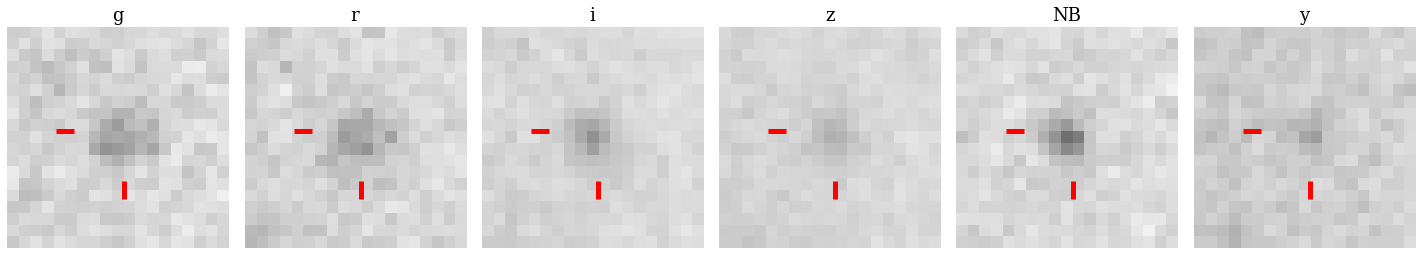

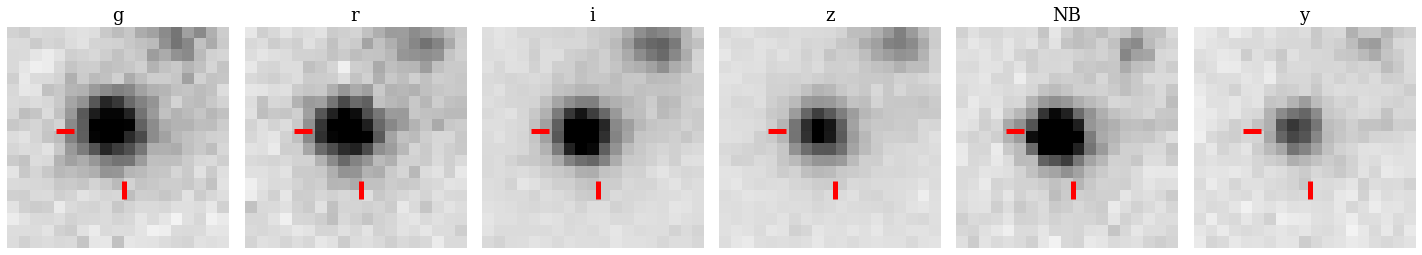

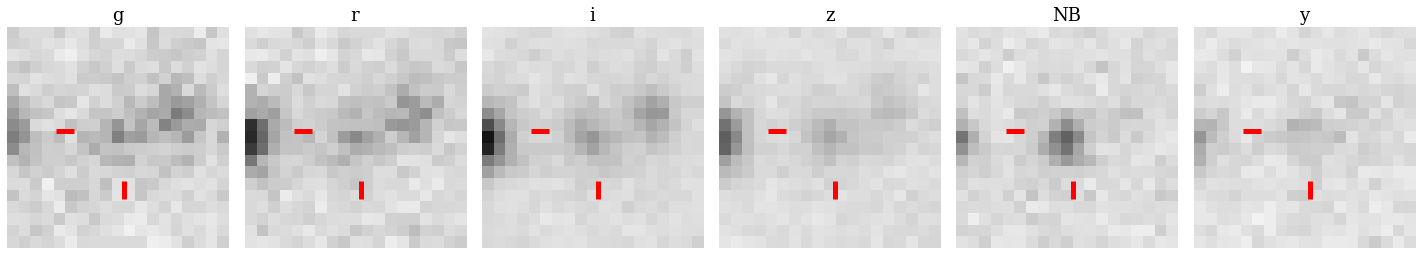

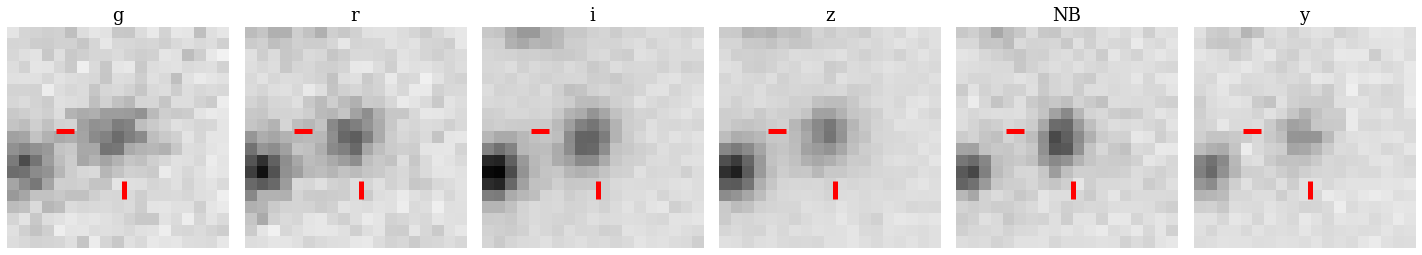

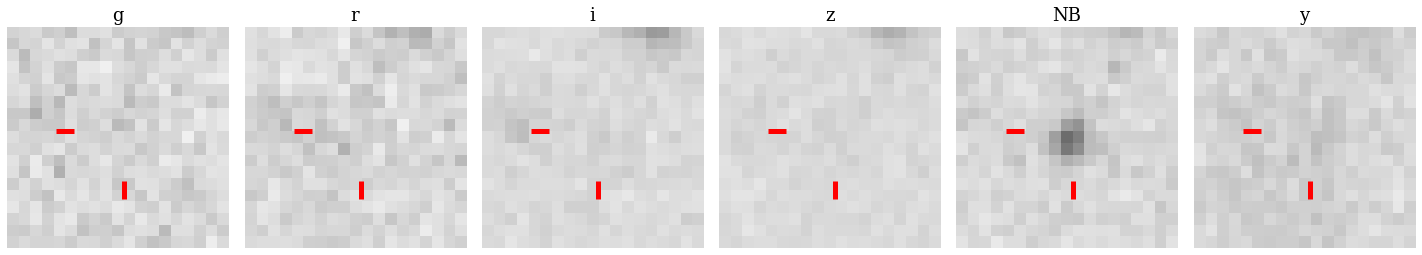

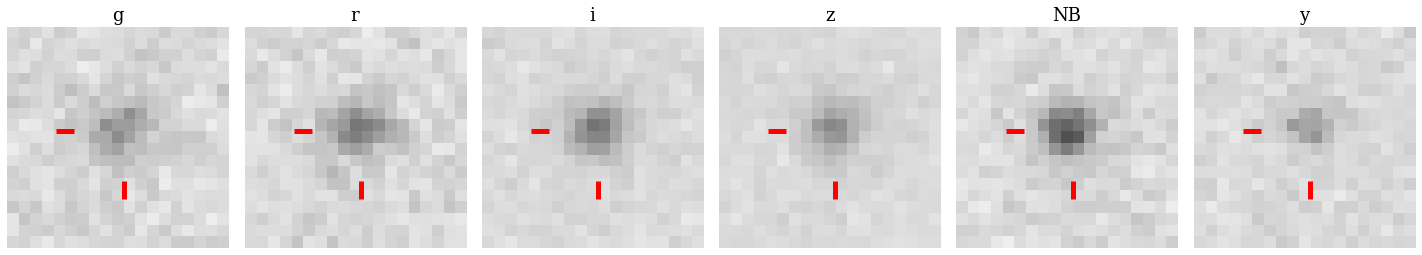

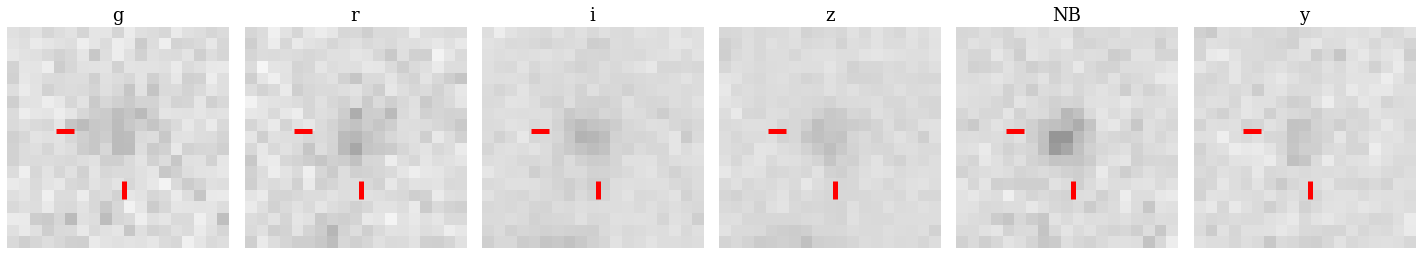

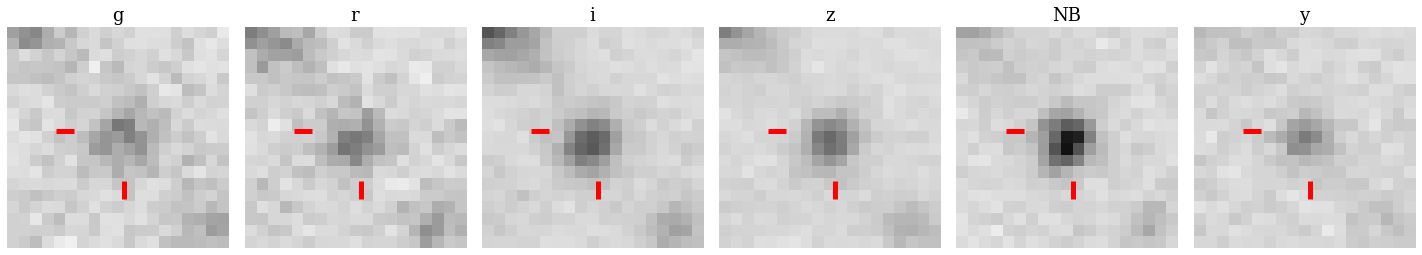

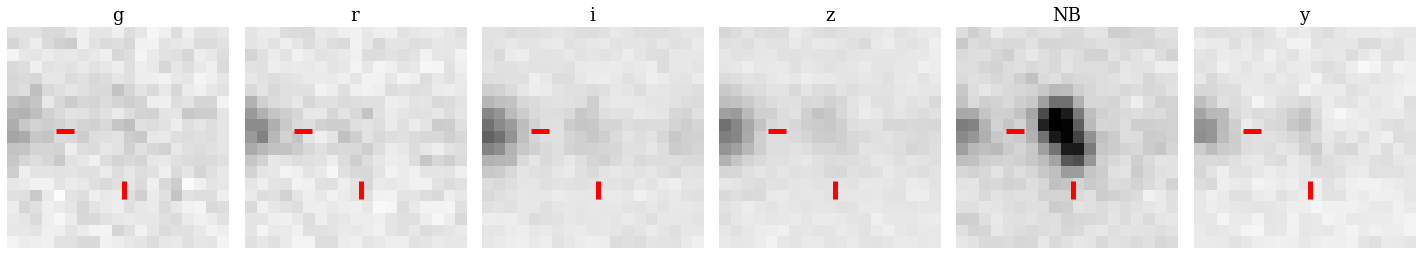

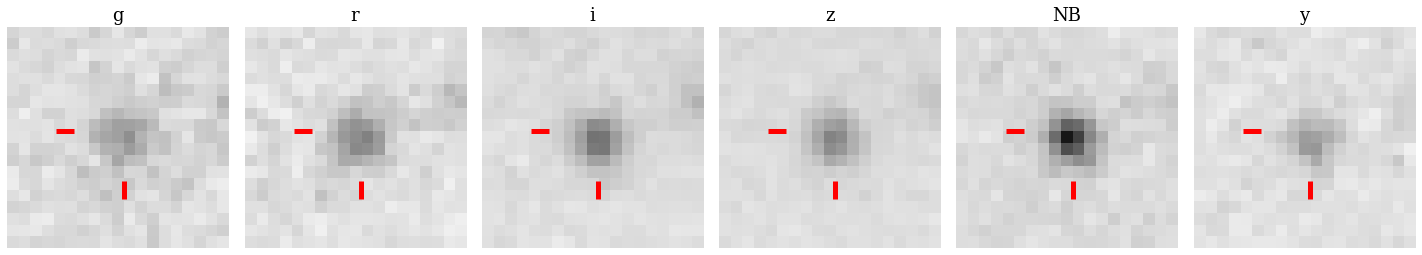

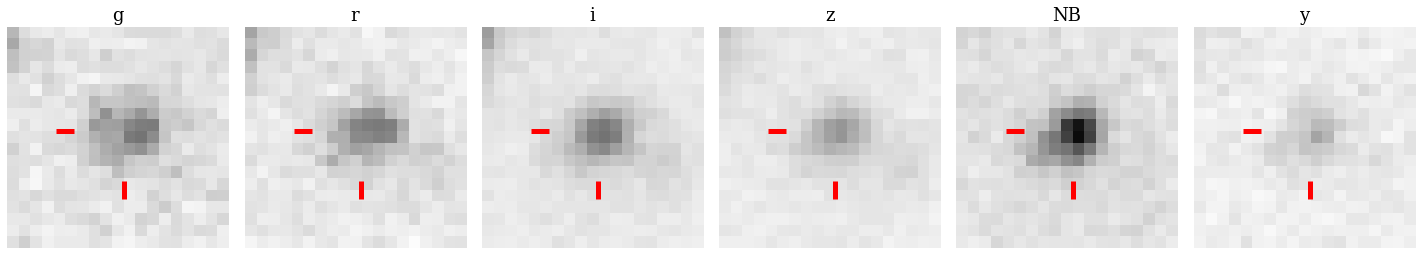

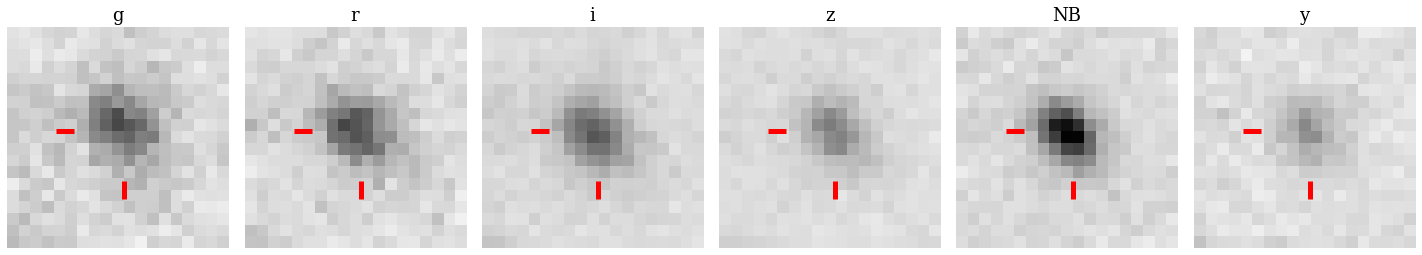

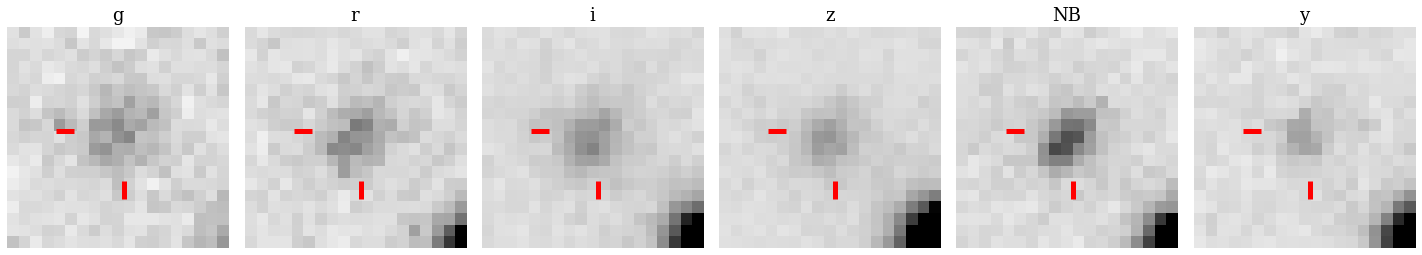

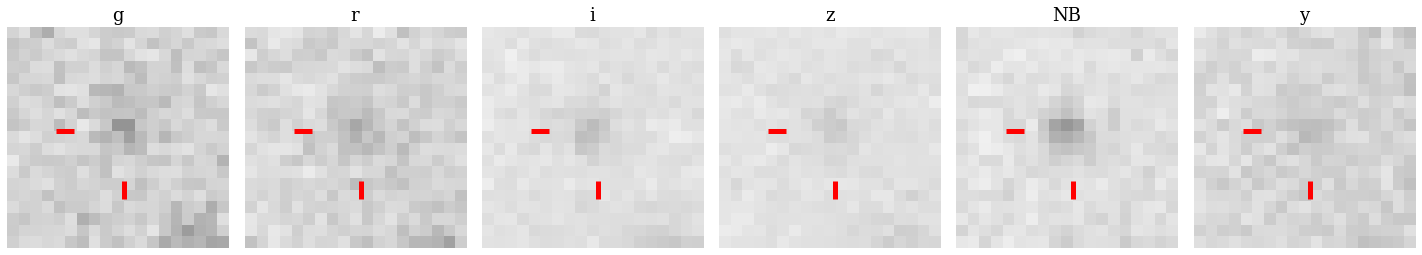

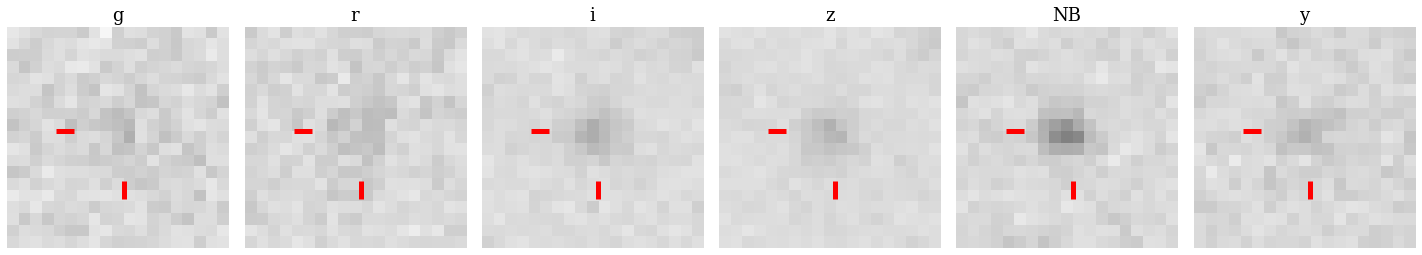

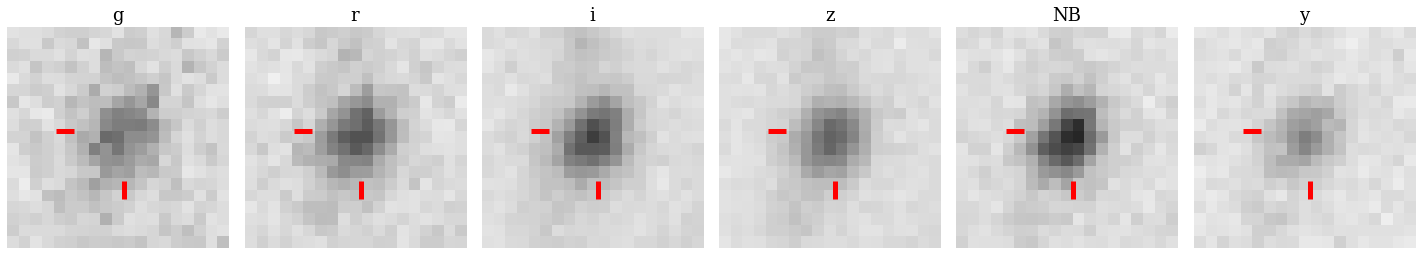

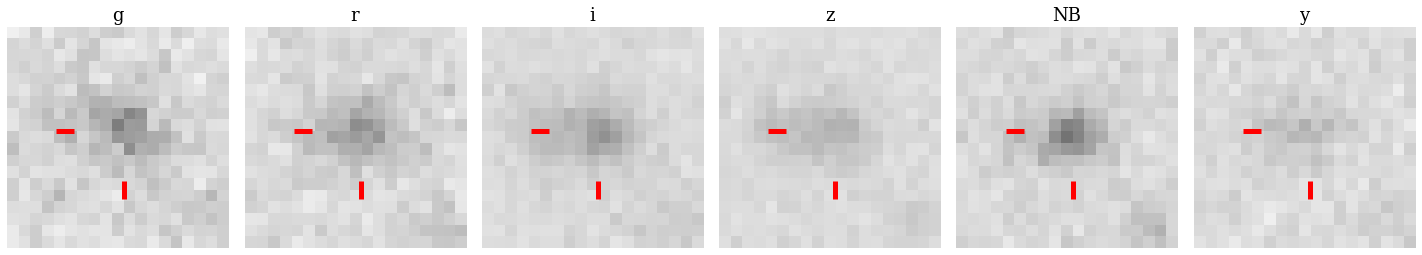

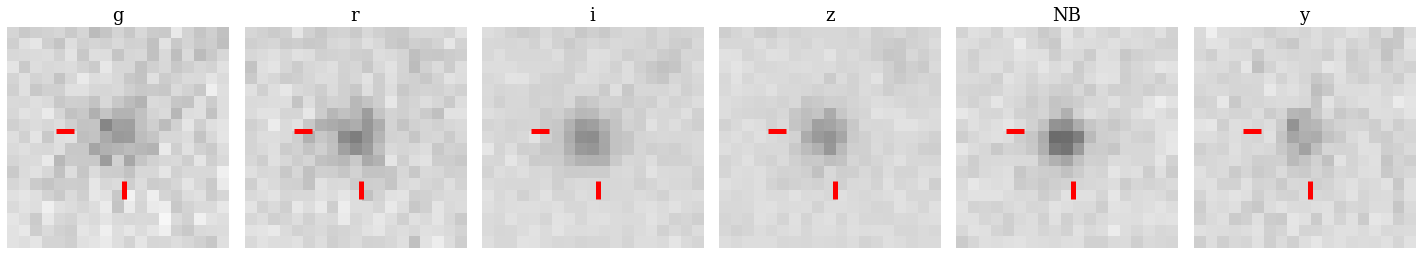

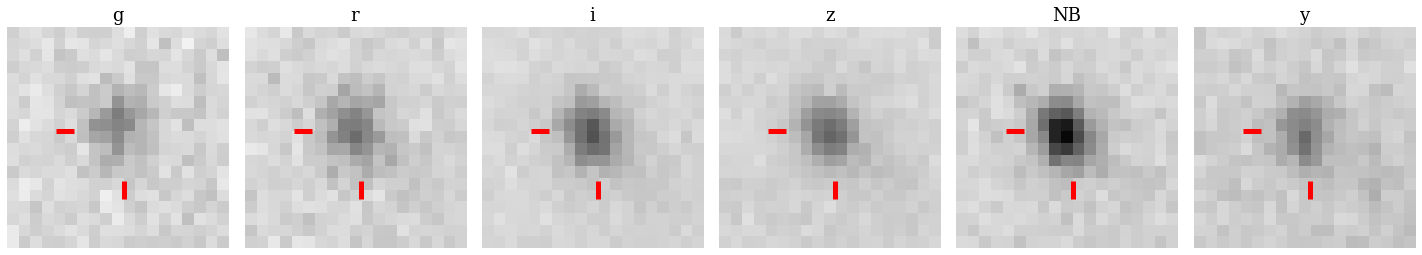

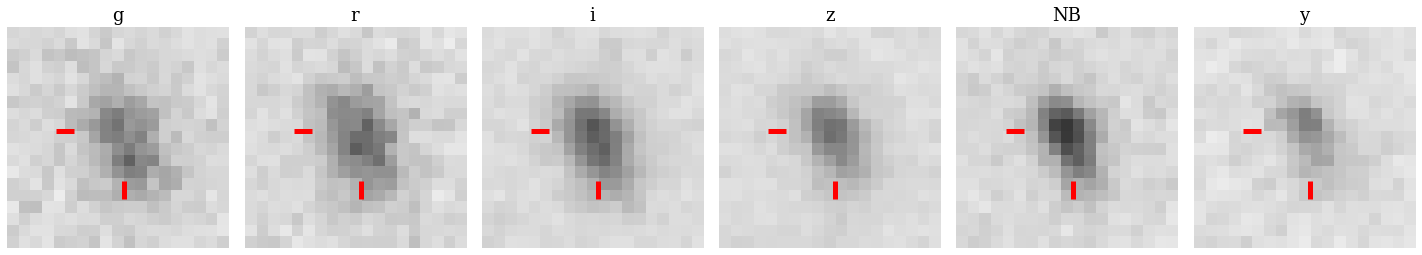

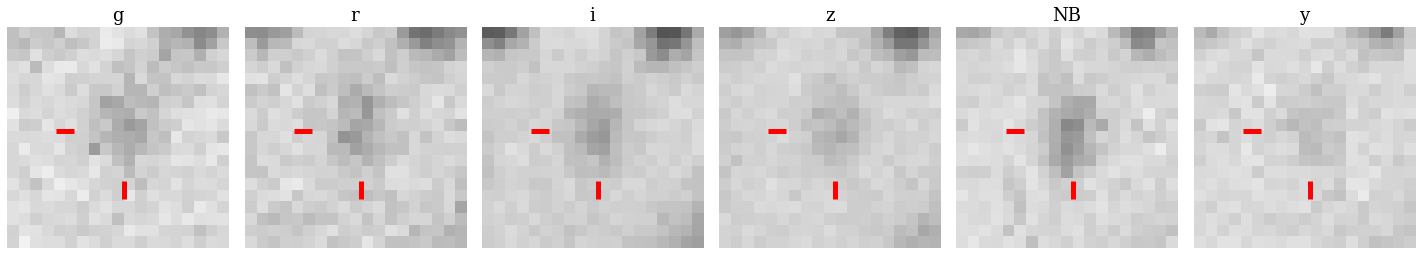

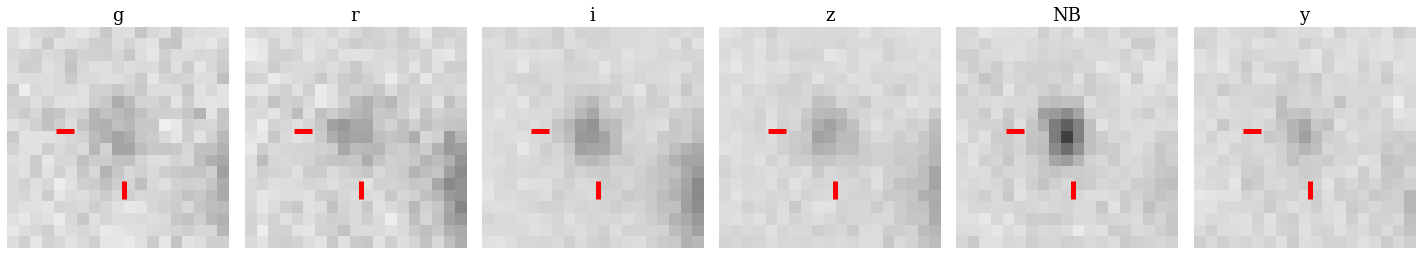

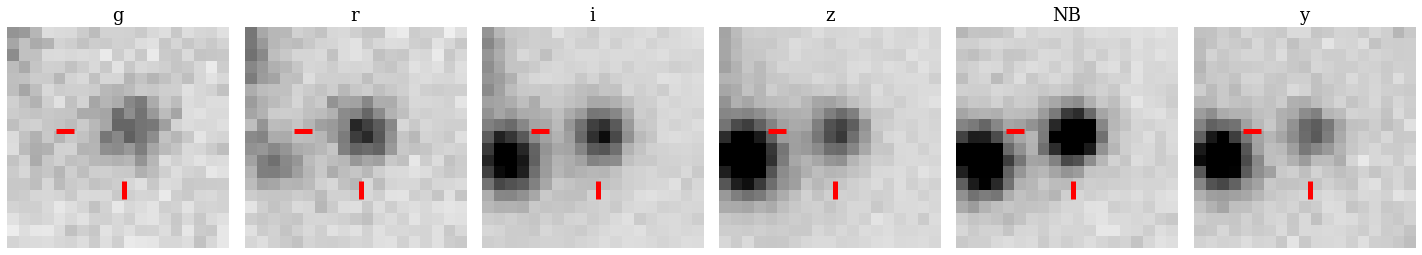

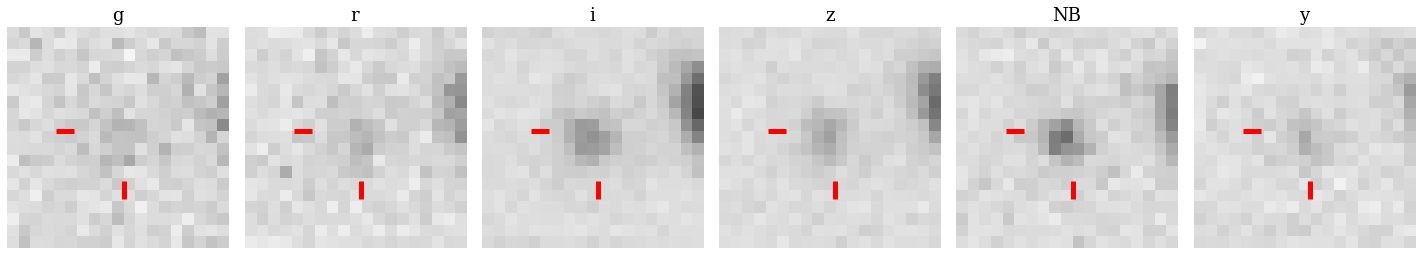

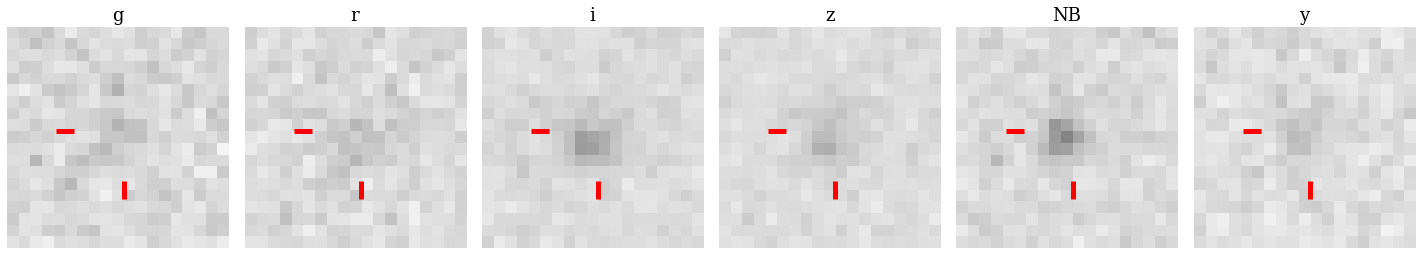

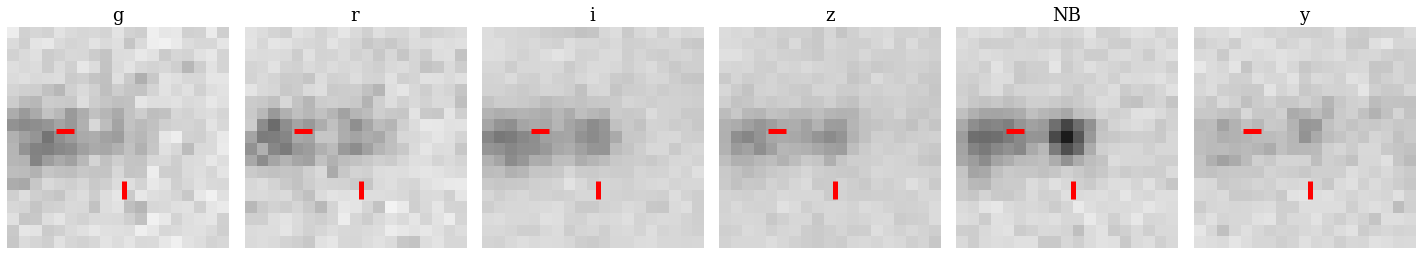

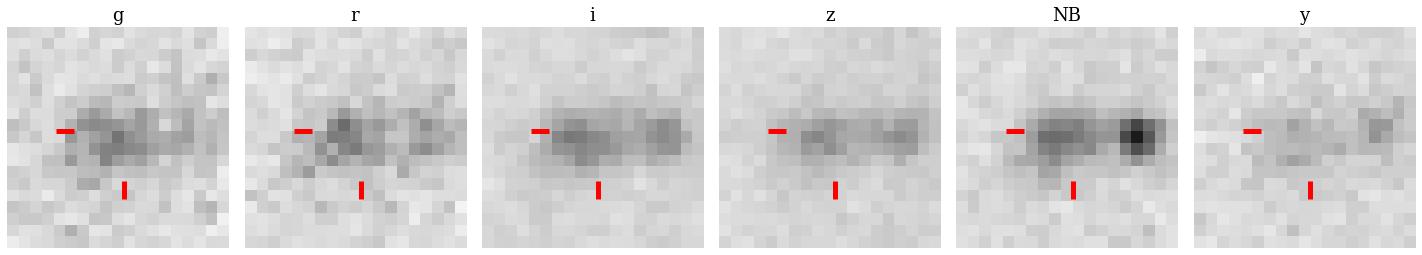

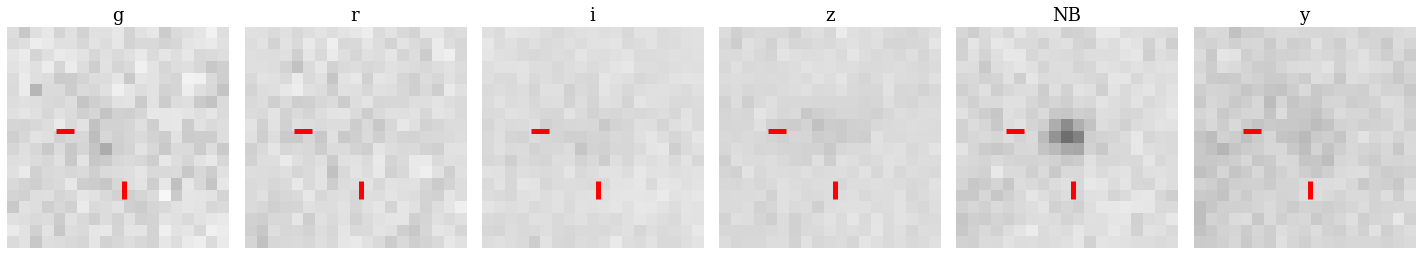

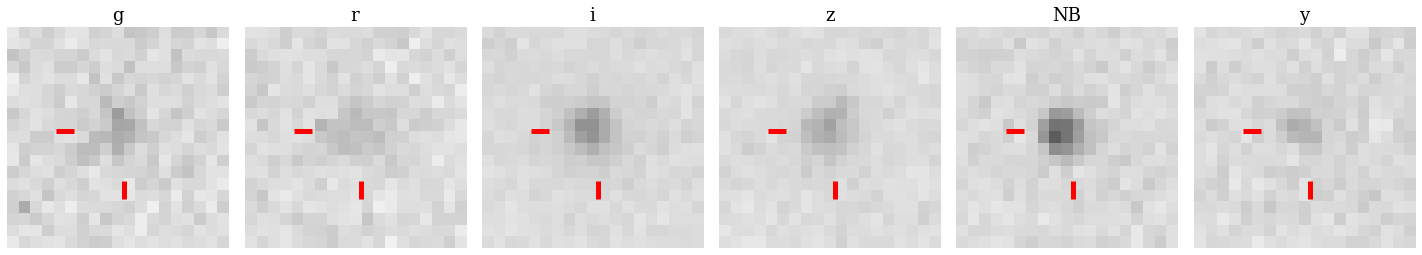

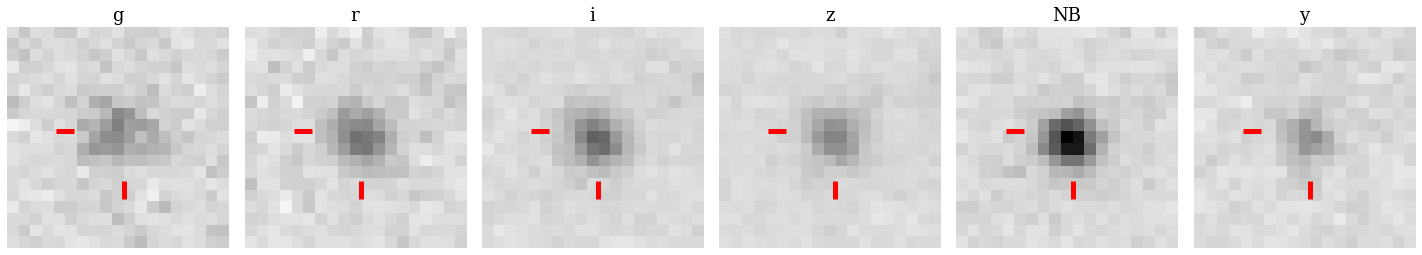

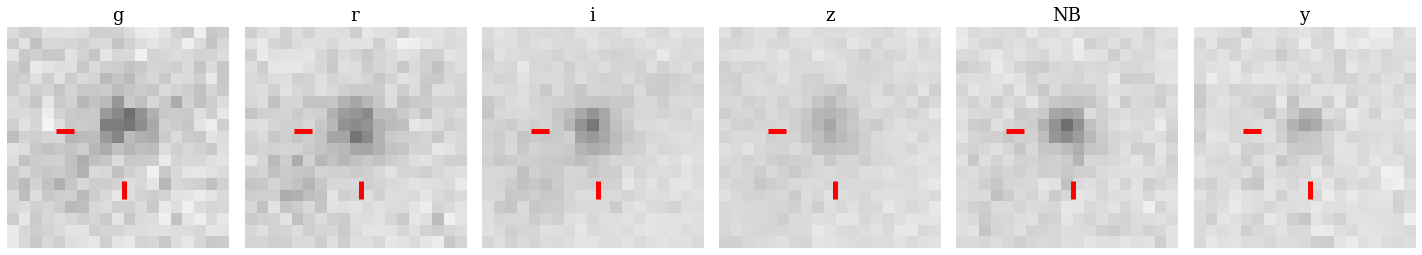

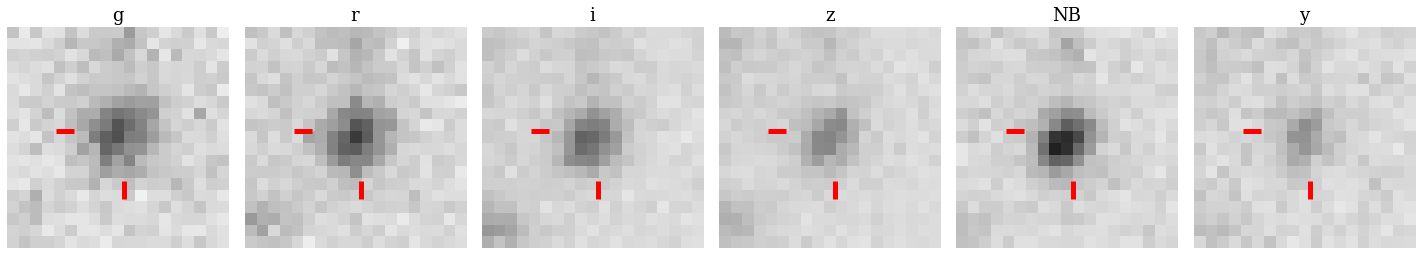

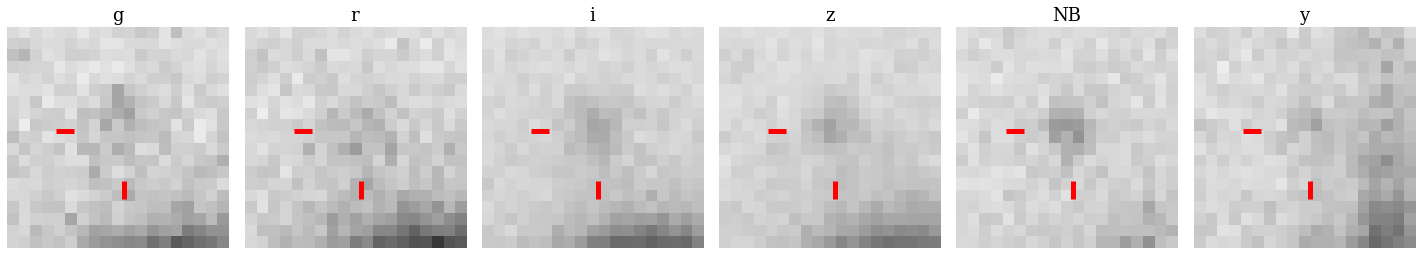

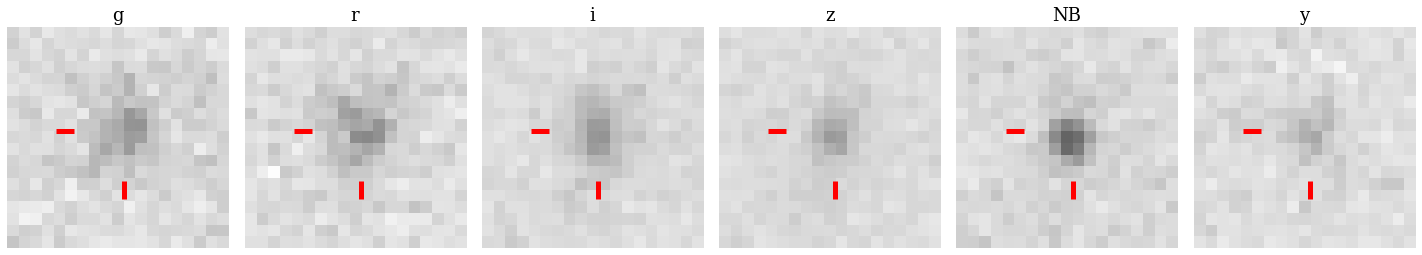

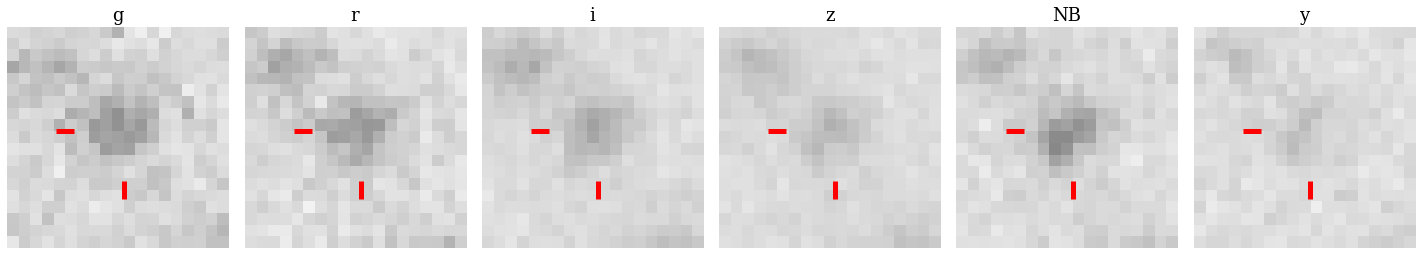

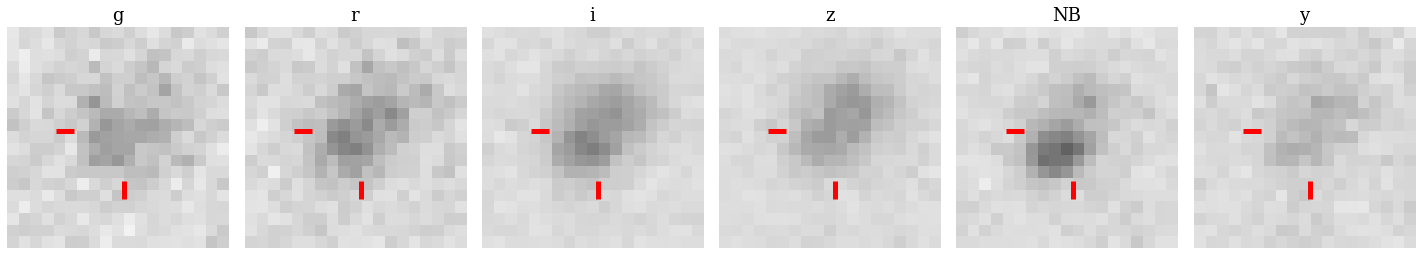

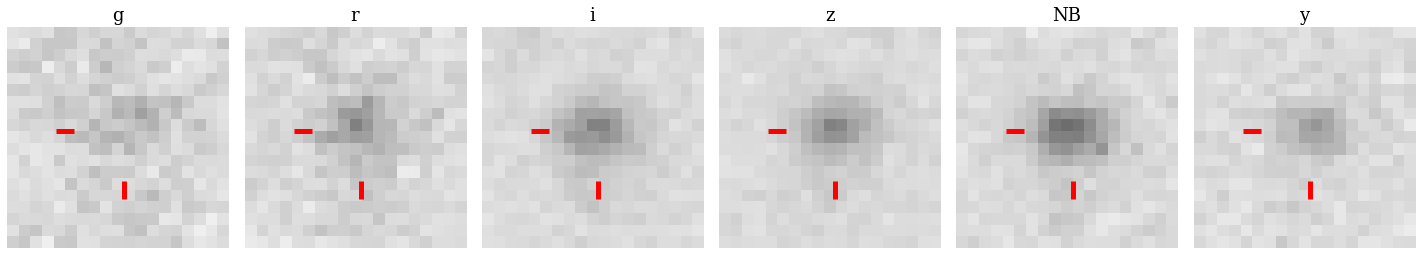

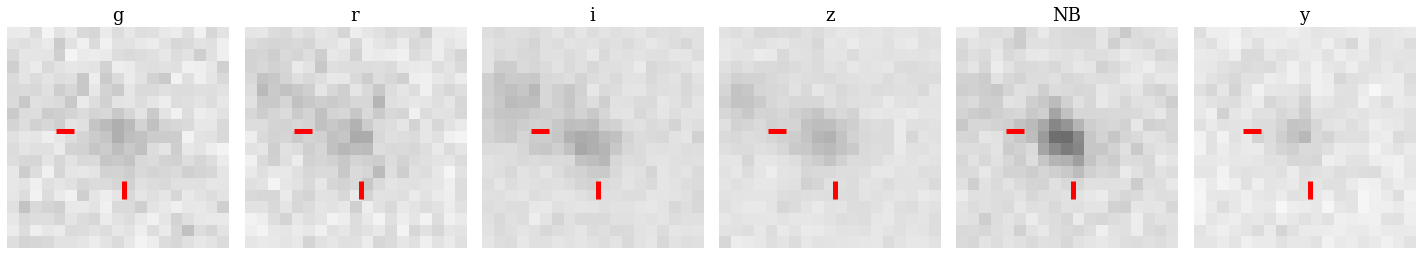

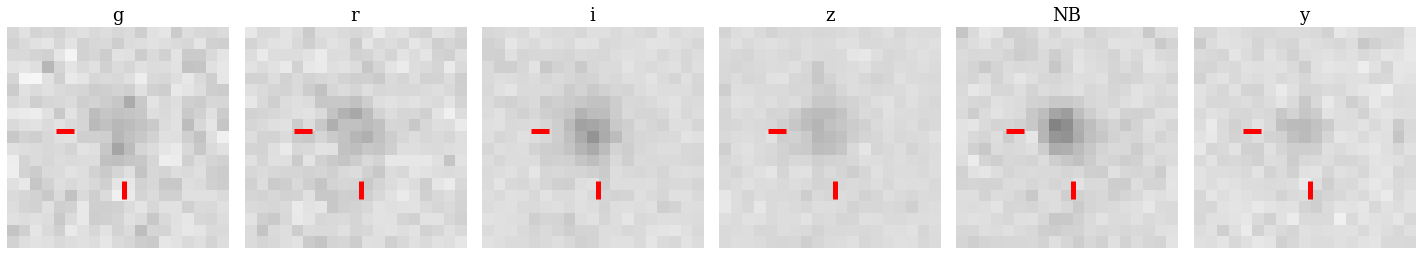

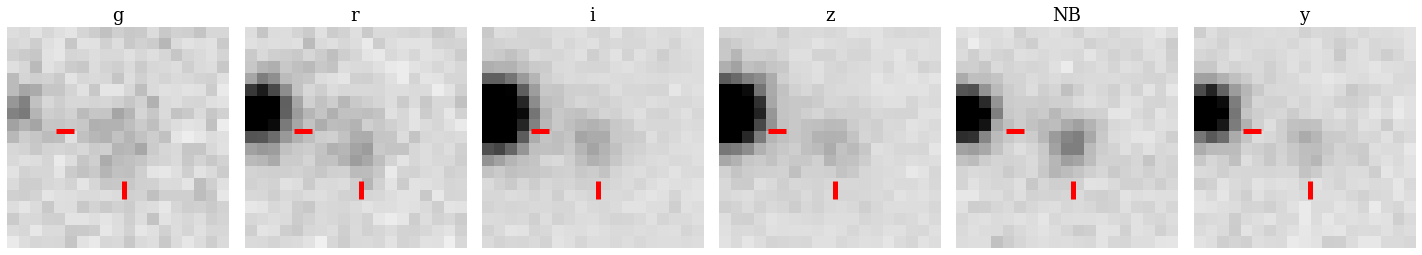

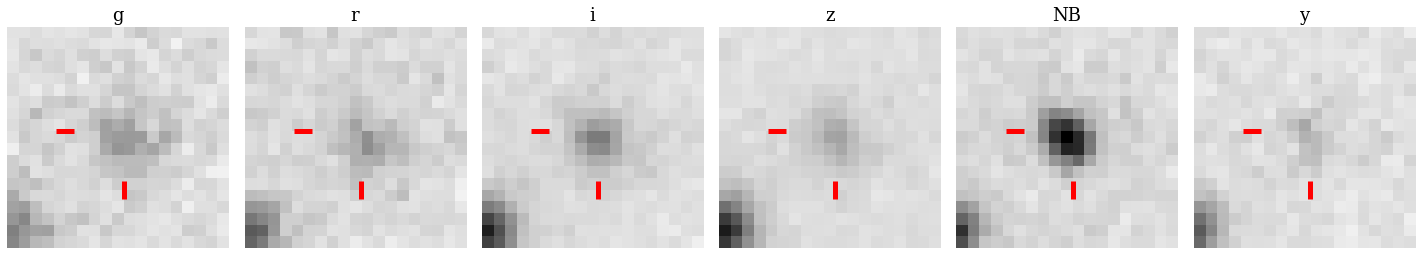

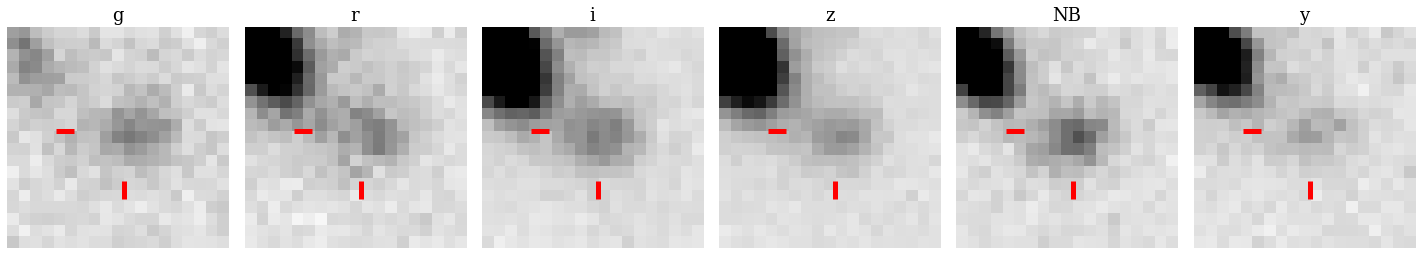

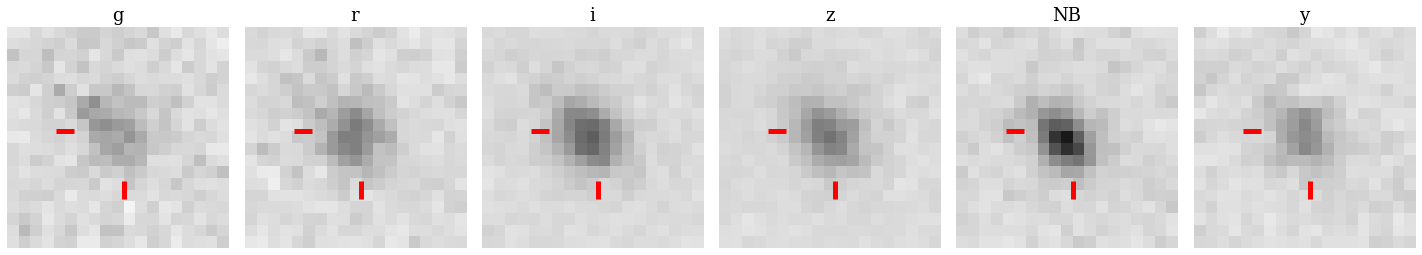

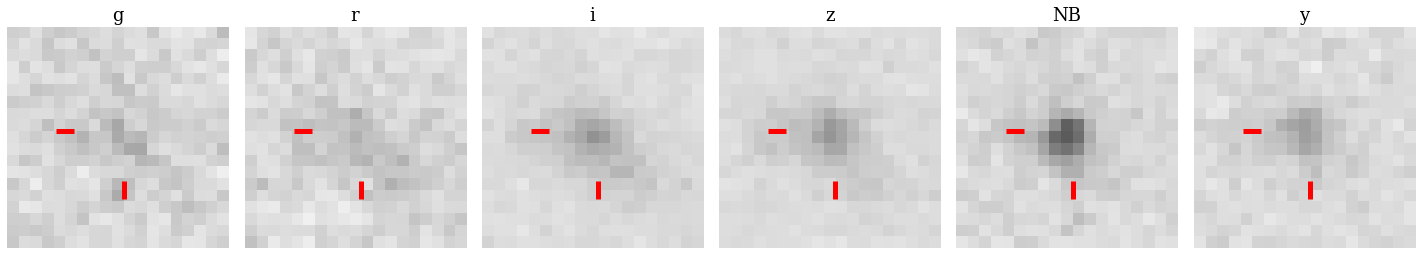

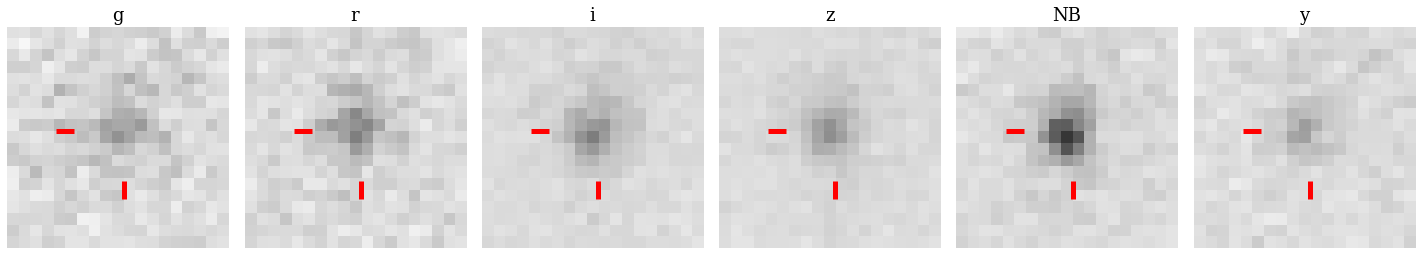

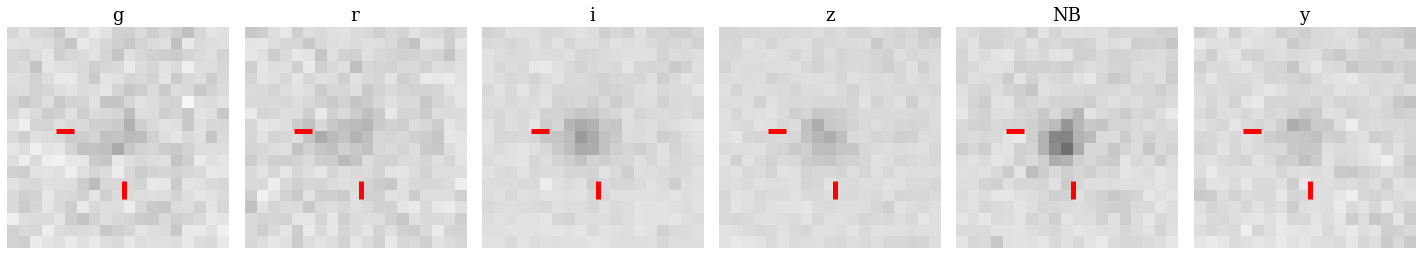

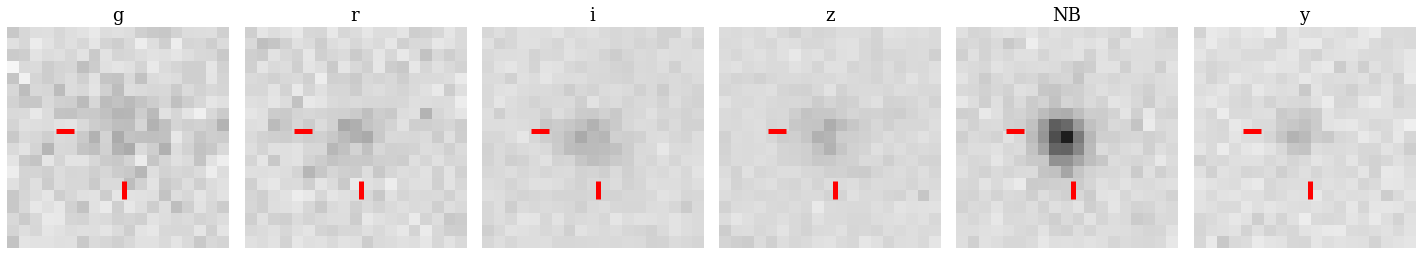

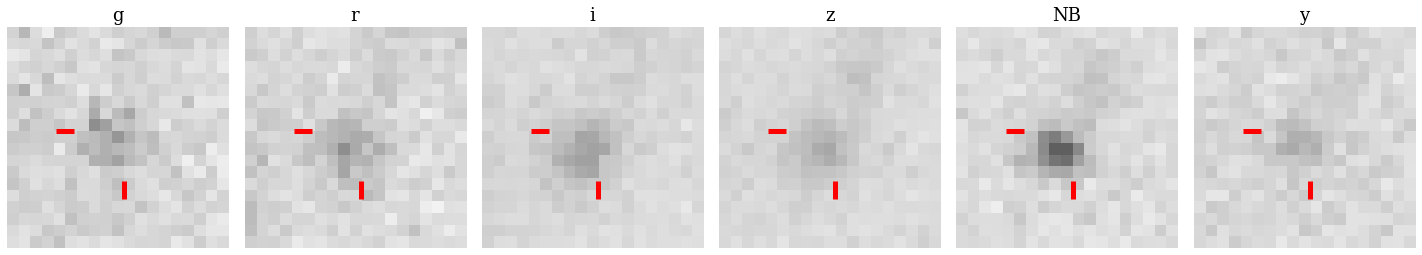

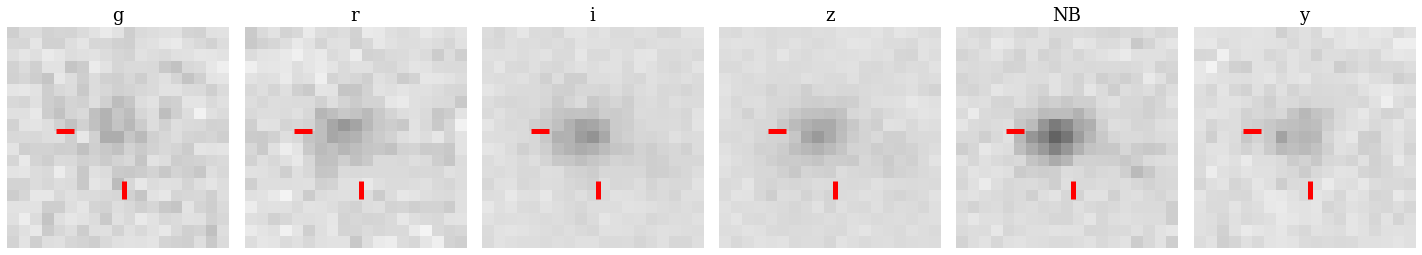

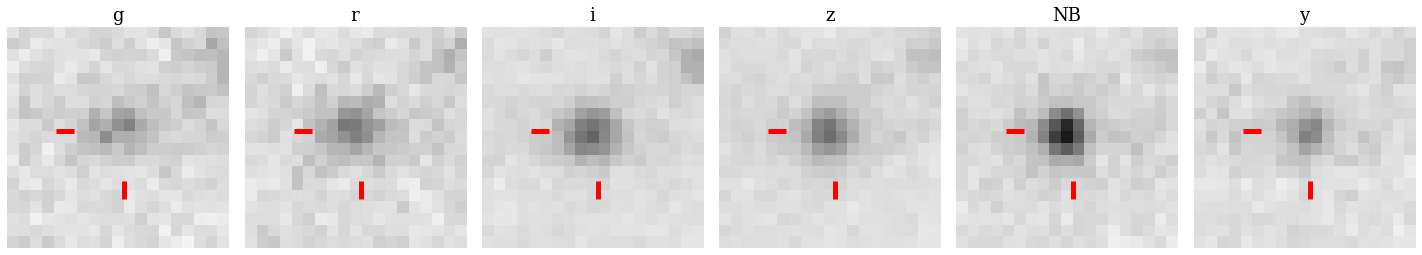

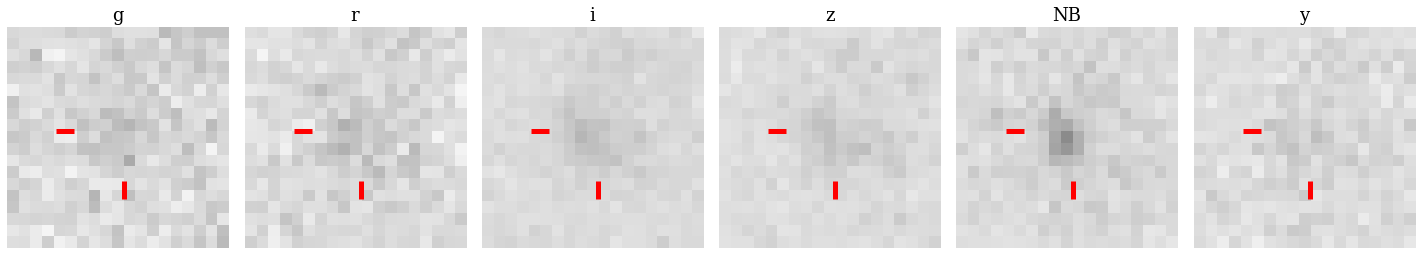

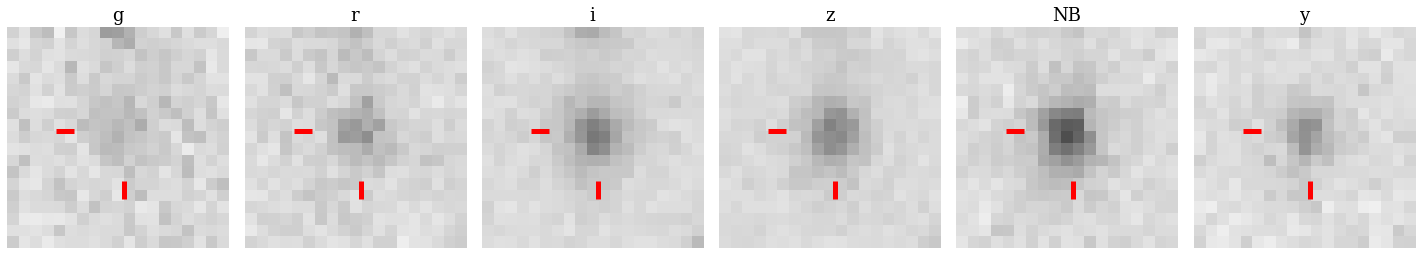

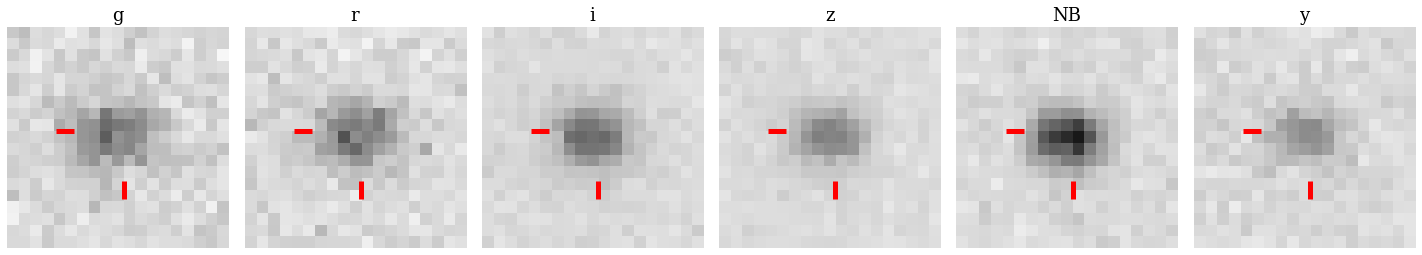

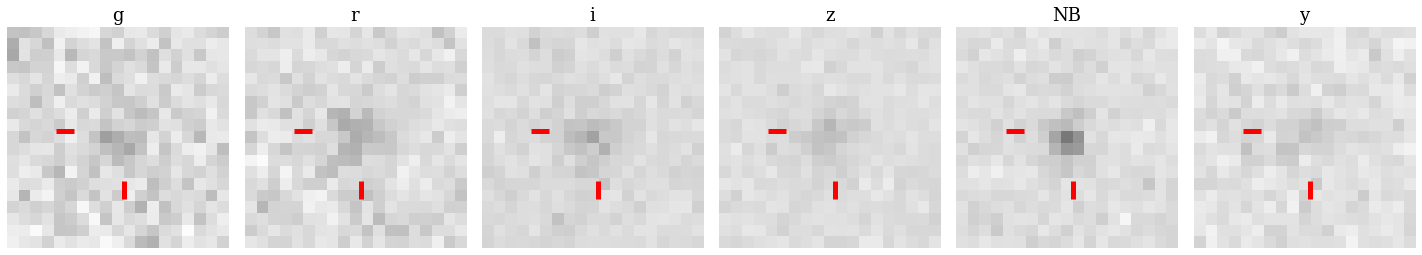

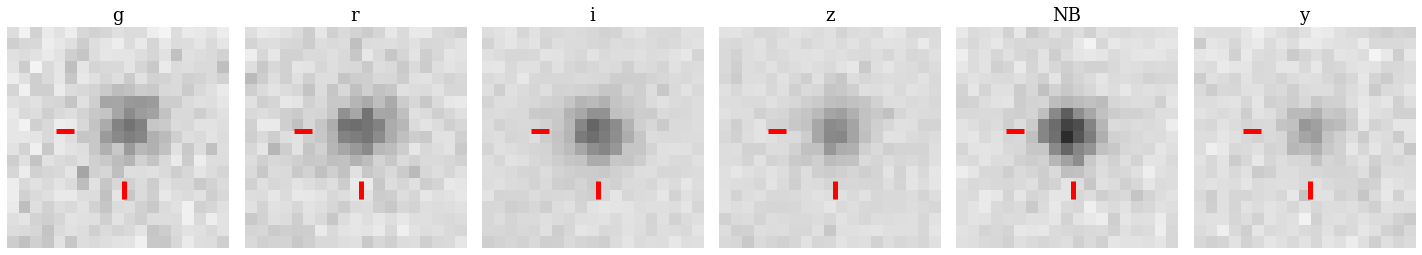

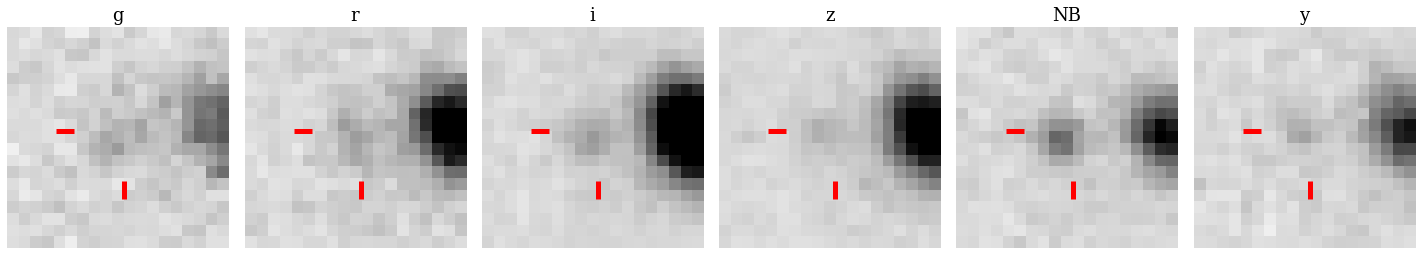

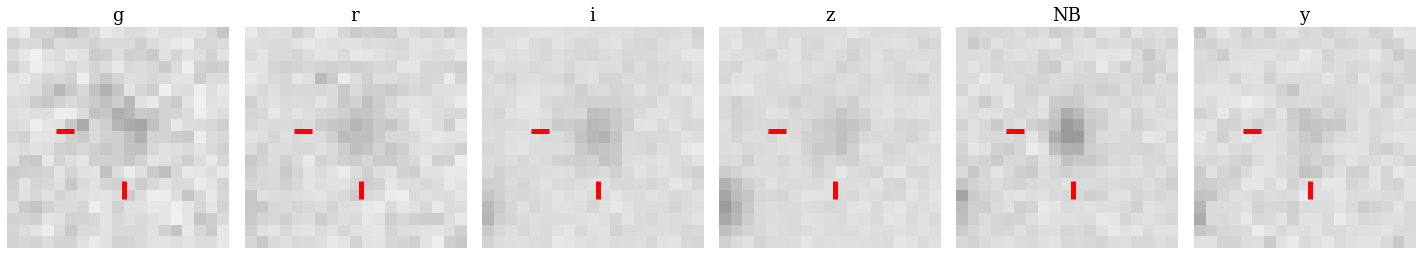

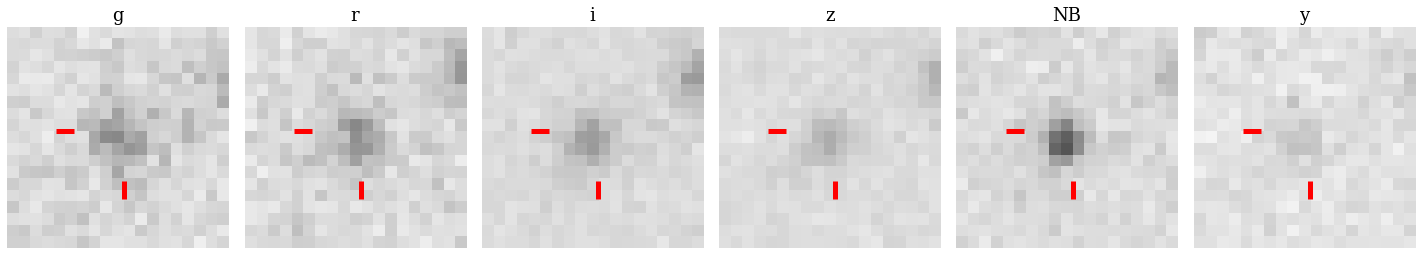

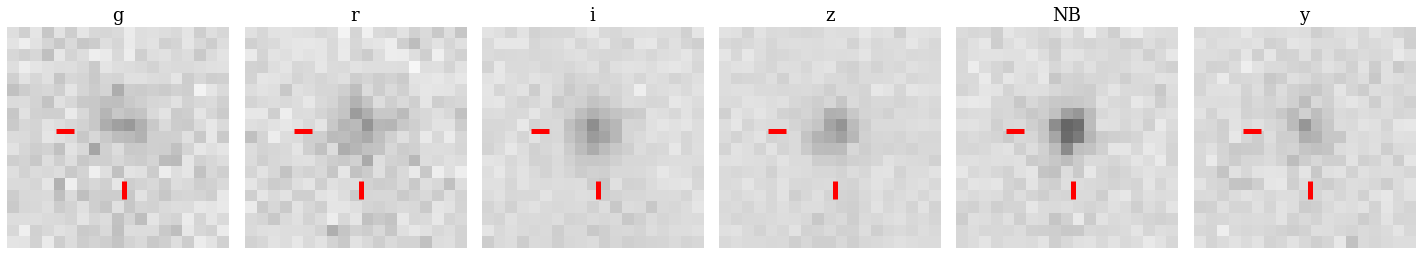

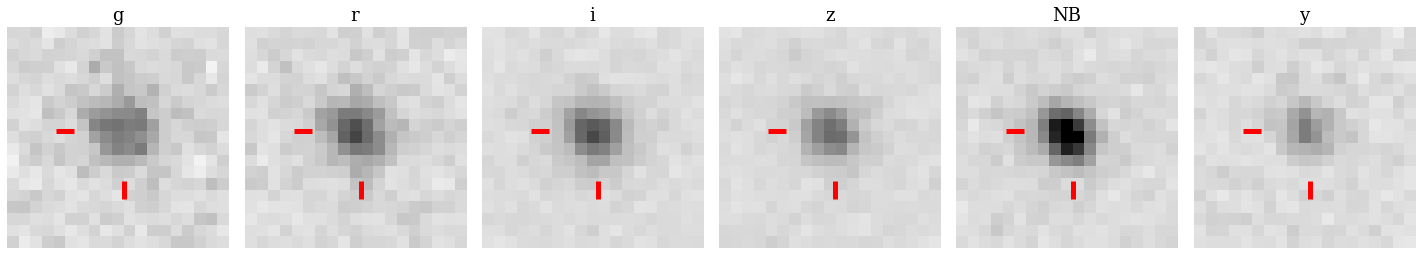

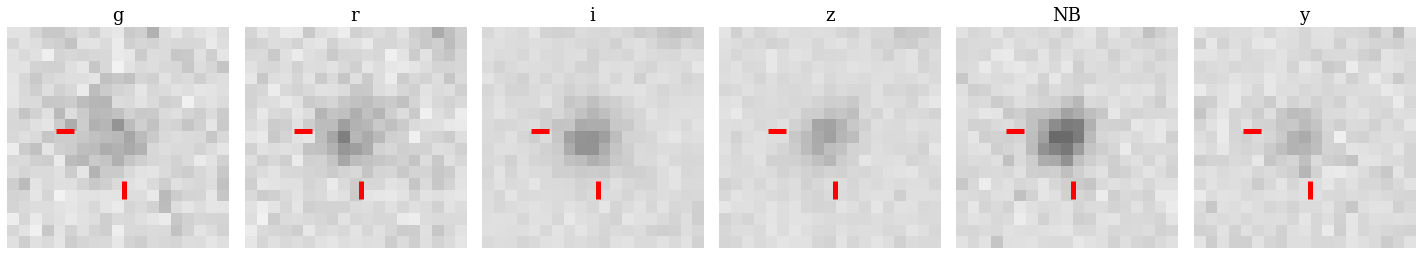

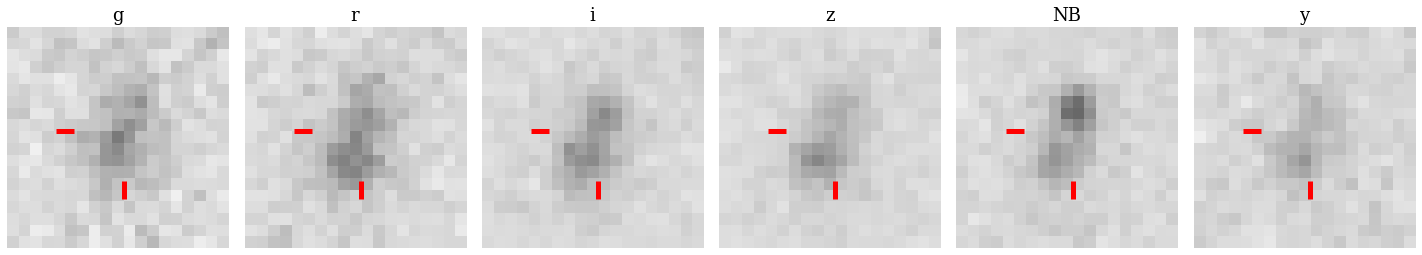

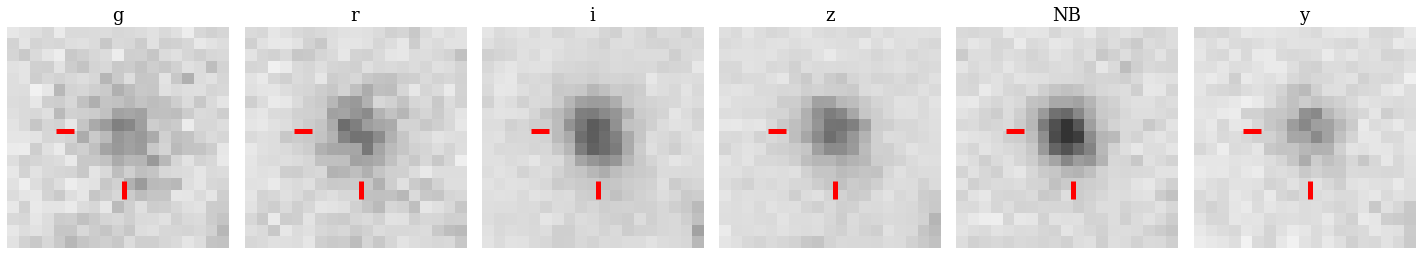

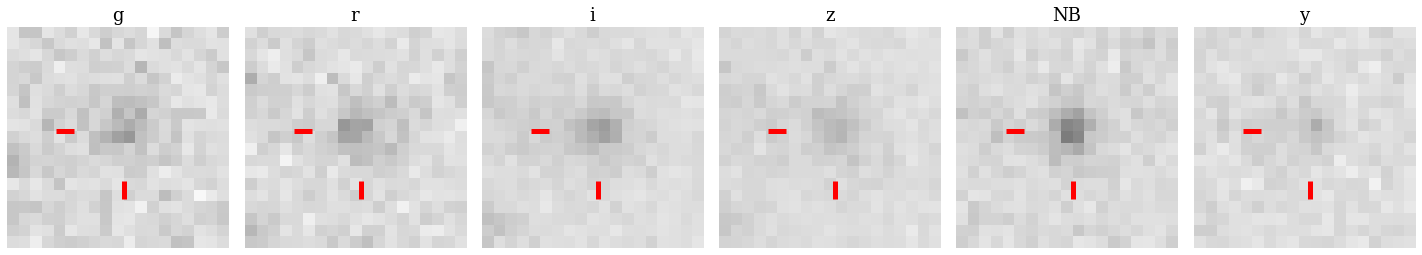

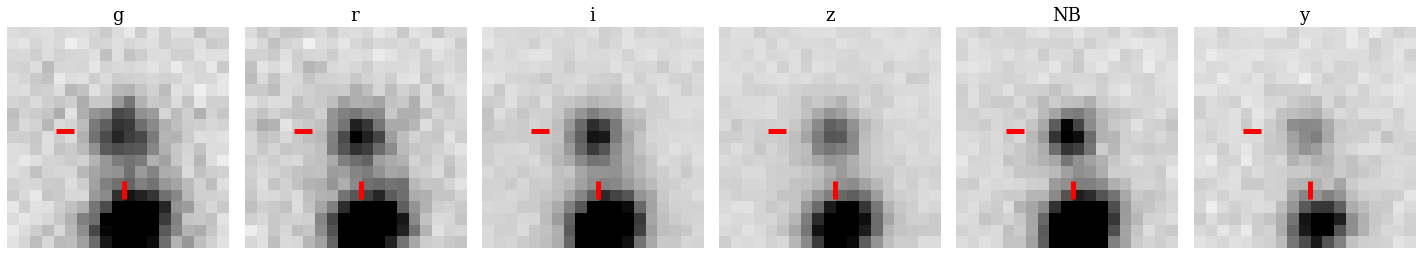

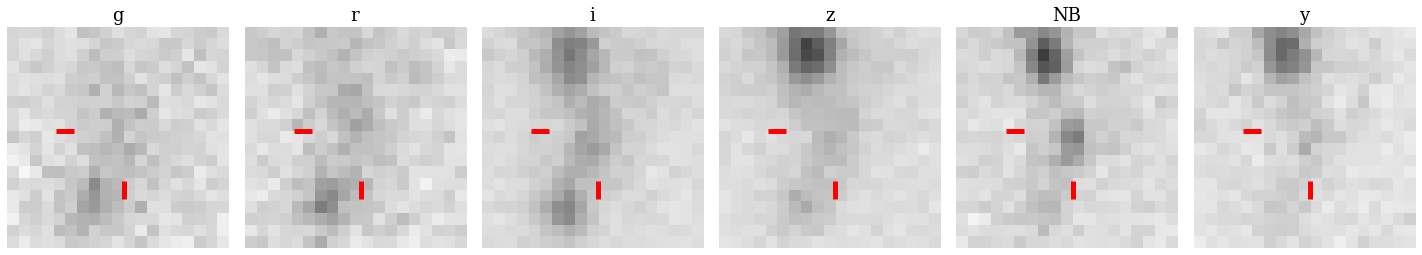

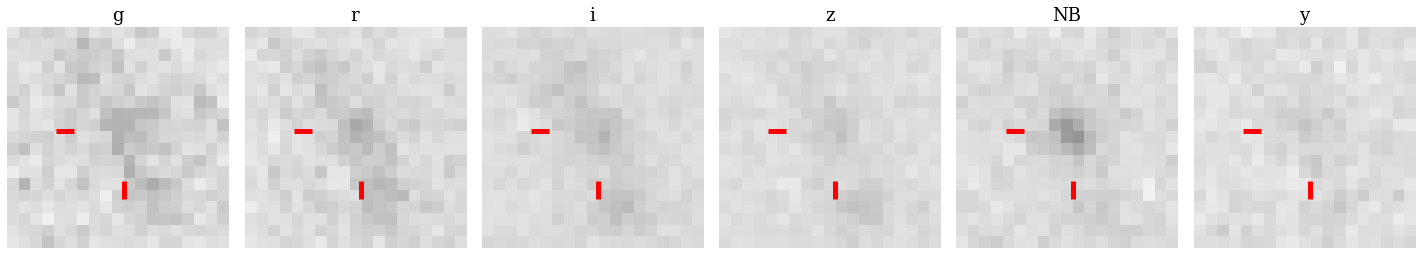

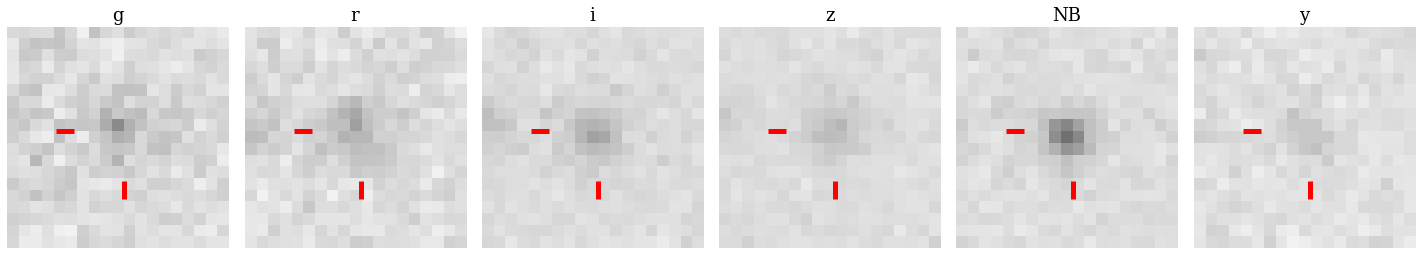

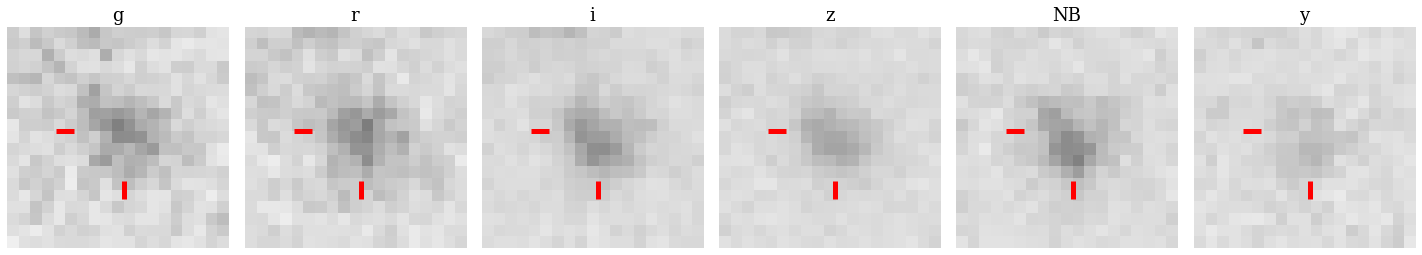

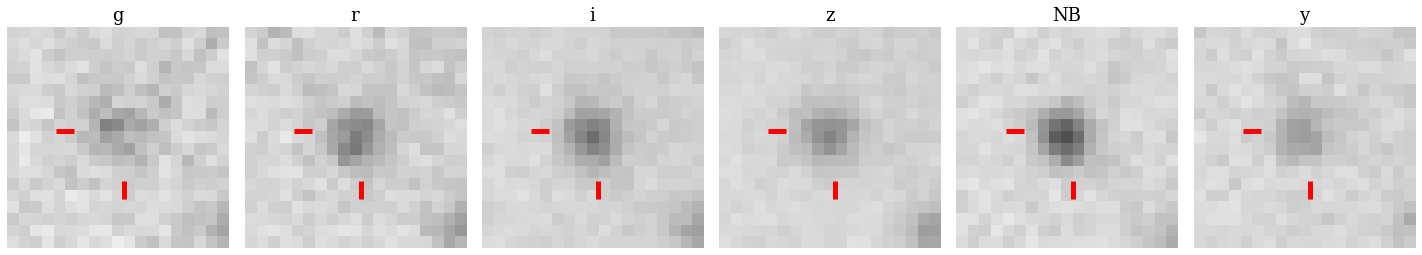

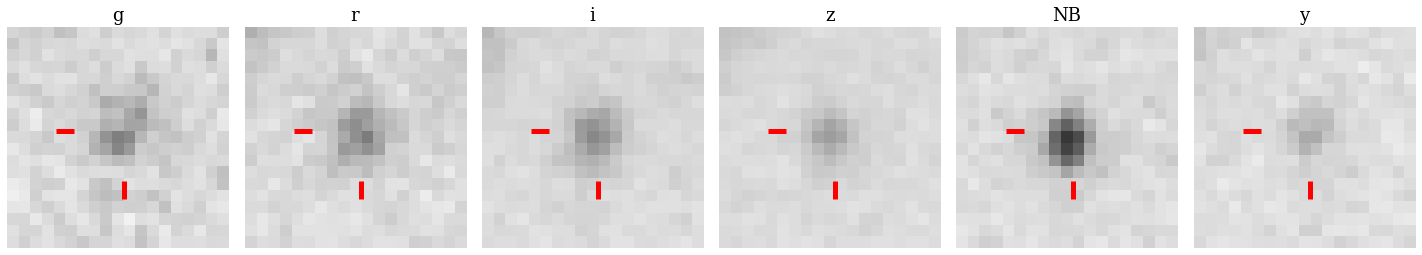

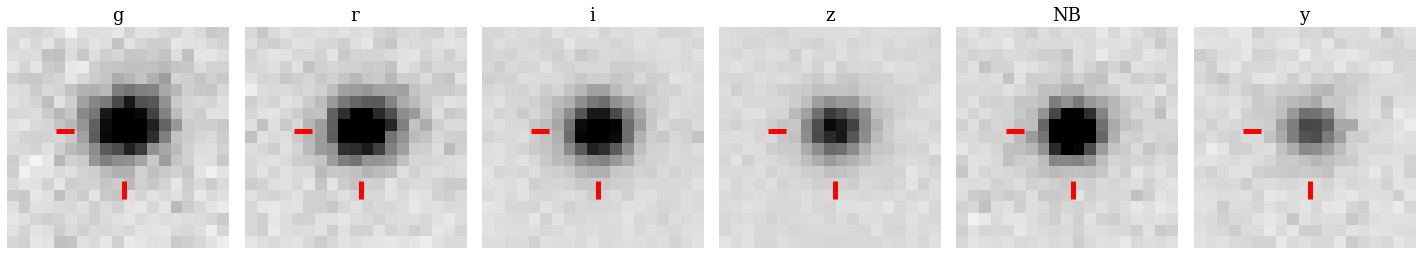

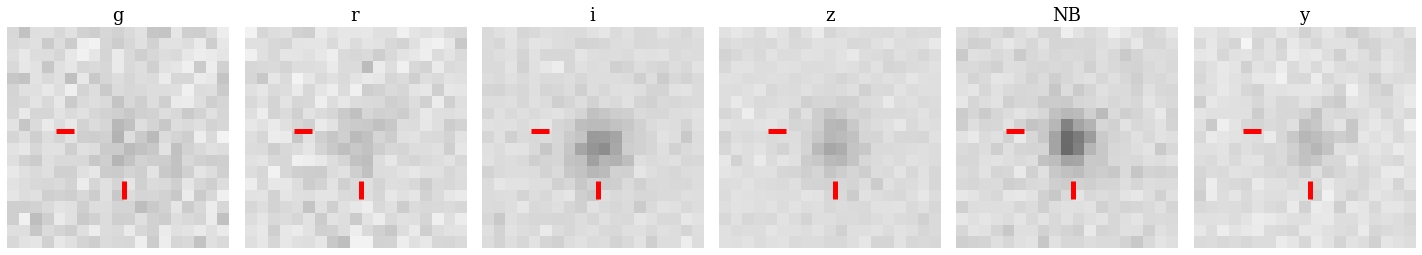

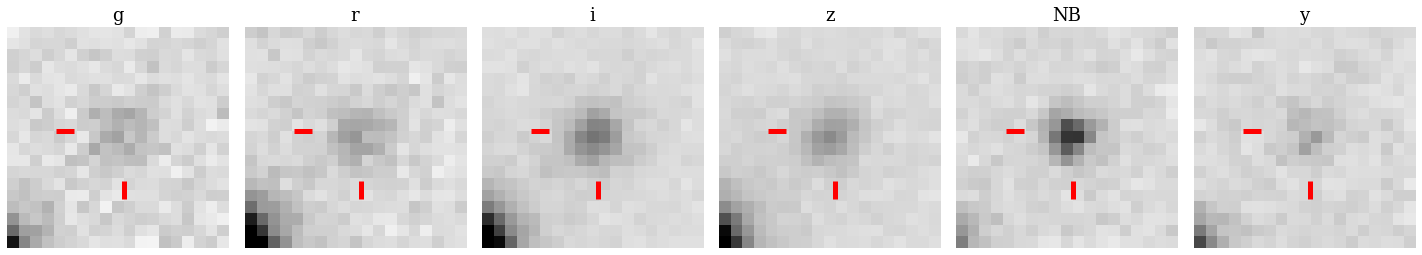

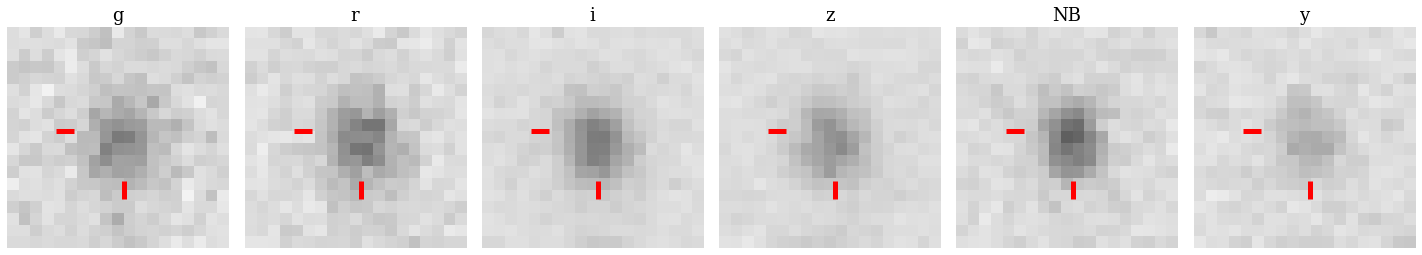

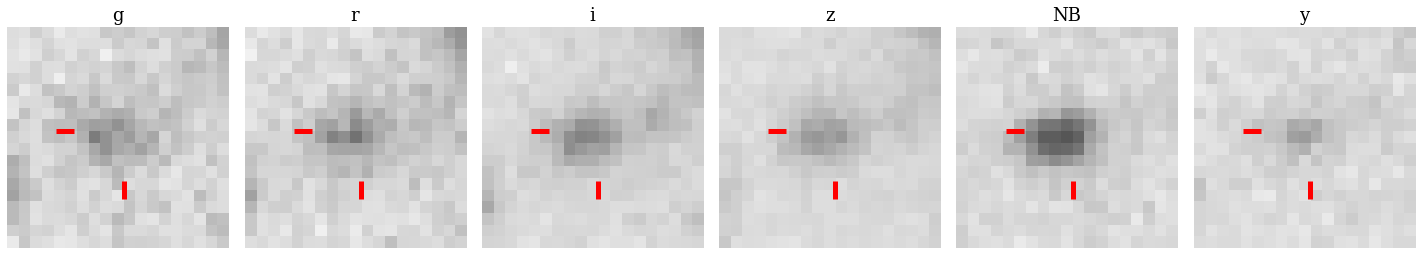

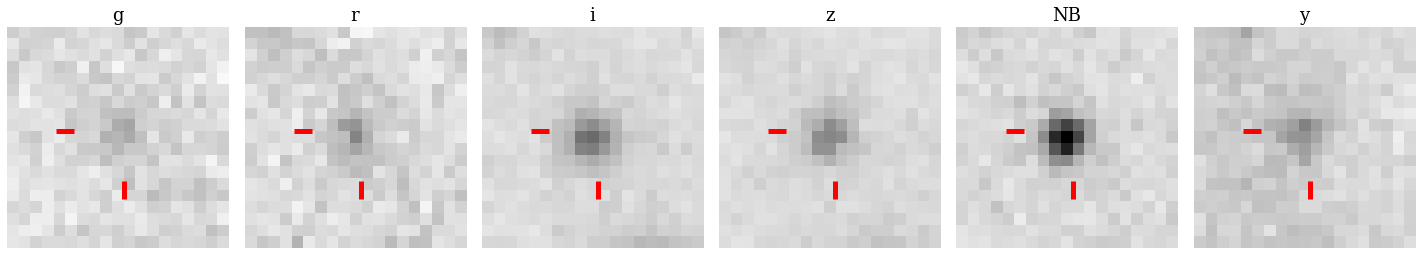

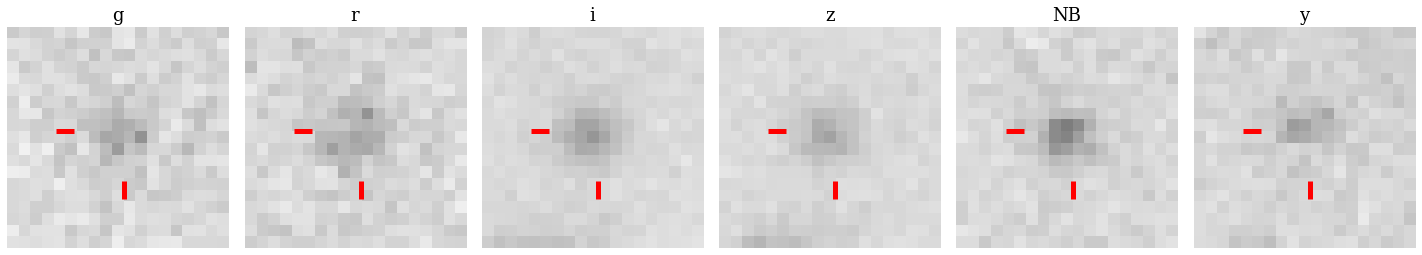

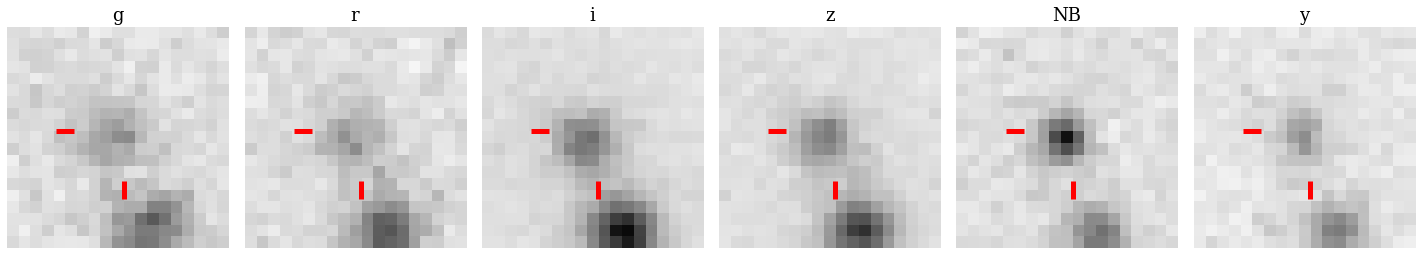

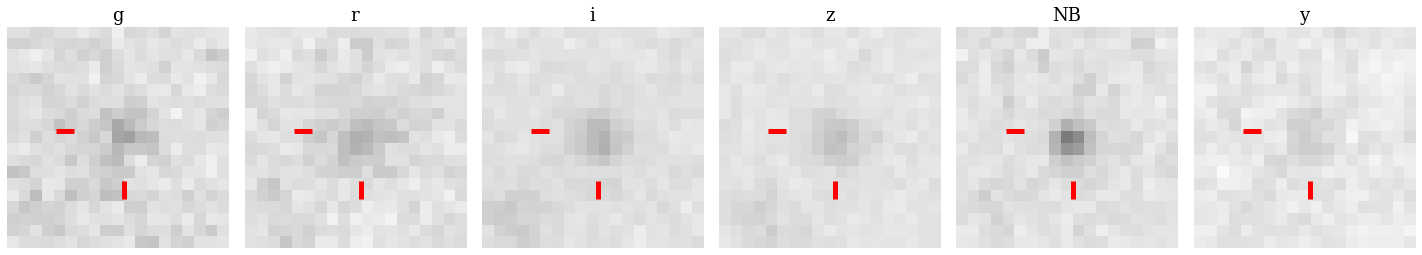

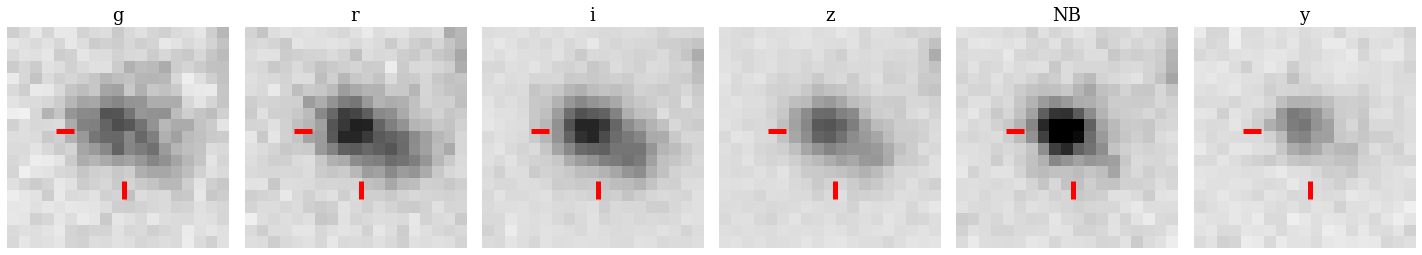

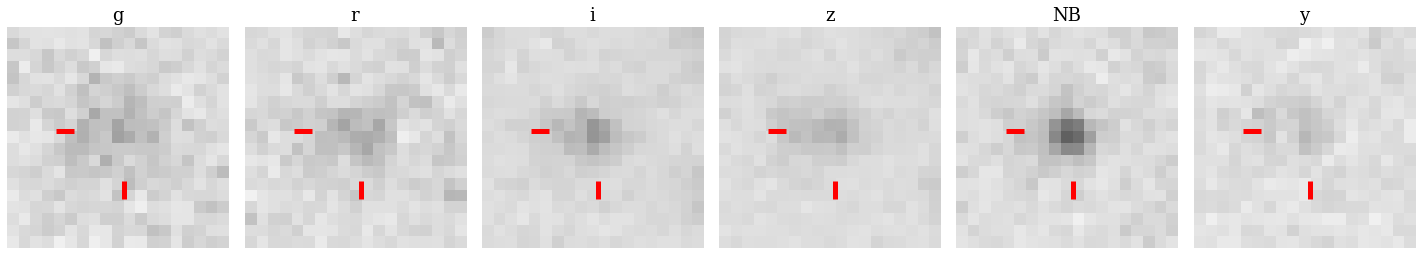

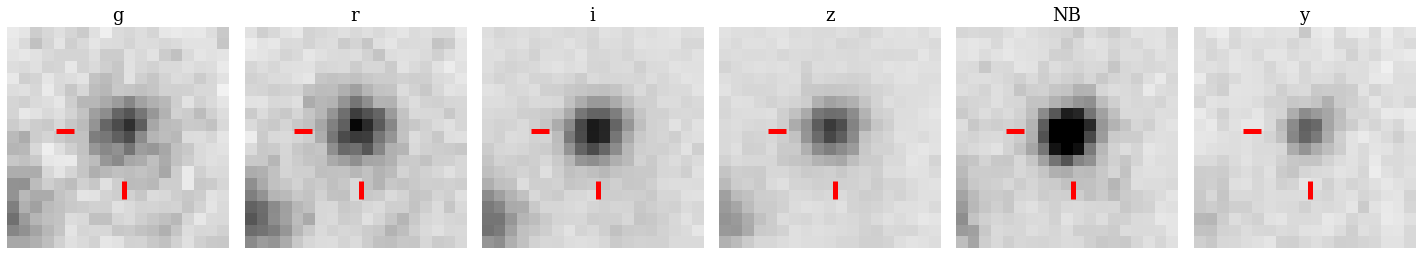

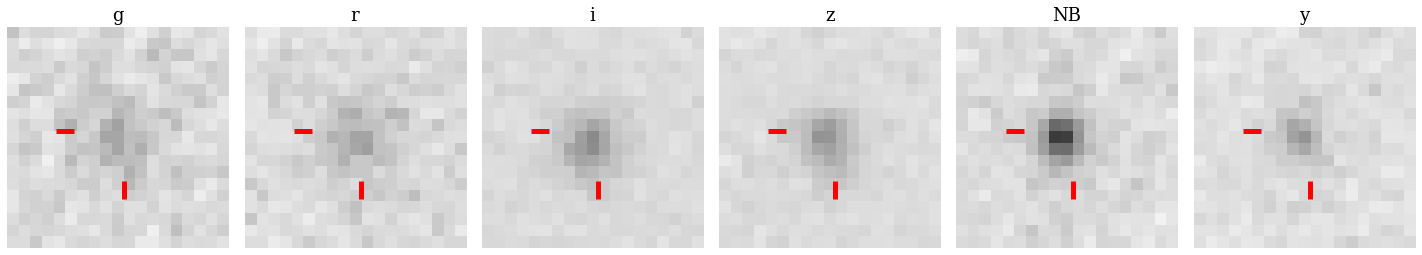

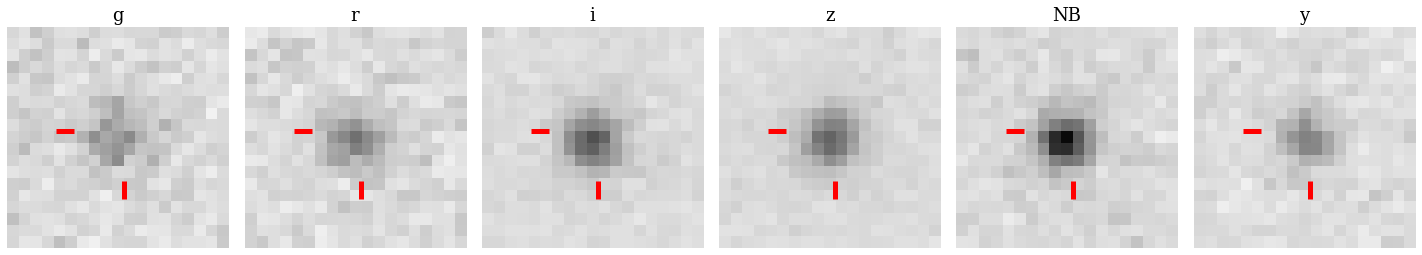

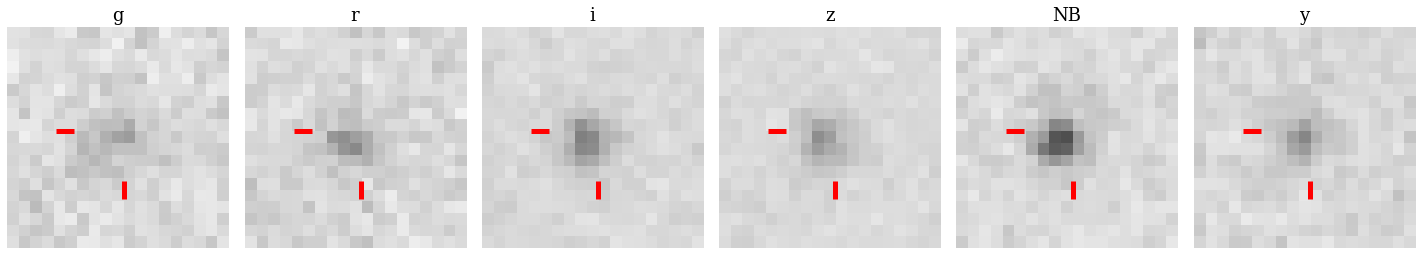

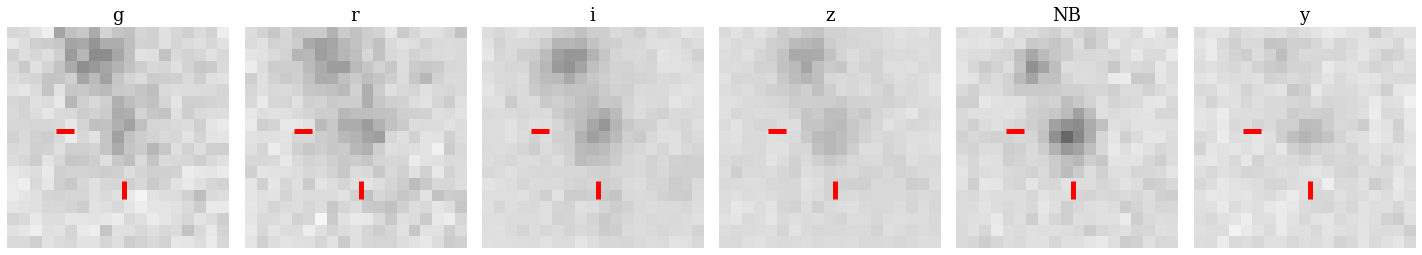

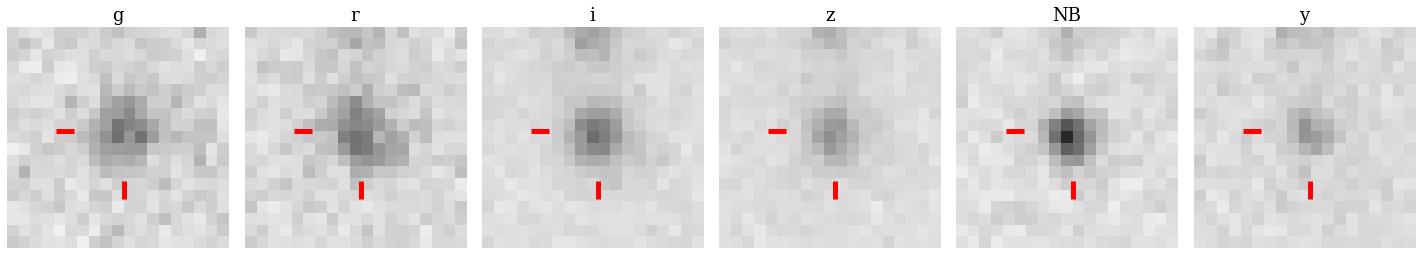

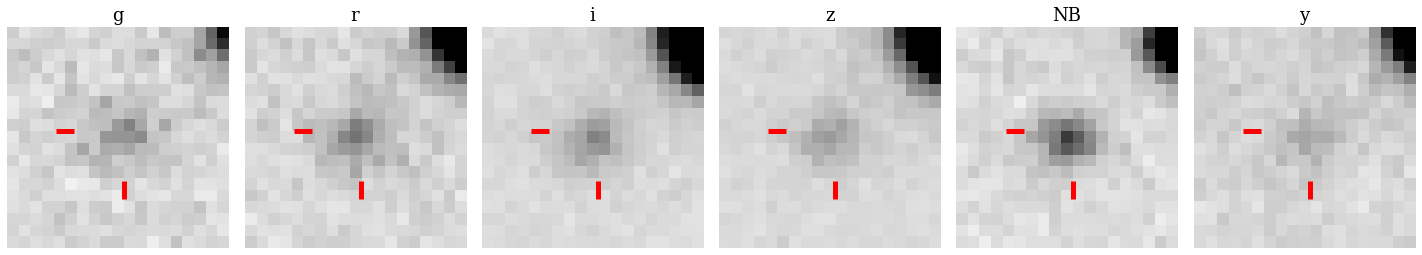

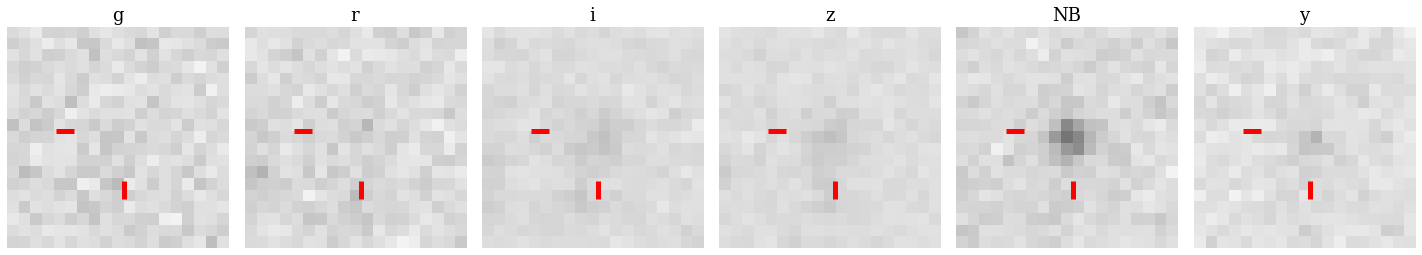

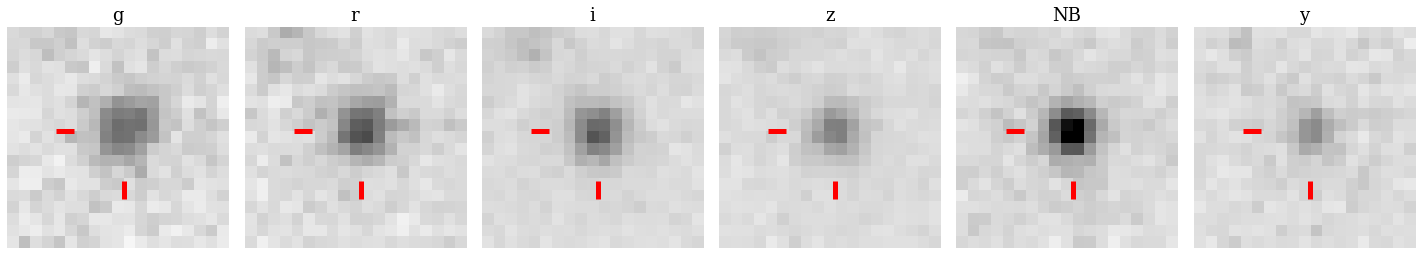

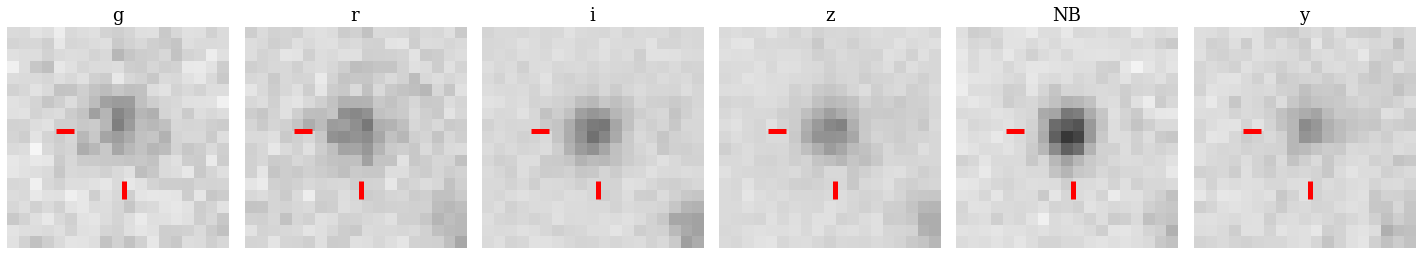

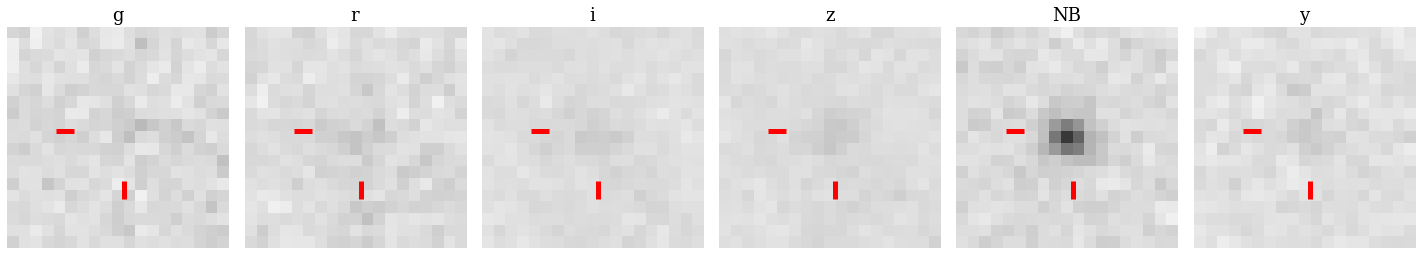

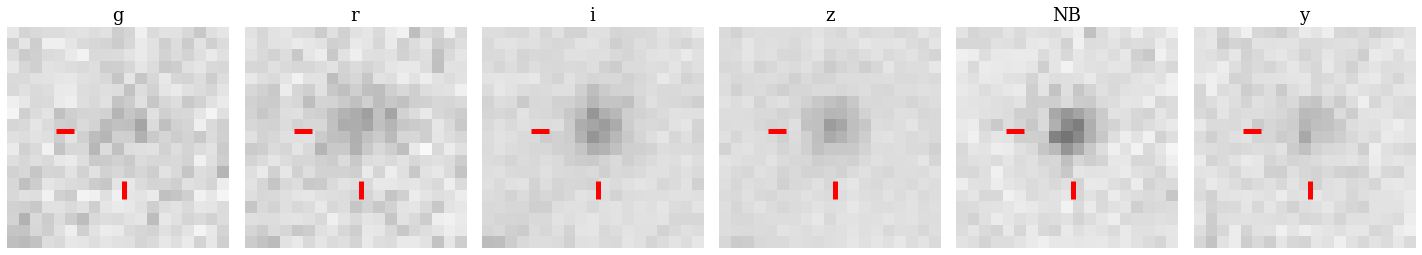

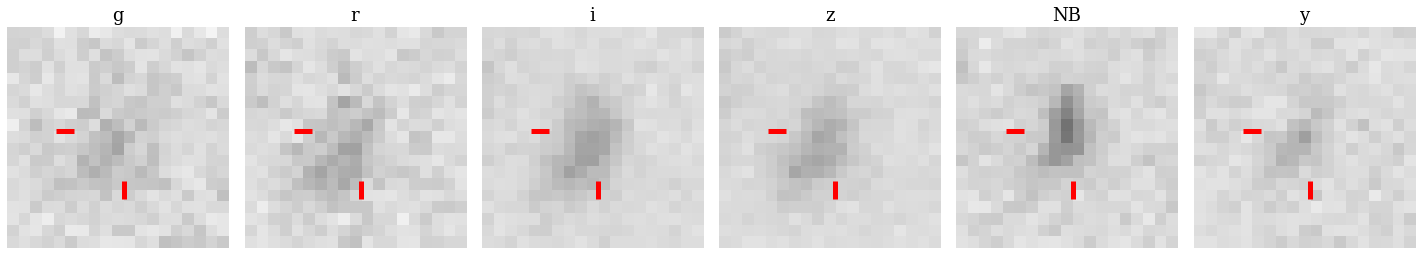

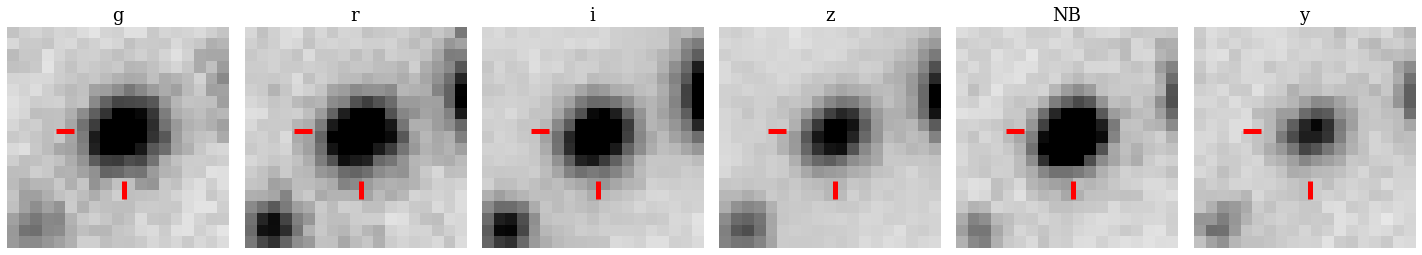

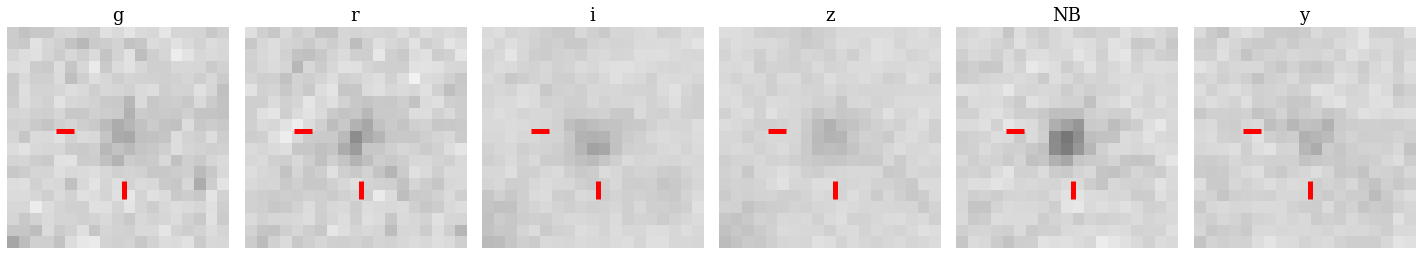

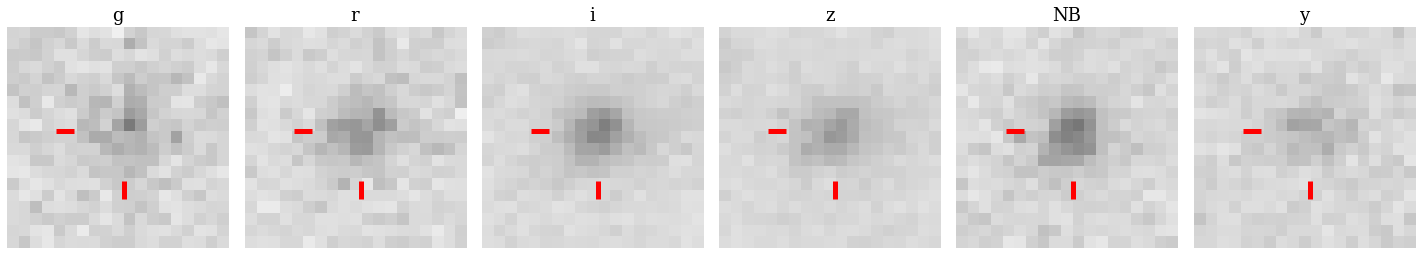

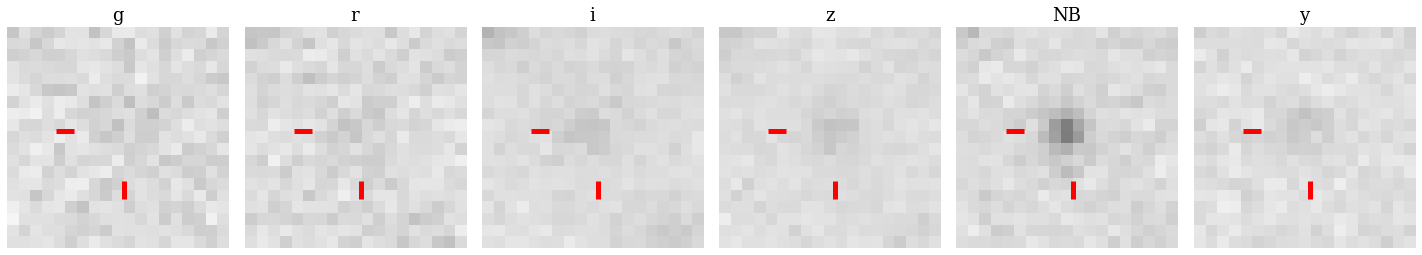

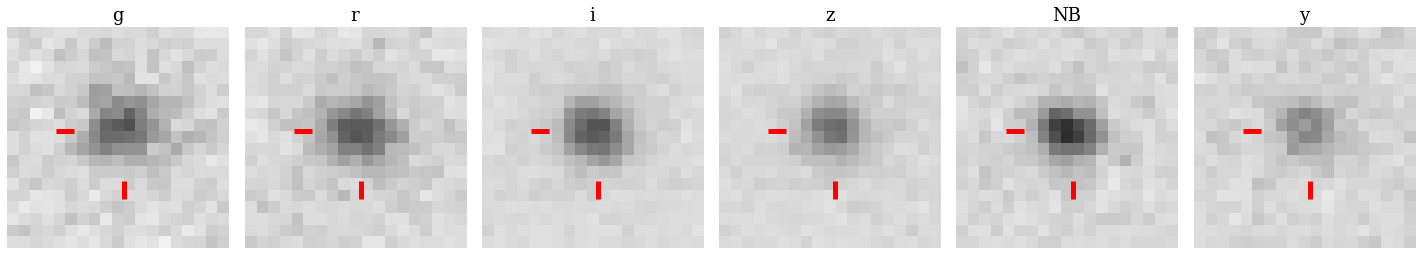

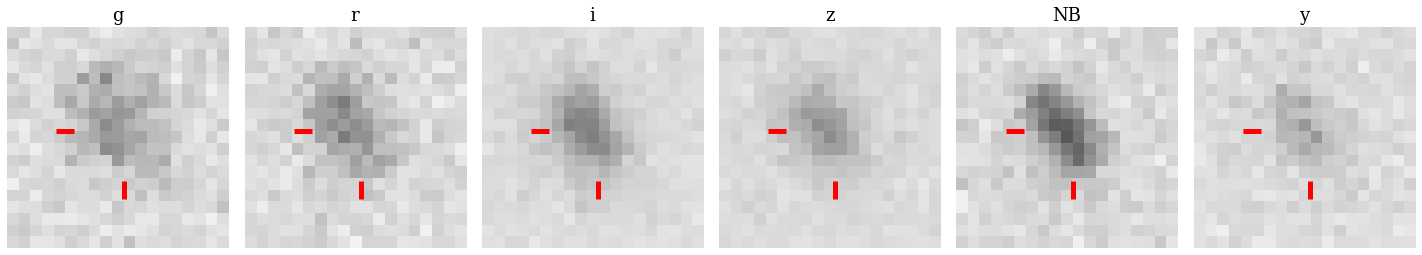

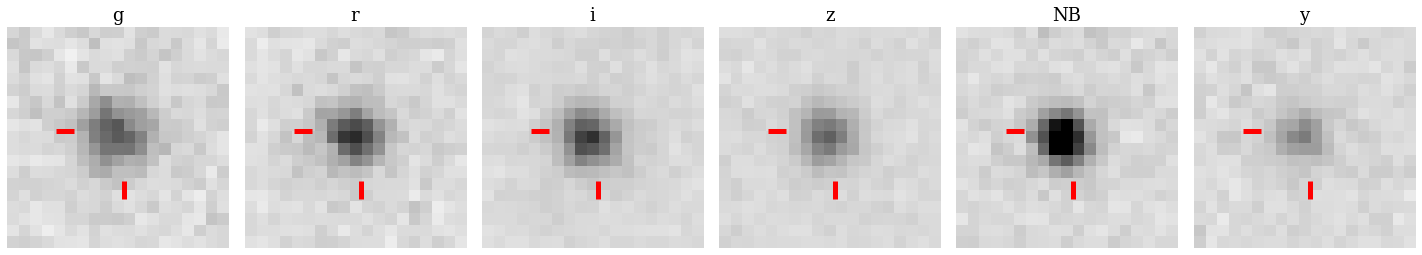

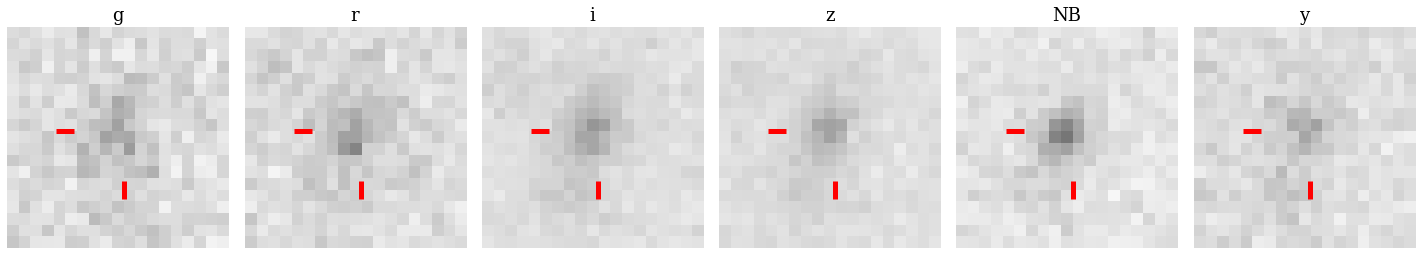

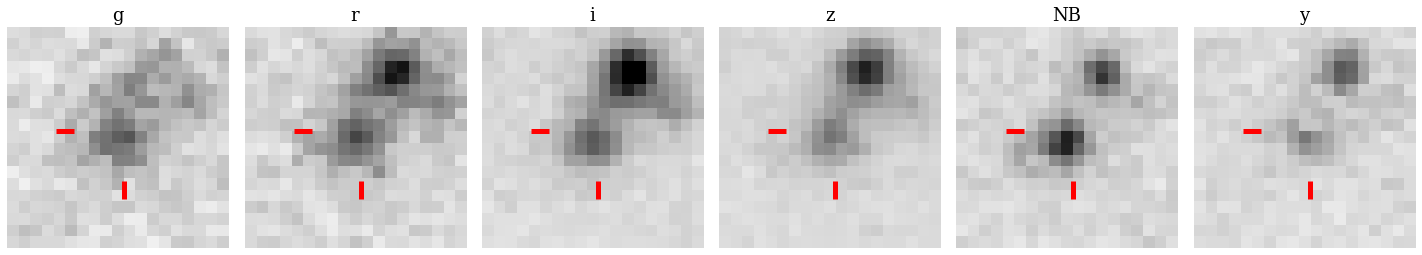

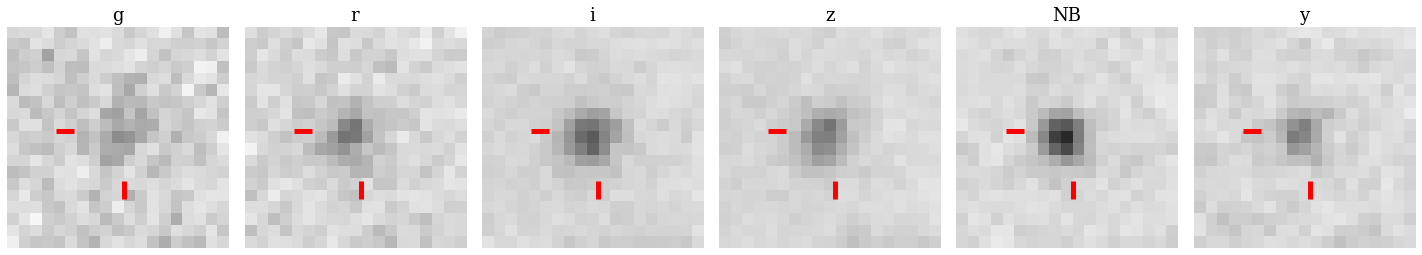

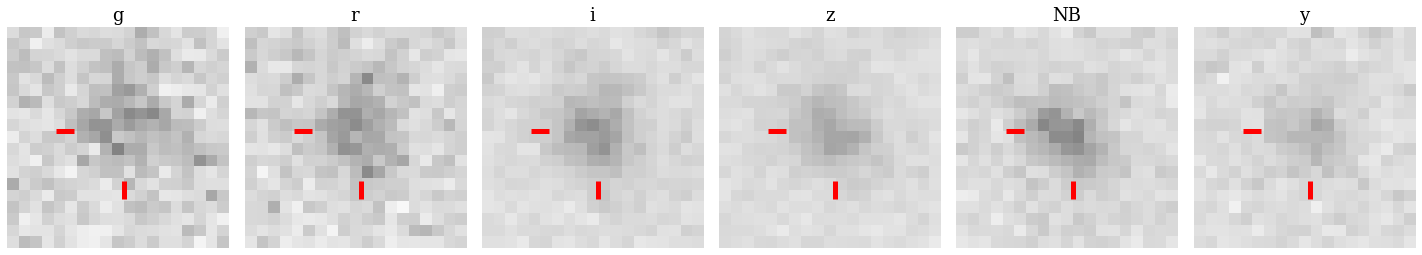

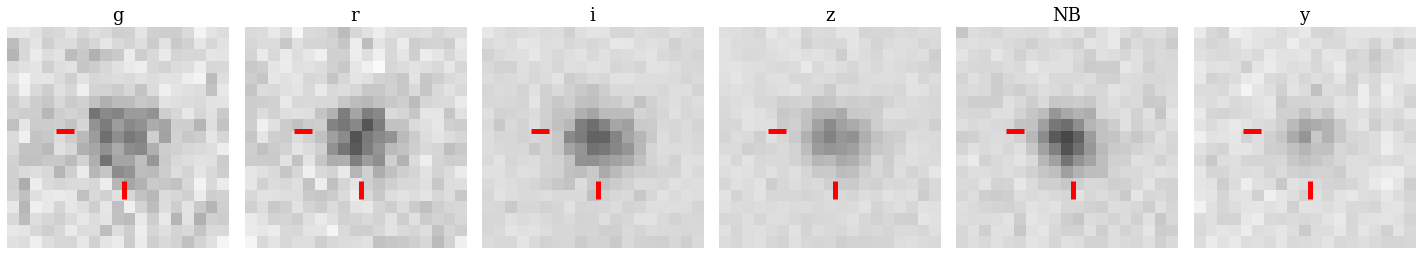

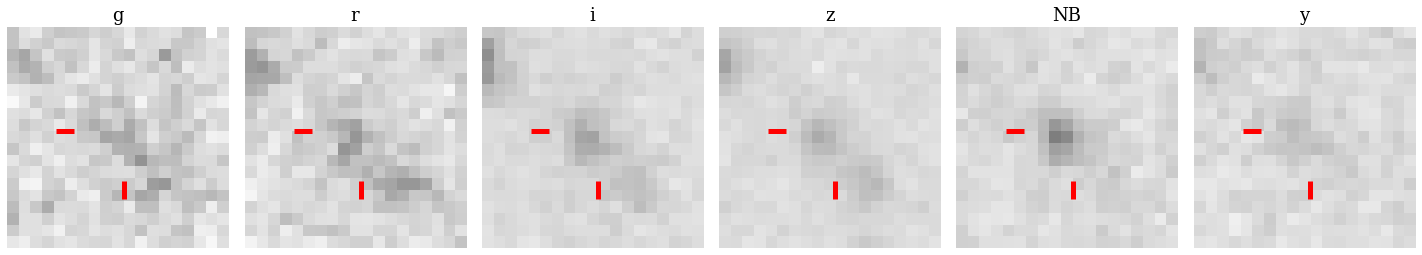

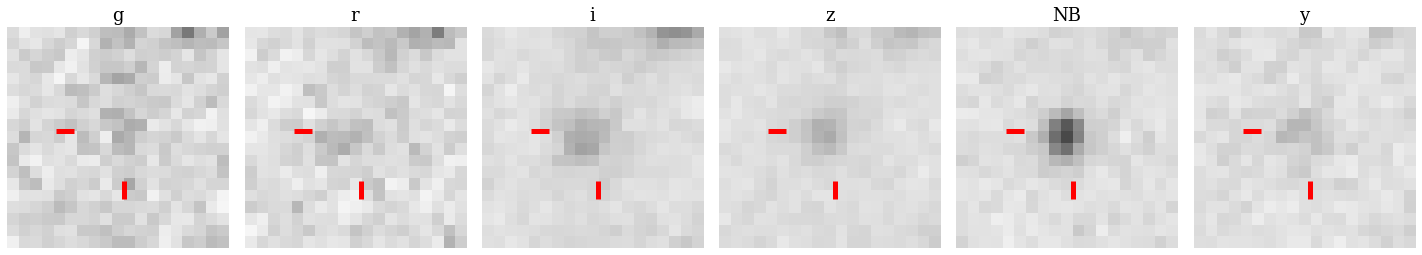

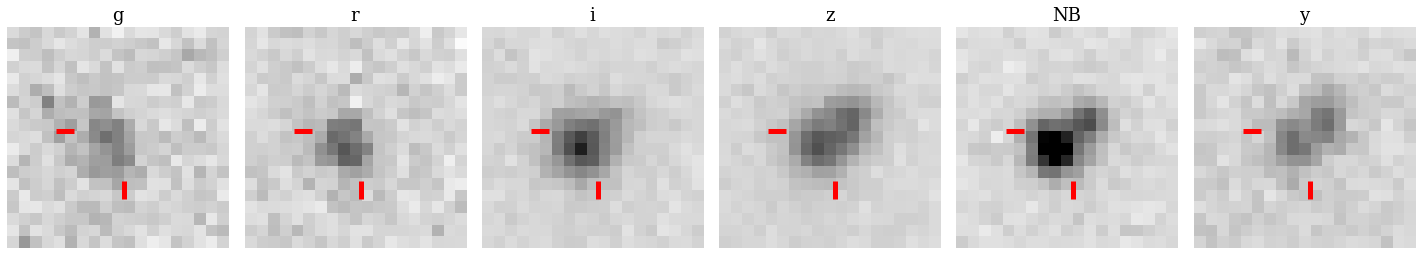

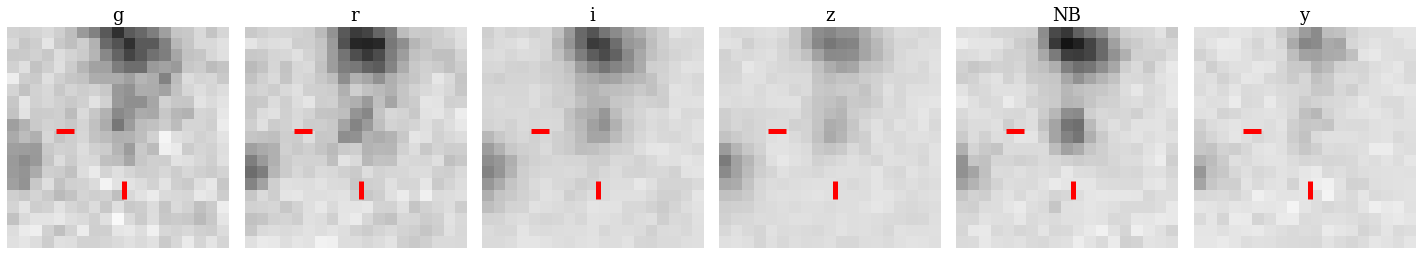

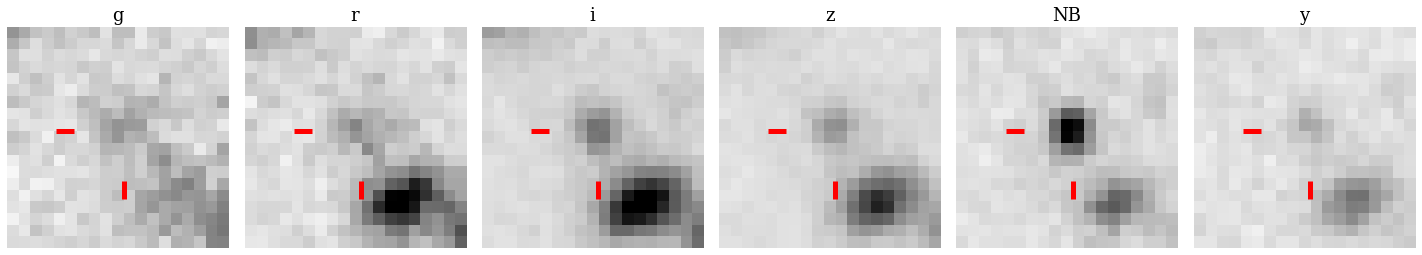

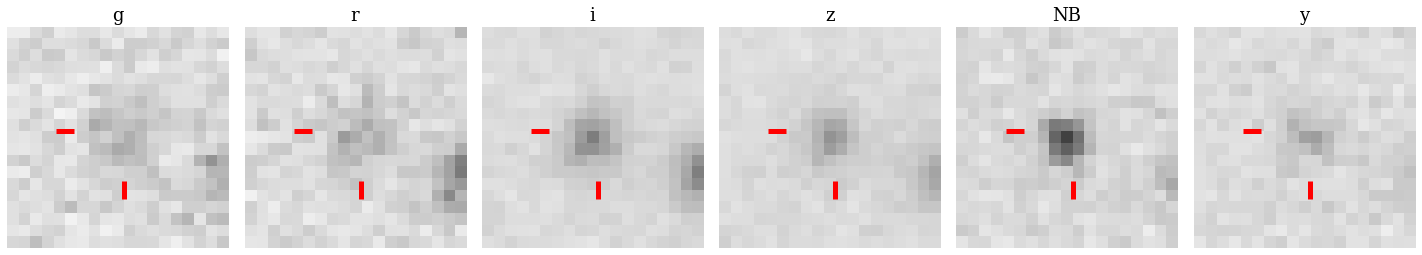

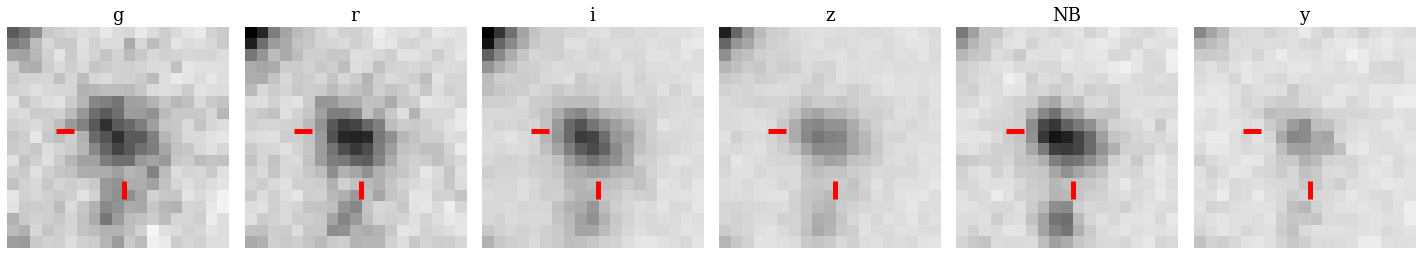

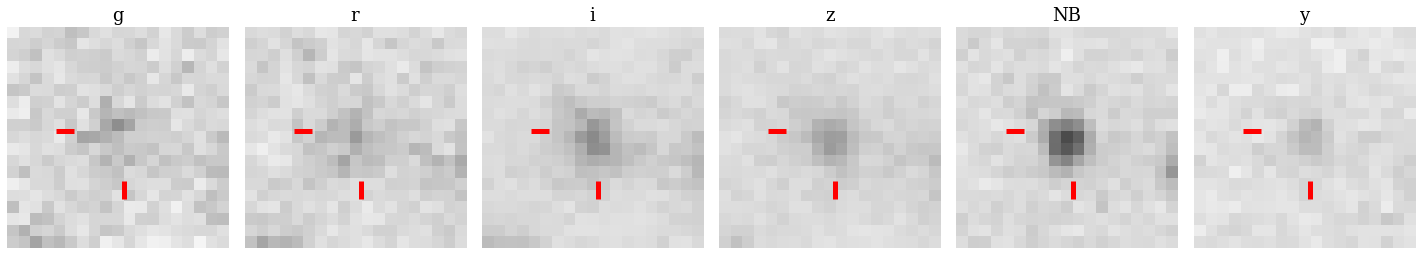

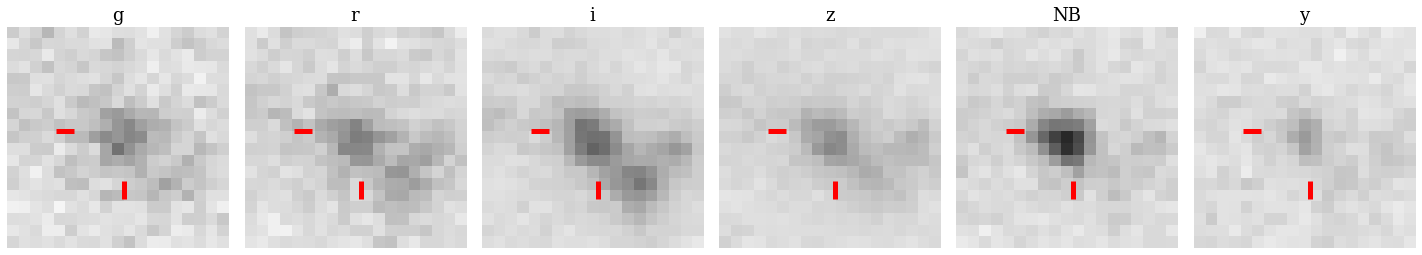

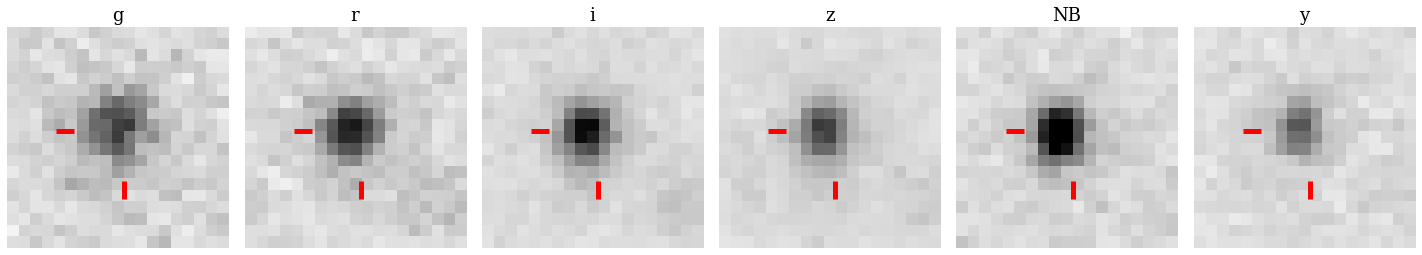

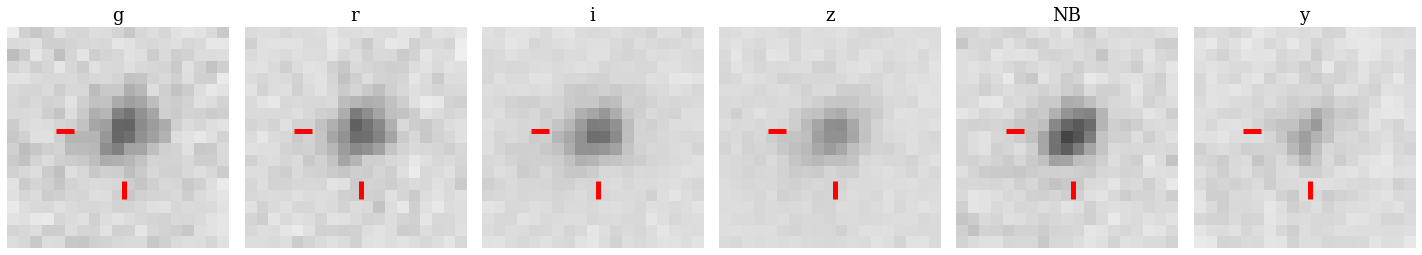

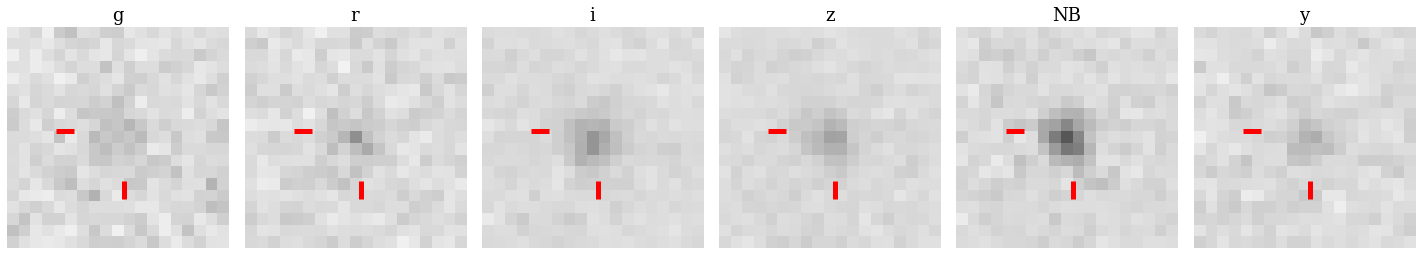

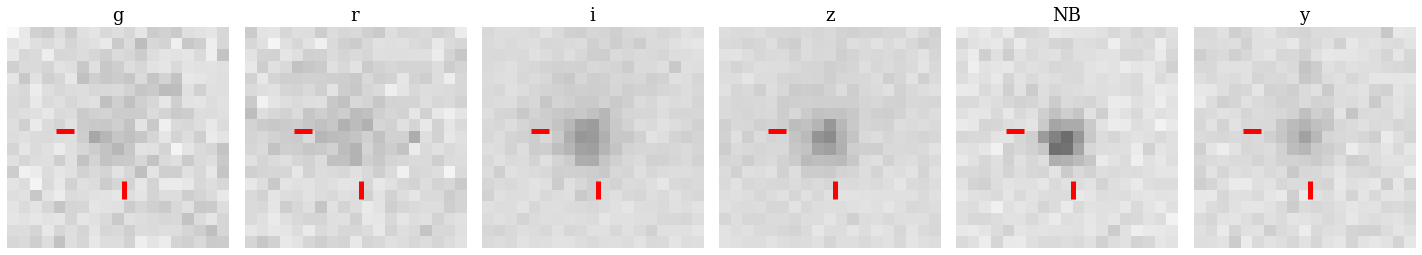

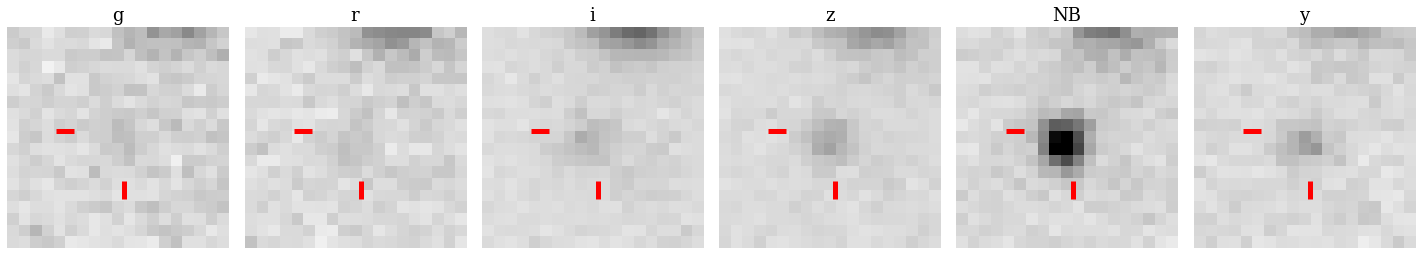

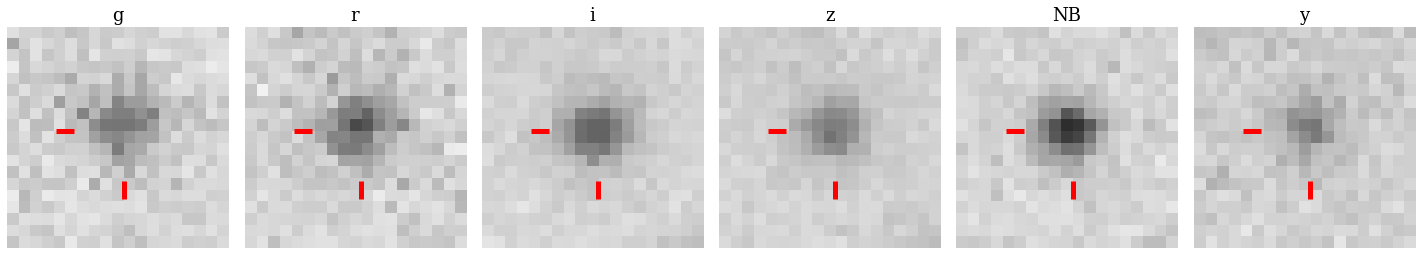

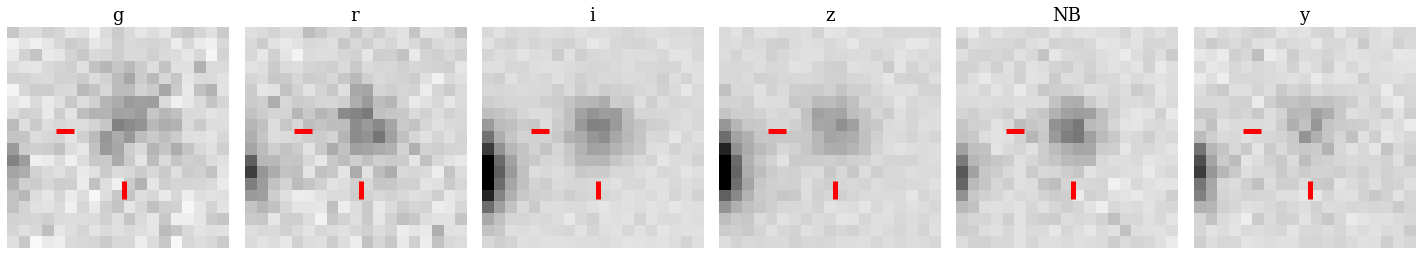

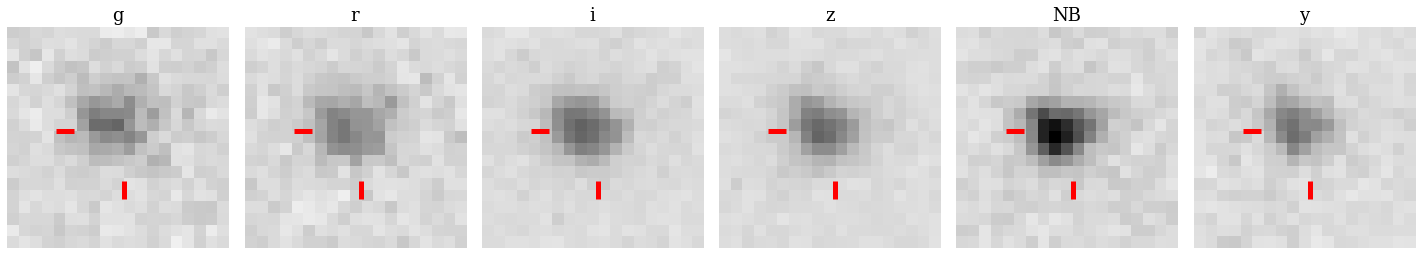

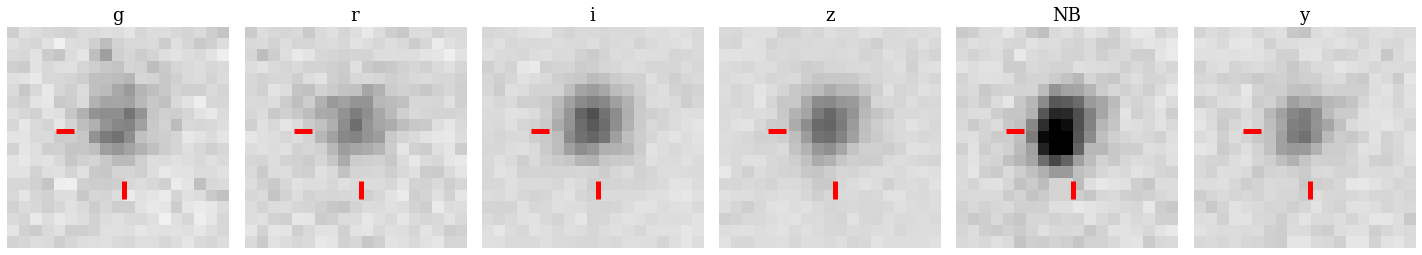

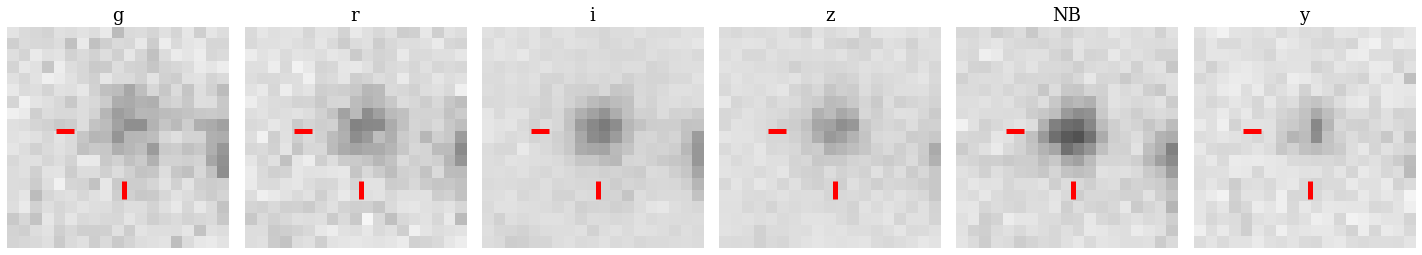

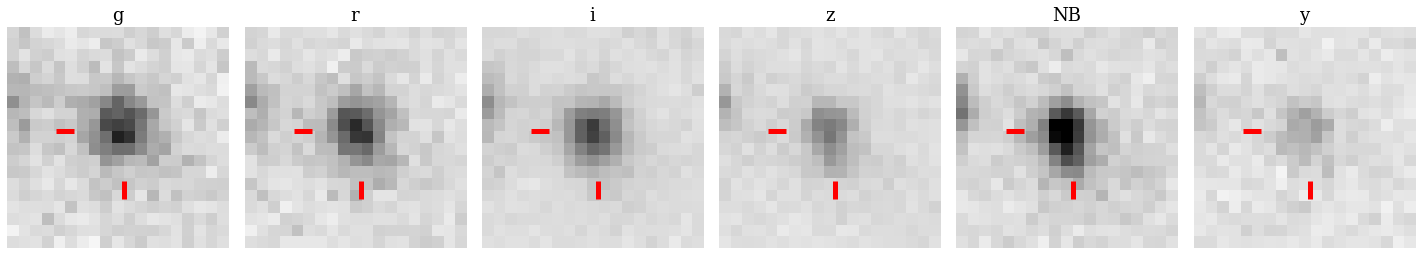

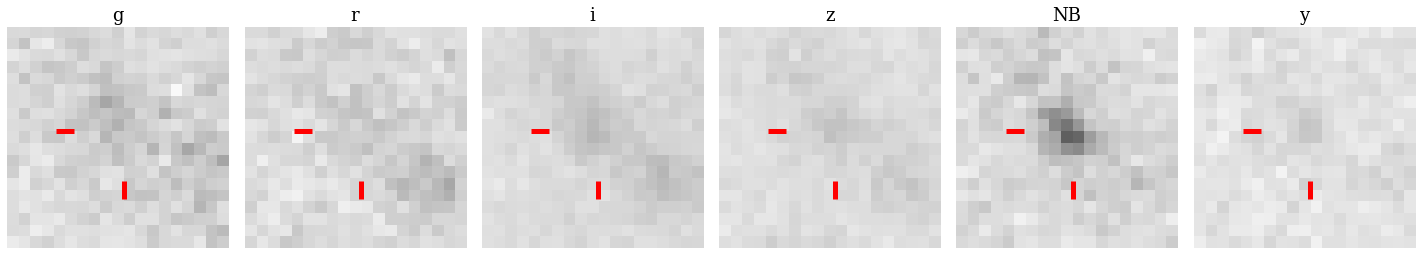

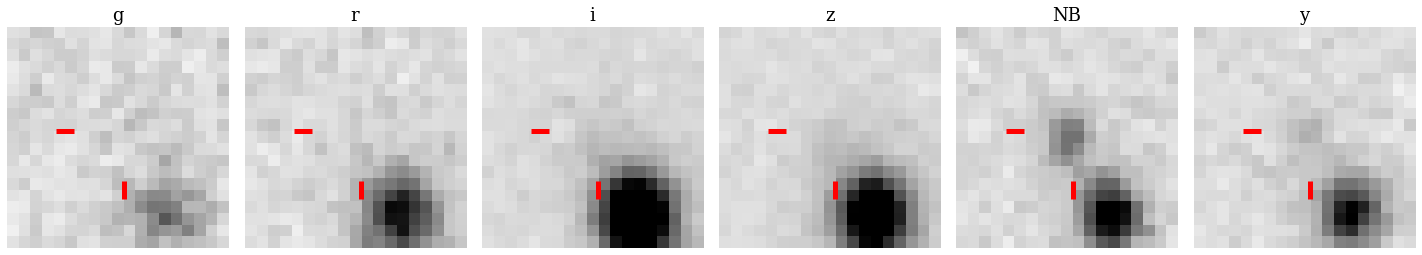

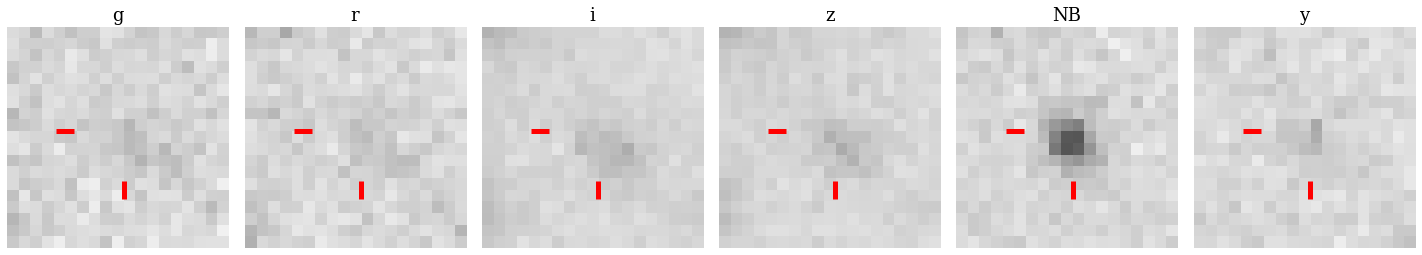

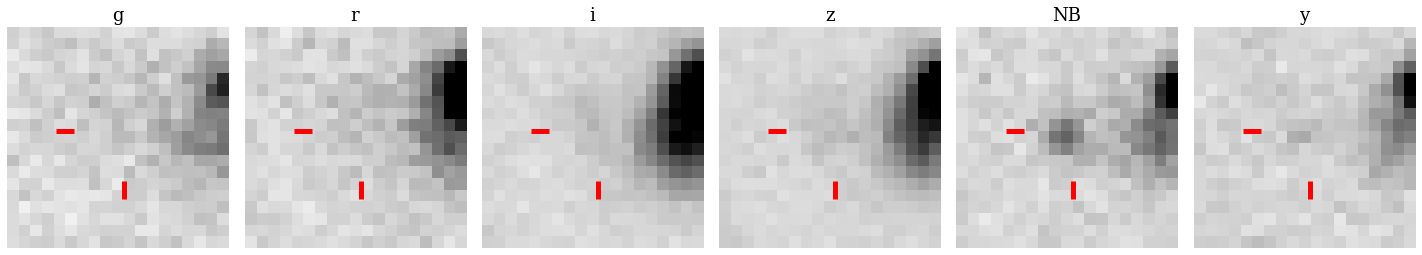

KeyboardInterrupt: 

In [40]:
nsf_id = choosef(RA_,DEC_,info)
data_filters = [data_g, data_r, data_i, data_z,data_NB, data_y]
hdr_filters = [hdr_g, hdr_r, hdr_i, hdr_z, hdr_NB,hdr_y]
names_filters = ['g', 'r', 'i', 'z', 'NB', 'y']
#flux_filters = [g,r,i,z,NB,y]
#flux_errors = [g_err,r_err,i_err,z_err,NB_err,y_err]
NSF_cutm = cuts_mult(nsf_id, data_filters, hdr_filters, names_filters, 5, 'NSF1')